In [1]:
from search import *
from game import *
from util import *
from pacman import *
import util, layout
import sys, types, time, random, os
import numpy as np
import math
import matplotlib.pyplot as plt
from random import random, randint, seed, choice


In [2]:

STATE_VARS = ['actionScore', 'eatFood', 'minGhostDist', 'minDistToFood', 'distToPill', 'minDistEdibleGhost']
" actionScore: scoreFuturo - scoreAtual "
" eatFood: numFoodAtual - numFoodFuturo"
" minGhostDist: |ghostX - pacmanX| + |ghostY - pacmanY| "
" minDistToFood: |foodX - pacmanX| + |foodY - pacmanY| "
" distToPill: |pillX - pacmanX| + |pillY - pacmanY| "


       

' distToPill: |pillX - pacmanX| + |pillY - pacmanY| '

In [3]:
n = Directions.NORTH
s = Directions.SOUTH
e = Directions.EAST
w = Directions.WEST

def manhattanDistance(posA, posB):
    return (abs(posB[0] - posA[0]) + abs(posB[1] - posA[1]))

def calcMinGhostDist(pacmanPosition, ghostsPosition):
    dist = 99999
    for ghost in ghostsPosition:
        if dist > manhattanDistance(pacmanPosition, ghost):
            dist = manhattanDistance(pacmanPosition, ghost)
            
    return dist

def manhattanFoodDistance(posA, posX, posY):
    return (abs(posX - posA[0]) + abs(posY - posA[1]))

def minDistBFS(agentPos, positionsInput, wallGrid):
    positions = []
    for pos in positionsInput:
        positions.append((math.floor(pos[0]),math.floor(pos[1])))
    # Toma paredes como celulas ja visitadas
    visited = wallGrid.copy()
    queue = []
    queue.append((agentPos,1))
    visited[agentPos[0]][agentPos[1]] = True
    if len(positions) > 0:
        if(agentPos in positions):
            return 1
        while queue:
            el = queue.pop(0)
            h = el[1]
            s = el[0]

            north = (s[0],s[1]+1)
            south = (s[0],s[1]-1)
            west = (s[0]-1,s[1])
            east = (s[0]+1,s[1])

            for i in [north, south, west, east]:    
                if visited[i[0]][i[1]] == False:
                    queue.append((i,h+1))
                    visited[i[0]][i[1]] = True

                    if(i in positions):    
    #                     print (i, end = " ")
                        return h
                
    return 0

def findFoodMinDistBFS(agentPos, foodGrid, wallGrid):
    # Toma paredes como celulas ja visitadas
    visited = wallGrid.copy()
    queue = []
    queue.append((agentPos,1))
    visited[agentPos[0]][agentPos[1]] = True
    if(foodGrid[agentPos[0]][agentPos[1]]):  
        return 1
    while queue:
        el = queue.pop(0)
        h = el[1]
        s = el[0]

        north = (s[0],s[1]+1)
        south = (s[0],s[1]-1)
        west = (s[0]-1,s[1])
        east = (s[0]+1,s[1])

        for i in [north, south, west, east]:    
            if visited[i[0]][i[1]] == False:
                queue.append((i,h+1))
                visited[i[0]][i[1]] = True

                if(foodGrid[i[0]][i[1]]):    
#                     print (i, end = " ")
                    return h
                
    return 0

def getMinDistEdibleGhost(agentPos,state):
    ghostPos = []
    ghostStates = state.getGhostStates()
    for gs in ghostStates:
        if gs.scaredTimer > 0:
            ghostPos.append(gs.getPosition())
            
    return minDistBFS(agentPos, ghostPos, state.getWalls())



# directionsAux = {}
# directionsAux['North'] = (0,+1)
# directionsAux['South'] = (0,-1)
# directionsAux['West'] = (-1,0)
# directionsAux['East'] = (+1,0)
def calcFeatures(state, action):
    futureState = state.generatePacmanSuccessor(action)
    pos = state.getPacmanPosition()
    future_pos = futureState.getPacmanPosition()
    #     future_pos = (pos[0]+d[0],pos[1]+d[1])
    
    if state.getFood()[future_pos[0]][future_pos[1]] or (future_pos in state.getCapsules()):
        eatFood = 1.0
    else:
        eatFood = 0
        
    
    futureScore = futureState.getScore() - state.getScore()
    ghostDist = minDistBFS(future_pos, futureState.getGhostPositions(), state.getWalls())
    foodDist = findFoodMinDistBFS(future_pos,state.getFood(),state.getWalls())
    pillDist = minDistBFS(future_pos, state.getCapsules(), state.getWalls())
    edibleGhost = getMinDistEdibleGhost(future_pos,futureState)

#     print("STATE VARS:  FS: ", futureScore," EF: ", eatFood, " GD: ", ghostDist," FD: ", foodDist, " PD: ", pillDist," EG: ",edibleGhost)
    if ghostDist == edibleGhost:
        ghostDist = 0
        
    else:
        if ghostDist == 1:
            futureScore -= 200
        else:
            futureScore += 200*(1/(foodDist**2)) # TODO
        
        if ghostDist != 0:
            ghostDist = -1/(ghostDist**2)
        else:
            ghostDist = 0

    if edibleGhost != 0:
        edibleGhost = 1/(edibleGhost**2)

    else:
        edibleGhost = 0
#         ghostDist *= -1
        
    if pillDist != 0:
        pillDist = 1/(pillDist**2)
    else:
        pillDist = 0
    print("STATE VARS: ",futureScore/500,ghostDist,1/(foodDist**2),pillDist,edibleGhost)
    
    return np.array([[futureScore/500,ghostDist,1/(foodDist**2),pillDist,edibleGhost]])

class MyGoWestAgent(Agent):
    "An agent that goes West until it can't."
    def __init__(self, W = None, Q=0, ls=0):
        self.W = W
        self.Q = Q
        self.lastScore = ls
        self.n_train = 0
        self.isTrain=True
        self.numActions = 0
        
    def setW(self, W):
        if self.isTrain:
            self.W = W
        
    def setQ(self, Q):
        self.Q = Q
        
    def setLastScore(self, lastScore):
        self.lastScore = lastScore
        
    def setNTrain(self, n_train):
        self.n_train = n_train
        
    def setIsTrain(self, isTrain):
        self.isTrain = isTrain
        
    def setNumActions(self, numActions):
        self.numActions = numActions
        
    def setLastEatFood(self, lastEatFood):
        self.lastEatFood = lastEatFood

    def getAction(self, state):
        "The agent receives a GameState (defined in pacman.py)."

        count = 0
        legalActions = state.getLegalPacmanActions()
        legalActions.remove(Directions.STOP) #remove a opcao Stop
        actionScore = []
        
        
        for action in legalActions:    
            stateVars = calcFeatures(state, action)
            actionValue = np.dot(self.W,stateVars.T)
            actionScore.append(actionValue[0][0])
            
        print("Action Score: ",actionScore)
        print(state.getLegalPacmanActions())
#         if actionScore.count(max(actionScore)) > 1:
#             maxScore = max(actionScore)
#             indexes = [i for i, j in enumerate(actionScore) if j == maxScore]
#             maxIndex = choice(indexes)
#         else:
#         scoresAux = actionScore[:]
#         if min(scoresAux) < 0:
#             scoresAux = scoresAux[:]-2*min(scoresAux)
            
        if self.isTrain:
            epsilon = 0.3/self.n_train
            if epsilon < 0.1:
                epsilon = 0
            print("-- epsilon: ",epsilon)
            eGreedy = np.random.choice(2, p=[epsilon,1-epsilon])
    #         norm = np.array(scoresAux[:]/sum(scoresAux[:]))
    #         print("scoresAux: ",scoresAux, "  -  norm: ",norm)
            if eGreedy > 0:
                action = legalActions[actionScore.index(max(actionScore))]
            else:
                action = np.random.choice(legalActions)
        else:
            action = legalActions[actionScore.index(max(actionScore))]
        
        
        
        gama = 0.9
        r = stateVars[0][0]
        alfa = 0.008
        
        stateVars = calcFeatures(state, action)        
        chosenScore = np.dot(self.W,stateVars.T)
        
        self.setLastEatFood(stateVars[0][1])
        
        difference = (r+gama*chosenScore[0][0]) - self.Q
        self.setQ(chosenScore[0][0])
        self.setLastScore(state.getScore())
        self.setW(self.W + alfa*difference*np.array(stateVars))
        
        print("W: ", self.W, "  -  ACTION: ",action)
        
        if action in state.getLegalPacmanActions():
            self.setNumActions(self.numActions+1)
            return action
        else:
            return Directions.STOP
        
def calcFinalFeatures(state, action, lastScore, lastEatFood):
    pos = state.getPacmanPosition()
        
    
    futureScore = state.getScore() - lastScore
    ghostDist = minDistBFS(pos, state.getGhostPositions(), state.getWalls())
    foodDist = findFoodMinDistBFS(pos,state.getFood(),state.getWalls())
    pillDist = minDistBFS(pos, state.getCapsules(), state.getWalls())
    edibleGhost = 0

#     print("FINAL VARS:  FS: ", futureScore," EF: ", eatFood, " GD: ", ghostDist," FD: ", foodDist, " PD: ", pillDist," EG: ",edibleGhost)
    if ghostDist != 0:
        ghostDist = -1/(ghostDist**2)
    else:
        ghostDist = 0
        
    if pillDist != 0:
        pillDist = 1/(pillDist**2)
    else:
        pillDist = 0
        
    if foodDist != 0:
        foodDist = 1/(foodDist**2)
    else:
        foodDist = 0
    if lastEatFood > 0:
        foodDist = lastEatFood
        
    print("FINAL VARS: ",futureScore/500,ghostDist,foodDist,pillDist,edibleGhost)
    
    return np.array([[futureScore/500,ghostDist,foodDist,pillDist,edibleGhost]])

In [4]:


def approxQLearning(pacman, layoutType, maxTrain=30, n_train=1):
    numGames=1
    gameLayout = layout.getLayout( layoutType )
    ghostType = loadAgent('RandomGhost', True)
    ghosts = [ghostType( i+1 ) for i in range( 4 )]

#     import textDisplay
#     textDisplay.SLEEP_TIME = 0.1
#     gameDisplay = textDisplay.PacmanGraphics()
    import graphicsDisplay
    gameDisplay = graphicsDisplay.PacmanGraphics(1.0, frameTime = 0.1)

    results = []
    gamesScores = []
    numActions = []
    
    count = 0
    while count <= maxTrain:
        print("------------------------------------------ train --------------------")
        pacman.setNumActions(0)
        count += 1
        pacman.setNTrain(n_train+1)
        games = runGames( gameLayout, pacman, ghosts, gameDisplay, numGames, False)
        scores = [game.state.getScore() for game in games]
        
        if games[0].state.isLose():
            stateVars = calcFinalFeatures(games[0].state, None, pacman.lastScore, pacman.lastEatFood)
            actionValue = np.dot(pacman.W,stateVars.T)

            gama = 0.9
            r = stateVars[0][0]
            alfa = 0.008

            difference = (r+gama*actionValue[0][0]) - pacman.Q
            pacman.setW(pacman.W + alfa*difference*stateVars)

    #         print("R: ",r," Q': ",gama*actionValue[0][0]," Q: ",pacman.Q)
    #         print("diff: ",difference)
    #         print("array: ",alfa*difference*stateVars)
        

        wins = [game.state.isWin() for game in games]
        winRate = wins.count(True)/ float(len(wins))
        avgScore = sum(scores) / float(len(scores))
        results.append(games[0].state.isWin())
        gamesScores.append(scores[0])
        numActions.append(pacman.numActions)
        print(pacman.W)
        print(avgScore)

    print(results)
    print("Wins: ",results.count(True)," Loss: ",results.count(False))
    print(gamesScores)
    return gamesScores, results, numActions

In [5]:
layoutType='smallClassic'

W = np.zeros((1,5))
W[:] = 0.7
pacman = MyGoWestAgent(W)
gamesScores, results, numActions = approxQLearning(pacman, layoutType, 15)

layout:  smallClassic
------------------------------------------ train --------------------
STATE VARS:  0.418 -0.008264462809917356 1.0 0.015625 0
STATE VARS:  0.418 -0.01 1.0 0.02040816326530612 0
Action Score:  [0.9977523760330578, 0.9998857142857142]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.01 1.0 0.02040816326530612 0
W:  [[0.70440705 0.69989457 0.71054318 0.70021517 0.7       ]]   -  ACTION:  West
STATE VARS:  0.398 -0.01 1.0 0.015625 0
STATE VARS:  0.418 -0.015625 1.0 0.027777777777777776 0
Action Score:  [0.994839098565273, 1.0134998918996294]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.015625 1.0 0.027777777777777776 0
W:  [[0.70551145 0.69985329 0.71318529 0.70028856 0.7       ]]   -  ACTION:  West
STATE VARS:  0.098 -0.015625 0.25 0.02040816326530612 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.04 0
Action Score:  [0.2507928405707436, 1.0166602506972435]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.02777777

STATE VARS:  0.098 -0.005917159763313609 0.25 0.0025 0.0034602076124567475
STATE VARS:  0.418 -0.005917159763313609 1.0 0.0030864197530864196 0.0044444444444444444
Action Score:  [0.25699034932637865, 1.0477347934780183]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.005917159763313609 1.0 0.0030864197530864196 0.0044444444444444444
W:  [[0.72241287 0.69974751 0.74761192 0.70059082 0.69816695]]   -  ACTION:  South
STATE VARS:  0.098 -0.005917159763313609 0.25 0.002770083102493075 0.00390625
STATE VARS:  0.418 -0.008264462809917356 1.0 0.0034602076124567475 0.00510204081632653
Action Score:  [0.25822683409310027, 1.049783733113018]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.008264462809917356 1.0 0.0034602076124567475 0.00510204081632653
W:  [[0.72346647 0.69972668 0.75013249 0.70059955 0.69817981]]   -  ACTION:  South
STATE VARS:  0.098 -0.008264462809917356 0.25 0.0030864197530864196 0.00510204081632653
STATE VARS:  0.418 -0.0123456790123456

STATE VARS:  -0.002 0 1.0 0.006944444444444444 0.1111111111111111
STATE VARS:  0.4424444444444445 -0.015625 0.1111111111111111 0.006944444444444444 0
Action Score:  [0.8413296507828556, 0.3989143660017648]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 1.0 0.006944444444444444 0.1111111111111111
W:  [[0.72436215 0.69985953 0.76289628 0.7006265  0.69762848]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.0625
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.25
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.0625
Action Score:  [0.8236822957949018, 0.36782818380636395, 0.825326878514896]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.0625
W:  [[0.72435055 0.69985953 0.76225199 0.70062118 0.69758821]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.01 0.027777777777777776
STATE VARS:  -0.002 0 1.0 0.006944444444444444 0.0625
Action Score:  [0.8016739665837327, 0.809267981463527]
['East', 'West', 

STATE VARS:  0.014 -0.0625 0.04 0.00510204081632653 0
STATE VARS:  0.014 -0.0625 0.04 0.00510204081632653 0
STATE VARS:  0.006163265306122449 -0.027777777777777776 0.02040816326530612 0.00390625 0
Action Score:  [0.0005843193187581169, 0.0005843193187581169, 0.0033888570428707732]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.014 -0.0625 0.04 0.00510204081632653 0
W:  [[0.72684296 0.70312305 0.76951422 0.70051088 0.69708824]]   -  ACTION:  South
STATE VARS:  0.009111111111111111 -0.027777777777777776 0.027777777777777776 0.0044444444444444444 0
STATE VARS:  0.023 -0.0625 0.0625 0.005917159763313609 0
STATE VARS:  0.009111111111111111 -0.0625 0.027777777777777776 0.0044444444444444444 0
Action Score:  [0.011579927577561124, 0.025011870452547907, -0.01283406737974254]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.023 -0.0625 0.0625 0.005917159763313609 0
W:  [[0.72684867 0.70310754 0.76952973 0.70051235 0.69708824]]   -  ACTION:  East
STATE VARS:

STATE VARS:  0.418 -0.04 1.0 0.25 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.0625 0
STATE VARS:  0.098 -0.04 0.25 0.0625 0
Action Score:  [1.2502220203339989, 1.068733951119772, 0.2866724010139031]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.04 1.0 0.25 0
W:  [[0.73744218 0.70302065 0.79545666 0.70144697 0.69708824]]   -  ACTION:  North
STATE VARS:  0.418 -0.04 1.0 1.0 0
STATE VARS:  0.398 -0.1111111111111111 1.0 0.1111111111111111 0
Action Score:  [1.7770336305441286, 1.0887837888914502]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.04 1.0 1.0 0
W:  [[0.73994051 0.70278157 0.80143352 0.70742384 0.69708824]]   -  ACTION:  North
STATE VARS:  0.418 -0.04 1.0 0.25 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.25 0
STATE VARS:  -0.002 0 0.25 1.0 0.04
Action Score:  [1.2594733495891186, 0.37164166789915326, 0.9341858659562806]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.04 1.0 0.25 0
W:  [[0.73778193 0.7

STATE VARS:  0.418 -0.012345679012345678 1.0 0.25 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.0625 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0625 0
Action Score:  [1.3342524911254436, 0.31636478310855926, 1.2017038878329989]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0625 0
W:  [[0.77394375 0.70276748 0.84524795 0.70706203 0.69708824]]   -  ACTION:  West
STATE VARS:  0.398 -0.012345679012345678 1.0 0.1111111111111111 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.04 0
Action Score:  [1.2231638663662219, 1.1912309207759477]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.398 -0.012345679012345678 1.0 0.1111111111111111 0
W:  [[0.77495353 0.70273616 0.8477851  0.70734394 0.69708824]]   -  ACTION:  East
STATE VARS:  0.418 -0.01 1.0 0.25 0
STATE VARS:  0.098 -0.015625 0.25 0.0625 0
STATE VARS:  0.398 -0.01 1.0 0.0625 0
Action Score:  [1.3415242965349639, 0.3211204641236396, 1.193398237942055]
['North', 'East', 

STATE VARS:  0.098 -0.005917159763313609 0.25 0.015625 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.027777777777777776 0
Action Score:  [0.30502817855696507, 1.2266350767386243]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.008264462809917356 1.0 0.027777777777777776 0
W:  [[0.79017638 0.70155698 0.88513306 0.71439921 0.69708824]]   -  ACTION:  South
STATE VARS:  0.098 -0.005917159763313609 0.25 0.02040816326530612 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.04 0
Action Score:  [0.3091489012359114, 1.2382047635584408]
['North', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.008264462809917356 1.0 0.04 0
W:  [[0.7911988  0.70153677 0.88757905 0.71449705 0.69708824]]   -  ACTION:  East
STATE VARS:  0.023 -0.012345679012345678 0.0625 0.0625 0
STATE VARS:  0.009111111111111111 -0.008264462809917356 0.027777777777777776 0.027777777777777776 0
Action Score:  [0.10966638142672122, 0.04591298977518956]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS

STATE VARS:  0.418 -0.027777777777777776 1.0 0.04 0
STATE VARS:  0.098 -0.0625 0.25 0.02040816326530612 0
Action Score:  [1.2595028192137023, 0.278225511525297]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.027777777777777776 1.0 0.04 0
W:  [[0.80227324 0.69967021 0.91505986 0.71435467 0.69708824]]   -  ACTION:  East
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0625 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.0625 0.25 0.027777777777777776 0
Action Score:  [1.275621956982958, 1.2508179753374946, 0.2835015397918118]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0625 0
W:  [[0.80222828 0.69967319 0.91495232 0.71434795 0.69708824]]   -  ACTION:  North
STATE VARS:  0.418 -0.027777777777777776 1.0 0.04 0
STATE VARS:  0.398 -0.0625 1.0 0.04 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.1111111111111111 0
Action Score:  [1.2594222899714391, 1.219083516217513, 1.3102203

STATE VARS:  0.098 -0.0625 0.25 0.1111111111111111 0
STATE VARS:  0.023 -0.25 0.0625 0.04 0
Action Score:  [0.35323201418883404, -0.06770485827338649]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.098 -0.0625 0.25 0.1111111111111111 0
W:  [[0.81569119 0.69795115 0.94756375 0.72149745 0.69708824]]   -  ACTION:  East
STATE VARS:  0.042444444444444444 -0.0625 0.1111111111111111 0.25 0
STATE VARS:  0.398 -0.0625 1.0 0.0625 0
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0.0625 0
Action Score:  [0.2766588363883994, 1.2736804841757436, 0.010512222979672275]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.398 -0.0625 1.0 0.0625 0
W:  [[0.8183515  0.69753339 0.95424794 0.72191522 0.69708824]]   -  ACTION:  East
STATE VARS:  0.418 -0.0625 1.0 0.04 0
STATE VARS:  0.098 -0.25 0.25 0.1111111111111111 0
Action Score:  [1.2815996449965597, 0.2245898878743743]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.0625 1.0 0.04 0
W:  [[0.81827713 

STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
Action Score:  [1.3265044097274727, 0.3338443844390713, 1.3651326642654853]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
W:  [[0.84660345 0.69760438 0.98338549 0.71899655 0.6963775 ]]   -  ACTION:  West
STATE VARS:  0.398 -0.04 1.0 0.04 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
Action Score:  [1.3211893507458947, 1.402917414254736]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
W:  [[0.84765846 0.69755287 0.98590944 0.71927699 0.6963775 ]]   -  ACTION:  West
STATE VARS:  0.418 -0.02040816326530612 1.0 0.25 0
STATE VARS:  0.098 -0.04 0.25 0.0625 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
Action Score:  [1.5058141444771667, 0.34660058463982324, 1.3709497093957104

STATE VARS:  0.418 -0.02040816326530612 1.0 0.015625 0
STATE VARS:  0.098 -0.04 0.25 0.027777777777777776 0
Action Score:  [1.3858461903906854, 0.3323878762678882]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.02040816326530612 1.0 0.015625 0
W:  [[0.91339389 0.73006852 1.00717769 0.72646673 0.6963775 ]]   -  ACTION:  North
STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.02040816326530612 0
Action Score:  [1.3947890006870696, 0.3412335190629527]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
W:  [[0.91328509 0.73007173 1.00691741 0.72646142 0.6963775 ]]   -  ACTION:  North
STATE VARS:  0.418 -0.02040816326530612 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.015625 0
Action Score:  [1.3939506340094336, 0.34356901867115425]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.02040816326530612 1.

STATE VARS:  0.418 -0.25 1.0 0.015625 0
STATE VARS:  0.098 -0.0625 0.25 0.027777777777777776 0
Action Score:  [1.233932809659616, 0.3198547357942994]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.25 1.0 0.015625 0
W:  [[0.91861476 0.7302268  1.0201354  0.72657529 0.6963775 ]]   -  ACTION:  East
STATE VARS:  0.098 -0.25 0.25 0.012345679012345678 0
STATE VARS:  0.418 -0.25 1.0 0.015625 0
STATE VARS:  0.098 -0.0625 0.25 0.02040816326530612 0
Action Score:  [0.17147146295464497, 1.2329124147023471, 0.31424699009512636]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.098 -0.25 0.25 0.012345679012345678 0
W:  [[0.91784518 0.73219002 1.01817219 0.72647834 0.6963775 ]]   -  ACTION:  North
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0.01 0
STATE VARS:  0.398 -0.0625 1.0 0.015625 0
STATE VARS:  0.398 -0.25 1.0 0.012345679012345678 0
Action Score:  [-0.023695049305498983, 1.3490639186052455, 1.209395934434556]
['North', 'South', 'East', 'Stop']

STATE VARS:  0.098 -0.012345679012345678 0.25 0.04 0
STATE VARS:  0.398 -0.008264462809917356 1.0 0.04 0
Action Score:  [0.3729374918294458, 1.4395634856413124]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.398 -0.008264462809917356 1.0 0.04 0
W:  [[0.93020584 0.7338228  1.04841003 0.73288942 0.6963775 ]]   -  ACTION:  South
STATE VARS:  0.098 -0.008264462809917356 0.25 0.027777777777777776 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.0625 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.027777777777777776 0
Action Score:  [0.3675560681493075, 0.3947261219026224, 1.4515294598581012]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.008264462809917356 1.0 0.027777777777777776 0
W:  [[0.93115825 0.73380397 1.05068854 0.73295271 0.6963775 ]]   -  ACTION:  West
STATE VARS:  0.098 -0.005917159763313609 0.25 0.04 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.02040816326530612 0
Action Score:  [0.37890171577973897, 1.448806408253918]
['East', 'Wes

STATE VARS:  0.098 -0.02040816326530612 0.25 0.04 0
STATE VARS:  0.418 -0.04 1.0 0.1111111111111111 0
Action Score:  [0.3767995820059839, 1.526372965512419]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.04 1.0 0.1111111111111111 0
W:  [[0.94405574 0.7335045  1.08253362 0.73429684 0.6963775 ]]   -  ACTION:  West
STATE VARS:  0.098 -0.1111111111111111 0.25 0.25 0
STATE VARS:  0.098 -0.04 0.25 0.0625 0
STATE VARS:  0.418 -0.04 1.0 0.0625 0
Action Score:  [0.4652245790272105, 0.37970424092100763, 1.493702295054966]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.04 1.0 0.0625 0
W:  [[0.94484479 0.733429   1.0844213  0.73441482 0.6963775 ]]   -  ACTION:  West
STATE VARS:  0.098 -0.1111111111111111 0.25 0.1111111111111111 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.1111111111111111 0
STATE VARS:  1.418 -0.04 1.0 0.04 0
Action Score:  [0.3638096494656524, 0.3638096494656524, 2.424250638734085]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15

STATE VARS:  0.098 -0.006944444444444444 0.25 0.25 0
STATE VARS:  0.398 -0.006944444444444444 1.0 0.0625 0
STATE VARS:  0.418 -0.00510204081632653 1.0 0.0625 0
Action Score:  [0.5623039543416106, 1.573611390162756, 1.5946590066691484]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.00510204081632653 1.0 0.0625 0
W:  [[0.98594637 0.73008578 1.14212043 0.74329679 0.6963775 ]]   -  ACTION:  West
STATE VARS:  0.098 -0.00510204081632653 0.25 0.1111111111111111 0
STATE VARS:  0.418 -0.00390625 1.0 0.04 0
Action Score:  [0.4610164563872382, 1.5811259855839352]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.00390625 1.0 0.04 0
W:  [[0.98677018 0.73007808 1.14409126 0.74337562 0.6963775 ]]   -  ACTION:  West
STATE VARS:  0.098 -0.00390625 0.25 0.0625 0
STATE VARS:  0.418 -0.0030864197530864196 1.0 0.027777777777777776 0
Action Score:  [0.42633540255934443, 1.5749571942311231]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.00308641975

STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.02040816326530612 1.0
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.1111111111111111
Action Score:  [0.3733055207676831, 1.8841874165155112, 0.3733055207676831]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.02040816326530612 1.0
W:  [[0.99072781 0.73007048 1.15756038 0.74566669 0.69894294]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.25
STATE VARS:  -0.002 0 0.25 0.015625 0.0625
Action Score:  [1.3708421813997727, 0.3427436156865283]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.25
W:  [[0.99063386 0.73007048 1.15234095 0.7455217  0.69763809]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.04 1.0
STATE VARS:  -0.002 0 0.25 0.02040816326530612 0.1111111111111111
Action Score:  [1.8976313088018766, 0.37883404013981825]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.04 1.

STATE VARS:  0.418 -0.02040816326530612 1.0 0.04 0
STATE VARS:  0.098 -0.04 0.25 0.04 0
STATE VARS:  0.398 -0.02040816326530612 1.0 0.1111111111111111 0
Action Score:  [1.6186571380469932, 0.3952247757747781, 1.6520604175065814]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.398 -0.02040816326530612 1.0 0.1111111111111111 0
W:  [[1.00326174 0.72989999 1.18673261 0.75189913 0.70031829]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0625 0
STATE VARS:  0.398 -0.012345679012345678 1.0 0.25 0
STATE VARS:  0.398 -0.02040816326530612 1.0 0.0625 0
Action Score:  [1.6440786041807183, 1.7649944568757938, 1.6181285622744415]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.398 -0.012345679012345678 1.0 0.25 0
W:  [[1.00432658 0.72986696 1.18940809 0.752568   0.70031829]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.012345679012345678 0.25 1.0 0
STATE VARS:  0.398 -0.0204081632

STATE VARS:  0.0003668639053254439 -0.1111111111111111 0.005917159763313609 1.0 0
STATE VARS:  0.0003668639053254439 -0.25 0.005917159763313609 0.1111111111111111 0
Action Score:  [0.6789821589828118, -0.09129139195836602]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.0003668639053254439 -0.1111111111111111 0.005917159763313609 1.0 0
W:  [[1.01632249 0.72950552 1.21874498 0.75648895 0.70031829]]   -  ACTION:  North
STATE VARS:  0.0007777777777777776 -0.1111111111111111 0.006944444444444444 0.25 0
STATE VARS:  4.081632653061229e-05 -0.25 0.00510204081632653 0.25 0
STATE VARS:  -0.002 0 0.00510204081632653 1.0 0.0625
Action Score:  [0.11732004952900077, 0.013005427970528033, 0.8044442884723649]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.00510204081632653 1.0 0.0625
W:  [[1.0163218  0.72950552 1.21874674 0.7568331  0.7003398 ]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.005917159763313609 0 0.1111111111111111
Action Score:  [0.08299440916974

STATE VARS:  -0.0006159169550173009 -0.005917159763313609 0.0034602076124567475 0 0
STATE VARS:  -0.0006159169550173009 -0.005917159763313609 0.0034602076124567475 0 0
Action Score:  [-0.0007263299316682785, -0.0007263299316682785]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.0006159169550173009 -0.005917159763313609 0.0034602076124567475 0 0
W:  [[1.0172305  0.72954238 1.21871833 0.7568331  0.7039457 ]]   -  ACTION:  North
STATE VARS:  -0.0004375 -0.005917159763313609 0.00390625 0 0
STATE VARS:  -0.0007654320987654322 -0.0044444444444444444 0.0030864197530864196 0 0
Action Score:  [-1.2387042850588517e-06, -0.0002595551423464101]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.0004375 -0.005917159763313609 0.00390625 0 0
W:  [[1.0172305  0.72954239 1.21871833 0.7568331  0.7039457 ]]   -  ACTION:  North
STATE VARS:  -0.0006159169550173009 -0.005917159763313609 0.0034602076124567475 0 0
STATE VARS:  -0.00022222222222222231 -0.008264462809917356 0.00444444444

STATE VARS:  0.0003668639053254439 -0.1111111111111111 0.005917159763313609 0 0
STATE VARS:  0.0003668639053254439 -0.04 0.005917159763313609 0 0
STATE VARS:  0.0013057851239669422 -0.04 0.008264462809917356 0 0
Action Score:  [-0.0734754624759462, -0.021597062354978915, -0.01778126113457219]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.0013057851239669422 -0.04 0.008264462809917356 0 0
W:  [[1.01723065 0.72953833 1.21871892 0.7568331  0.7039457 ]]   -  ACTION:  West
STATE VARS:  0.0007777777777777776 -0.1111111111111111 0.006944444444444444 0 0
STATE VARS:  0.0007777777777777776 -0.1111111111111111 0.006944444444444444 0 0
STATE VARS:  0.002 -0.04 0.01 0 0
Action Score:  [-0.07180530899509976, -0.07180530899509976, -0.014959882598730921]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.002 -0.04 0.01 0 0
W:  [[1.01723075 0.72953631 1.21871943 0.7568331  0.7039457 ]]   -  ACTION:  West
STATE VARS:  0.0013057851239669422 -0.1111111111111111 0.008

STATE VARS:  0.418 -0.012345679012345678 1.0 1.0 0
STATE VARS:  0.398 -0.012345679012345678 1.0 0.1111111111111111 0
Action Score:  [2.421745011390938, 1.7273625485623731]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.012345679012345678 1.0 1.0 0
W:  [[1.03579067 0.72893775 1.24669372 0.76375138 0.7039457 ]]   -  ACTION:  North
STATE VARS:  0.418 -0.015625 1.0 0.25 0
STATE VARS:  0.098 -0.01 0.25 0.25 0
STATE VARS:  -0.002 0 0.25 1.0 0.01
Action Score:  [1.859202412397387, 0.5968293823106254, 1.0803926814249472]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.015625 1.0 0.25 0
W:  [[1.03328113 0.72903156 1.24069002 0.76225045 0.7039457 ]]   -  ACTION:  North
STATE VARS:  0.418 -0.015625 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.015625 0.25 1.0 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.1111111111111111 0
Action Score:  [1.745904903455206, 1.1622933866747012, 1.737045144949906]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.1

STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
Action Score:  [1.7331154289191588, 0.43413767187759733, 1.7745232223852805]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
W:  [[1.09459431 0.76142708 1.28728654 0.76301919 0.7039457 ]]   -  ACTION:  West
STATE VARS:  0.398 -0.04 1.0 0.04 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
Action Score:  [1.7229987647914133, 1.814067548257261]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
W:  [[1.09551772 0.76138199 1.28949564 0.76326464 0.7039457 ]]   -  ACTION:  West
STATE VARS:  0.418 -0.012345679012345678 1.0 0.25 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.0625 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0625 0
Action Score:  [1.9288384332125703, 0.4619002795609477, 1

STATE VARS:  0.098 -0.015625 0.25 0.002770083102493075 0.002770083102493075
STATE VARS:  0.418 -0.015625 1.0 0.0034602076124567475 0.0034602076124567475
Action Score:  [0.4284409351209666, 1.7670926080270128]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.015625 1.0 0.0034602076124567475 0.0034602076124567475
W:  [[1.10857454 0.76077647 1.31283214 0.75769185 0.7036739 ]]   -  ACTION:  South
STATE VARS:  0.098 -0.015625 0.25 0.0030864197530864196 0.0030864197530864196
STATE VARS:  0.418 -0.027777777777777776 1.0 0.00390625 0.00390625
Action Score:  [0.42947159565978144, 1.7607920779283919]
['North', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.027777777777777776 1.0 0.00390625 0.00390625
W:  [[1.10936245 0.76072411 1.3147171  0.75769921 0.70368127]]   -  ACTION:  East
STATE VARS:  0.418 -0.0625 1.0 0.0044444444444444444 0.00390625
STATE VARS:  0.098 -0.027777777777777776 0.25 0.0034602076124567475 0.0030864197530864196
Action Score:  [1.7370016578954097, 0

STATE VARS:  0.018 0 1.0 0.04 1.0
STATE VARS:  -0.002 0 0.25 0.02040816326530612 0.1111111111111111
Action Score:  [2.090698919204712, 0.42560040789533965]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.04 1.0
W:  [[1.11873205 0.76059636 1.33951698 0.75768929 0.70596406]]   -  ACTION:  East
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0625 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.0625 0.25 0.027777777777777776 0
Action Score:  [1.8333748812685648, 1.8070662252695364, 0.41802463803473344]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0625 0
W:  [[1.11758619 0.76067251 1.33677569 0.75751796 0.70596406]]   -  ACTION:  North
STATE VARS:  0.418 -0.02040816326530612 1.0 0.04 0
STATE VARS:  0.398 -0.04 1.0 0.04 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
Action Score:  [1.8187035051845915, 1.7814488097492749, 1.8725714491496752]
['North', 'So

STATE VARS:  0.498 -0.02040816326530612 0.25 0 0
STATE VARS:  -0.002 0 0.1111111111111111 0 0.25
Action Score:  [0.8790611478279536, 0.3252945656212064]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.498 -0.02040816326530612 0.25 0 0
W:  [[1.12142139 0.7605398  1.34379758 0.75167048 0.71284937]]   -  ACTION:  North
STATE VARS:  0.398 -0.02040816326530612 1.0 0 0
STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0 0
STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0 0
Action Score:  [1.7746020689250095, 0.18138772929908836, 0.16648735773178377]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0 0
W:  [[1.12118819 0.76075957 1.34318711 0.75167048 0.71284937]]   -  ACTION:  West
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.023 -0.1111111111111111 0.0625 0 0
Action Score:  [0.4152428366547918, 0.025207681702027696]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.098 -

STATE VARS:  0.418 -0.027777777777777776 1.0 0.04 0
STATE VARS:  0.098 -0.015625 0.25 0.02040816326530612 0
Action Score:  [1.8600636013266523, 0.458820052845623]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.027777777777777776 1.0 0.04 0
W:  [[1.14108261 0.76027031 1.37331122 0.75154681 0.71284937]]   -  ACTION:  East
STATE VARS:  0.418 -0.0625 1.0 0.027777777777777776 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0625 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0.027777777777777776 0
Action Score:  [1.8236431560089392, 1.876136805749022, 0.45491158113121244]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0625 0
W:  [[1.14083669 0.76028665 1.3727229  0.75151004 0.71284937]]   -  ACTION:  East
STATE VARS:  0.418 -0.015625 1.0 0.1111111111111111 0
STATE VARS:  0.398 -0.027777777777777776 1.0 0.04 0
Action Score:  [1.9212142681420712, 1.8357172259572914]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0

STATE VARS:  0.398 -0.01 1.0 0.015625 0
STATE VARS:  0.418 -0.015625 1.0 0.027777777777777776 0
Action Score:  [1.9090396172874782, 1.937903949448696]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.015625 1.0 0.027777777777777776 0
W:  [[1.20496114 0.78534877 1.42795464 0.75713255 0.71284937]]   -  ACTION:  West
STATE VARS:  0.098 -0.012345679012345678 0.25 0.02040816326530612 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.04 0
Action Score:  [0.48083087233654936, 1.945886171664359]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.02040816326530612 1.0 0.04 0
W:  [[1.20573492 0.78531099 1.42980579 0.75720659 0.71284937]]   -  ACTION:  West
STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
Action Score:  [1.9234240615360954, 0.4806202307573005, 1.9651016417889193]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.4

STATE VARS:  -0.402 -1.0 0.25 0.0625 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.027777777777777776 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.027777777777777776 0
Action Score:  [-0.8648415629360489, 1.8826336839076458, 1.8826336839076458]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.1111111111111111 1.0 0.027777777777777776 0
W:  [[1.21156319 0.78625872 1.44440153 0.76319318 0.71284937]]   -  ACTION:  South
STATE VARS:  0.398 -0.1111111111111111 1.0 0.04 0
STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0.04 0
Action Score:  [1.8697693298284404, 0.21099056421300683]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0.04 0
W:  [[1.21100282 0.78678681 1.4429346  0.76266508 0.71284937]]   -  ACTION:  South
STATE VARS:  0.098 -0.04 0.25 0.027777777777777776 0
STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0.027777777777777776 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.06

STATE VARS:  0.398 -0.25 1.0 0.1111111111111111 0
STATE VARS:  -1.382 -1.0 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.25 0.25 0.04 0
Action Score:  [1.8477002178304922, -0.9177206225848185, 0.32222203176387076]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.398 -0.25 1.0 0.1111111111111111 0
W:  [[1.22265921 0.78517756 1.47204647 0.76361564 0.71284937]]   -  ACTION:  South
STATE VARS:  0.398 -0.25 1.0 0.0625 0
STATE VARS:  0.418 -0.25 1.0 0.25 0
STATE VARS:  0.098 -0.0625 0.25 0.0625 0
Action Score:  [1.810096419866534, 1.9777275369215606, 0.48648459937575655]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.25 1.0 0.25 0
W:  [[1.22276038 0.78511706 1.47228851 0.76367615 0.71284937]]   -  ACTION:  East
STATE VARS:  0.418 -0.25 1.0 0.1111111111111111 0
STATE VARS:  0.418 -0.0625 1.0 1.0 0
STATE VARS:  0.098 -0.0625 0.25 0.1111111111111111 0
Action Score:  [1.8719759854892968, 2.6980086789578097, 0.5236857331706563]
['North', 'South', 'Wes

STATE VARS:  0.042444444444444444 -0.006944444444444444 0.1111111111111111 0.04 0
STATE VARS:  0.014 -0.01 0.04 0.02040816326530612 0
Action Score:  [0.24679915195135177, 0.08596205149379466]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.042444444444444444 -0.006944444444444444 0.1111111111111111 0.04 0
W:  [[1.24236625 0.7846127  1.52077145 0.76385569 0.71284937]]   -  ACTION:  East
STATE VARS:  0.023 -0.006944444444444444 0.0625 0.027777777777777776 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0.0625 0
STATE VARS:  0.023 -0.006944444444444444 0.0625 0.027777777777777776 0
Action Score:  [0.13939215350110196, 0.5456826091045859, 0.13939215350110196]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.098 -0.00510204081632653 0.25 0.0625 0
W:  [[1.24257583 0.78460179 1.52130608 0.76398934 0.71284937]]   -  ACTION:  East
STATE VARS:  0.398 -0.00510204081632653 1.0 0.1111111111111111 0
STATE VARS:  0.042444444444444444 -0.006944444444444444 0.1111111111111111

STATE VARS:  -0.002 0 0.00510204081632653 0.00390625 0.00510204081632653
Action Score:  [0.011990067597968657]
['West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.00510204081632653 0.00390625 0.00510204081632653
W:  [[1.24988205 0.78462919 1.53951621 0.76746356 0.7128158 ]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.0044444444444444444 0.0044444444444444444 0.00510204081632653
STATE VARS:  -0.002 0 0.005917159763313609 0.0044444444444444444 0.005917159763313609
STATE VARS:  -0.002 0 0.0044444444444444444 0.0034602076124567475 0.0044444444444444444
Action Score:  [0.011390294660730833, 0.014238593437170176, 0.010166183672675053]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.005917159763313609 0.0044444444444444444 0.005917159763313609
W:  [[1.24988206 0.78462919 1.53951616 0.76746352 0.71281575]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.00510204081632653 0.00390625 0.005917159763313609
STATE VARS:  -0.002 0 0.006944444444444444 0.0051020408163265

STATE VARS:  0.018 0 1.0 0.027777777777777776 0.25
STATE VARS:  -0.002 0 0.25 0.015625 0.0625
Action Score:  [1.769447496617045, 0.4409055037153102]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.25
W:  [[1.24973933 0.78462919 1.54562641 0.76802239 0.71742529]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.02040816326530612 0.0625
STATE VARS:  1.018 0 1.0 0.04 0.25
Action Score:  [0.4444201305408196, 3.027938265056413]
['South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  1.018 0 1.0 0.04 0.25
W:  [[1.26581312 0.78462919 1.56141598 0.76865397 0.72137268]]   -  ACTION:  East
Pacman emerges victorious! Score: 1137
Average Score: 1137.0
Scores:        1137.0
Win Rate:      1/1 (1.00)
Record:        Win
[[1.26581312 0.78462919 1.56141598 0.76865397 0.72137268]]
1137.0
------------------------------------------ train --------------------
STATE VARS:  0.418 -0.008264462809917356 1.0 0.015625 0
STATE VARS:  0.418 -0.01 1.0 0.0204081632653061

STATE VARS:  0.098 -0.00390625 0.25 0.02040816326530612 0
STATE VARS:  0.418 -0.00510204081632653 1.0 0.04 0
Action Score:  [0.5317718142104741, 2.1361746726706587]
['North', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.00510204081632653 1.0 0.04 0
W:  [[1.27310835 0.78449308 1.57905234 0.77470105 0.72137268]]   -  ACTION:  East
STATE VARS:  0.418 -0.006944444444444444 1.0 0.0625 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0.027777777777777776 0
Action Score:  [2.1541825727171275, 0.5370446600889619]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.006944444444444444 1.0 0.0625 0
W:  [[1.27277592 0.7844986  1.57825705 0.77465135 0.72137268]]   -  ACTION:  East
STATE VARS:  0.042444444444444444 -0.01 0.1111111111111111 0.1111111111111111 0
STATE VARS:  0.014 -0.006944444444444444 0.04 0.04 0
Action Score:  [0.30761154741717517, 0.10648729189911711]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.042444444444444444 -0.01 0.1111111111111111 0.111111

STATE VARS:  0.098 -0.1111111111111111 0.25 0.027777777777777776 0
STATE VARS:  0.398 -0.04 1.0 0.0625 0
STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
Action Score:  [0.4585478542713682, 2.1217324347482855, 2.1204732656492413]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.398 -0.04 1.0 0.0625 0
W:  [[1.28036484 0.78484718 1.59729148 0.77345461 0.72137268]]   -  ACTION:  East
STATE VARS:  0.418 -0.1111111111111111 1.0 0.1111111111111111 0
STATE VARS:  0.398 -0.04 1.0 0.04 0
Action Score:  [2.1312181442003766, 2.106420985554032]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.1111111111111111 1.0 0.1111111111111111 0
W:  [[1.28101479 0.78467441 1.59884639 0.77362738 0.72137268]]   -  ACTION:  East
STATE VARS:  -0.382 -1.0 1.0 0.25 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.0625 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.0625 0
Action Score:  [0.5182311776983499, 2.095476242116195, 0.4864167135879216]
['North', 'East', 'West', 'Stop']
-

STATE VARS:  -0.002 0 0.1111111111111111 0.0044444444444444444 0.1111111111111111
STATE VARS:  -0.002 0 0.0625 0.0044444444444444444 1.0
STATE VARS:  -0.002 0 0.04 0.0034602076124567475 0.1111111111111111
Action Score:  [0.25944958640612414, 0.8213902729912345, 0.14438579557833597]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.0625 0.0044444444444444444 1.0
W:  [[1.2847207  0.784273   1.60773423 0.76430095 0.72374187]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.0625 0.00390625 0.0625
STATE VARS:  -0.002 0 0.1111111111111111 0.00510204081632653 0.25
Action Score:  [0.14613336551602327, 0.36090265777179353]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.1111111111111111 0.00510204081632653 0.25
W:  [[1.28472867 0.784273   1.60729105 0.7642806  0.72274472]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.0625 0.0044444444444444444 0.1111111111111111
STATE VARS:  -0.002 0 0.0625 0.0044444444444444444 0.1111111111111111
STATE VARS:  -0.002 0

STATE VARS:  0.398 -0.02040816326530612 1.0 0.04 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.1111111111111111 0
Action Score:  [2.197745670126033, 2.2848236006916456]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.012345679012345678 1.0 0.1111111111111111 0
W:  [[1.32062188 0.78338546 1.6596804  0.76470518 0.72795244]]   -  ACTION:  West
STATE VARS:  0.418 -0.01 1.0 0.25 0
STATE VARS:  0.098 -0.015625 0.25 0.0625 0
STATE VARS:  0.418 -0.01 1.0 0.0625 0
Action Score:  [2.3950427928983333, 0.5798947218040217, 2.2516605711535984]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.01 1.0 0.25 0
W:  [[1.32158735 0.78336236 1.66199012 0.76528261 0.72795244]]   -  ACTION:  North
STATE VARS:  0.418 -0.015625 1.0 1.0 0
STATE VARS:  0.398 -0.015625 1.0 0.1111111111111111 0
Action Score:  [2.9674562100751314, 2.260773252082638]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.015625 1.0 1.0 0
W:  [[1.32384009 0.78327816 1.66737947 0.

STATE VARS:  0.418 -0.02040816326530612 1.0 0.04 0
STATE VARS:  0.098 -0.04 0.25 0.04 0
Action Score:  [2.2538813412490466, 0.550546040845082]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.02040816326530612 1.0 0.04 0
W:  [[1.32981554 0.78360463 1.68228559 0.76887907 0.72795244]]   -  ACTION:  North
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0625 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.015625 1.0 0.027777777777777776 0
Action Score:  [2.2765292945799582, 0.5562591407113029, 2.247262413671904]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0625 0
W:  [[1.33052779 0.78358359 1.68398955 0.76898556 0.72795244]]   -  ACTION:  North
STATE VARS:  0.418 -0.008264462809917356 1.0 0.04 0
STATE VARS:  0.398 -0.012345679012345678 1.0 0.04 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0.1111111111111111 0
Action Score:  [2.2644336921790114, 2.2346251623119606, 0.630356

STATE VARS:  0.418 -0.1111111111111111 1.0 0.0625 0
STATE VARS:  0.398 -0.04 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.04 0.25 0.027777777777777776 0
Action Score:  [2.2270404658571197, 2.229338647798901, 0.5478068387133398]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.398 -0.04 1.0 0.027777777777777776 0
W:  [[1.33897668 0.78415773 1.70538839 0.7682059  0.72795244]]   -  ACTION:  South
STATE VARS:  0.398 -0.04 1.0 0.04 0
STATE VARS:  0.418 -0.04 1.0 0.04 0
Action Score:  [2.237663039295045, 2.2644425728441555]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.04 1.0 0.04 0
W:  [[1.33973463 0.7840852  1.70720167 0.76827843 0.72795244]]   -  ACTION:  South
STATE VARS:  0.098 -0.04 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.0625 0
STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
Action Score:  [0.548072071210442, 2.228107570936307, 2.2571884060028085]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE 

STATE VARS:  0.398 0 0.25 0.0044444444444444444 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.25
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.25
Action Score:  [0.9832536903939484, 1.945882292807071, 0.6170511196583498]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.25
W:  [[1.34947023 0.78606809 1.72915423 0.75775173 0.7323115 ]]   -  ACTION:  South
STATE VARS:  0.398 0 0.25 0.00390625 0.01
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.25
Action Score:  [0.9796607931932066, 1.9403886482954973]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.25
W:  [[1.34944409 0.78606809 1.72770197 0.75774432 0.73194844]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 1.0
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.1111111111111111
Action Score:  [1.1645427953843008, 1.836687318282

STATE VARS:  0.418 -0.012345679012345678 1.0 0.25 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.0625 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0625 0
Action Score:  [2.50657840543879, 0.6041156557996786, 2.3642530159863684]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.012345679012345678 1.0 0.25 0
W:  [[1.3726717  0.78589529 1.75578638 0.75971765 0.73382959]]   -  ACTION:  North
STATE VARS:  0.418 -0.012345679012345678 1.0 1.0 0
STATE VARS:  0.398 -0.012345679012345678 1.0 0.1111111111111111 0
Action Score:  [3.0795783889495523, 2.3768203801390033]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.012345679012345678 1.0 1.0 0
W:  [[1.37488891 0.78582981 1.76109072 0.76502198 0.73382959]]   -  ACTION:  North
STATE VARS:  0.418 -0.012345679012345678 1.0 0.25 0
STATE VARS:  0.098 -0.01 0.25 0.25 0
STATE VARS:  -0.002 0 0.25 1.0 0.008264462809917356
Action Score:  [2.517348178888054, 0.7584089913011938, 1.2086095931693208]
['North', '

STATE VARS:  0.418 -0.0625 1.0 0.0625 0
STATE VARS:  0.098 -0.0625 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.25 1.0 0.027777777777777776 0
Action Score:  [2.3502567156347354, 0.5510126616339891, 2.176352473707956]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.0625 1.0 0.0625 0
W:  [[1.38099224 0.78608618 1.77631573 0.7631397  0.73382959]]   -  ACTION:  North
STATE VARS:  0.418 -0.027777777777777776 1.0 0.04 0
STATE VARS:  0.398 -0.0625 1.0 0.04 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0.1111111111111111 0
Action Score:  [2.3622603429575517, 2.3073458392259854, 0.6423737439907631]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.027777777777777776 1.0 0.04 0
W:  [[1.38057015 0.78611423 1.77530595 0.76309931 0.73382959]]   -  ACTION:  North
STATE VARS:  0.098 -0.027777777777777776 0.25 0.0625 0
STATE VARS:  0.023 -0.02040816326530612 0.0625 0.0625 0
Action Score:  [0.6049795621459683, 0.1743602945758754]
['South', 'Wes

STATE VARS:  0.418 -0.015625 1.0 0.04 0
STATE VARS:  0.398 -0.027777777777777776 1.0 0.04 0
STATE VARS:  0.418 -0.015625 1.0 0.1111111111111111 0
Action Score:  [2.4171763505991466, 2.379681813055057, 2.4714262176745794]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.015625 1.0 0.1111111111111111 0
W:  [[1.39717559 0.78707988 1.81697896 0.76308162 0.73382959]]   -  ACTION:  East
STATE VARS:  0.418 -0.01 1.0 0.0625 0
STATE VARS:  0.418 -0.01 1.0 0.25 0
STATE VARS:  0.398 -0.015625 1.0 0.0625 0
Action Score:  [2.4408201589655985, 2.583897961813694, 2.408449322852139]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.01 1.0 0.25 0
W:  [[1.39801855 0.78705972 1.81899562 0.76358578 0.73382959]]   -  ACTION:  East
STATE VARS:  0.418 -0.006944444444444444 1.0 0.1111111111111111 0
STATE VARS:  0.418 -0.01 1.0 1.0 0
STATE VARS:  0.398 -0.01 1.0 0.1111111111111111 0
Action Score:  [2.4827445424331067, 3.159082552481411, 2.4523792667362962]
['No

STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
Action Score:  [2.4484058131583613, 0.6102462238002898, 2.491025752429058]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
W:  [[1.43533299 0.8167087  1.86157652 0.76670714 0.73382959]]   -  ACTION:  West
STATE VARS:  0.398 -0.02040816326530612 1.0 0.04 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.1111111111111111 0
Action Score:  [2.4468398072614663, 2.536652564933734]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.012345679012345678 1.0 0.1111111111111111 0
W:  [[1.4360351  0.81668796 1.86325621 0.76689378 0.73382959]]   -  ACTION:  West
STATE VARS:  0.418 -0.01 1.0 0.25 0
STATE VARS:  0.098 -0.015625 0.25 0.0625 0
STATE VARS:  0.418 -0.01 1.0 0.0625 0
Action Score:  [2.647075445312619, 0.6417156037111766, 2.503282862125808]
['North', '

STATE VARS:  0.098 -0.015625 0.25 0.012345679012345678 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0.015625 0
Action Score:  [0.6092582144390928, 2.486648750896235, 0.6018555917765408]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.02040816326530612 1.0 0.02040816326530612 0
W:  [[1.4437266  0.81707042 1.88268932 0.77048536 0.73382959]]   -  ACTION:  East
STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.015625 0
Action Score:  [2.4748865894660894, 0.6075214631032213]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
W:  [[1.44318738 0.81712202 1.88139931 0.77044952 0.73382959]]   -  ACTION:  East
STATE VARS:  0.418 -0.1111111111111111 1.0 0.04 0
STATE VARS:  0.098 -0.04 0.25 0.02040816326530612 0
Action Score:  [2.424678279029437, 0.5948207693440863]
['East', 'West', 'Stop']
-- epsilon:  0.15
STAT

STATE VARS:  0.418 -0.015625 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.027777777777777776 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.0625 0
Action Score:  [2.525581677454486, 0.6312047454122437, 0.6515479139240554]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.015625 1.0 0.027777777777777776 0
W:  [[1.45395531 0.81716852 1.90795857 0.7756002  0.73382959]]   -  ACTION:  North
STATE VARS:  0.014 -0.015625 0.04 0.04 0
STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0.04 0
Action Score:  [0.11492946694957756, 0.28805482120758474]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0.04 0
W:  [[1.45320017 0.8175316  1.90598178 0.77488856 0.73382959]]   -  ACTION:  South
STATE VARS:  0.023 -0.02040816326530612 0.0625 0.027777777777777776 0
STATE VARS:  0.023 -0.02040816326530612 0.0625 0.027777777777777776 0
STATE VARS:  0.098 -0.04 0

STATE VARS:  0.418 -0.0625 1.0 0.0034602076124567475 0.012345679012345678
STATE VARS:  0.098 -0.027777777777777776 0.25 0.002770083102493075 0.008264462809917356
Action Score:  [2.5142307418799894, 0.6144382491774975]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.0625 1.0 0.0034602076124567475 0.012345679012345678
W:  [[1.46951067 0.8173114  1.93766788 0.7696169  0.75339735]]   -  ACTION:  East
STATE VARS:  0.0003668639053254439 -0.0625 0.005917159763313609 0.00390625 0.015625
STATE VARS:  -0.00022222222222222231 -0.027777777777777776 0.0044444444444444444 0.0030864197530864196 0.01
Action Score:  [-0.024299211917614603, -0.004508460774880074]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.00022222222222222231 -0.027777777777777776 0.0044444444444444444 0.0030864197530864196 0.01
W:  [[1.46951515 0.81787107 1.93757833 0.76955471 0.75319587]]   -  ACTION:  West
STATE VARS:  4.081632653061229e-05 -0.027777777777777776 0.00510204081632653 0.00346020761245674

STATE VARS:  -0.002 0 0.027777777777777776 0.012345679012345678 0.027777777777777776
STATE VARS:  -0.002 0 0.0625 0.02040816326530612 0.0625
STATE VARS:  -0.002 0 0.027777777777777776 0.012345679012345678 0.027777777777777776
Action Score:  [0.08130601390367477, 0.18094096440069207, 0.08130601390367477]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.0625 0.02040816326530612 0.0625
W:  [[1.46951396 0.81786949 1.93761105 0.76956625 0.75322839]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.1111111111111111 0.027777777777777776 0.1111111111111111
STATE VARS:  -0.002 0 0.04 0.015625 0.04
Action Score:  [0.3174199727656783, 0.1167190225132188]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 0.1111111111111111 0.027777777777777776 0.1111111111111111
W:  [[1.46951231 0.81786949 1.93770238 0.76958909 0.75331971]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.25 0.04 0.1111111111111111
STATE VARS:  -0.002 0 0.0625 0.02040816326530612 0.04
Action Score:  [

STATE VARS:  0.418 -0.012345679012345678 1.0 0.04 0
STATE VARS:  0.098 -0.015625 0.25 0.02040816326530612 0
Action Score:  [2.648804019616043, 0.6494537048181224]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.012345679012345678 1.0 0.04 0
W:  [[1.5294369  0.86163818 1.98792018 0.76866976 0.76843384]]   -  ACTION:  East
STATE VARS:  0.418 -0.02040816326530612 1.0 0.027777777777777776 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0625 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.027777777777777776 0
Action Score:  [2.6309922849584573, 2.664629151538918, 0.6575792895422656]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0625 0
W:  [[1.52892648 0.86165326 1.98669907 0.76859344 0.76843384]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.1111111111111111 0
STATE VARS:  0.398 -0.02040816326530612 1.0 0.04 0
Action Score:  [2.7005519186328977, 2.60837078953214]
['East', 'West', 'Stop']
-- epsilon:

STATE VARS:  -0.002 0 1.0 0.0625 0.1111111111111111
STATE VARS:  -0.002 0 1.0 0.027777777777777776 0.04
STATE VARS:  -0.002 0 0.1111111111111111 0.027777777777777776 0.1111111111111111
Action Score:  [2.0967983769088474, 2.0159614675762376, 0.32185402782961736]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 1.0 0.0625 0.1111111111111111
W:  [[1.53103213 0.8615817  1.97786675 0.7554484  0.76939028]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.04 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0.04 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.1111111111111111 1.0
Action Score:  [2.121131073011069, 0.6071103678851762, 2.8587543166396108]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.018 0 1.0 0.1111111111111111 1.0
W:  [[1.53110328 0.8615817  1.98181939 0.75588759 0.77334292]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0625 0.25
STATE VARS:  -0.002 0 1.0 0.0625 0.25
STATE VARS:  0.418 0 1.0 0.25 0.02040816326530612
Action Score:  [2.2

STATE VARS:  -0.002 0 0.1111111111111111 0.0625 0.005917159763313609
STATE VARS:  -0.002 0 1.0 0.027777777777777776 0.008264462809917356
STATE VARS:  -0.002 0 0.1111111111111111 0.027777777777777776 0.008264462809917356
Action Score:  [0.2647251450164397, 1.9713993156929994, 0.24051056673449897]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  -0.002 0 1.0 0.027777777777777776 0.008264462809917356
W:  [[1.53087115 0.8615817  1.95727591 0.74991223 0.77304253]]   -  ACTION:  South
STATE VARS:  0.098 -0.008264462809917356 0.25 0.04 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.04 0
Action Score:  [0.6622203284433392, 2.616539724682628]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.012345679012345678 1.0 0.04 0
W:  [[1.53355132 0.86150254 1.9636878  0.7501687  0.77304253]]   -  ACTION:  South
STATE VARS:  0.0029382716049382715 -0.012345679012345678 0.012345679012345678 0.027777777777777776 0
STATE VARS:  0.006163265306122449 -0.02040816326530612 0.0

STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
STATE VARS:  0.042444444444444444 -0.015625 0.1111111111111111 0 0
Action Score:  [0.6272805583738137, 0.2714340790850493]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
W:  [[1.53788164 0.86181147 1.9719926  0.75246452 0.77801221]]   -  ACTION:  North
STATE VARS:  0.398 -0.02040816326530612 1.0 0 0
STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0 0
STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0 0
Action Score:  [2.5664815041437277, 0.2667968316937622, 0.2499123621732134]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.398 -0.02040816326530612 1.0 0 0
W:  [[1.54337403 0.86152983 1.98579258 0.75246452 0.77801221]]   -  ACTION:  North
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.398 -0.02040816326530612 1.0 0 0
Action Score:  [2.6133406819702953, 0.6132376063499464, 2.58247320136028

STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.02040816326530612 0.25 1.0 0
STATE VARS:  0.418 -0.04 1.0 0.1111111111111111 0
Action Score:  [2.7410845670406934, 1.3973524547100074, 2.724207645788543]
['North', 'South', 'East', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
W:  [[1.57614546 0.86142122 2.01606329 0.75655231 0.77801221]]   -  ACTION:  North
STATE VARS:  0.398 -0.04 1.0 0.25 0
STATE VARS:  0.418 -0.04 1.0 0.0625 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
Action Score:  [2.798050414812045, 2.6877197653930094, 2.704596589380682]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.398 -0.04 1.0 0.25 0
W:  [[1.57676685 0.86135877 2.01762458 0.75694263 0.77801221]]   -  ACTION:  South
STATE VARS:  0.398 -0.04 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.04 0.25 1.0 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.1111111111111111 0
Action Score:  [2.694828172324885, 1

STATE VARS:  0.098 -0.04 0.25 0.1111111111111111 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.04 0
STATE VARS:  0.098 -0.04 0.25 0.1111111111111111 0
Action Score:  [0.7122691708672233, 2.7049656480887334, 0.7122691708672233]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.098 -0.04 0.25 0.1111111111111111 0
W:  [[1.58065219 0.86258281 2.02700239 0.75376415 0.77801221]]   -  ACTION:  West
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.25 0
STATE VARS:  0.398 -0.04 1.0 0.0625 0
STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0.0625 0
Action Score:  [0.3849108952759897, 2.668708906839691, 0.30491933875503724]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.398 -0.04 1.0 0.0625 0
W:  [[1.58616692 0.86202857 2.04085849 0.75463016 0.77801221]]   -  ACTION:  East
STATE VARS:  0.098 -0.04 0.25 0.1111111111111111 0
STATE VARS:  0.418 -0.04 1.0 0.04 0
STATE VARS:  0.098 -0.04 0.25 0.1111111111111111 0
Action Score: 

STATE VARS:  0.398 -0.027777777777777776 1.0 0.25 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0625 0
STATE VARS:  0.418 -0.015625 1.0 0.0625 0
Action Score:  [2.847554532359906, 2.7379440382408315, 2.7488057640983836]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0625 0
W:  [[1.61971597 0.89374337 2.03930625 0.75737287 0.77801221]]   -  ACTION:  East
STATE VARS:  0.418 -0.027777777777777776 1.0 0.1111111111111111 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.04 0
STATE VARS:  0.398 -0.015625 1.0 0.1111111111111111 0
Action Score:  [2.775673865004909, 2.721816238427674, 2.754141010138991]
['South', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.027777777777777776 1.0 0.1111111111111111 0
W:  [[1.62024486 0.89370822 2.04057155 0.75751346 0.77801221]]   -  ACTION:  South
STATE VARS:  0.398 -0.015625 1.0 0.0625 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0625 0
STATE VARS:  0.098 -0.015625 0.25 0.25 0
Action

STATE VARS:  -1.382 -1.0 1.0 0.1111111111111111 0
STATE VARS:  0.418 -0.25 1.0 1.0 0
STATE VARS:  0.398 -0.25 1.0 0.1111111111111111 0
Action Score:  [-1.0016684682389454, 3.2688305579731063, 2.563348399279035]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.398 -0.25 1.0 0.1111111111111111 0
W:  [[1.6260948  0.89411687 2.05561761 0.7570848  0.77801221]]   -  ACTION:  West
STATE VARS:  -1.382 -1.0 1.0 0.0625 0
STATE VARS:  0.398 -0.25 1.0 0.25 0
STATE VARS:  0.398 -0.25 1.0 0.0625 0
Action Score:  [-1.0384444858297721, 2.6685453196421474, 2.526591919907915]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.398 -0.25 1.0 0.25 0
W:  [[1.62684732 0.89364419 2.05750834 0.75755748 0.77801221]]   -  ACTION:  East
STATE VARS:  0.418 -0.25 1.0 0.1111111111111111 0
STATE VARS:  0.418 -0.0625 1.0 1.0 0
STATE VARS:  0.398 -0.25 1.0 0.1111111111111111 0
Action Score:  [2.5982925310247698, 3.439235245503557, 2.565755584642027]
['North', 'South', 'West', 'Stop']


STATE VARS:  0.418 -0.0625 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0.02040816326530612 0
Action Score:  [2.7326304330294926, 0.6733358380805546]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.0625 1.0 0.02040816326530612 0
W:  [[1.63827877 0.89174216 2.0860809  0.76223583 0.77801221]]   -  ACTION:  North
STATE VARS:  0.418 -0.0625 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0.015625 0
Action Score:  [2.736320752403999, 0.6692108622161287]
['North', 'South', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.0625 1.0 0.027777777777777776 0
W:  [[1.63770379 0.89182814 2.08470536 0.76219762 0.77801221]]   -  ACTION:  North
STATE VARS:  0.098 -0.027777777777777776 0.25 0.02040816326530612 0
STATE VARS:  0.418 -0.0625 1.0 0.04 0
Action Score:  [0.6724533618824371, 2.7440141936807363]
['South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.418 -0.0625 1.0 0.04 0
W:  [[1.63820971 0.89175249 2.0859157  0.76224603 

STATE VARS:  4.081632653061229e-05 -0.008264462809917356 0.00510204081632653 0.00390625 0.005917159763313609
STATE VARS:  0.0007777777777777776 -0.012345679012345678 0.006944444444444444 0.00510204081632653 0.008264462809917356
Action Score:  [0.010846840499622756, 0.01496311685501708]
['East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.0007777777777777776 -0.012345679012345678 0.006944444444444444 0.00510204081632653 0.008264462809917356
W:  [[1.63930203 0.89845025 2.08506987 0.75860838 0.77802753]]   -  ACTION:  West
STATE VARS:  0.0003668639053254439 -0.012345679012345678 0.005917159763313609 0.0044444444444444444 0.005917159763313609
STATE VARS:  0.0003668639053254439 -0.012345679012345678 0.005917159763313609 0.0044444444444444444 0.005917159763313609
STATE VARS:  0.0013057851239669422 -0.02040816326530612 0.008264462809917356 0.005917159763313609 0.008264462809917356
Action Score:  [0.009822419946316354, 0.009822419946316354, 0.01195562587036676]
['North', 'East', 'West', '

STATE VARS:  0.098 -0.02040816326530612 0.25 0.0625 0
STATE VARS:  0.023 -0.02040816326530612 0.0625 0.0625 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.25 0
Action Score:  [0.7109002066479788, 0.19706764424923284, 0.8531158990775869]
['North', 'East', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.023 -0.02040816326530612 0.0625 0.0625 0
W:  [[1.63842092 0.89858834 2.08501933 0.75843782 0.77886435]]   -  ACTION:  East
STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0.04 0
STATE VARS:  0.014 -0.04 0.04 0.04 0
STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0.1111111111111111 0
Action Score:  [0.3132096557153361, 0.10073264539283623, 0.36714301146304174]
['North', 'South', 'West', 'Stop']
-- epsilon:  0.15
STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0.1111111111111111 0
W:  [[1.63848062 0.89855963 2.0851756  0.75859409 0.77886435]]   -  ACTION:  West
STATE VARS:  0.098 -0.04 0.25 0.0625 0
STATE VARS:

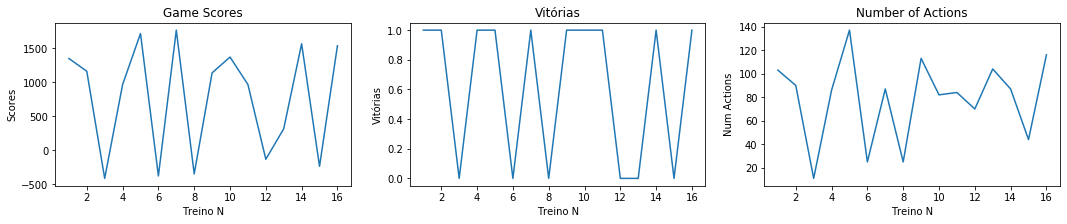

Wins:  10  Loss:  6


In [6]:
fig = plt.figure(figsize=(18, 3))
plt.subplot(131)
plt.xlabel('Treino N')
plt.ylabel('Scores')
plt.title('Game Scores')
plt.plot(range(1,len(gamesScores)+1),gamesScores[:])

plt.subplot(132)
plt.xlabel('Treino N')
plt.ylabel('Vitórias')
plt.title('Vitórias')
plt.plot(range(1,len(gamesScores)+1),results[:])

plt.subplot(133)
plt.xlabel('Treino N')
plt.ylabel('Num Actions')
plt.title('Number of Actions')
plt.plot(range(1,len(gamesScores)+1),numActions[:])
plt.show()

print("Wins: ",results.count(True)," Loss: ",results.count(False))

In [7]:
layoutType='mediumClassic'

gamesScores, results, numActions = approxQLearning(pacman, layoutType,10, pacman.n_train)

layout:  mediumClassic
------------------------------------------ train --------------------
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.006944444444444444 0
STATE VARS:  0.418 -0.00510204081632653 1.0 0.00510204081632653 0
Action Score:  [2.797358001500063, 2.7953729636932034]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.006944444444444444 0
W:  [[1.64979675 0.89898729 2.09821489 0.75651041 0.77810624]]   -  ACTION:  East
STATE VARS:  0.418 -0.005917159763313609 1.0 0.008264462809917356 0
STATE VARS:  0.398 -0.00510204081632653 1.0 0.005917159763313609 0
Action Score:  [2.7887626371738596, 2.754723724529067]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.005917159763313609 1.0 0.008264462809917356 0
W:  [[1.65016636 0.89898206 2.09909912 0.75651772 0.77810624]]   -  ACTION:  East
STATE VARS:  0.418 -0.008264462809917356 1.0 0.01 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.006944444444444444 0
Action Score:  [2.7890042

STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.015625
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.015625
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.027777777777777776
Action Score:  [2.1162561366027415, 0.5294048003925879, 2.1264485782027984]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.027777777777777776
W:  [[1.65009256 0.89898228 2.07027799 0.75216042 0.77773311]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.00390625 0.015625
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.027777777777777776
Action Score:  [2.0820680150539954, 2.1254209104682302]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.027777777777777776
W:  [[1.6500644  0.89898228 2.06871344 0.75215244 0.77768965]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.04
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.02040816326530612

STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
Action Score:  [0.5394917895495838, 2.1631781023821395]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
W:  [[1.65512666 0.8987145  2.04626566 0.75040576 0.77352131]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0625
STATE VARS:  0.018 0 1.0 0 0.25
Action Score:  [0.5566012436663135, 2.2694382678858065]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.25
W:  [[1.65511188 0.8987145  2.04544419 0.75040576 0.77331594]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.25
STATE VARS:  0.018 0 1.0 0 0.25
STATE VARS:  0.418 0 1.0 0 0.01
Action Score:  [0.7013798093616715, 2.2685651906088347, 2.7450141151660765]
['North', 'South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 0 1.0 0 0.01
W:  [[1.65718206 0.8987145  2.05039679 0.75040576 0.77336547]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.015625
STATE VARS:  -0.002 0 1.0 0 0.01
Actio

STATE VARS:  0.398 -0.012345679012345678 1.0 0 0.008264462809917356
STATE VARS:  0.418 -0.008264462809917356 1.0 0 0.005917159763313609
Action Score:  [2.7016808862605455, 2.7367214346167463]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.008264462809917356 1.0 0 0.005917159763313609
W:  [[1.65967879 0.89877425 2.0472616  0.75040576 0.77154442]]   -  ACTION:  West
STATE VARS:  0.418 -0.005917159763313609 1.0 0 0.0044444444444444444
STATE VARS:  0.098 -0.008264462809917356 0.25 0 0.005917159763313609
STATE VARS:  0.418 -0.005917159763313609 1.0 0 0.0044444444444444444
Action Score:  [2.739118229098084, 0.6716013865438643, 2.739118229098084]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.005917159763313609 1.0 0 0.0044444444444444444
W:  [[1.66016864 0.89876731 2.04843348 0.75040576 0.77154963]]   -  ACTION:  South
STATE VARS:  0.398 -0.005917159763313609 1.0 0 0.00510204081632653
STATE VARS:  0.418 -0.0044444444444444444 1.0 0 0.00390625
Action Sco

STATE VARS:  0.398 -0.012345679012345678 1.0 0 0
STATE VARS:  0.042444444444444444 -0.008264462809917356 0.1111111111111111 0 0
Action Score:  [2.7099302561791845, 0.29194223300346156]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.012345679012345678 1.0 0 0
W:  [[1.66816892 0.89865566 2.05465034 0.75040576 0.77153092]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0 0
Action Score:  [2.740850439301617, 0.6660486260509684, 0.6588032289150536, 0.6660486260509684]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
W:  [[1.66768349 0.89867    2.05348902 0.75040576 0.77153092]]   -  ACTION:  North
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
Action Score:  [2.739486033130701, 0.6584650343292221]
['North'

STATE VARS:  0.418 -0.01 1.0 0.015625 0
STATE VARS:  0.098 -0.006944444444444444 0.25 0.01 0
Action Score:  [2.7822165472855156, 0.6850150349381543]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.01 1.0 0.015625 0
W:  [[1.69664928 0.91810046 2.06875833 0.75049402 0.77153092]]   -  ACTION:  North
STATE VARS:  0.418 -0.015625 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.01 0.25 0.012345679012345678 0
Action Score:  [2.778928616135601, 0.6835455661601235]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.015625 1.0 0.02040816326530612 0
W:  [[1.69603673 0.91812336 2.06729288 0.75046412 0.77153092]]   -  ACTION:  North
STATE VARS:  0.418 -0.02040816326530612 1.0 0.015625 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.015625 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.027777777777777776 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.015625 0
Action Score:  [2.769225026685146, 0.6834259658601484, 2.785747605485646, 2.7766273818370526]
['North', 'Sou

STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.008264462809917356 1.0
Action Score:  [0.5967408499817478, 2.8479701177000663]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.008264462809917356 1.0
W:  [[1.69839077 0.91807812 2.04356758 0.74597628 0.77435933]]   -  ACTION:  West
STATE VARS:  0.398 0 0.25 0.006944444444444444 1.0
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.1111111111111111
STATE VARS:  0.418 0 1.0 0.01 0.1111111111111111
Action Score:  [1.966391139997436, 0.5987154298895551, 2.846994608816277]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 0 1.0 0.01 0.1111111111111111
W:  [[1.69883326 0.91807812 2.04462618 0.74598686 0.77447695]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.25
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.25
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.0625
Action Score:  [0.7075432972456297, 0.7075432972456297, 2.1328197032772302]

STATE VARS:  0.018 0 1.0 0 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0 0.04
Action Score:  [2.150572263459217, 0.5360354431742695]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
W:  [[1.70623466 0.91734365 2.03220303 0.7441478  0.77572695]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 1.0
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0 0.1111111111111111
Action Score:  [2.8386422039964656, 2.1491071407193, 0.5908301720464397]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 1.0
W:  [[1.70629258 0.91734365 2.03542068 0.7441478  0.77894459]]   -  ACTION:  North
STATE VARS:  -0.002 -1.0 1.0 0 0
STATE VARS:  -0.002 0 1.0 0 0.25
Action Score:  [1.1146644403972854, 2.2267442424436563]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 1.0 0 0.25
W:  [[1.70630597 0.91734365 2.0287281  0.7441478  0.77727145]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.25
STATE VARS:  0.018 0 

STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0 0
Action Score:  [2.7358318111521207, 0.668109617911867]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
W:  [[1.70775372 0.91619457 2.03160098 0.7441478  0.78456557]]   -  ACTION:  East
STATE VARS:  0.398 -0.012345679012345678 1.0 0 0
STATE VARS:  0.042444444444444444 -0.008264462809917356 0.1111111111111111 0 0
Action Score:  [2.699975915988477, 0.29064624407895034]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.012345679012345678 1.0 0 0
W:  [[1.70691502 0.91622059 2.02949371 0.7441478  0.78456557]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0 0
Action Score:  [2.731672822591407, 0.6670790283213953, 0.6670790283213953, 0.6670790283213953]
['North', 'South', 'East',

STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
STATE VARS:  0.418 -0.04 1.0 0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
Action Score:  [2.753194769214893, 2.7352531106821596, 0.6631227669125186, 0.6631227669125186]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[1.71641917 0.91578928 2.05343498 0.7441478  0.78456557]]   -  ACTION:  North
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
STATE VARS:  0.398 -0.02040816326530612 1.0 0 0
Action Score:  [2.7595921525001477, 2.717880232423956]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
W:  [[1.71684867 0.9157766  2.05446248 0.7441478  0.78456557]]   -  ACTION:  North
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
Action Score:  [0.6631774724339011, 2.760799344296243]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.41

STATE VARS:  0.018 0 1.0 0.001736111111111111 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.008264462809917356
Action Score:  [2.0902405758305203, 0.5170428858581246]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.008264462809917356
W:  [[1.74494687 0.93781818 2.04363209 0.73963528 0.78445133]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.0016 0.005917159763313609
Action Score:  [2.082922373767708, 0.5132432678046224]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.008264462809917356
W:  [[1.74491553 0.93781818 2.0418912  0.73963199 0.78443694]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.005917159763313609
Action Score:  [2.081310796234686, 0.5129086913305603]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.

STATE VARS:  -0.002 0 0.25 0.015625 0.1111111111111111
STATE VARS:  0.418 0 1.0 0.015625 0.04
STATE VARS:  0.018 0 1.0 0.015625 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.1111111111111111
Action Score:  [0.5992690404776305, 2.7878672234836017, 2.1459447511085106, 2.1549320653285102]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 0 1.0 0.015625 0.04
W:  [[1.74338957 0.93781818 2.01319232 0.73948814 0.78536389]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0.02040816326530612 0.04
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.1111111111111111
Action Score:  [2.056211694564195, 2.140965473495299]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.1111111111111111
W:  [[1.74326818 0.93781818 2.00644834 0.73940488 0.78461456]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.015625 0.04
STATE VARS:  0.018 0 1.0 0.01 0.04
STATE VARS:  0.018 0 1.0 0.015625 0.1111111111111111
Action Score:  [0.54106

STATE VARS:  0.018 0 1.0 0 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
Action Score:  [2.029302745876585, 0.5000409487604736]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
W:  [[1.74698616 0.93849015 1.98651264 0.73441563 0.78615786]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
Action Score:  [0.499631361308502, 2.027664048348426]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
W:  [[1.74695932 0.93849015 1.9850214  0.73441563 0.78613945]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.01
STATE VARS:  0.018 0 1.0 0 0.01
STATE VARS:  0.018 0 1.0 0 0.015625
Action Score:  [0.5006228268867928, 2.0243280662726586, 2.028750100673029]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.015625
W:  [[1.74693285 0.93849015 1.98355109 0.73441563 0.78611648]]   -  ACTION:  West
STATE 

STATE VARS:  -0.002 0 0.25 0 0.25
STATE VARS:  0.018 0 1.0 0 0.0625
Action Score:  [0.6845171629422439, 2.0473158563910707]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.0625
W:  [[1.74657735 0.93849015 1.96529317 0.73441563 0.78514801]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.1111111111111111
STATE VARS:  0.018 0 1.0 0 0.04
Action Score:  [0.5750688060233105, 2.0281374844935645]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.04
W:  [[1.74654797 0.93849015 1.96366123 0.73441563 0.78508273]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
Action Score:  [0.5188255220765496, 2.011121194971104]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
W:  [[1.74651915 0.93849015 1.96206021 0.73441563 0.78505006]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.027777777777777776
STATE VARS:  0.018 0 1.0 0 0.015625
Action Score:  [0.508828959667583, 2.00

STATE VARS:  0.042444444444444444 -0.0625 0.1111111111111111 0 0
STATE VARS:  0.014 -0.027777777777777776 0.04 0 0
Action Score:  [0.23393678045096827, 0.07702102572652458]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.042444444444444444 -0.0625 0.1111111111111111 0 0
W:  [[1.7525502  0.9384173  1.9639304  0.73441563 0.78491401]]   -  ACTION:  East
STATE VARS:  0.098 -0.25 0.25 0 0
STATE VARS:  0.023 -0.0625 0.0625 0 0
STATE VARS:  0.098 -0.0625 0.25 0 0
STATE VARS:  0.023 -0.0625 0.0625 0 0
Action Score:  [0.4281281946545361, 0.10440322336337728, 0.604081438140276, 0.10440322336337728]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.098 -0.0625 0.25 0 0
W:  [[1.75281107 0.93825093 1.96459587 0.73441563 0.78491401]]   -  ACTION:  East
STATE VARS:  0.398 -0.0625 1.0 0 0
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0 0
Action Score:  [2.6035739927315777, 0.058122789508566086]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.062

STATE VARS:  0.418 -0.008264462809917356 1.0 0.012345679012345678 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.008264462809917356 0
Action Score:  [2.7301070770289093, 0.6711922974904432]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.012345679012345678 0
W:  [[1.77262928 0.93765245 1.98617594 0.73430319 0.78491401]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.015625 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0.01 0
Action Score:  [2.727032510812086, 0.669855492660953]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.015625 0
W:  [[1.7720348  0.93767001 1.98475372 0.73428097 0.78491401]]   -  ACTION:  North
STATE VARS:  0.418 -0.015625 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.01 0.25 0.012345679012345678 0
Action Score:  [2.7257984926869936, 0.6695363360544959]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.015625 1.0 0.02040816326530612 0
W:  [[1.77144

STATE VARS:  -0.002 0 1.0 0.00510204081632653 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.04
Action Score:  [1.9744825764951826, 2.0266756137789637]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.04
W:  [[1.7738134  0.93765252 1.95688934 0.72953743 0.78456354]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.04
Action Score:  [0.5060029981229834, 2.026229756043493]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.04
W:  [[1.77378675 0.93765252 1.95540879 0.72952519 0.78450432]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.01 0.0625
Action Score:  [0.5121625572095457, 0.5121625572095457, 2.0436637209516553]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE V

STATE VARS:  0.398 -0.02040816326530612 1.0 0.00390625 0.00390625
STATE VARS:  0.398 -0.012345679012345678 1.0 0.0030864197530864196 0.00510204081632653
Action Score:  [2.631118610502466, 2.6390183518496246]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.012345679012345678 1.0 0.0030864197530864196 0.00510204081632653
W:  [[1.77144626 0.93772925 1.94031004 0.72937709 0.78374629]]   -  ACTION:  South
STATE VARS:  0.098 -0.012345679012345678 0.25 0.0034602076124567475 0.00510204081632653
STATE VARS:  0.098 -0.008264462809917356 0.25 0.002770083102493075 0.00510204081632653
STATE VARS:  0.098 -0.008264462809917356 0.25 0.002770083102493075 0.00510204081632653
STATE VARS:  0.418 -0.008264462809917356 1.0 0.0034602076124567475 0.006944444444444444
Action Score:  [0.6536248398189923, 0.6569485546046743, 0.6569485546046743, 2.6809912223952224]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.0034602076124567475 0.0069444

STATE VARS:  0.018 0 1.0 0 0.04
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
Action Score:  [1.9932236220985238, 0.49489592778778746]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.04
W:  [[1.77876086 0.93655983 1.92837515 0.72501611 0.78318513]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.027777777777777776
STATE VARS:  0.018 0 1.0 0 0.0625
Action Score:  [0.5002914070730256, 2.0093419112189927]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.0625
W:  [[1.77873683 0.93655983 1.92704062 0.72501611 0.78310172]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0625
STATE VARS:  0.018 0 1.0 0 0.25
STATE VARS:  0.018 0 1.0 0 0.0625
Action Score:  [0.5271465383930364, 2.154833311249459, 2.008001738619226]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.25
W:  [[1.77872935 0.93655983 1.92662468 0.72501611 0.78299774]]   -  ACTION:  East
STATE VARS:  0.398 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 

STATE VARS:  0.418 -0.027777777777777776 1.0 0 0.012345679012345678
STATE VARS:  0.098 -0.015625 0.25 0 0.008264462809917356
Action Score:  [2.6723499094848098, 0.6523571396987429]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0.012345679012345678
W:  [[1.78803582 0.93941065 1.93978335 0.72501611 0.78210969]]   -  ACTION:  North
STATE VARS:  0.042444444444444444 -0.027777777777777776 0.1111111111111111 0 0.012345679012345678
STATE VARS:  0.014 -0.015625 0.04 0 0.008264462809917356
Action Score:  [0.2749846057398393, 0.09440926070395474]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.042444444444444444 -0.027777777777777776 0.1111111111111111 0 0.012345679012345678
W:  [[1.7872172  0.9399464  1.93764036 0.72501611 0.78187158]]   -  ACTION:  North
STATE VARS:  0.023 -0.015625 0.0625 0 0.01
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0.01
STATE VARS:  -0.002 0 0.0625 0 0.015625
Action Score:  [0.15534057166811138, 0.6412664700410787,

STATE VARS:  0.418 -0.005917159763313609 1.0 0 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0 0
Action Score:  [2.715395227927495, 0.6607682662027748]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.005917159763313609 1.0 0 0
W:  [[1.7990678  0.94071646 1.96733791 0.72501611 0.78191006]]   -  ACTION:  East
STATE VARS:  0.398 -0.00510204081632653 1.0 0 0
STATE VARS:  0.042444444444444444 -0.006944444444444444 0.1111111111111111 0 0
Action Score:  [2.678567318184095, 0.28842078091007395]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.00510204081632653 1.0 0 0
W:  [[1.79823283 0.94072717 1.96523999 0.72501611 0.78191006]]   -  ACTION:  East
STATE VARS:  0.098 -0.00510204081632653 0.25 0 0
STATE VARS:  0.418 -0.006944444444444444 1.0 0 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0 0
STATE VARS:  0.098 -0.006944444444444444 0.25 0 0
Action Score:  [0.662737185160709, 2.7103684802742927, 0.662737185160709, 0.6610039860154834]
['North', 'South', 'East', 'Wes

STATE VARS:  0.418 -0.006944444444444444 1.0 0.04 0
STATE VARS:  0.398 -0.01 1.0 0.02040816326530612 0
Action Score:  [2.7524091292064474, 2.6990831651768077]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.006944444444444444 1.0 0.04 0
W:  [[1.81295125 0.94064032 1.97340985 0.72492849 0.78191006]]   -  ACTION:  East
STATE VARS:  0.418 -0.005917159763313609 1.0 0.0625 0
STATE VARS:  0.418 -0.005917159763313609 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0.027777777777777776 0
Action Score:  [2.770965585047235, 2.745794456951898, 0.6833847007730847]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.005917159763313609 1.0 0.0625 0
W:  [[1.8124144  0.94064792 1.97212553 0.72484822 0.78191006]]   -  ACTION:  South
STATE VARS:  0.398 -0.008264462809917356 1.0 0.04 0
STATE VARS:  0.418 -0.005917159763313609 1.0 0.1111111111111111 0
Action Score:  [2.714686441988969, 2.8046874780259774]
['North', 'South', 'Stop']
-- epsilon:  0
S

STATE VARS:  -0.002 0 0.25 0.01 0.25
STATE VARS:  0.018 0 1.0 0.015625 0.0625
Action Score:  [0.6838782044576955, 2.0329324851190536]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.015625 0.0625
W:  [[1.81420925 0.94061479 1.93873622 0.71989508 0.78092359]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.04
Action Score:  [0.5767125193232182, 2.017320670521791]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.04
W:  [[1.81418055 0.94061479 1.93714147 0.71986254 0.7808598 ]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.015625 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.015625 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.015625 0.04
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.02040816326530612
Action Score:  [1.996980489124264, 1.996980489124264, 0.5231392513997668, 2.0057288185604185]
['North', 'South', 'East', 'West', 'Stop']
-- epsi

STATE VARS:  0.018 0 1.0 0 0.04
STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  -0.002 0 0.25 0 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0 0.04
Action Score:  [1.9759665576054042, 0.5056101097757337, 0.5610945194688757, 0.5056101097757337]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.04
W:  [[1.81366831 0.94061479 1.91064903 0.71920359 0.78019107]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0 0.04
Action Score:  [1.9592173220943616, 0.5052425625958142]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
W:  [[1.8136374  0.94061479 1.90893166 0.71920359 0.78015602]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
Action Score:  [0.48952719116071236, 1.9512086870189986]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
W:  [[1.81361074 0.94061479 1.9

STATE VARS:  -0.402 -1.0 0.25 0 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
Action Score:  [-1.196064699545751, 2.5495803184877266]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
W:  [[1.8161884  0.93980256 1.89639962 0.71920359 0.79173473]]   -  ACTION:  West
STATE VARS:  -0.402 -1.0 0.25 0 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
Action Score:  [-1.1958103900132695, 2.5511438713110564]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
W:  [[1.81673832 0.93965638 1.89771522 0.71920359 0.79173473]]   -  ACTION:  West
STATE VARS:  -0.402 -1.0 0.25 0 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
Action Score:  [-1.1955563816857644, 2.552705572257713]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
W:  [[1.81728771 0.93951034 1.89902955 0.71920359 0.79173473]]   -  ACTION:  West
STATE VARS:  -0.402 -1.0 0.25 0 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0


STATE VARS:  0.018 0 1.0 0.002066115702479339 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.0025 0.008264462809917356
Action Score:  [1.9063868815392375, 0.46917095414775556, 1.9085550628358412]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0025 0.008264462809917356
W:  [[1.85320886 0.97756841 1.86547449 0.71445564 0.79161558]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.0022675736961451248 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.01
Action Score:  [1.8688854812828772, 1.908727504524165]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.01
W:  [[1.85318399 0.97756841 1.86409289 0.71445181 0.79160176]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.01
STATE VARS:  0.018 0 1.0 0.0025 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.0025 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.00308641975308

STATE VARS:  -0.002 0 1.0 0.0625 0.1111111111111111
STATE VARS:  0.418 0 1.0 0.027777777777777776 0.005917159763313609
Action Score:  [1.969719037430898, 2.6397464120648304]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 0 1.0 0.027777777777777776 0.005917159763313609
W:  [[1.85311096 0.97756841 1.84159692 0.71412068 0.79224155]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.04 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.0044444444444444444
Action Score:  [0.48994565609822655, 1.8930478868659446]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.0044444444444444444
W:  [[1.85297877 0.97756841 1.8342529  0.7139708  0.79220891]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.027777777777777776 0.00510204081632653
STATE VARS:  0.018 0 1.0 0.015625 0.00390625
Action Score:  [0.4787316713433277, 1.8818568757571923]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.015625 0.00390625
W:  [[1.8

STATE VARS:  -0.002 0 1.0 1.0 0.02040816326530612
STATE VARS:  0.042444444444444444 -0.012345679012345678 0.1111111111111111 0.25 0
Action Score:  [2.576574157024893, 0.4512751382572567]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 1.0 1.0 0.02040816326530612
W:  [[1.85878096 0.9793323  1.83953073 0.70919442 0.79202367]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0 0.012345679012345678
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
Action Score:  [0.4659431894818347, 1.889152531263386]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
W:  [[1.85865736 0.9793323  1.83266403 0.70919442 0.79188353]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0 0.015625
Action Score:  [1.8881166278700305, 0.4668218731332865]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[1.85862973 0.9793323  1.83112925 0.70919442 0.7918409 ]]   -  ACTION:  East
STAT

STATE VARS:  -0.002 0 1.0 0 0.01
STATE VARS:  -0.002 0 1.0 0 0.01
Action Score:  [1.8136588285787862, 1.8136588285787862]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 1.0 0 0.01
W:  [[1.85819916 0.9793323  1.80770861 0.70919442 0.79023766]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0 0.01
Action Score:  [1.846643951545059, 0.45474164270118783, 0.4536985144749486, 0.45611312955168676]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
W:  [[1.85817703 0.9793323  1.80647917 0.70919442 0.79022912]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
Action Score:  [1.8446022694676347, 0.454434257856629]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
W:  [[1.8

STATE VARS:  0.014 -0.002770083102493075 0.04 0 0
STATE VARS:  0.006163265306122449 -0.0034602076124567475 0.02040816326530612 0 0
Action Score:  [0.09578962764080892, 0.045041920606852345]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.014 -0.002770083102493075 0.04 0 0
W:  [[1.86449103 0.97899268 1.80997639 0.70919442 0.78982929]]   -  ACTION:  East
STATE VARS:  0.023 -0.0034602076124567475 0.0625 0 0
STATE VARS:  0.009111111111111111 -0.0034602076124567475 0.027777777777777776 0 0
Action Score:  [0.15261929998586882, 0.06387718888278468]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.023 -0.0034602076124567475 0.0625 0 0
W:  [[1.86450036 0.97899128 1.81000173 0.70919442 0.78982929]]   -  ACTION:  North
STATE VARS:  0.042444444444444444 -0.0044444444444444444 0.1111111111111111 0 0
STATE VARS:  0.014 -0.0034602076124567475 0.04 0 0
Action Score:  [0.2758979123900553, 0.09511556097110414]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.042444444444444444 -0.0

Pacman emerges victorious! Score: 1539
Average Score: 1539.0
Scores:        1539.0
Win Rate:      1/1 (1.00)
Record:        Win
[[1.89180762 0.97884947 1.84733968 0.70919442 0.78982929]]
1539.0
------------------------------------------ train --------------------
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.006944444444444444 0
STATE VARS:  0.418 -0.00510204081632653 1.0 0.00510204081632653 0
Action Score:  [2.6386897877668436, 2.6367394775334847]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.006944444444444444 0
W:  [[1.88614849 0.97890964 1.83380109 0.7091004  0.78982929]]   -  ACTION:  East
STATE VARS:  0.418 -0.005917159763313609 1.0 0.008264462809917356 0
STATE VARS:  0.398 -0.00510204081632653 1.0 0.005917159763313609 0
Action Score:  [2.6222791287667637, 2.5836896132295566]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.005917159763313609 1.0 0.008264462809917356 0
W:  [[1.88654763 0.97890399 1.83475598 0.70910829 0.789

STATE VARS:  -0.002 0 1.0 0.00390625 0.25
STATE VARS:  0.818 -0.027777777777777776 1.0 0.00510204081632653 0.0044444444444444444
Action Score:  [2.0064193161162343, 3.333559115778845]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.818 -0.027777777777777776 1.0 0.00510204081632653 0.0044444444444444444
W:  [[1.89858217 0.97852755 1.82428548 0.70417034 0.78942891]]   -  ACTION:  West
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0044444444444444444 0.00390625
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0044444444444444444 0.00510204081632653
STATE VARS:  0.098 -0.027777777777777776 0.25 0.0044444444444444444 0.00390625
STATE VARS:  0.418 -0.0625 1.0 0.005917159763313609 0.00510204081632653
Action Score:  [2.5969248584114233, 2.5978688502576928, 0.6211644543539305, 2.5649292417078837]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0044444444444444444 0.00510204081632653
W:  [[1.89665109 0.97865588 1.81966566 0.7041498  

STATE VARS:  0.098 -0.0625 0.25 0.01 0.015625
STATE VARS:  0.018 0 1.0 0.015625 0.027777777777777776
Action Score:  [0.6046563209406822, 1.9061721467115758]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.015625 0.027777777777777776
W:  [[1.90455875 0.9779339  1.8320391  0.70417332 0.7894541 ]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.027777777777777776
STATE VARS:  0.098 -0.027777777777777776 0.25 0.012345679012345678 0.015625
Action Score:  [1.902621326974583, 0.638520421559517]
['North', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.027777777777777776
W:  [[1.90454496 0.9779339  1.8312726  0.70415768 0.78943281]]   -  ACTION:  North
STATE VARS:  0.418 -0.0625 1.0 0.027777777777777776 0.04
STATE VARS:  0.098 -0.027777777777777776 0.25 0.015625 0.02040816326530612
Action Score:  [2.617388771817298, 0.644412062784207]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0625 1.0 0.027777777777777776 

STATE VARS:  0.042444444444444444 -0.015625 0.1111111111111111 0.25 0
STATE VARS:  -0.002 0 1.0 1.0 0.01
Action Score:  [0.448310956734149, 2.5573047705282446]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 1.0 1.0 0.01
W:  [[1.91511996 0.97668335 1.83515467 0.70164126 0.78904326]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0 0.012345679012345678
Action Score:  [1.8761478490201382, 0.4646997026405586]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
W:  [[1.91499457 0.97668335 1.8281885  0.70164126 0.78898569]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
Action Score:  [0.45973767808292637, 1.867326954024881]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
W:  [[1.914969   0.97668335 1.82676807 0.70164126 0.78897728]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0

STATE VARS:  -0.002 0 0.25 0 0.015625
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0.01
Action Score:  [0.4636598210757508, 2.6103397007247047]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0.01
W:  [[1.9207479  0.97709053 1.82798322 0.70164126 0.78702248]]   -  ACTION:  West
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0.012345679012345678
STATE VARS:  0.418 -0.04 1.0 0 0.008264462809917356
Action Score:  [0.635004802716844, 2.5982765380512634]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.04 1.0 0 0.008264462809917356
W:  [[1.92123649 0.97704378 1.82915209 0.70164126 0.78703214]]   -  ACTION:  West
STATE VARS:  0.098 -0.04 0.25 0 0.008264462809917356
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0.005917159763313609
Action Score:  [0.6129918457624102, 2.5283255201780084]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0.005917159763313609
W:  [[1.9215549  0.97695914 1.82991382 0.70164126 0.

STATE VARS:  0.042444444444444444 -0.0625 0.1111111111111111 0 0
STATE VARS:  0.014 -0.027777777777777776 0.04 0 0
Action Score:  [0.22542254161835387, 0.07352379533096118]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.042444444444444444 -0.0625 0.1111111111111111 0 0
W:  [[1.92899826 0.97749767 1.84187789 0.70164126 0.78700601]]   -  ACTION:  North
STATE VARS:  0.098 -0.0625 0.25 0 0
STATE VARS:  0.023 -0.027777777777777776 0.0625 0 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
STATE VARS:  0.023 -0.027777777777777776 0.0625 0 0
Action Score:  [0.5884176977817004, 0.13233161506397473, 0.6223585891857166, 0.13233161506397473]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
W:  [[1.9292787  0.97741818 1.84259329 0.70164126 0.78700601]]   -  ACTION:  East
STATE VARS:  0.398 -0.015625 1.0 0 0
STATE VARS:  0.042444444444444444 -0.027777777777777776 0.1111111111111111 0 0
Action Score:  [2.5951740539611956, 0.25946

STATE VARS:  0.418 -0.01 1.0 0.012345679012345678 0
STATE VARS:  0.098 -0.006944444444444444 0.25 0.008264462809917356 0
Action Score:  [2.679648888276469, 0.6565204273270643]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.01 1.0 0.012345679012345678 0
W:  [[1.95032477 0.97730462 1.86390027 0.70151995 0.78700601]]   -  ACTION:  East
STATE VARS:  0.418 -0.015625 1.0 0.015625 0
STATE VARS:  0.098 -0.01 0.25 0.01 0
Action Score:  [2.67482689018469, 0.6543490486742458]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.015625 1.0 0.015625 0
W:  [[1.9497419  0.97732641 1.86250583 0.70149816 0.78700601]]   -  ACTION:  North
STATE VARS:  0.418 -0.02040816326530612 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.012345679012345678 0
Action Score:  [2.6718687985680787, 0.6532958772676174]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.02040816326530612 0
W:  [[1.94916625 0.97735452 1.86112867 0.7014700

STATE VARS:  0.418 -0.015625 1.0 0.00390625 0
STATE VARS:  0.398 -0.027777777777777776 1.0 0.00510204081632653 0
Action Score:  [2.651501925349414, 2.6013918596437673]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.015625 1.0 0.00390625 0
W:  [[1.95103726 0.97740021 1.84223458 0.69618553 0.7939608 ]]   -  ACTION:  North
STATE VARS:  0.098 -0.027777777777777776 0.25 0.0044444444444444444 0
STATE VARS:  0.418 -0.015625 1.0 0.0044444444444444444 0
Action Score:  [0.6277044496466002, 2.645590438475814]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.015625 1.0 0.0044444444444444444 0
W:  [[1.9515306  0.97738177 1.84341482 0.69619078 0.7939608 ]]   -  ACTION:  West
STATE VARS:  0.098 -0.027777777777777776 0.25 0.00390625 0
STATE VARS:  0.418 -0.015625 1.0 0.00510204081632653 0
Action Score:  [0.627673705321202, 2.647435013729488]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.015625 1.0 0.00510204081632653 0
W:  [[1.95204926 0.97736238 1.844655

STATE VARS:  -0.002 0 0.25 0 0.012345679012345678
STATE VARS:  -0.002 0 0.1111111111111111 0 0.02040816326530612
Action Score:  [0.4652145912027736, 0.21642895616298738]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 0.25 0 0.012345679012345678
W:  [[1.95935986 0.97705577 1.83439504 0.69350012 0.7936221 ]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.1111111111111111 0 0.012345679012345678
STATE VARS:  -0.002 0 1.0 0 0.008264462809917356
Action Score:  [0.20970075536720628, 1.8370351831717326]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 1.0 0 0.008264462809917356
W:  [[1.95934088 0.97705577 1.84388398 0.69350012 0.79370052]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.01
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
STATE VARS:  0.018 0 1.0 0 0.01
STATE VARS:  -0.002 0 0.25 0 0.006944444444444444
Action Score:  [0.46498931822493605, 1.8846639241721777, 1.887089120204448, 0.4625641221926658]
['North', 'South', 'East', 'West', 'Stop']
-- epsilo

STATE VARS:  0.014 -0.012345679012345678 0.04 0 0
STATE VARS:  0.042444444444444444 -0.008264462809917356 0.1111111111111111 0 0
Action Score:  [0.08946329063188051, 0.2810081129739731]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.042444444444444444 -0.008264462809917356 0.1111111111111111 0 0
W:  [[1.96797209 0.9797371  1.85032649 0.69350012 0.796113  ]]   -  ACTION:  West
STATE VARS:  0.098 -0.008264462809917356 0.25 0 0
STATE VARS:  0.023 -0.008264462809917356 0.0625 0 0
Action Score:  [0.6473458876460854, 0.1528117631790378]
['North', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.098 -0.008264462809917356 0.25 0 0
W:  [[1.96822658 0.97971564 1.8509757  0.69350012 0.796113  ]]   -  ACTION:  North
STATE VARS:  0.398 -0.008264462809917356 1.0 0 0
STATE VARS:  0.042444444444444444 -0.005917159763313609 0.1111111111111111 0 0
Action Score:  [2.6262330558340707, 0.28340711650987593]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.008264462809917356 1.0 0 0
W:  [

STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
Action Score:  [2.7014413654272476, 0.640248344336266]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[1.98400825 0.9795849  1.89048372 0.69350012 0.796113  ]]   -  ACTION:  East
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
Action Score:  [2.699807640201607, 0.6398430469463576]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[1.98342768 0.97961324 1.8890948  0.69350012 0.796113  ]]   -  ACTION:  East
STATE VARS:  0.418 -0.04 1.0 0 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
Action Score:  [2.6789830461400665, 0.6394381350490681]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.04 1.0 0 0
W:  [[1.9827899  0.97967427 1.88756902 0.69350012 0.796113  ]]   -  ACTION:  East
STATE VARS:  0.398 -0.1111111111111111 1.0 0 0
STATE VARS:  

STATE VARS:  0.398 -0.02040816326530612 1.0 0 0
STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0 0
Action Score:  [2.6759137710772034, 0.2567911875588149]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.02040816326530612 1.0 0 0
W:  [[1.99530381 0.98017679 1.91865173 0.69350012 0.796113  ]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
Action Score:  [2.7405877736356015, 0.6631017576398094, 0.6551990977066131]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
W:  [[1.99493134 0.98018779 1.91776065 0.69350012 0.796113  ]]   -  ACTION:  North
STATE VARS:  0.418 -0.008264462809917356 1.0 0 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0 0
Action Score:  [2.7435412251688827, 0.6628423501484902]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.008264462809917356 1.0 0 0
W:  [[1.994

STATE VARS:  0.018 0 1.0 0.002066115702479339 0.0625
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.027777777777777776
Action Score:  [1.9875535760677336, 0.49434795325135067]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.0625
W:  [[2.00733473 0.98013448 1.89865883 0.68788048 0.7954778 ]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.04
Action Score:  [2.024737100193504, 0.5037694920215671]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.1111111111111111
W:  [[2.00731064 0.98013448 1.89732051 0.68787744 0.7953291 ]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.04
STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.04
STATE VARS:  0.018 0 1.0 0.0025 0.1111111111111111
Action Score:  [1.9666865012528016, 0.5035499049527102, 2.0235416965331035]
['North', 'South', 'West', 'Stop']
-- epsilon: 

STATE VARS:  0.018 0 1.0 0.0025 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.01
Action Score:  [1.9549157066597, 0.483970031173687]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0025 0.006944444444444444
W:  [[2.00637949 0.98005178 1.90361946 0.68787974 0.79742527]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.002770083102493075 0.01
Action Score:  [1.9468317857952198, 0.48177184316628735]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.006944444444444444
W:  [[2.00635    0.98005178 1.90198132 0.68787603 0.7974139 ]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.0025 0.008264462809917356
Action Score:  [1.9442352816160602, 0.47979251872659634]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.005917159763313609
W:  [[2.006

STATE VARS:  0.418 -0.02040816326530612 1.0 0.015625 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.01 0
Action Score:  [2.7593255521824713, 0.6738210176572724]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.015625 0
W:  [[2.01559769 0.97985273 1.92433977 0.68797041 0.80253012]]   -  ACTION:  South
STATE VARS:  0.098 -0.02040816326530612 0.25 0.012345679012345678 0
STATE VARS:  0.418 -0.04 1.0 0.02040816326530612 0
Action Score:  [0.6671099848194603, 2.741705713276]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.04 1.0 0.02040816326530612 0
W:  [[2.01601974 0.97981234 1.92534945 0.68799101 0.80253012]]   -  ACTION:  South
STATE VARS:  0.098 -0.04 0.25 0.015625 0
STATE VARS:  0.418 -0.04 1.0 0.015625 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.015625 0
STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
Action Score:  [0.6504646629032808, 2.7396030674210436, 2.6699275229618156, 2.747964069299649]
['North', 'South', 'East', '

STATE VARS:  -0.402 -1.0 0.25 0 0.008264462809917356
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0.012345679012345678
STATE VARS:  0.098 -0.1111111111111111 0.25 0 0.008264462809917356
Action Score:  [-1.3034338226707454, 2.675796658013862, 0.5783717888434994]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0.012345679012345678
W:  [[2.01952557 0.98008213 1.92133863 0.68244648 0.80563064]]   -  ACTION:  East
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0.012345679012345678
STATE VARS:  -0.402 -1.0 0.25 0 0.008264462809917356
Action Score:  [2.666548361042675, -1.3049386460568733]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0.012345679012345678
W:  [[2.01725866 0.98068471 1.91591541 0.68244648 0.80556369]]   -  ACTION:  East
STATE VARS:  0.398 -0.1111111111111111 1.0 0 0.015625
STATE VARS:  -0.402 -1.0 0.1111111111111111 0 0.01
Action Score:  [2.622406317180709, -1.570687565472198]
['East', 'West', '

STATE VARS:  0.418 -0.012345679012345678 1.0 0 0.006944444444444444
STATE VARS:  0.098 -0.008264462809917356 0.25 0 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0 0.01
STATE VARS:  0.418 -0.008264462809917356 1.0 0 0.006944444444444444
Action Score:  [2.7808264931503754, 0.6811130005299311, 0.4886385725298083, 2.7848377646575595]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.008264462809917356 1.0 0 0.006944444444444444
W:  [[2.03124865 0.98284858 1.94018532 0.68244648 0.80534506]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0 0.008264462809917356
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
Action Score:  [1.9427785709948027, 1.9815131550935787]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
W:  [[2.03110703 0.98284858 1.93231752 0.68244648 0.80529851]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
STATE VARS:  0.018 0 1.0 0 0.0059171

STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  1.418 -0.02040816326530612 1.0 0 0
Action Score:  [0.6703443098515063, 0.6510886542066177, 4.8377094238092395]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  1.418 -0.02040816326530612 1.0 0 0
W:  [[2.07750753 0.98234468 1.98504544 0.68244648 0.80533999]]   -  ACTION:  West
Pacman emerges victorious! Score: 1942
Average Score: 1942.0
Scores:        1942.0
Win Rate:      1/1 (1.00)
Record:        Win
[[2.07750753 0.98234468 1.98504544 0.68244648 0.80533999]]
1942.0
------------------------------------------ train --------------------
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.006944444444444444 0
STATE VARS:  0.418 -0.00510204081632653 1.0 0.00510204081632653 0
Action Score:  [2.853816823829074, 2.851913495656281]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.006944444444444444 0
W:  [[2.07131687 0.9824105  1.97023524 0.68234363 0.

STATE VARS:  0.098 -0.00510204081632653 0.25 0.002066115702479339 0.0044444444444444444
STATE VARS:  0.418 -0.006944444444444444 1.0 0.0025 0.005917159763313609
Action Score:  [0.6926245990008754, 2.824322093975792]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.006944444444444444 1.0 0.0025 0.005917159763313609
W:  [[2.07619307 0.98241984 1.95043593 0.67633732 0.80467385]]   -  ACTION:  West
STATE VARS:  0.098 -0.006944444444444444 0.25 0.0022675736961451248 0.00510204081632653
STATE VARS:  0.418 -0.01 1.0 0.002770083102493075 0.006944444444444444
Action Score:  [0.6898926672849487, 2.815921959721993]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.01 1.0 0.002770083102493075 0.006944444444444444
W:  [[2.07662113 0.98240959 1.95145999 0.67634016 0.80468097]]   -  ACTION:  West
STATE VARS:  0.098 -0.01 0.25 0.0025 0.005917159763313609
STATE VARS:  0.418 -0.015625 1.0 0.0030864197530864196 0.008264462809917356
Action Score:  [0.6880020489546346, 2.812875199

STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
STATE VARS:  0.018 0 1.0 0 0.04
Action Score:  [0.49975125257183595, 2.019951642370881]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.04
W:  [[2.09253252 0.980267   1.94868988 0.673385   0.80363554]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
Action Score:  [0.5151328261486557, 2.0756483013180644]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
W:  [[2.09251324 0.980267   1.94761893 0.673385   0.80351655]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0625
STATE VARS:  0.018 0 1.0 0 0.25
Action Score:  [0.5329394909753735, 2.186163308230883]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.25
W:  [[2.09250027 0.980267   1.94689812 0.673385   0.80333635]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.25
STATE VARS:  0.018 0 1.0 0 0.25
STATE VARS:  0.418 0 1.0 0 0.006944444444444444
Actio

STATE VARS:  0.042444444444444444 -0.0030864197530864196 0.1111111111111111 0 0.002770083102493075
STATE VARS:  0.398 -0.0025 1.0 0 0.0022675736961451248
Action Score:  [0.3054519915587836, 2.7892400650986557]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.0025 1.0 0 0.0022675736961451248
W:  [[2.10764673 0.9802189  1.97346356 0.673385   0.80336654]]   -  ACTION:  South
STATE VARS:  0.098 -0.0030864197530864196 0.25 0 0.002770083102493075
STATE VARS:  0.098 -0.0030864197530864196 0.25 0 0.002770083102493075
STATE VARS:  0.418 -0.0030864197530864196 1.0 0 0.002770083102493075
STATE VARS:  0.098 -0.0025 0.25 0 0.0022675736961451248
Action Score:  [0.6991152939527309, 0.6991152939527309, 2.8536599153504074, 0.6992864144326242]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0030864197530864196 1.0 0 0.002770083102493075
W:  [[2.10723559 0.98022193 1.97247999 0.673385   0.80336382]]   -  ACTION:  East
STATE VARS:  0.418 -0.00390625 1.0 0 0.0

STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
STATE VARS:  0.098 -0.04 0.25 0 0
Action Score:  [2.7600440536055633, 0.6643436190127521]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
W:  [[2.11183129 0.97678882 1.98411773 0.673385   0.80325402]]   -  ACTION:  East
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
STATE VARS:  0.098 -0.04 0.25 0 0
Action Score:  [2.758331121857309, 0.6639173470658413]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
W:  [[2.11123089 0.97694841 1.98268136 0.673385   0.80325402]]   -  ACTION:  East
STATE VARS:  0.398 -0.1111111111111111 1.0 0 0
STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0 0
Action Score:  [2.7144014347150054, 0.2708300150194762]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.1111111111111111 1.0 0 0
W:  [[2.1103619  0.97719101 1.98049796 0.673385   0.80325402]]   -  ACTION:  East
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
STATE V

STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
STATE VARS:  0.098 -0.04 0.25 0 0
Action Score:  [2.883167967123771, 0.6729025583401166]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[2.12352271 0.97666057 2.01366482 0.673385   0.80325402]]   -  ACTION:  North
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
Action Score:  [0.6724550091472039, 2.8813654700688396]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[2.12395095 0.97663966 2.01468931 0.673385   0.80325402]]   -  ACTION:  West
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
Action Score:  [0.6727539344875196, 2.8825693869881324]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[2.12438883 0.97661828 2.01573689 0.673385   0.80325402]]   -  ACTION:  West
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
STATE VARS:  0.418 -0.01

STATE VARS:  0.398 -0.012345679012345678 1.0 0.04 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.1111111111111111 0
Action Score:  [2.915919901990941, 3.010971963697285]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.1111111111111111 0
W:  [[2.16025008 0.97701126 2.04269353 0.67330397 0.80325402]]   -  ACTION:  South
STATE VARS:  0.098 -0.008264462809917356 0.25 0.0625 0
STATE VARS:  0.418 -0.005917159763313609 1.0 0.25 0
Action Score:  [0.7563849162836382, 3.108222928431367]
['North', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.005917159763313609 1.0 0.25 0
W:  [[2.16093369 0.97700158 2.04432896 0.67371283 0.80325402]]   -  ACTION:  East
STATE VARS:  0.418 -0.00510204081632653 1.0 1.0 0
STATE VARS:  0.098 -0.006944444444444444 0.25 0.1111111111111111 0
Action Score:  [3.6163273707756938, 0.7909259900297347]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.00510204081632653 1.0 1.0 0
W:  [[2.1617512  0.9769916  2.0462847

STATE VARS:  0.023 -0.02040816326530612 0.0625 0.002066115702479339 0.00390625
STATE VARS:  0.023 -0.02040816326530612 0.0625 0.002066115702479339 0.00390625
STATE VARS:  0.098 -0.04 0.25 0.0025 0.00510204081632653
Action Score:  [0.16084707070579815, 0.16084707070579815, 0.6847870040537298]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.098 -0.04 0.25 0.0025 0.00510204081632653
W:  [[2.1635932  0.97768336 2.02541564 0.66662529 0.80277798]]   -  ACTION:  West
STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0.0022675736961451248 0.0044444444444444444
STATE VARS:  0.398 -0.04 1.0 0.002770083102493075 0.005917159763313609
Action Score:  [0.3020054961158064, 2.8540151717998254]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.04 1.0 0.002770083102493075 0.005917159763313609
W:  [[2.17085853 0.97695317 2.04367025 0.66667585 0.802886  ]]   -  ACTION:  West
STATE VARS:  0.098 -0.02040816326530612 0.25 0.0030864197530864196 0.00444444444

STATE VARS:  0.098 -0.02040816326530612 0.25 0.0625 0.00390625
STATE VARS:  0.418 -0.02040816326530612 1.0 0.25 0.0030864197530864196
Action Score:  [0.7526699602979404, 3.117005644912529]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.25 0.0030864197530864196
W:  [[2.17741339 0.97666786 2.05935172 0.66739846 0.80297949]]   -  ACTION:  West
STATE VARS:  0.098 -0.02040816326530612 0.25 0.1111111111111111 0.00390625
STATE VARS:  0.418 -0.04 1.0 1.0 0.0030864197530864196
Action Score:  [0.7855844685799281, 3.6003205983809643]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.04 1.0 1.0 0.0030864197530864196
W:  [[2.17922344 0.97649465 2.06368198 0.67172873 0.80299285]]   -  ACTION:  West
STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0.25 0.0034602076124567475
STATE VARS:  -0.002 0 1.0 1.0 0.1111111111111111
Action Score:  [0.4534448441967775, 2.8202736936386748]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 1

STATE VARS:  0.098 -0.012345679012345678 0.25 0 0
STATE VARS:  0.023 -0.008264462809917356 0.0625 0 0
Action Score:  [0.7135798661689696, 0.17006379266890734]
['North', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.098 -0.012345679012345678 0.25 0 0
W:  [[2.18291047 0.97663207 2.04766405 0.66321613 0.80355621]]   -  ACTION:  North
STATE VARS:  0.398 -0.012345679012345678 1.0 0 0
STATE VARS:  0.042444444444444444 -0.008264462809917356 0.1111111111111111 0 0
Action Score:  [2.9044052272005176, 0.3120993100882144]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.012345679012345678 1.0 0 0
W:  [[2.18909644 0.97644019 2.06320668 0.66321613 0.80355621]]   -  ACTION:  North
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0 0
Action Score:  [2.9661941746330545, 0.7222633674674498, 2.9661941746330545, 0.7222633674674498]
['North', 'Sout

STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0 0
STATE VARS:  0.398 -0.04 1.0 0 0
Action Score:  [0.301386496451283, 2.887886653859643]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.04 1.0 0 0
W:  [[2.19368729 0.97666366 2.07528342 0.66321613 0.80355621]]   -  ACTION:  South
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
STATE VARS:  0.098 -0.04 0.25 0 0
Action Score:  [0.694735663497424, 2.8837265245656374, 0.694735663497424]
['North', 'South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
W:  [[2.19303677 0.97683658 2.07372716 0.66321613 0.80355621]]   -  ACTION:  South
STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0 0
STATE VARS:  0.398 -0.1111111111111111 1.0 0 0
Action Score:  [0.28442289322803543, 2.838018397394319]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.1111111111111111 1.0 0 0
W:  [[2.19325484 0.9767757  2.07427508 0.66321613 0.8

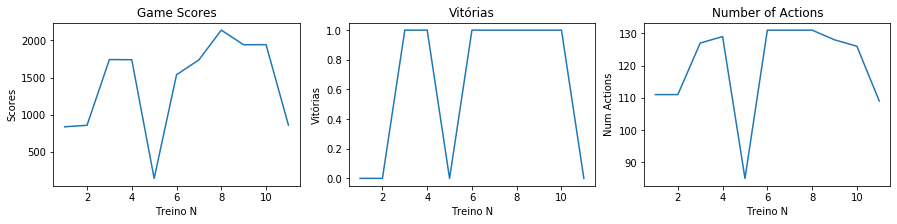

Wins:  7  Loss:  4


In [8]:
fig = plt.figure(figsize=(15, 3))
plt.subplot(131)
plt.xlabel('Treino N')
plt.ylabel('Scores')
plt.title('Game Scores')
plt.plot(range(1,len(gamesScores)+1),gamesScores[:])

plt.subplot(132)
plt.xlabel('Treino N')
plt.ylabel('Vitórias')
plt.title('Vitórias')
plt.plot(range(1,len(gamesScores)+1),results[:])

plt.subplot(133)
plt.xlabel('Treino N')
plt.ylabel('Num Actions')
plt.title('Number of Actions')
plt.plot(range(1,len(gamesScores)+1),numActions[:])
plt.show()

print("Wins: ",results.count(True)," Loss: ",results.count(False))

In [9]:
layoutType='originalClassic'
# pacman.setIsTrain(False)
gamesScores, results, numActions = approxQLearning(pacman, layoutType,10,pacman.n_train)

layout:  originalClassic
------------------------------------------ train --------------------
STATE VARS:  0.418 -0.0011890606420927466 1.0 0.0025 0
STATE VARS:  0.418 -0.0011111111111111111 1.0 0.0022675736961451248 0
Action Score:  [2.9818737157061443, 2.9817976397753423]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0011890606420927466 1.0 0.0025 0
W:  [[2.22565823 1.00155582 2.07816489 0.66327377 0.80355621]]   -  ACTION:  East
STATE VARS:  0.418 -0.0011890606420927466 1.0 0.0022675736961451248 0
STATE VARS:  0.418 -0.001040582726326743 1.0 0.002770083102493075 0
STATE VARS:  0.398 -0.001040582726326743 1.0 0.0022675736961451248 0
Action Score:  [3.0088031419846812, 3.0092851522150346, 2.964438686271363]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.001040582726326743 1.0 0.002770083102493075 0
W:  [[2.2260745  1.00155479 2.07916075 0.66327653 0.80355621]]   -  ACTION:  East
STATE VARS:  0.418 -0.0009765625 1.0 0.0030864197530864196 0
STATE

STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0034602076124567475
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.002770083102493075
Action Score:  [2.095688546631837, 0.5116986536483321]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0034602076124567475
W:  [[2.22185866 1.00155963 2.05006798 0.65828176 0.80350719]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.0016 0.0034602076124567475
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.0044444444444444444
Action Score:  [0.5119068300540348, 2.094876967467063]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.0044444444444444444
W:  [[2.22183097 1.00155963 2.04852959 0.65827885 0.80350035]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.00390625
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.00510204081632653
Action Score:  [0.5119702528528206, 2.0939821146583126]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.

STATE VARS:  0.018 0 1.0 0.0025 0.25
STATE VARS:  -0.002 0 1.0 0.002066115702479339 0.0625
Action Score:  [2.2594421682275616, 2.0641921876376177]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0025 0.25
W:  [[2.22124822 1.00155963 2.01615438 0.65820916 0.80263997]]   -  ACTION:  North
STATE VARS:  0.398 0 1.0 0.002770083102493075 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.25
Action Score:  [2.9184148722132637, 0.7017486290856572]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 0 1.0 0.002770083102493075 0.02040816326530612
W:  [[2.2224108  1.00155963 2.01907543 0.65821725 0.80269958]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.04
STATE VARS:  -0.002 0 0.25 0.0025 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.0025 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.0025 0.02040816326530612
Action Score:  [2.093218341918068, 0.5183512030822114, 0.5183512030822114, 0.5183512030822114]
['North', 'Sout

STATE VARS:  -0.002 0 1.0 1.0 0.002770083102493075
STATE VARS:  0.398 -0.0034602076124567475 1.0 0.25 0
Action Score:  [2.658823065953147, 3.0487844591351436]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.0034602076124567475 1.0 0.25 0
W:  [[2.22443843 1.00153455 1.99792592 0.65869269 0.80457876]]   -  ACTION:  South
STATE VARS:  0.098 -0.0034602076124567475 0.25 1.0 0
STATE VARS:  0.418 -0.0034602076124567475 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.0044444444444444444 0.25 0.1111111111111111 0
Action Score:  [1.3727036181689274, 2.997463741264655, 0.7862132577276185]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0034602076124567475 1.0 0.1111111111111111 0
W:  [[2.22359217 1.00154155 1.99590138 0.65846774 0.80457876]]   -  ACTION:  South
STATE VARS:  0.098 -0.0044444444444444444 0.25 0.25 0
STATE VARS:  0.418 -0.0034602076124567475 1.0 0.0625 0
Action Score:  [0.8770530179751974, 2.963051602312028]
['North', 'South', 'Stop']
-- epsilo

STATE VARS:  0.009111111111111111 -0.00510204081632653 0.027777777777777776 0.25 0
STATE VARS:  -0.002 0 0.015625 1.0 0.006944444444444444
Action Score:  [0.23625175511746735, 0.6927972742006926]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 0.015625 1.0 0.006944444444444444
W:  [[2.2315259  1.00119144 2.01501677 0.63637569 0.80441344]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.02040816326530612 0.0011111111111111111 0.00510204081632653
STATE VARS:  -0.002 0 0.02040816326530612 0.0012755102040816326 0.006944444444444444
Action Score:  [0.041470973740710744, 0.04305764756620991]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 0.02040816326530612 0.0012755102040816326 0.006944444444444444
W:  [[2.2315364  1.00119144 2.01490966 0.63636899 0.80437699]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.015625 0.0011890606420927466 0.005917159763313609
STATE VARS:  -0.002 0 0.027777777777777776 0.0013717421124828531 0.008264462809917356
Action Score:  [0.0325361

STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.01
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.015625
Action Score:  [0.5083489902487085, 2.061921624236813]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.015625
W:  [[2.2310858  1.00119144 2.00236122 0.63627788 0.8074326 ]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.01
STATE VARS:  0.018 0 1.0 0.01 0.015625
Action Score:  [0.5086210559728136, 2.0614996782349504]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.01 0.015625
W:  [[2.23105865 1.00119144 2.00085265 0.6362628  0.80740903]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.02040816326530612
Action Score:  [0.5109774269740562, 2.0653445324928894]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.02040816326530612
W:  [[2.23103205 1.00119144 1.99937513 0.63624456 0.80

STATE VARS:  0.398 -0.0625 1.0 0.015625 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.01 0
Action Score:  [2.83954598782797, 2.9156033599988427]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.01 0
W:  [[2.24118425 1.00284642 2.00181545 0.63605553 0.80837513]]   -  ACTION:  South
STATE VARS:  0.098 -0.027777777777777776 0.25 0.012345679012345678 0
STATE VARS:  0.418 -0.015625 1.0 0.008264462809917356 0
Action Score:  [0.7000856126225145, 2.928217653625426]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.015625 1.0 0.008264462809917356 0
W:  [[2.24164503 1.0028292  2.00291779 0.63606464 0.80837513]]   -  ACTION:  South
STATE VARS:  0.098 -0.015625 0.25 0.01 0
STATE VARS:  0.418 -0.01 1.0 0.01 0
STATE VARS:  0.418 -0.01 1.0 0.006944444444444444 0
Action Score:  [0.711102101787733, 2.936257771655971, 2.934314240798185]
['North', 'South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.01 1.0 0.01 0
W:  [[2.24208783 1.0028186

STATE VARS:  0.098 -0.0625 0.25 0.002066115702479339 0
STATE VARS:  0.398 -0.25 1.0 0.0025 0
Action Score:  [0.6565693173300354, 2.636038625634452]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.25 1.0 0.0025 0
W:  [[2.23773827 1.00272563 1.99353319 0.63613422 0.80837513]]   -  ACTION:  West
STATE VARS:  -1.382 -1.0 1.0 0.0022675736961451248 0
STATE VARS:  0.098 -0.25 0.25 0.0022675736961451248 0
STATE VARS:  0.098 -0.25 0.25 0.002770083102493075 0
Action Score:  [-2.1003042477089737, 0.46844272099383133, 0.46876238442419915]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.098 -0.25 0.25 0.002770083102493075 0
W:  [[2.2360792  1.00695794 1.98930089 0.63608733 0.80837513]]   -  ACTION:  West
STATE VARS:  -1.402 -1.0 1.0 0.0025 0
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0.0030864197530864196 0
Action Score:  [-2.151049878817522, 0.06616631931672604]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.042444444444444444 -0.25 0.111111111

STATE VARS:  0.098 -0.005917159763313609 0.25 0.006944444444444444 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.01 0
Action Score:  [0.7184561039971467, 2.9362290890101717]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.01 0
W:  [[2.24127559 1.00304557 2.00249488 0.63612444 0.80837513]]   -  ACTION:  West
STATE VARS:  0.098 -0.008264462809917356 0.25 0.008264462809917356 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.008264462809917356 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.012345679012345678 0
Action Score:  [0.7172363223376741, 0.7195907742504921, 2.938911834138337]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.012345679012345678 0
W:  [[2.24169959 1.00303718 2.00350921 0.63613697 0.80837513]]   -  ACTION:  West
STATE VARS:  0.042444444444444444 -0.005917159763313609 0.1111111111111111 0.01 0
STATE VARS:  0.398 -0.008264462809917356 1.0 0.015625 0
Action Score:  [0.3181860666533

STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.04
Action Score:  [0.5141878149598789, 0.5139498304142661, 2.076941645483144]
['North', 'South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.04
W:  [[2.24551086 1.00300429 2.00198935 0.63089785 0.80854525]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0625
STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.027777777777777776
Action Score:  [2.0940379312484363, 0.5197694137188472]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0625
W:  [[2.24548288 1.00300429 2.00043489 0.63089515 0.8084481 ]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.01 0.0016 0.0625
STATE VARS:  -0.002 0 0.006944444444444444 0.001890359168241966 0.027777777777777776
Action Score:  [0.067050821332678, 0.033050453163022075]
['East', 'West', '

STATE VARS:  -0.002 0 0.25 0.0008163265306122449 0.00510204081632653
STATE VARS:  0.018 0 1.0 0.0007304601899196494 0.005917159763313609
Action Score:  [0.5022814051212559, 2.054179509356862]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0007304601899196494 0.005917159763313609
W:  [[2.24670189 1.00300429 2.00696848 0.63087869 0.81165898]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0007716049382716049 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.0006925207756232687 0.008264462809917356
Action Score:  [0.5025382204674675, 2.054553933314253]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0006925207756232687 0.008264462809917356
W:  [[2.24667495 1.00300429 2.00547183 0.63087766 0.81164661]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0007304601899196494 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.0006574621959237344 0.01
Action Score:  [0.5029718732446762, 2.054443222905362]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0

STATE VARS:  0.098 -0.027777777777777776 0.25 0.0006574621959237344 0
STATE VARS:  0.418 -0.015625 1.0 0.000594883997620464 0
Action Score:  [0.6979486562089809, 2.944797578422187]
['North', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.015625 1.0 0.000594883997620464 0
W:  [[2.25400499 1.00216568 2.01919353 0.63087816 0.81092733]]   -  ACTION:  East
STATE VARS:  0.418 -0.01 1.0 0.0005668934240362812 0
STATE VARS:  0.098 -0.015625 0.25 0.000625 0
Action Score:  [2.9517036023195375, 0.7104263322889948]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.01 1.0 0.0005668934240362812 0
W:  [[2.25336874 1.0021809  2.01767142 0.6308773  0.81092733]]   -  ACTION:  East
STATE VARS:  -0.0013055555555555557 -0.006944444444444444 0.001736111111111111 0.0005408328826392645 0
STATE VARS:  -0.0011735537190082645 -0.01 0.002066115702479339 0.000594883997620464 0
Action Score:  [-0.006057386715706211, -0.008122216868372804]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0013

STATE VARS:  0.0007777777777777776 -0.0044444444444444444 0.006944444444444444 0.001040582726326743 0
STATE VARS:  4.081632653061229e-05 -0.005917159763313609 0.00510204081632653 0.0009182736455463728 0
Action Score:  [0.01196556550938086, 0.005034277683257353]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.0007777777777777776 -0.0044444444444444444 0.006944444444444444 0.001040582726326743 0
W:  [[2.25339968 1.00234513 2.0176305  0.63086452 0.81092733]]   -  ACTION:  North
STATE VARS:  0.0013057851239669422 -0.0044444444444444444 0.008264462809917356 0.0011111111111111111 0
STATE VARS:  0.0003668639053254439 -0.005917159763313609 0.005917159763313609 0.0009765625 0
Action Score:  [0.015863181308889505, 0.007450375353302688]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.0013057851239669422 -0.0044444444444444444 0.008264462809917356 0.0011111111111111111 0
W:  [[2.25339971 1.00234503 2.01763067 0.63086454 0.81092733]]   -  ACTION:  North
STATE VARS:  0.001305785123

STATE VARS:  0.023 -0.0034602076124567475 0.0625 0.002770083102493075 0
STATE VARS:  0.098 -0.002770083102493075 0.25 0.0034602076124567475 0
Action Score:  [0.17684555620057293, 0.7272094673602233]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.098 -0.002770083102493075 0.25 0.0034602076124567475 0
W:  [[2.25718227 1.00201729 2.02739323 0.6308416  0.81092733]]   -  ACTION:  West
STATE VARS:  0.042444444444444444 -0.002770083102493075 0.1111111111111111 0.0030864197530864196 0
STATE VARS:  0.398 -0.0022675736961451248 1.0 0.00390625 0
Action Score:  [0.320242132765985, 2.9259438507359903]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.0022675736961451248 1.0 0.00390625 0
W:  [[2.26451865 1.00197549 2.04582635 0.6309136  0.81092733]]   -  ACTION:  West
STATE VARS:  0.418 -0.0022675736961451248 1.0 0.0034602076124567475 0
STATE VARS:  0.098 -0.0022675736961451248 0.25 0.0034602076124567475 0
STATE VARS:  0.098 -0.002770083102493075 0.25 0.0044444444444444444 0
Acti

STATE VARS:  0.042444444444444444 -0.002066115702479339 0.1111111111111111 0.0044444444444444444 0
STATE VARS:  0.398 -0.0025 1.0 0.005917159763313609 0
Action Score:  [0.3228049213957685, 2.936031826288387]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.0025 1.0 0.005917159763313609 0
W:  [[2.26748069 1.00196784 2.05375067 0.63098257 0.81092733]]   -  ACTION:  West
STATE VARS:  0.098 -0.002066115702479339 0.25 0.00510204081632653 0
STATE VARS:  0.098 -0.002066115702479339 0.25 0.00510204081632653 0
STATE VARS:  0.418 -0.0025 1.0 0.006944444444444444 0
Action Score:  [0.7367998927519148, 0.7367998927519148, 3.0034345035547916]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0025 1.0 0.006944444444444444 0
W:  [[2.26809953 1.00196414 2.05523114 0.63099285 0.81092733]]   -  ACTION:  West
STATE VARS:  0.098 -0.002066115702479339 0.25 0.005917159763313609 0
STATE VARS:  0.418 -0.0025 1.0 0.008264462809917356 0
Action Score:  [0.737745051663199, 3.00600

STATE VARS:  0.009111111111111111 -0.006944444444444444 0.027777777777777776 0.012345679012345678 0
STATE VARS:  0.00425 -0.01 0.015625 0.008264462809917356 0
STATE VARS:  0.00425 -0.006944444444444444 0.015625 0.012345679012345678 0
Action Score:  [0.07870210035221607, 0.03701110801185028, 0.042652981911580866]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.009111111111111111 -0.006944444444444444 0.027777777777777776 0.012345679012345678 0
W:  [[2.26958134 1.00221612 2.05850065 0.63205478 0.81092733]]   -  ACTION:  North
STATE VARS:  0.014 -0.00510204081632653 0.04 0.015625 0
STATE VARS:  0.006163265306122449 -0.006944444444444444 0.02040816326530612 0.01 0
Action Score:  [0.11887667303881308, 0.05535896287169377]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.014 -0.00510204081632653 0.04 0.015625 0
W:  [[2.2695852  1.00221471 2.05851167 0.63205908 0.81092733]]   -  ACTION:  North
STATE VARS:  0.023 -0.0044444444444444444 0.0625 0.02040816326530612 0
STAT

STATE VARS:  0.006163265306122449 -0.00510204081632653 0.02040816326530612 0.012345679012345678 0
STATE VARS:  0.014 -0.006944444444444444 0.04 0.02040816326530612 0
Action Score:  [0.05902906457908116, 0.12073259288606275]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.014 -0.006944444444444444 0.04 0.02040816326530612 0
W:  [[2.27550001 1.00217153 2.07335705 0.63217598 0.81092733]]   -  ACTION:  West
STATE VARS:  0.023 -0.006944444444444444 0.0625 0.015625 0
STATE VARS:  0.009111111111111111 -0.01 0.027777777777777776 0.015625 0
STATE VARS:  0.009111111111111111 -0.006944444444444444 0.027777777777777776 0.015625 0
STATE VARS:  0.009111111111111111 -0.006944444444444444 0.027777777777777776 0.027777777777777776 0
Action Score:  [0.18483954143839976, 0.07818161941239433, 0.08124381019743539, 0.08892650444234176]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.023 -0.006944444444444444 0.0625 0.015625 0
W:  [[2.27551008 1.00216849 2.07338442 0.63218283 

STATE VARS:  0.418 -0.0014792899408284023 1.0 0.012345679012345678 0
STATE VARS:  0.098 -0.0012755102040816326 0.25 0.008264462809917356 0
Action Score:  [3.046324013162771, 0.7491211650713728]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0014792899408284023 1.0 0.012345679012345678 0
W:  [[2.2953373  1.00185047 2.0783702  0.65113602 0.81092733]]   -  ACTION:  East
STATE VARS:  0.418 -0.0014792899408284023 1.0 0.015625 0
STATE VARS:  0.098 -0.0012755102040816326 0.25 0.01 0
Action Score:  [3.0465131613456236, 0.7497690943775688]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0014792899408284023 1.0 0.015625 0
W:  [[2.29464689 1.00185291 2.0767185  0.65111022 0.81092733]]   -  ACTION:  North
STATE VARS:  0.418 -0.0016 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.0013717421124828531 0.25 0.012345679012345678 0
Action Score:  [3.0475658987154812, 0.750719134067417]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0016 1.0 0.02040816326530

STATE VARS:  0.018 0 1.0 0.006944444444444444 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.00510204081632653 0.008264462809917356
Action Score:  [2.095408408251244, 0.5166002968740453]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.005917159763313609
W:  [[2.29641758 1.00184325 2.0430827  0.6457849  0.81078757]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.008264462809917356
Action Score:  [2.0953857556244526, 0.51669977712856]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.006944444444444444
W:  [[2.29638712 1.00184325 2.04139021 0.64577091 0.81077582]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.01 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.005917159763313609
Action Score:  [2.0958835186130518, 0.5150367897074077]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018

STATE VARS:  -0.002 0 0.25 0.0016 0.01
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.015625
Action Score:  [0.5061882778754565, 2.0618280899974777]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.015625
W:  [[2.2971218  1.00184325 2.00510857 0.64401153 0.81009416]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.1111111111111111 0.001736111111111111 0.015625
STATE VARS:  -0.002 0 1.0 0.002066115702479339 0.027777777777777776
Action Score:  [0.23197139464540603, 2.0243475474883263]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 1.0 0.002066115702479339 0.027777777777777776
W:  [[2.29712567 1.00184325 2.00317325 0.64400753 0.8100404 ]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.04
Action Score:  [0.5139479036120

STATE VARS:  0.418 -0.02040816326530612 1.0 0.002770083102493075 0.01
STATE VARS:  0.098 -0.04 0.25 0.0034602076124567475 0.015625
Action Score:  [2.96687869727477, 0.704197434439646]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.002770083102493075 0.01
W:  [[2.30471963 1.00136972 2.01215993 0.64400081 0.80951055]]   -  ACTION:  North
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0025 0.008264462809917356
STATE VARS:  0.098 -0.04 0.25 0.0030864197530864196 0.012345679012345678
Action Score:  [2.9633967869317526, 0.7008293309397258]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0025 0.008264462809917356
W:  [[2.30404474 1.00140267 2.01054535 0.64399677 0.80949721]]   -  ACTION:  North
STATE VARS:  0.098 -0.04 0.25 0.002770083102493075 0.008264462809917356
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0022675736961451248 0.005917159763313609
Action Score:  [0.6968506002914401, 2.9594494997389376]
['South'

STATE VARS:  0.418 -0.012345679012345678 1.0 0.0011890606420927466 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.0011890606420927466 0
Action Score:  [2.972256390561816, 0.719366434312887]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0011890606420927466 0
W:  [[2.30671556 1.00160622 2.01775993 0.64398477 0.80938283]]   -  ACTION:  North
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0012755102040816326 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0.0011111111111111111 0
Action Score:  [2.9704229349938442, 0.7229359088477556]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0012755102040816326 0
W:  [[2.30604383 1.00162606 2.01615293 0.64398272 0.80938283]]   -  ACTION:  North
STATE VARS:  0.0007777777777777776 -0.012345679012345678 0.006944444444444444 0.0013717421124828531 0
STATE VARS:  4.081632653061229e-05 -0.008264462809917356 0.00510204081632653 0.0011890606420927466 0
Action Score:  [0.0043

STATE VARS:  0.418 -0.04 1.0 0.008264462809917356 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.008264462809917356 0
STATE VARS:  0.418 -0.04 1.0 0.012345679012345678 0
Action Score:  [2.9752199583541663, 0.6314853938880667, 2.9778485987307577]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.04 1.0 0.012345679012345678 0
W:  [[2.31678642 1.00138774 2.04269213 0.64409474 0.80938283]]   -  ACTION:  West
STATE VARS:  0.398 -0.1111111111111111 1.0 0.01 0
STATE VARS:  0.418 -0.04 1.0 0.015625 0
Action Score:  [2.859948771398386, 2.9811173272028544]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.04 1.0 0.015625 0
W:  [[2.31719825 1.00134833 2.04367739 0.64411014 0.80938283]]   -  ACTION:  West
STATE VARS:  0.098 -0.1111111111111111 0.25 0.012345679012345678 0
STATE VARS:  0.418 -0.04 1.0 0.02040816326530612 0
Action Score:  [0.6346958283369133, 2.985357431940023]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.04 1.0 0.02040816326530612 0

STATE VARS:  0.018 0 1.0 0.001736111111111111 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.04
Action Score:  [2.093128240096317, 0.5371534970372904]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.02040816326530612
W:  [[2.31665556 1.00393575 2.03202114 0.65560792 0.80931296]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.0016 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.0016 0.04
Action Score:  [2.091476861657738, 2.0912864998872123, 0.5367934638371374]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.02040816326530612
W:  [[2.31662492 1.00393575 2.03031874 0.6556047  0.80927821]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0.001736111111111111 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.015625
Action Score:  [2.0493036468476697, 2.0860175194385047]
['North', 'South', 'Stop']
-

STATE VARS:  0.418 -0.0044444444444444444 1.0 0.00510204081632653 0.0030864197530864196
STATE VARS:  0.098 -0.005917159763313609 0.25 0.006944444444444444 0.00390625
Action Score:  [2.9726158101349274, 0.7295311326539169]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.00510204081632653 0.0030864197530864196
W:  [[2.31425772 1.0039503  2.00198057 0.65544155 0.80823471]]   -  ACTION:  East
STATE VARS:  0.418 -0.0034602076124567475 1.0 0.0044444444444444444 0.0030864197530864196
STATE VARS:  0.098 -0.0044444444444444444 0.25 0.005917159763313609 0.0030864197530864196
Action Score:  [2.971274050045701, 0.7292033028073241]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0034602076124567475 1.0 0.0044444444444444444 0.0030864197530864196
W:  [[2.31358735 1.00395585 2.00037682 0.65543443 0.80822976]]   -  ACTION:  South
STATE VARS:  0.098 -0.0034602076124567475 0.25 0.00510204081632653 0.0030864197530864196
STATE VARS:  0.018 0 1.0 0.003

STATE VARS:  0.018 0 1.0 0 0.00390625
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
Action Score:  [2.022650633237282, 0.49392537249360363]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.00390625
W:  [[2.3185968  1.00390283 1.97606937 0.65001875 0.80809147]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
Action Score:  [2.021927027578372, 0.4935030644191177]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
W:  [[2.31856729 1.00390283 1.97443004 0.65001875 0.8080831 ]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
Action Score:  [0.4925618556284965, 2.0209458071426654]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
W:  [[2.31854064 1.00390283 1.97294943 0.65001875 0.80807434]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0051020408163265

STATE VARS:  -0.002 0 0.25 0 0.002770083102493075
STATE VARS:  0.018 0 1.0 0 0.0022675736961451248
Action Score:  [0.486007269285371, 1.9971794465103276]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.0022675736961451248
W:  [[2.31803525 1.00390283 1.9521555  0.65001875 0.80782927]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.0022675736961451248
STATE VARS:  0.018 0 1.0 0 0.002770083102493075
Action Score:  [0.4852346174764107, 1.9961178910652027]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.002770083102493075
W:  [[2.31800895 1.00390283 1.95069412 0.65001875 0.80782522]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.0025
STATE VARS:  0.018 0 1.0 0 0.0030864197530864196
Action Score:  [0.48505707404845133, 1.994911564331022]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.0030864197530864196
W:  [[2.31798264 1.00390283 1.94923254 0.65001875 0.80782071]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.0030864

STATE VARS:  0.042444444444444444 -0.002770083102493075 0.1111111111111111 0 0
STATE VARS:  0.014 -0.0034602076124567475 0.04 0 0
Action Score:  [0.3108576597727311, 0.10646935529278768]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.042444444444444444 -0.002770083102493075 0.1111111111111111 0 0
W:  [[2.31786018 1.00390186 1.93744958 0.65001875 0.80705275]]   -  ACTION:  East
STATE VARS:  0.023 -0.002770083102493075 0.0625 0 0
STATE VARS:  0.098 -0.002770083102493075 0.25 0 0
STATE VARS:  0.023 -0.0034602076124567475 0.0625 0 0
Action Score:  [0.1716204913334149, 0.7087318011317741, 0.17092767405427947]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.098 -0.002770083102493075 0.25 0 0
W:  [[2.31813458 1.0038941  1.93814958 0.65001875 0.80705275]]   -  ACTION:  East
STATE VARS:  0.398 -0.002770083102493075 1.0 0 0
STATE VARS:  0.042444444444444444 -0.0034602076124567475 0.1111111111111111 0 0
Action Score:  [2.8579862752331104, 0.31026820598955207]
['East', 'Wes

STATE VARS:  0.098 -0.0044444444444444444 0.25 0 0
STATE VARS:  0.023 -0.0034602076124567475 0.0625 0 0
Action Score:  [0.709273647358148, 0.17147868746405112]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.098 -0.0044444444444444444 0.25 0 0
W:  [[2.32113901 1.00396025 1.9458668  0.65001875 0.80705275]]   -  ACTION:  North
STATE VARS:  0.398 -0.0044444444444444444 1.0 0 0
STATE VARS:  0.042444444444444444 -0.0034602076124567475 0.1111111111111111 0 0
Action Score:  [2.8652180814938313, 0.3112529671853593]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.0044444444444444444 1.0 0 0
W:  [[2.3272264  1.00389228 1.96116174 0.65001875 0.80705275]]   -  ACTION:  North
STATE VARS:  0.098 -0.0034602076124567475 0.25 0 0
STATE VARS:  0.098 -0.0034602076124567475 0.25 0 0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0 0
Action Score:  [0.714884945399271, 0.714884945399271, 2.929480627274959]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.004444

STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
Action Score:  [0.6859110761291374, 2.9442854550150805]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[2.33842697 1.0018594  1.98863851 0.65001875 0.80705275]]   -  ACTION:  West
STATE VARS:  -0.0013055555555555557 -0.02040816326530612 0.001736111111111111 0 0
STATE VARS:  -0.0011735537190082645 -0.012345679012345678 0.002066115702479339 0 0
Action Score:  [-0.020046559180763326, -0.011004147022519017]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0011735537190082645 -0.012345679012345678 0.002066115702479339 0 0
W:  [[2.33845471 1.00215129 1.98858966 0.65001875 0.80705275]]   -  ACTION:  West
STATE VARS:  -0.0011735537190082645 -0.008264462809917356 0.002066115702479339 0 0
STATE VARS:  -0.0012438563327032135 -0.012345679012345678 0.001890359168241966 0 0
STATE VARS:  -0.00109297052154195 -0.008264462809917356 0.0022675736961451248 0 0
Action Score

STATE VARS:  -0.00022222222222222231 -0.008264462809917356 0.0044444444444444444 0 0
STATE VARS:  0.0003668639053254439 -0.012345679012345678 0.005917159763313609 0 0
Action Score:  [3.627071621527603e-05, 0.00025244888845511217]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.0003668639053254439 -0.012345679012345678 0.005917159763313609 0 0
W:  [[2.33845452 1.00215178 1.98858964 0.65001875 0.80705275]]   -  ACTION:  West
STATE VARS:  4.081632653061229e-05 -0.008264462809917356 0.00510204081632653 0 0
STATE VARS:  0.0007777777777777776 -0.012345679012345678 0.006944444444444444 0 0
Action Score:  [0.0019590665263349606, 0.003256204051793341]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.0007777777777777776 -0.012345679012345678 0.006944444444444444 0 0
W:  [[2.33845454 1.00215144 1.98858983 0.65001875 0.80705275]]   -  ACTION:  West
STATE VARS:  0.0013057851239669422 -0.012345679012345678 0.008264462809917356 0 0
STATE VARS:  0.0003668639053254439 -0.008264462809917356

STATE VARS:  -0.00089196675900277 -0.012345679012345678 0.002770083102493075 0 0
STATE VARS:  -0.0006159169550173009 -0.02040816326530612 0.0034602076124567475 0 0
Action Score:  [-0.00894951528755633, -0.01501144792066057]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.00089196675900277 -0.012345679012345678 0.002770083102493075 0 0
W:  [[2.33845452 1.00215236 1.98858977 0.65001875 0.80705275]]   -  ACTION:  East
STATE VARS:  -0.0007654320987654322 -0.012345679012345678 0.0030864197530864196 0 0
STATE VARS:  -0.001 -0.008264462809917356 0.0025 0 0
STATE VARS:  -0.0007654320987654322 -0.012345679012345678 0.0030864197530864196 0 0
Action Score:  [-0.008024556742321352, -0.005649230991700681, -0.008024556742321352]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.001 -0.008264462809917356 0.0025 0 0
W:  [[2.3384545  1.00215215 1.98858983 0.65001875 0.80705275]]   -  ACTION:  East
STATE VARS:  -0.00109297052154195 -0.005917159763313609 0.0022675736961451248 0 0
S

STATE VARS:  0.002 -0.012345679012345678 0.01 0 0
STATE VARS:  0.00425 -0.02040816326530612 0.015625 0 0
Action Score:  [0.012190577940425232, 0.020558094414833396]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.00425 -0.02040816326530612 0.015625 0 0
W:  [[2.3384548  1.00215076 1.98859123 0.65001875 0.80705275]]   -  ACTION:  West
STATE VARS:  0.0029382716049382715 -0.02040816326530612 0.012345679012345678 0 0
STATE VARS:  0.006163265306122449 -0.04 0.02040816326530612 0 0
Action Score:  [0.010969467992269786, 0.014909981351549868]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.006163265306122449 -0.04 0.02040816326530612 0 0
W:  [[2.33845475 1.00215108 1.98859107 0.65001875 0.80705275]]   -  ACTION:  West
STATE VARS:  0.00425 -0.04 0.015625 0 0
STATE VARS:  0.009111111111111111 -0.1111111111111111 0.027777777777777776 0 0
Action Score:  [0.0009241251921139233, -0.034805557525562615]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.00425 -0.04 0.015625 0 0
W:  [[

STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0 0
Action Score:  [2.9779555871786227, 0.7219581123449305]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[2.34877095 1.00220742 2.01472645 0.65001875 0.80705275]]   -  ACTION:  North
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0 0
Action Score:  [2.9760594975039885, 0.7214882352841833]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[2.34809713 1.00224031 2.01311444 0.65001875 0.80705275]]   -  ACTION:  North
STATE VARS:  0.098 -0.012345679012345678 0.25 0 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
Action Score:  [0.7210187904172342, 2.9741651518561785]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[2.34849402 1.00222094 2.01406395 0.65001875 0.80705275]]   -  ACTION:  West
STATE VARS:  0.098 -0

STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0 0
STATE VARS:  0.398 -0.012345679012345678 1.0 0 0
Action Score:  [0.30356383615884946, 2.9444951082862785]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.012345679012345678 1.0 0 0
W:  [[2.3652118  1.01942774 2.03727695 0.65001875 0.80705275]]   -  ACTION:  South
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
Action Score:  [0.7203053449503196, 0.7285244650570671, 3.0051308299076043]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[2.36580744 1.01939866 2.03870193 0.65001875 0.80705275]]   -  ACTION:  West
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
Action Score:  [0.7207205566485708, 3.0068053829107844]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 

STATE VARS:  0.418 -0.006944444444444444 1.0 0.1111111111111111 0
STATE VARS:  0.398 -0.01 1.0 0.04 0
Action Score:  [3.0992319981581535, 3.002099677694672]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.006944444444444444 1.0 0.1111111111111111 0
W:  [[2.3905146  1.01835395 2.03598842 0.65005446 0.80705275]]   -  ACTION:  North
STATE VARS:  0.418 -0.01 1.0 0.25 0
STATE VARS:  0.098 -0.01 0.25 0.0625 0
Action Score:  [3.187553598085535, 0.7737123999562976]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.01 1.0 0.25 0
W:  [[2.39007174 1.01836455 2.03492895 0.64978959 0.80705275]]   -  ACTION:  North
STATE VARS:  0.098 -0.01 0.25 0.1111111111111111 0
STATE VARS:  0.418 -0.015625 1.0 1.0 0
Action Score:  [0.80497446612393, 3.6678565826803853]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.015625 1.0 1.0 0
W:  [[2.39184914 1.01829811 2.03918109 0.65404173 0.80705275]]   -  ACTION:  East
STATE VARS:  -0.002 0 1.0 1.0 0.027777777777777776
STAT

STATE VARS:  0.018 0 1.0 0.015625 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.015625 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.04
STATE VARS:  0.018 0 1.0 0.015625 0.02040816326530612
Action Score:  [2.0637625234118544, 0.5202506406806041, 2.0873632800190047, 2.0637625234118544]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.04
W:  [[2.39403469 1.01829811 1.99275171 0.64432101 0.80486949]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.04 0.04
STATE VARS:  -0.002 0 1.0 0.02040816326530612 0.02040816326530612
Action Score:  [2.0938119515424933, 2.0175389542436775]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.04 0.04
W:  [[2.39400518 1.01829811 1.99111225 0.64425543 0.80480391]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0625 0.0625
STATE VARS:  -0.002 0 0.25 0.027777777777777776 0.027777777777777776
Action Score:  [2.1247705489969757, 0.5332416997232624]
['East', 'West', 'St

STATE VARS:  0.018 0 1.0 0.0034602076124567475 1.0
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.1111111111111111
Action Score:  [2.8158791507709258, 0.5775529215760519, 2.0965106807099305]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0034602076124567475 1.0
W:  [[2.39569715 1.01829811 1.95848664 0.63763953 0.80792824]]   -  ACTION:  North
STATE VARS:  0.418 0 1.0 0.0030864197530864196 0.02040816326530612
STATE VARS:  -0.002 0 1.0 0.00390625 0.25
Action Score:  [2.97834439904653, 2.158168083187662]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 0 1.0 0.0030864197530864196 0.02040816326530612
W:  [[2.39523778 1.01829811 1.95738768 0.63763614 0.80790581]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.04
Action Score:  [2.018756142923435, 0.5190790314274126]
['North', 'South', 'Stop']


STATE VARS:  0.418 -0.02040816326530612 1.0 0.0011890606420927466 0
STATE VARS:  0.098 -0.04 0.25 0.0013717421124828531 0
Action Score:  [2.93770628509931, 0.6839574789395975]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0011890606420927466 0
W:  [[2.40225094 1.01829385 1.9517295  0.63759936 0.8227953 ]]   -  ACTION:  East
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0011111111111111111 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.0012755102040816326 0
Action Score:  [2.9357973281400827, 0.703384724160872]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0011111111111111111 0
W:  [[2.40159053 1.01832609 1.95014959 0.6375976  0.8227953 ]]   -  ACTION:  East
STATE VARS:  0.418 -0.04 1.0 0.0011890606420927466 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.0011890606420927466 0
Action Score:  [2.9140395324287605, 0.7028692470739067]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.04 1.0 0.00

STATE VARS:  0.098 -0.012345679012345678 0.25 0.001890359168241966 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0016 0
Action Score:  [0.7166927007270345, 2.9552013918237803]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0016 0
W:  [[2.40917726 1.02167528 1.96907945 0.63762058 0.8227953 ]]   -  ACTION:  West
STATE VARS:  0.00425 -0.04 0.015625 0.001736111111111111 0
STATE VARS:  0.0029382716049382715 -0.02040816326530612 0.012345679012345678 0.001736111111111111 0
Action Score:  [0.0012458389245981263, 0.011644904342643932]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.0029382716049382715 -0.02040816326530612 0.012345679012345678 0.001736111111111111 0
W:  [[2.40910811 1.02215557 1.96878891 0.63757972 0.8227953 ]]   -  ACTION:  East
STATE VARS:  0.00425 -0.02040816326530612 0.015625 0.001890359168241966 0
STATE VARS:  0.0029382716049382715 -0.04 0.012345679012345678 0.0016 0
Action Score:  [0.021345973109359963, -0.008481445312554993

STATE VARS:  0.098 -0.25 0.25 0.012345679012345678 0
STATE VARS:  -1.382 -1.0 1.0 0.02040816326530612 0
Action Score:  [0.4879090001404534, -2.358191667690488]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.098 -0.25 0.25 0.012345679012345678 0
W:  [[2.41612227 1.02898873 1.98606517 0.63733921 0.8227953 ]]   -  ACTION:  East
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0.01 0
STATE VARS:  -1.402 -1.0 1.0 0.015625 0
Action Score:  [0.07235108581372876, -2.420368557503758]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0.01 0
W:  [[2.41550265 1.03263831 1.98444313 0.63719323 0.8227953 ]]   -  ACTION:  East
STATE VARS:  0.023 -0.25 0.0625 0.008264462809917356 0
STATE VARS:  -1.402 -1.0 0.25 0.012345679012345678 0
Action Score:  [-0.0733092616120555, -3.915195666920955]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.023 -0.25 0.0625 0.008264462809917356 0
W:  [[2.41521923 1.03571897 1.98367297 0.63709139 0.82

STATE VARS:  0.098 -0.0044444444444444444 0.25 0.1111111111111111 0
STATE VARS:  0.418 -0.005917159763313609 1.0 0.04 0
Action Score:  [0.80746367213139, 3.047073448282195]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.005917159763313609 1.0 0.04 0
W:  [[2.42759936 1.03715597 2.01386096 0.63841737 0.8227953 ]]   -  ACTION:  South
STATE VARS:  0.098 -0.005917159763313609 0.25 0.0625 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.027777777777777776 0
Action Score:  [0.7751340451938542, 3.037759770583399]
['North', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.027777777777777776 0
W:  [[2.42795018 1.03714903 2.01470024 0.63844068 0.8227953 ]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0.04 0
Action Score:  [3.0298085099370162, 0.7585803259137922]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 

STATE VARS:  -0.002 0 0.027777777777777776 0.002066115702479339 0.1111111111111111
STATE VARS:  -0.002 0 0.015625 0.001736111111111111 0.04
Action Score:  [0.14343559675715864, 0.0604301192409115]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 0.027777777777777776 0.002066115702479339 0.1111111111111111
W:  [[2.42460237 1.03730078 2.00621483 0.61657695 0.82154286]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.04 0.0022675736961451248 0.25
STATE VARS:  -0.002 0 0.02040816326530612 0.001890359168241966 0.0625
Action Score:  [0.2821832373665255, 0.08860593578192116]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 0.04 0.0022675736961451248 0.25
W:  [[2.42460063 1.03730078 2.00624956 0.61657892 0.82175992]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.0625 0.0025 0.25
STATE VARS:  -0.002 0 0.027777777777777776 0.002066115702479339 0.0625
Action Score:  [0.32752282342375183, 0.10351387156010683]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 0.0625 0.

STATE VARS:  -0.002 0 0.1111111111111111 0.25 0.00390625
STATE VARS:  -0.002 0 1.0 1.0 0.0030864197530864196
Action Score:  [0.37395426574303314, 2.6059272049143485]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 1.0 1.0 0.0030864197530864196
W:  [[2.42645189 1.03730078 1.9881899  0.61511523 0.82672652]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0034602076124567475
STATE VARS:  0.018 0 1.0 0 0.002770083102493075
Action Score:  [0.49505521537058117, 2.0341561302221822]
['North', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.002770083102493075
W:  [[2.42634286 1.03730078 1.9821324  0.61511523 0.82670974]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.002770083102493075
STATE VARS:  -0.002 0 0.25 0 0.0034602076124567475
Action Score:  [2.0280966276112418, 0.49354100200346385]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.002770083102493075
W:  [[2.42631249 1.03730078 1.98044545 0.61511523 0.82670507]]   -  ACTION:  East
STAT

STATE VARS:  -0.002 0 0.25 0 0.005917159763313609
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
Action Score:  [0.4860041268886696, 1.9924229206077264]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
W:  [[2.42566641 1.03730078 1.9424169  0.61511523 0.82592791]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
Action Score:  [1.9897496881162549, 0.4844236833975913, 1.9909660448072974]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
W:  [[2.42564012 1.03730078 1.94095647 0.61511523 0.82591927]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0 0.00510204081632653
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
Action Score:  [1.9403190677201618, 1.9903535468690614]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
W:  [[2.42561397 1.03730078 1.939

STATE VARS:  0.418 -0.001890359168241966 1.0 0 0
STATE VARS:  0.098 -0.001736111111111111 0.25 0 0
Action Score:  [2.9678189402806865, 0.7248272786782164]
['North', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.001890359168241966 1.0 0 0
W:  [[2.43269932 1.03726965 1.95105129 0.61511523 0.82586013]]   -  ACTION:  North
STATE VARS:  0.418 -0.0022675736961451248 1.0 0 0
STATE VARS:  0.098 -0.001890359168241966 0.25 0 0
Action Score:  [2.9655675241056736, 0.724206544600968]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0022675736961451248 1.0 0 0
W:  [[2.43202782 1.03727329 1.94944483 0.61511523 0.82586013]]   -  ACTION:  North
STATE VARS:  0.098 -0.0022675736961451248 0.25 0 0
STATE VARS:  0.418 -0.002770083102493075 1.0 0 0
Action Score:  [0.7233478395768665, 2.9631591228601804]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.002770083102493075 1.0 0 0
W:  [[2.43242668 1.03727065 1.95039903 0.61511523 0.82586013]]   -  ACTION:  East
STATE VARS:  -

STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
Action Score:  [0.6882320766764269, 2.961066986380446]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[2.43795025 1.03702109 1.96429668 0.61511523 0.82586013]]   -  ACTION:  East
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
Action Score:  [2.9545537392175114, 0.7088295978061443]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
W:  [[2.43726818 1.03706642 1.96266493 0.61511523 0.82586013]]   -  ACTION:  East
STATE VARS:  0.418 -0.0625 1.0 0 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
Action Score:  [2.9166263748507975, 0.7007111128468297]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0625 1.0 0 0
W:  [[2.43649374 1.03718221 1.96081221 0.61511523 0.82586013]]   -  ACTION:  East
STATE VARS:  0.418 -0.25 1.0 0 0
STATE VARS:  0.098 -0.0625 0.25 0 0


STATE VARS:  0.418 -0.00390625 1.0 0 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0 0
Action Score:  [3.0029047481334845, 0.7305414380985962]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.00390625 1.0 0 0
W:  [[2.44548253 1.03861725 1.9828714  0.61511523 0.82586013]]   -  ACTION:  South
STATE VARS:  0.006163265306122449 -0.00390625 0.02040816326530612 0 0
STATE VARS:  0.0029382716049382715 -0.0030864197530864196 0.012345679012345678 0 0
Action Score:  [0.05148182225229961, 0.028459776893801914]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.006163265306122449 -0.00390625 0.02040816326530612 0 0
W:  [[2.4453369  1.03870956 1.98238917 0.61511523 0.82586013]]   -  ACTION:  North
STATE VARS:  0.00425 -0.0034602076124567475 0.015625 0 0
STATE VARS:  0.009111111111111111 -0.0044444444444444444 0.027777777777777776 0 0
Action Score:  [0.03777336195249423, 0.07272961522551655]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.009111111111111111 -0.00444444444

STATE VARS:  -0.00022222222222222231 -0.00510204081632653 0.0044444444444444444 0 0
STATE VARS:  -0.00022222222222222231 -0.005917159763313609 0.0044444444444444444 0 0
STATE VARS:  -0.00022222222222222231 -0.00510204081632653 0.0044444444444444444 0 0
STATE VARS:  0.0003668639053254439 -0.006944444444444444 0.005917159763313609 0 0
Action Score:  [0.003027225967045218, 0.0021773573443849776, 0.003027225967045218, 0.0054975402062039]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.0003668639053254439 -0.006944444444444444 0.005917159763313609 0 0
W:  [[2.45271391 1.04263129 2.00065995 0.61511523 0.82586013]]   -  ACTION:  West
STATE VARS:  4.081632653061229e-05 -0.005917159763313609 0.00510204081632653 0 0
STATE VARS:  0.0007777777777777776 -0.008264462809917356 0.006944444444444444 0 0
Action Score:  [0.0041381435908186, 0.007184350747647811]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.0007777777777777776 -0.008264462809917356 0.006944444444444444 0

STATE VARS:  0.418 -0.0013717421124828531 1.0 0.0022675736961451248 0
STATE VARS:  0.418 -0.0011890606420927466 1.0 0.002770083102493075 0
STATE VARS:  0.398 -0.0011890606420927466 1.0 0.0022675736961451248 0
Action Score:  [3.049876245831943, 3.050375541465147, 3.0005739903582826]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0011890606420927466 1.0 0.002770083102493075 0
W:  [[2.47486225 1.04125291 2.01608795 0.61507046 0.82586013]]   -  ACTION:  East
STATE VARS:  0.418 -0.0011111111111111111 1.0 0.0030864197530864196 0
STATE VARS:  0.398 -0.0012755102040816326 1.0 0.0025 0
Action Score:  [3.051321791145873, 3.001292675706484]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0011111111111111111 1.0 0.0030864197530864196 0
W:  [[2.47517596 1.04125208 2.01683847 0.61507277 0.82586013]]   -  ACTION:  East
STATE VARS:  0.418 -0.001040582726326743 1.0 0.0034602076124567475 0
STATE VARS:  0.098 -0.0011890606420927466 0.25 0.002770083102493075 0
Action 

STATE VARS:  0.018 0 1.0 0.001736111111111111 0.002066115702479339
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.001736111111111111
Action Score:  [2.0347789303996784, 0.4942814828847638]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.002066115702479339
W:  [[2.47027679 1.04126254 1.9858943  0.60900506 0.82582873]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.0016 0.002066115702479339
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.0025
Action Score:  [0.4942136863144704, 2.0335750887592345]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.0025
W:  [[2.47024993 1.04126254 1.98440181 0.60900224 0.82582499]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.0022675736961451248
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.002770083102493075
Action Score:  [0.49408986613759, 2.032412177225968]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.002066115702479339

STATE VARS:  -0.002 0 0.25 0.015625 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.027777777777777776 1.0
STATE VARS:  0.018 0 1.0 0.015625 0.1111111111111111
Action Score:  [0.5842853209442767, 2.837973106891882, 2.0982401387074496]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.027777777777777776 1.0
W:  [[2.47158028 1.04126254 1.95553666 0.60883205 0.82671447]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.04 1.0
STATE VARS:  -0.002 0 1.0 0.02040816326530612 0.1111111111111111
Action Score:  [2.8510928518103817, 2.054875802403809]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.04 1.0
W:  [[2.47154083 1.04126254 1.95334474 0.60874437 0.82452255]]   -  ACTION:  East
STATE VARS:  0.418 0 1.0 0.0625 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.027777777777777776 0.25
Action Score:  [3.041322319314792, 0.7064333072291828]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 0 1.0 0.0625 0.02040816326530612
W:  [[2.47115325 1.04126

STATE VARS:  -0.002 0 1.0 0.005917159763313609 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.008264462809917356
Action Score:  [1.9145641006014669, 1.967328092370924]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.008264462809917356
W:  [[2.47045604 1.04126254 1.9096144  0.60633652 0.82266462]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.01 0.01
Action Score:  [0.48238630812461314, 1.968372624798334]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.01 0.01
W:  [[2.47043044 1.04126254 1.90819206 0.6063223  0.8226504 ]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.01
Action Score:  [1.9644695023949537, 0.48283093288715445, 1.9683717751347052]
['South', 'East', 'West', 'Stop']
-- eps

STATE VARS:  0.398 -0.005917159763313609 1.0 0.02040816326530612 0
STATE VARS:  0.042444444444444444 -0.0044444444444444444 0.1111111111111111 0.04 0
Action Score:  [2.897759225358599, 0.3366028719868464]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.005917159763313609 1.0 0.02040816326530612 0
W:  [[2.47856022 1.04128025 1.90218921 0.60900022 0.8222319 ]]   -  ACTION:  East
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.015625 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.015625 0
STATE VARS:  0.098 -0.0044444444444444444 0.25 0.015625 0
STATE VARS:  0.098 -0.0044444444444444444 0.25 0.027777777777777776 0
Action Score:  [2.9431151008318874, 0.721800411611078, 0.7233339209907736, 0.7307349653779759]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.015625 0
W:  [[2.47805542 1.04128562 1.90098157 0.60898135 0.8222319 ]]   -  ACTION:  North
STATE VARS:  0.418 -0.0034602076124567475 1.0 0.012345679012345678 0
ST

STATE VARS:  0.018 0 1.0 0.0012755102040816326 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.015625
Action Score:  [1.977683901983146, 0.4861248882144597]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0012755102040816326 0.027777777777777776
W:  [[2.47915831 1.04128415 1.90793962 0.58740692 0.82213806]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.04
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.02040816326530612
Action Score:  [1.9861484584497904, 0.48961068796185897]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.04
W:  [[2.47913064 1.04128415 1.90640242 0.5874051  0.82207657]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.0625
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.027777777777777776
Action Score:  [2.0030592312628595, 0.495227045665001]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.0625
W:  

STATE VARS:  0.006163265306122449 -0.0025 0.02040816326530612 0.0006925207756232687 0.0022675736961451248
STATE VARS:  0.0029382716049382715 -0.002066115702479339 0.012345679012345678 0.000625 0.001890359168241966
STATE VARS:  0.0029382716049382715 -0.002066115702479339 0.012345679012345678 0.0006925207756232687 0.001890359168241966
Action Score:  [0.0541780994744727, 0.030776121297278324, 0.030815781754882855]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.006163265306122449 -0.0025 0.02040816326530612 0.0006925207756232687 0.0022675736961451248
W:  [[2.49182792 1.04135735 1.91852031 0.58738161 0.82179914]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.015625 0.0006574621959237344 0.0022675736961451248
STATE VARS:  -0.002 0 0.027777777777777776 0.0007304601899196494 0.002770083102493075
Action Score:  [0.02724289524261879, 0.05101408565274929]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 0.027777777777777776 0.0007304601899196494 0.002770083102493075


STATE VARS:  0.014 -0.01 0.04 0.002066115702479339 0
STATE VARS:  0.014 -0.01 0.04 0.002066115702479339 0
STATE VARS:  0.042444444444444444 -0.015625 0.1111111111111111 0.0025 0
Action Score:  [0.10347198377454052, 0.10347198377454052, 0.3070669610379124]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.042444444444444444 -0.015625 0.1111111111111111 0.0025 0
W:  [[2.50109786 1.04129065 1.94155326 0.58737726 0.82188195]]   -  ACTION:  West
STATE VARS:  0.098 -0.015625 0.25 0.0022675736961451248 0
STATE VARS:  0.023 -0.015625 0.0625 0.0022675736961451248 0
STATE VARS:  0.023 -0.027777777777777776 0.0625 0.002770083102493075 0
Action Score:  [0.715557660061193, 0.16393408437327878, 0.15157467313682238]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.098 -0.015625 0.25 0.0022675736961451248 0
W:  [[2.50138005 1.04124566 1.94227313 0.58738379 0.82188195]]   -  ACTION:  North
STATE VARS:  0.398 -0.015625 1.0 0.002066115702479339 0
STATE VARS:  0.04244444444444

STATE VARS:  0.098 -0.012345679012345678 0.25 0.00510204081632653 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.006944444444444444 0
Action Score:  [0.730977052522902, 3.01156541958745]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.006944444444444444 0
W:  [[2.51573501 1.04113905 1.97819159 0.58746535 0.82188195]]   -  ACTION:  South
STATE VARS:  0.098 -0.02040816326530612 0.25 0.005917159763313609 0
STATE VARS:  0.418 -0.04 1.0 0.008264462809917356 0
STATE VARS:  0.098 -0.04 0.25 0.005917159763313609 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.005917159763313609 0
Action Score:  [0.7233183185720196, 2.992978345724995, 0.7029204922610282, 0.7233183185720196]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.04 1.0 0.008264462809917356 0
W:  [[2.51499971 1.04120941 1.97643251 0.58745081 0.82188195]]   -  ACTION:  South
STATE VARS:  0.098 -0.04 0.25 0.006944444444444444 0
STATE VARS:  0.418 -0.1111111111111111

STATE VARS:  0.418 -0.1111111111111111 1.0 0.00510204081632653 0
STATE VARS:  -0.402 -1.0 0.25 0.006944444444444444 0
Action Score:  [2.9445973831330106, -1.5542916676069967]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.00510204081632653 0
W:  [[2.52302095 1.04428325 1.99632952 0.58704787 0.82188195]]   -  ACTION:  East
STATE VARS:  0.418 -0.04 1.0 0.0044444444444444444 0
STATE VARS:  0.418 -0.04 1.0 0.0044444444444444444 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.005917159763313609 0
Action Score:  [3.011790054102432, 3.011790054102432, 0.6337806184650125]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.04 1.0 0.0044444444444444444 0
W:  [[2.52256621 1.04432676 1.99524163 0.58704303 0.82188195]]   -  ACTION:  South
STATE VARS:  0.398 -0.04 1.0 0.00510204081632653 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.00390625 0
Action Score:  [2.9604450338027473, 3.030654656848356]
['North', 'South', 'Stop']
-- epsilon:  0
S

STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
STATE VARS:  0.098 -0.04 0.25 0.027777777777777776 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.027777777777777776 0
Action Score:  [3.0709843738106772, 0.7220277179835723, 0.7424862064205093]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
W:  [[2.52401585 1.04426765 1.99870966 0.58690354 0.82188195]]   -  ACTION:  North
STATE VARS:  0.418 -0.012345679012345678 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.04 0
Action Score:  [3.1060675969677654, 0.7491955253745265]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.1111111111111111 0
W:  [[2.52342221 1.04428518 1.99728947 0.58674574 0.82188195]]   -  ACTION:  North
STATE VARS:  0.418 -0.008264462809917356 1.0 0.25 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.0625 0
Action Score:  [3.190135936199442, 0.7703969440368479]
['North', 'South', 'Stop']
-- epsilon:

STATE VARS:  -0.002 0 0.0625 0 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
STATE VARS:  -0.002 0 0.0625 0 0.00510204081632653
Action Score:  [0.12273225265746607, 0.48740318049747, 0.12121529591626112]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
W:  [[2.52406428 1.04427077 1.95344005 0.58001616 0.82336638]]   -  ACTION:  East
STATE VARS:  -0.002 0 1.0 0 0.0044444444444444444
STATE VARS:  -0.002 0 0.1111111111111111 0 0.005917159763313609
Action Score:  [1.9520513289840535, 0.21687275647434362]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 1.0 0 0.0044444444444444444
W:  [[2.524044   1.04427077 1.9635796  0.58001616 0.82341145]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0 0.0044444444444444444
Action Score:  [2.0126719939005344, 0.48950641731577055]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.0044444444444444444
W: 

STATE VARS:  0.098 -0.00510204081632653 0.25 0 0
STATE VARS:  0.418 -0.00390625 1.0 0 0
Action Score:  [0.7338277091067488, 3.0184169678526533]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.00390625 1.0 0 0
W:  [[2.53402147 1.04422822 1.96438306 0.58001616 0.8229533 ]]   -  ACTION:  West
STATE VARS:  0.098 -0.00510204081632653 0.25 0 0
STATE VARS:  0.418 -0.00390625 1.0 0 0
Action Score:  [0.7341021748454921, 3.0195250210659843]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.00390625 1.0 0 0
W:  [[2.53441324 1.04422456 1.96532031 0.58001616 0.8229533 ]]   -  ACTION:  West
STATE VARS:  0.418 -0.00390625 1.0 0 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0 0
STATE VARS:  0.418 -0.00390625 1.0 0 0
Action Score:  [3.020626038868145, 0.7343748979068075, 3.020626038868145]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.00390625 1.0 0 0
W:  [[2.53480461 1.0442209  1.96625662 0.58001616 0.8229533 ]]   -  ACTION:  South
STATE VARS:  0.398

STATE VARS:  -0.0006159169550173009 -0.027777777777777776 0.0034602076124567475 0 0
STATE VARS:  -0.00022222222222222231 -0.027777777777777776 0.0044444444444444444 0 0
STATE VARS:  -0.0006159169550173009 -0.0625 0.0034602076124567475 0 0
Action Score:  [-0.023653216726894997, -0.020677136956050376, -0.059923263910387124]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.00022222222222222231 -0.027777777777777776 0.0044444444444444444 0 0
W:  [[2.54997971 1.04457667 2.00375177 0.58001616 0.8229533 ]]   -  ACTION:  East
STATE VARS:  4.081632653061229e-05 -0.027777777777777776 0.00510204081632653 0 0
STATE VARS:  -0.0004375 -0.0625 0.00390625 0 0
Action Score:  [-0.018688714603486013, -0.05857450292233332]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  4.081632653061229e-05 -0.027777777777777776 0.00510204081632653 0 0
W:  [[2.54997971 1.04457591 2.00375191 0.58001616 0.8229533 ]]   -  ACTION:  East
STATE VARS:  0.0003668639053254439 -0.027777777777777776 0.005917159

STATE VARS:  -0.00022222222222222231 -0.02040816326530612 0.0044444444444444444 0 0
STATE VARS:  -0.0006159169550173009 -0.012345679012345678 0.0034602076124567475 0 0
Action Score:  [-0.012978877175594873, -0.00753311709583857]
['North', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0006159169550173009 -0.012345679012345678 0.0034602076124567475 0 0
W:  [[2.5499797  1.04457087 2.003754   0.58001616 0.8229533 ]]   -  ACTION:  East
STATE VARS:  -0.0007654320987654322 -0.008264462809917356 0.0030864197530864196 0 0
STATE VARS:  -0.0004375 -0.012345679012345678 0.00390625 0 0
Action Score:  [-0.0044002275158800275, -0.006184388758383449]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0007654320987654322 -0.008264462809917356 0.0030864197530864196 0 0
W:  [[2.54997968 1.04457067 2.00375408 0.58001616 0.8229533 ]]   -  ACTION:  East
STATE VARS:  -0.00089196675900277 -0.005917159763313609 0.002770083102493075 0 0
STATE VARS:  -0.0006159169550173009 -0.008264462809917356 0.003460207

STATE VARS:  0.0003668639053254439 -0.008264462809917356 0.005917159763313609 0 0
STATE VARS:  0.0013057851239669422 -0.012345679012345678 0.008264462809917356 0 0
Action Score:  [0.0041592181773764435, 0.006993749872856763]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.0013057851239669422 -0.012345679012345678 0.008264462809917356 0 0
W:  [[2.54997972 1.04457027 2.00375445 0.58001616 0.8229533 ]]   -  ACTION:  West
STATE VARS:  0.0007777777777777776 -0.012345679012345678 0.006944444444444444 0 0
STATE VARS:  0.002 -0.02040816326530612 0.01 0 0
Action Score:  [0.003002349768157681, 0.003819743344395745]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.002 -0.02040816326530612 0.01 0 0
W:  [[2.5499797  1.04457052 2.00375433 0.58001616 0.8229533 ]]   -  ACTION:  West
STATE VARS:  0.0029382716049382715 -0.02040816326530612 0.012345679012345678 0 0
STATE VARS:  0.0013057851239669422 -0.02040816326530612 0.008264462809917356 0 0
STATE VARS:  0.0013057851239669422 -0.020408163

STATE VARS:  0.418 -0.0009765625 1.0 0.0034602076124567475 0
STATE VARS:  0.098 -0.0011111111111111111 0.25 0.002770083102493075 0
Action Score:  [3.087644978520265, 0.7554060177023459]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0009765625 1.0 0.0034602076124567475 0
W:  [[2.56924584 1.04436794 2.01074257 0.5799657  0.8229533 ]]   -  ACTION:  East
STATE VARS:  0.418 -0.0009182736455463728 1.0 0.00390625 0
STATE VARS:  0.098 -0.001040582726326743 0.25 0.0030864197530864196 0
Action Score:  [3.08599380588418, 0.7551750010170284]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0009182736455463728 1.0 0.00390625 0
W:  [[2.56853607 1.0443695  2.00904457 0.57995907 0.8229533 ]]   -  ACTION:  East
STATE VARS:  0.418 -0.0009182736455463728 1.0 0.0044444444444444444 0
STATE VARS:  0.098 -0.001040582726326743 0.25 0.0034602076124567475 0
Action Score:  [3.084311222741235, 0.754897702422342]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.00091827364

STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.0034602076124567475
STATE VARS:  0.018 0 1.0 0.0025 0.0044444444444444444
Action Score:  [0.4929811598076818, 2.027568697263828]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0025 0.0044444444444444444
W:  [[2.56464564 1.04437675 1.97482853 0.57337106 0.82288702]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.005917159763313609
Action Score:  [0.49353527744750286, 2.0274495886854265]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.005917159763313609
W:  [[2.56461902 1.04437675 1.97334962 0.57336697 0.82287827]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.0025 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0.0025 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0.0025 0.005917159763313609
Action Score:  [2.026151510835

STATE VARS:  0.418 -0.00390625 1.0 0.00510204081632653 0.0030864197530864196
STATE VARS:  0.098 -0.00510204081632653 0.25 0.00510204081632653 0.00390625
Action Score:  [3.0295203461807008, 0.7411380451885172]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.00390625 1.0 0.00510204081632653 0.0030864197530864196
W:  [[2.56926973 1.04435694 1.9522661  0.57317691 0.82234619]]   -  ACTION:  North
STATE VARS:  0.418 -0.00390625 1.0 0.005917159763313609 0.0030864197530864196
STATE VARS:  0.098 -0.00510204081632653 0.25 0.0044444444444444444 0.00390625
Action Score:  [3.0280710092651564, 0.7402863486899788]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.00390625 1.0 0.005917159763313609 0.0030864197530864196
W:  [[2.56858001 1.04436338 1.95061604 0.57316715 0.82234109]]   -  ACTION:  North
STATE VARS:  0.098 -0.00390625 0.25 0.00510204081632653 0.0034602076124567475
STATE VARS:  0.418 -0.0030864197530864196 1.0 0.006944444444444444 0.002770083102493075
Action S

STATE VARS:  0.018 0 1.0 0.001890359168241966 0.01
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.01
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.01
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.015625
Action Score:  [1.9698750818153534, 0.4827347655938698, 0.4827347655938698, 0.4875721048479721]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.01
W:  [[2.5690715  1.04435281 1.91313194 0.56329758 0.8221842 ]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.01
Action Score:  [1.9660627866527047, 0.4825305219817495]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.006944444444444444
W:  [[2.56904235 1.04435281 1.91151259 0.56329476 0.82217296]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0016 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.008264462809917356
Action 

STATE VARS:  0.014 -0.005917159763313609 0.04 0.0022675736961451248 0.0044444444444444444
STATE VARS:  0.023 -0.008264462809917356 0.0625 0.002770083102493075 0.005917159763313609
Action Score:  [0.11119858499761025, 0.1763784339309187]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.023 -0.008264462809917356 0.0625 0.002770083102493075 0.005917159763313609
W:  [[2.568977   1.0444123  1.91102816 0.56324909 0.82626326]]   -  ACTION:  West
STATE VARS:  0.014 -0.012345679012345678 0.04 0.0025 0.008264462809917356
STATE VARS:  0.014 -0.008264462809917356 0.04 0.0025 0.005917159763313609
STATE VARS:  0.042444444444444444 -0.008264462809917356 0.1111111111111111 0.0030864197530864196 0.005917159763313609
Action Score:  [0.10774957029473739, 0.11007255240949981, 0.31937131242212563]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.042444444444444444 -0.008264462809917356 0.1111111111111111 0.0030864197530864196 0.005917159763313609
W:  [[2.56902912 1.04440215 1.91116461 

STATE VARS:  0.098 -0.0044444444444444444 0.25 1.0 0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.1111111111111111 0
Action Score:  [1.2988686148848407, 3.0808425492268743, 0.7954589634842991]
['North', 'South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.1111111111111111 0
W:  [[2.5813739  1.04411866 1.94148784 0.56439345 0.82640472]]   -  ACTION:  South
STATE VARS:  0.098 -0.0044444444444444444 0.25 0.25 0
STATE VARS:  0.418 -0.0034602076124567475 1.0 0.0625 0
Action Score:  [0.8748044382202478, 3.0521638591481164]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0034602076124567475 1.0 0.0625 0
W:  [[2.58165515 1.04411633 1.94216068 0.5644355  0.82640472]]   -  ACTION:  South
STATE VARS:  0.098 -0.0044444444444444444 0.25 0.1111111111111111 0
STATE VARS:  0.418 -0.0034602076124567475 1.0 0.04 0
Action Score:  [0.7966169142333468, 3.040257097307423]
['North', 'South

STATE VARS:  0.418 -0.0012755102040816326 1.0 0.0022675736961451248 0
STATE VARS:  0.418 -0.0011111111111111111 1.0 0.002770083102493075 0
STATE VARS:  0.398 -0.0011111111111111111 1.0 0.0022675736961451248 0
Action Score:  [3.0298022293022657, 3.0302646684182757, 2.9774763385882204]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0011111111111111111 1.0 0.002770083102493075 0
W:  [[2.62568476 1.09146182 1.93355711 0.56318347 0.82640472]]   -  ACTION:  East
STATE VARS:  0.418 -0.0009765625 1.0 0.0030864197530864196 0
STATE VARS:  0.398 -0.0011111111111111111 1.0 0.0025 0
Action Score:  [3.0317656807234554, 2.9787748688749094]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0009765625 1.0 0.0030864197530864196 0
W:  [[2.62600687 1.09146107 1.93432771 0.56318585 0.82640472]]   -  ACTION:  East
STATE VARS:  0.418 -0.0009765625 1.0 0.0034602076124567475 0
STATE VARS:  0.098 -0.0011111111111111111 0.25 0.002770083102493075 0
Action Score:  [3.03288143792

STATE VARS:  0.018 0 1.0 0.001736111111111111 0.015625
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.01
Action Score:  [1.966228747242216, 0.4801368802898337]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.015625
W:  [[2.62107781 1.0914597  1.90360785 0.55650165 0.82626304]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.0016 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.02040816326530612
Action Score:  [0.48175098757962725, 1.9687017489140461]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.02040816326530612
W:  [[2.62105241 1.0914597  1.90219667 0.55649898 0.82623424]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.04
Action Score:  [0.48813513044504675, 1.9835747761453384]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.04
W:  [[2.62102858 1.091

STATE VARS:  0.018 0 1.0 0.25 0.0044444444444444444
STATE VARS:  0.098 -0.00390625 0.25 0.0625 0.0034602076124567475
Action Score:  [2.0628270629156344, 0.7585717866496952]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.25 0.0044444444444444444
W:  [[2.6222708  1.0914597  1.8727134  0.55586325 0.82831523]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 1.0 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.1111111111111111 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0.1111111111111111 0.005917159763313609
Action Score:  [2.4806788049936794, 0.5283777939120532, 1.9865781344546647]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 1.0 0.005917159763313609
W:  [[2.62229784 1.0914597  1.87421567 0.55736553 0.82832412]]   -  ACTION:  North
STATE VARS:  -0.002 0 1.0 1.0 0.006944444444444444
STATE VARS:  -0.002 0 1.0 0.25 0.00510204081632653
Action Score:  [2.432088853971775, 2.012538602671464]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS

STATE VARS:  -0.002 0 1.0 0.002770083102493075 0.008264462809917356
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.012345679012345678
Action Score:  [1.8532405012288093, 1.908791657829643]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.012345679012345678
W:  [[2.62177125 1.0914597  1.84867861 0.55496228 0.83162328]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0025 0.01
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.015625
Action Score:  [0.4666297492296354, 1.910011225589986]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.015625
W:  [[2.62174652 1.0914597  1.84730436 0.55495944 0.8316018 ]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.02040816326530612
Action Score:  [0.46810769749091014, 1.912516335962243]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.020408

STATE VARS:  0.098 -0.012345679012345678 0.25 0.0014792899408284023 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.001736111111111111 0
Action Score:  [0.7093862651621523, 2.9483956600434933]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.001736111111111111 0
W:  [[2.62803458 1.09082653 1.85914158 0.55496132 0.83645567]]   -  ACTION:  West
STATE VARS:  0.098 -0.008264462809917356 0.25 0.0016 0
STATE VARS:  0.418 -0.005917159763313609 1.0 0.001890359168241966 0
Action Score:  [0.7142056261088069, 2.9522545134984606]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.005917159763313609 1.0 0.001890359168241966 0
W:  [[2.62845804 1.09082054 1.86015465 0.55496324 0.83645567]]   -  ACTION:  West
STATE VARS:  0.418 -0.00510204081632653 1.0 0.002066115702479339 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.001736111111111111 0
Action Score:  [2.954431313865255, 0.7171364678368625]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.

STATE VARS:  0.098 -0.0030864197530864196 0.25 0.0030864197530864196 0
STATE VARS:  0.418 -0.0025 1.0 0.00390625 0
Action Score:  [0.7258270037699697, 2.9778798763454875]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0025 1.0 0.00390625 0
W:  [[2.63562162 1.09082675 1.87789204 0.55498001 0.83645567]]   -  ACTION:  West
STATE VARS:  0.098 -0.0030864197530864196 0.25 0.0034602076124567475 0
STATE VARS:  0.418 -0.0025 1.0 0.0044444444444444444 0
Action Score:  [0.7263175252906916, 2.9793213870923028]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0025 1.0 0.0044444444444444444 0
W:  [[2.63602795 1.09082432 1.87886411 0.55498433 0.83645567]]   -  ACTION:  West
STATE VARS:  0.098 -0.0030864197530864196 0.25 0.00390625 0
STATE VARS:  0.418 -0.0030864197530864196 1.0 0.00510204081632653 0
Action Score:  [0.7268479330983353, 2.980188606923961]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0030864197530864196 1.0 0.00510204081632653 0
W:  [[2.63643

STATE VARS:  0.018 0 1.0 0.002770083102493075 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.0044444444444444444
Action Score:  [1.9098648906577704, 0.4636644901644397]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.005917159763313609
W:  [[2.63711371 1.09071075 1.8543813  0.54857527 0.83490403]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.0025 0.00510204081632653
STATE VARS:  0.018 0 1.0 0.0025 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0.0025 0.00510204081632653
Action Score:  [1.9093404200379978, 1.9074804944554473, 1.9074804944554473, 0.4639522489246651]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.006944444444444444
W:  [[2.63708586 1.09071075 1.85283363 0.5485705  0.83489328]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.006944444444444444
STATE VARS:  -0.00

STATE VARS:  -0.002 0 0.015625 0.0034602076124567475 0.25
STATE VARS:  -0.002 0 0.027777777777777776 0.0044444444444444444 0.0625
Action Score:  [0.23359581387657602, 0.0999266838460699]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 0.015625 0.0034602076124567475 0.25
W:  [[2.63657858 1.09071075 1.82286857 0.54827069 0.83042597]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.02040816326530612 0.00390625 0.1111111111111111
STATE VARS:  -0.002 0 0.012345679012345678 0.0030864197530864196 1.0
Action Score:  [0.1263394766434258, 0.8493495541953763]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 0.012345679012345678 0.0030864197530864196 1.0
W:  [[2.63657012 1.09071075 1.8229208  0.54828375 0.83465652]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.015625 0.0034602076124567475 0.1111111111111111
STATE VARS:  -0.002 0 0.01 0.002770083102493075 1.0
Action Score:  [0.11784678599998122, 0.8491313771868526]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0

STATE VARS:  0.098 -0.00390625 0.25 0.008264462809917356 0
STATE VARS:  0.418 -0.0034602076124567475 1.0 0.012345679012345678 0
Action Score:  [0.7176246834518427, 2.9410849015197775]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0034602076124567475 1.0 0.012345679012345678 0
W:  [[2.64141645 1.09159009 1.83517179 0.5484166  0.83296102]]   -  ACTION:  West
STATE VARS:  0.098 -0.0034602076124567475 0.25 0.01 0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.015625 0
Action Score:  [0.7193587977365297, 2.9430013660241574]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.015625 0
W:  [[2.64183651 1.09158562 1.83617672 0.5484323  0.83296102]]   -  ACTION:  West
STATE VARS:  0.098 -0.0034602076124567475 0.25 0.012345679012345678 0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.02040816326530612 0
Action Score:  [0.720937814977426, 2.946805388563786]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0

STATE VARS:  -0.002 0 0.0625 0 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
Action Score:  [0.11181116854916637, 0.4525575793463178]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
W:  [[2.64498    1.09156322 1.81480473 0.5396328  0.83285896]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.1111111111111111 0 0.0044444444444444444
STATE VARS:  -0.002 0 1.0 0 0.005917159763313609
Action Score:  [0.20005660481408824, 1.8144429245950588]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 1.0 0 0.005917159763313609
W:  [[2.64496115 1.09156322 1.82423225 0.5396328  0.83291474]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
Action Score:  [0.4556966306772821, 0.45765173398851594, 1.876770043789927]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.005917159763313609


STATE VARS:  0.018 0 1.0 0 0.04
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0 0.04
Action Score:  [1.9018038831064952, 1.961026244786656, 0.48324466147379264]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
W:  [[2.64470682 1.09156322 1.8196145  0.5396328  0.83267316]]   -  ACTION:  East
STATE VARS:  -0.382 -1.0 1.0 0 0
STATE VARS:  0.398 -0.1111111111111111 1.0 0 0
Action Score:  [-0.28222671905354324, 2.7509230172504626]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.1111111111111111 1.0 0 0
W:  [[2.64761319 1.09075183 1.82691694 0.5396328  0.83267316]]   -  ACTION:  West
STATE VARS:  0.418 -0.04 1.0 0 0
STATE VARS:  0.398 -0.1111111111111111 1.0 0 0
STATE VARS:  0.098 -0.04 0.25 0 0
Action Score:  [2.8899891803051747, 2.7594723415794107, 0.6725652542998509]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.04 1.0 0 0
W:  [[2.64743953 1.09076845 1.82650148 0.5396328  0.8326

STATE VARS:  -1.402 -1.0 0.1111111111111111 0 0
STATE VARS:  0.398 -0.25 1.0 0 0
Action Score:  [-4.615357473544233, 2.586325104861608]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.25 1.0 0 0
W:  [[2.64935547 1.10804721 1.83128169 0.5396328  0.83267316]]   -  ACTION:  South
STATE VARS:  -1.402 -1.0 0.25 0 0
STATE VARS:  0.098 -0.25 0.25 0 0
STATE VARS:  0.418 -0.25 1.0 0 0
Action Score:  [-4.364623160061664, 0.44044545581583183, 2.6617004762633014]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.25 1.0 0 0
W:  [[2.65011524 1.1075928  1.83309934 0.5396328  0.83267316]]   -  ACTION:  West
STATE VARS:  -1.402 -1.0 0.25 0 0
STATE VARS:  0.418 -0.25 1.0 0 0
Action Score:  [-4.364779542759555, 2.663949307299323]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.25 1.0 0 0
W:  [[2.65062973 1.1072851  1.83433017 0.5396328  0.83267316]]   -  ACTION:  West
STATE VARS:  0.098 -0.25 0.25 0 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
Actio

STATE VARS:  0.002 -0.015625 0.01 0 0
STATE VARS:  0.00425 -0.027777777777777776 0.015625 0 0
Action Score:  [0.006731449800020946, 0.009790245055736065]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.00425 -0.027777777777777776 0.015625 0 0
W:  [[2.66543486 1.10778101 1.87096557 0.5396328  0.83267316]]   -  ACTION:  South
STATE VARS:  0.0029382716049382715 -0.027777777777777776 0.012345679012345678 0 0
STATE VARS:  0.006163265306122449 -0.0625 0.02040816326530612 0 0
Action Score:  [0.00015841716460604158, -0.0146255602314639]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.0029382716049382715 -0.027777777777777776 0.012345679012345678 0 0
W:  [[2.66543478 1.10778179 1.87096523 0.5396328  0.83267316]]   -  ACTION:  North
STATE VARS:  0.002 -0.027777777777777776 0.01 0 0
STATE VARS:  0.00425 -0.0625 0.015625 0 0
Action Score:  [-0.006731194470217795, -0.028674432193209833]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.002 -0.027777777777777776 0.01 0 0
W: 

STATE VARS:  -0.0011735537190082645 -0.006944444444444444 0.002066115702479339 0 0
STATE VARS:  -0.0011735537190082645 -0.01 0.002066115702479339 0 0
Action Score:  [-0.006955321107307008, -0.010340206470519954]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0011735537190082645 -0.006944444444444444 0.002066115702479339 0 0
W:  [[2.66543465 1.10778066 1.87096537 0.5396328  0.83267316]]   -  ACTION:  South
STATE VARS:  -0.0012438563327032135 -0.01 0.001890359168241966 0 0
STATE VARS:  -0.00109297052154195 -0.006944444444444444 0.0022675736961451248 0 0
Action Score:  [-0.010856427859115472, -0.00636361091455978]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.00109297052154195 -0.006944444444444444 0.0022675736961451248 0 0
W:  [[2.66543465 1.10778065 1.87096537 0.5396328  0.83267316]]   -  ACTION:  South
STATE VARS:  -0.0011735537190082645 -0.01 0.002066115702479339 0 0
STATE VARS:  -0.001 -0.006944444444444444 0.0025 0 0
Action Score:  [-0.010340206366066734, -0.00

STATE VARS:  0.006163265306122449 -0.012345679012345678 0.02040816326530612 0 0
STATE VARS:  0.014 -0.02040816326530612 0.04 0 0
Action Score:  [0.04093480827036468, 0.08954761474958468]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.014 -0.02040816326530612 0.04 0 0
W:  [[2.66544247 1.10776386 1.87098926 0.5396328  0.83267316]]   -  ACTION:  South
STATE VARS:  0.009111111111111111 -0.012345679012345678 0.027777777777777776 0 0
STATE VARS:  0.023 -0.012345679012345678 0.0625 0 0
STATE VARS:  0.014 -0.02040816326530612 0.04 0 0
STATE VARS:  0.009111111111111111 -0.012345679012345678 0.027777777777777776 0 0
Action Score:  [0.06258096948102271, 0.16456590875936314, 0.08954833945636032, 0.06258096948102271]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.023 -0.012345679012345678 0.0625 0 0
W:  [[2.66545492 1.10775717 1.8710231  0.5396328  0.83267316]]   -  ACTION:  South
STATE VARS:  0.014 -0.012345679012345678 0.04 0 0
STATE VARS:  0.042444444444444444

STATE VARS:  0.398 -0.1111111111111111 1.0 0 0
STATE VARS:  -0.402 -1.0 0.1111111111111111 0 0
Action Score:  [2.848715582480229, -1.9755919542641858]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.1111111111111111 1.0 0 0
W:  [[2.68433331 1.10883541 1.91803626 0.5396328  0.83267316]]   -  ACTION:  North
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0 0
STATE VARS:  0.418 -0.04 1.0 0 0
STATE VARS:  0.098 -0.04 0.25 0 0
Action Score:  [0.6982203140000312, 0.619369796296609, 2.99573417076186, 0.6982203140000312]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.04 1.0 0 0
W:  [[2.68415088 1.10885286 1.91759982 0.5396328  0.83267316]]   -  ACTION:  East
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
STATE VARS:  0.098 -0.04 0.25 0 0
Action Score:  [3.0169452417762326, 0.6980926277685796]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[2.68354066 1.10888266 1.916139

STATE VARS:  0.418 -0.0013717421124828531 1.0 0.0022675736961451248 0
STATE VARS:  0.418 -0.0011890606420927466 1.0 0.002770083102493075 0
STATE VARS:  0.398 -0.0011890606420927466 1.0 0.0022675736961451248 0
Action Score:  [3.0897304690252105, 3.090212737948116, 3.0354182392741076]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0011890606420927466 1.0 0.002770083102493075 0
W:  [[2.72662939 1.15525956 1.95166888 0.53974257 0.83267316]]   -  ACTION:  East
STATE VARS:  0.418 -0.001040582726326743 1.0 0.0030864197530864196 0
STATE VARS:  0.398 -0.0011890606420927466 1.0 0.0025 0
Action Score:  [3.0918636973596705, 3.036843063322514]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.001040582726326743 1.0 0.0030864197530864196 0
W:  [[2.7269319  1.1552588  1.9523926  0.5397448  0.83267316]]   -  ACTION:  East
STATE VARS:  0.418 -0.0009765625 1.0 0.0034602076124567475 0
STATE VARS:  0.098 -0.0011111111111111111 0.25 0.002770083102493075 0
Action Score:  

STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0022675736961451248
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.001890359168241966
Action Score:  [1.973851048123034, 0.4774306988282382]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0022675736961451248
W:  [[2.72160406 1.15527033 1.92044285 0.53247919 0.83263436]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.0016 0.001890359168241966
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.0022675736961451248
Action Score:  [0.47709344955600125, 1.9723263617352162]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.0022675736961451248
W:  [[2.72157803 1.15527033 1.91899679 0.53247646 0.83263108]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.002066115702479339
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.0025
Action Score:  [0.47695079271300633, 1.9711669336114372]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0

STATE VARS:  0.018 0 1.0 0.1111111111111111 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0.04 0.005917159763313609
Action Score:  [2.0017848821948245, 0.49326390168948797]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.1111111111111111 0.0044444444444444444
W:  [[2.72103017 1.15527033 1.88855978 0.53195308 0.83247856]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.25 0.00390625
STATE VARS:  -0.002 0 0.25 0.0625 0.00510204081632653
Action Score:  [2.0737784671148205, 0.5041922929262865]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.25 0.00390625
W:  [[2.72101039 1.15527033 1.88746071 0.53167831 0.83247427]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 1.0 0.00390625
STATE VARS:  0.018 0 1.0 0.1111111111111111 0.00390625
STATE VARS:  -0.002 0 0.25 0.1111111111111111 0.00510204081632653
Action Score:  [2.4713690635642007, 1.998766117732907, 0.5297458426324174]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 1.0 0.00390

STATE VARS:  0.098 -0.015625 0.25 0.002066115702479339 0.0030864197530864196
STATE VARS:  0.418 -0.027777777777777776 1.0 0.001736111111111111 0.0025
Action Score:  [0.7202819215180705, 2.9803806670030086]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.001736111111111111 0.0025
W:  [[2.72480199 1.15518417 1.87149624 0.53047696 0.83598635]]   -  ACTION:  West
STATE VARS:  0.098 -0.015625 0.25 0.001890359168241966 0.002770083102493075
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0016 0.0022675736961451248
Action Score:  [0.7201734470581796, 2.981119450522279]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0016 0.0022675736961451248
W:  [[2.72520537 1.15515736 1.87246126 0.5304785  0.83598854]]   -  ACTION:  West
STATE VARS:  0.00425 -0.027777777777777776 0.015625 0.001736111111111111 0.0025
STATE VARS:  0.009111111111111111 -0.015625 0.027777777777777776 0.001736111111111111 0.002770083102493075
Action Scor

STATE VARS:  0.098 -0.02040816326530612 0.25 0.01 0
STATE VARS:  0.418 -0.04 1.0 0.015625 0
Action Score:  [0.717265340269571, 2.975173694356914]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.04 1.0 0.015625 0
W:  [[2.72898536 1.15528279 1.87342143 0.53050114 0.83857762]]   -  ACTION:  West
STATE VARS:  0.098 -0.02040816326530612 0.25 0.012345679012345678 0
STATE VARS:  0.418 -0.04 1.0 0.02040816326530612 0
Action Score:  [0.7187681200895357, 2.978752553890618]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.04 1.0 0.02040816326530612 0
W:  [[2.72939902 1.1552432  1.87441106 0.53052134 0.83857762]]   -  ACTION:  West
STATE VARS:  0.418 -0.04 1.0 0.015625 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.015625 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.027777777777777776 0
Action Score:  [2.9773795200458677, 0.7207968734048043, 3.006460164153726]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.027777777777

STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.015625
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.012345679012345678
Action Score:  [0.46916113802213233, 1.9113461959210531, 0.4759198721865274, 0.46916113802213233]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.015625
W:  [[2.73185289 1.15517954 1.84318413 0.52116849 0.83826952]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.015625
STATE VARS:  0.018 0 1.0 0.01 0.027777777777777776
Action Score:  [0.4720495134625465, 1.920854430814899]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.01 0.027777777777777776
W:  [[2.73182919 1.15517954 1.84186751 0.52115532 0.83823295]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.01234567901

STATE VARS:  -0.002 0 0.25 0.012345679012345678 1.0
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.1111111111111111
Action Score:  [1.2942349014410839, 0.5483575006886662, 0.5483575006886662, 1.9696969434811442]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.1111111111111111
W:  [[2.73321097 1.15517954 1.80972717 0.5208594  0.83834514]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.015625 0.25
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.0625
Action Score:  [0.6646900830409951, 1.9257898516382614]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.0625
W:  [[2.73317951 1.15517954 1.80797928 0.52081085 0.8382359 ]]   -  ACTION:  West
STATE VARS:  0.098 -0.0625 0.25 0.02040816326530612 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.04 0
Action Score:  [0.6

STATE VARS:  -0.002 0 0.25 0 0.01
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
Action Score:  [0.4527630657628098, 1.8545546465877218]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
W:  [[2.73874021 1.15488367 1.7980859  0.51385765 0.83814002]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
Action Score:  [0.4509707704766934, 1.852342627717089]
['North', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
W:  [[2.73871581 1.15488367 1.79673033 0.51385765 0.838132  ]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
Action Score:  [1.8509865707969055, 0.45063186042364234]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
W:  [[2.73868867 1.15488367 1.79522269 0.51385765 0.83812308]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.00510204081

STATE VARS:  0.0003668639053254439 -0.006944444444444444 0.005917159763313609 0 0
STATE VARS:  -0.00022222222222222231 -0.00510204081632653 0.0044444444444444444 0 0
Action Score:  [0.0034521940596064166, 0.001361590286564602]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.0003668639053254439 -0.006944444444444444 0.005917159763313609 0 0
W:  [[2.7382856  1.15488408 1.76903208 0.51385765 0.83787101]]   -  ACTION:  East
STATE VARS:  0.0007777777777777776 -0.006944444444444444 0.006944444444444444 0 0
STATE VARS:  4.081632653061229e-05 -0.00510204081632653 0.00510204081632653 0 0
Action Score:  [0.006394694330552336, 0.003245174903582086]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.0007777777777777776 -0.006944444444444444 0.006944444444444444 0 0
W:  [[2.73828562 1.15488395 1.76903221 0.51385765 0.83787101]]   -  ACTION:  East
STATE VARS:  0.0013057851239669422 -0.006944444444444444 0.008264462809917356 0 0
STATE VARS:  0.0003668639053254439 -0.00510204081632653 0.005

STATE VARS:  0.098 -0.015625 0.25 0 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
Action Score:  [0.6938121115742859, 2.8865813352826986]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
W:  [[2.7402149  1.15477439 1.77432054 0.51385765 0.83787101]]   -  ACTION:  South
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
STATE VARS:  0.418 -0.0625 1.0 0 0
Action Score:  [0.6800441287905671, 2.847556968554477]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0625 1.0 0 0
W:  [[2.74052997 1.15472728 1.7750743  0.51385765 0.83787101]]   -  ACTION:  South
STATE VARS:  0.098 -0.0625 0.25 0 0
STATE VARS:  0.418 -0.0625 1.0 0 0
STATE VARS:  0.418 -0.25 1.0 0 0
Action Score:  [0.6401700571810751, 2.848445372292184, 2.6319340079718643]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0625 1.0 0 0
W:  [[2.74097821 1.15466025 1.77614665 0.51385765 0.83787101]]   -  ACTION:  South
STATE VARS:  0.398 -0.25 1.0 0 0
STA

STATE VARS:  -0.0011735537190082645 -0.006944444444444444 0.002066115702479339 0 0
STATE VARS:  -0.0013055555555555557 -0.01 0.001736111111111111 0 0
Action Score:  [-0.007506590261096112, -0.011996108772472315]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0011735537190082645 -0.006944444444444444 0.002066115702479339 0 0
W:  [[2.75572335 1.15466636 1.81240439 0.51385765 0.83787101]]   -  ACTION:  North
STATE VARS:  -0.0012438563327032135 -0.01 0.001890359168241966 0 0
STATE VARS:  -0.00109297052154195 -0.006944444444444444 0.0022675736961451248 0 0
Action Score:  [-0.011548292307028193, -0.00692068026704037]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  -0.00109297052154195 -0.006944444444444444 0.0022675736961451248 0 0
W:  [[2.75572335 1.15466635 1.8124044  0.51385765 0.83787101]]   -  ACTION:  East
STATE VARS:  -0.001 -0.01 0.0025 0 0
STATE VARS:  -0.0011735537190082645 -0.01 0.002066115702479339 0 0
Action Score:  [-0.009771375882689039, -0.011036015726583404]

STATE VARS:  -0.001 -0.00510204081632653 0.0025 0 0
STATE VARS:  -0.0011735537190082645 -0.00510204081632653 0.002066115702479339 0 0
Action Score:  [-0.0041158642023831895, -0.005380504125225415]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.001 -0.00510204081632653 0.0025 0 0
W:  [[2.75572334 1.15466586 1.81240458 0.51385765 0.83787101]]   -  ACTION:  East
STATE VARS:  -0.00089196675900277 -0.00510204081632653 0.002770083102493075 0 0
STATE VARS:  -0.00109297052154195 -0.00390625 0.0022675736961451248 0 0
Action Score:  [-0.0033286546492376006, -0.0034125769313175557]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.00089196675900277 -0.00510204081632653 0.002770083102493075 0 0
W:  [[2.75572334 1.15466586 1.81240458 0.51385765 0.83787101]]   -  ACTION:  East
STATE VARS:  -0.0007654320987654322 -0.00510204081632653 0.0030864197530864196 0 0
STATE VARS:  -0.001 -0.00390625 0.0025 0 0
Action Score:  [-0.002406630130702851, -0.0027351253915396364]
['North', 'West', 'Sto

STATE VARS:  -0.001 -0.005917159763313609 0.0025 0 0
STATE VARS:  -0.001 -0.005917159763313609 0.0025 0 0
Action Score:  [-0.005057059752992336, -0.005057059752992336]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.001 -0.005917159763313609 0.0025 0 0
W:  [[2.75572327 1.15466665 1.81240424 0.51385765 0.83787101]]   -  ACTION:  North
STATE VARS:  -0.00109297052154195 -0.0044444444444444444 0.0022675736961451248 0 0
STATE VARS:  -0.00089196675900277 -0.005917159763313609 0.002770083102493075 0 0
Action Score:  [-0.004034015877299288, -0.004269850214135706]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  -0.00109297052154195 -0.0044444444444444444 0.0022675736961451248 0 0
W:  [[2.75572326 1.15466663 1.81240425 0.51385765 0.83787101]]   -  ACTION:  South
STATE VARS:  -0.001 -0.00510204081632653 0.0025 0 0
STATE VARS:  -0.001 -0.00510204081632653 0.0025 0 0
Action Score:  [-0.00411586890191758, -0.00411586890191758]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0

STATE VARS:  0.023 -0.002770083102493075 0.0625 0 0
STATE VARS:  0.009111111111111111 -0.0034602076124567475 0.027777777777777776 0 0
Action Score:  [0.17345970554068552, 0.07145746580865416]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.023 -0.002770083102493075 0.0625 0 0
W:  [[2.75573989 1.15466288 1.81245182 0.51385765 0.83787101]]   -  ACTION:  North
STATE VARS:  0.042444444444444444 -0.002770083102493075 0.1111111111111111 0 0
STATE VARS:  0.014 -0.0034602076124567475 0.04 0 0
Action Score:  [0.31515087163609884, 0.10708305781596136]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.042444444444444444 -0.002770083102493075 0.1111111111111111 0 0
W:  [[2.75578206 1.15466013 1.81256219 0.51385765 0.83787101]]   -  ACTION:  North
STATE VARS:  0.098 -0.002770083102493075 0.25 0 0
STATE VARS:  0.023 -0.0034602076124567475 0.0625 0 0
Action Score:  [0.7200086855107797, 0.17267276066402534]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.098 -0.002770083102493

STATE VARS:  0.098 -0.001736111111111111 0.25 0 0
STATE VARS:  0.418 -0.0016 1.0 0 0
Action Score:  [0.7301048966264296, 2.9985581573004016]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0016 1.0 0 0
W:  [[2.76838859 1.15462263 1.84433865 0.51385765 0.83787101]]   -  ACTION:  West
STATE VARS:  0.098 -0.0016 0.25 0 0
STATE VARS:  0.418 -0.001890359168241966 1.0 0 0
Action Score:  [0.7305393487630227, 2.9993424318976967]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.001890359168241966 1.0 0 0
W:  [[2.76878603 1.15462084 1.84528945 0.51385765 0.83787101]]   -  ACTION:  West
STATE VARS:  0.098 -0.001890359168241966 0.25 0 0
STATE VARS:  0.418 -0.0022675736961451248 1.0 0 0
Action Score:  [0.7304807455371347, 3.000023823415642]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0022675736961451248 1.0 0 0
W:  [[2.76918289 1.15461868 1.84623888 0.51385765 0.83787101]]   -  ACTION:  West
STATE VARS:  0.418 -0.002770083102493075 1.0 0 0
STATE VARS:  0

STATE VARS:  0.398 -0.02040816326530612 1.0 0 0
STATE VARS:  0.042444444444444444 -0.012345679012345678 0.1111111111111111 0 0
Action Score:  [2.950989749227536, 0.3113122712021439]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.02040816326530612 1.0 0 0
W:  [[2.78459565 1.15428536 1.88457138 0.51385765 0.83787101]]   -  ACTION:  North
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
STATE VARS:  0.418 -0.04 1.0 0 0
Action Score:  [0.7204763735299622, 0.7204763735299622, 3.002360942947387]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.04 1.0 0 0
W:  [[2.78516124 1.15423124 1.88592446 0.51385765 0.83787101]]   -  ACTION:  West
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
Action Score:  [0.6982576659230461, 2.9218739385685266]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
W:  [[2.78531281 1.15419095 1.88628706 0.51385765 0

STATE VARS:  0.023 -0.04 0.0625 0 0
STATE VARS:  0.009111111111111111 -0.02040816326530612 0.027777777777777776 0 0
Action Score:  [0.1380481759008994, 0.05520445401322352]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.023 -0.04 0.0625 0 0
W:  [[2.79795797 1.1569792  1.91734319 0.51385765 0.83787101]]   -  ACTION:  East
STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0 0
STATE VARS:  0.014 -0.02040816326530612 0.04 0 0
Action Score:  [0.28551673566911395, 0.09225331873654231]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0 0
W:  [[2.7980031  1.15693666 1.91746134 0.51385765 0.83787101]]   -  ACTION:  East
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.023 -0.02040816326530612 0.0625 0 0
Action Score:  [0.7072921714101498, 0.16058445252745251]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.098 -0.04 0.25 0 0
W:  [[2.79829635 1.15681697 1.91820943 0.51385765 0.83787101]]   -  ACTION:  East
STATE VARS:  0.3

STATE VARS:  0.098 -0.0044444444444444444 0.25 0.02040816326530612 0
STATE VARS:  0.418 -0.005917159763313609 1.0 0.04 0
Action Score:  [0.7592187647644901, 3.102365639596828]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.005917159763313609 1.0 0.04 0
W:  [[2.8144056  1.1560264  1.91330318 0.51370423 0.83787101]]   -  ACTION:  West
STATE VARS:  0.418 -0.005917159763313609 1.0 0.0625 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.027777777777777776 0
Action Score:  [3.114990838403671, 0.761566711945636, 3.094440341558001]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.005917159763313609 1.0 0.0625 0
W:  [[2.81480395 1.15602076 1.91425619 0.5137638  0.83787101]]   -  ACTION:  North
STATE VARS:  0.418 -0.005917159763313609 1.0 0.1111111111111111 0
STATE VARS:  0.398 -0.008264462809917356 1.0 0.04 0
Action Score:  [3.141088745919939, 3.0455448213375176]
['North', 'South', 'Stop']


STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.002066115702479339
STATE VARS:  0.018 0 1.0 0.0025 0.0025
Action Score:  [0.46750178359578376, 1.935557310370937]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0025 0.0025
W:  [[2.81898404 1.15600178 1.88004411 0.50612661 0.83728208]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.002770083102493075
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.0022675736961451248
STATE VARS:  -0.002 0 0.25 0.002770083102493075 0.0022675736961451248
Action Score:  [1.9342528421337528, 0.4674193373878423, 0.46767367076922367]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.002770083102493075
W:  [[2.81895571 1.15600178 1.87847027 0.50612304 0.83727772]]   -  ACTION:  North
STATE VARS:  0.418 -0.0034602076124567475 1.0 0.002066115702479339 0.002770083102493075
STATE VARS:  0.098 -0.002770083102493075 0.25 0.0025 0.0022675736961451248
Action Score:  [3.05615879

STATE VARS:  0.018 0 1.0 0.015625 0.015625
STATE VARS:  0.398 -0.012345679012345678 1.0 0.01 0.01
Action Score:  [1.9281964321592535, 2.9779110555790442]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.012345679012345678 1.0 0.01 0.01
W:  [[2.82351633 1.15587672 1.86567621 0.50610395 0.83721526]]   -  ACTION:  South
STATE VARS:  0.398 -0.012345679012345678 1.0 0.012345679012345678 0.01
STATE VARS:  0.098 -0.02040816326530612 0.25 0.008264462809917356 0.006944444444444444
STATE VARS:  0.418 -0.012345679012345678 1.0 0.012345679012345678 0.006944444444444444
Action Score:  [2.989785976324111, 0.7295310043690705, 3.0436981450871805]
['North', 'South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.012345679012345678 0.006944444444444444
W:  [[2.8241163  1.155859   1.86711155 0.50612167 0.83722523]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.015625 0.008264462809917356
STATE VARS:  0.098 -0.02040816326530612 0.25 0.01 0.

STATE VARS:  -0.002 0 1.0 1.0 0.02040816326530612
STATE VARS:  0.398 -0.04 1.0 0.25 0
Action Score:  [2.361787897015215, 3.0454363545055108]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.04 1.0 0.25 0
W:  [[2.81367148 1.15924084 1.8423266  0.5043829  0.83721185]]   -  ACTION:  South
STATE VARS:  0.098 -0.04 0.25 1.0 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.04 0.25 0.1111111111111111 0
Action Score:  [1.1943347228533834, 2.9456792822782543, 0.7459943652694513]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.1111111111111111 0
W:  [[2.81268057 1.15950424 1.839956   0.5041195  0.83721185]]   -  ACTION:  South
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.25 0
STATE VARS:  -0.402 -1.0 0.04 0.0625 0
Action Score:  [0.3210182900870683, -2.1850961239717135]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.

STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.01
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.01
STATE VARS:  0.418 -0.01 1.0 0.0044444444444444444 0.006944444444444444
Action Score:  [1.8755614771701998, 0.4581938619624221, 2.9874039726954855]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.01 1.0 0.0044444444444444444 0.006944444444444444
W:  [[2.81789876 1.1615066  1.82463697 0.50900197 0.83636874]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.00390625 0.01
STATE VARS:  0.418 -0.015625 1.0 0.00510204081632653 0.006944444444444444
Action Score:  [1.829353149027691, 2.992775177814333]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.015625 1.0 0.00510204081632653 0.006944444444444444
W:  [[2.81831373 1.16149109 1.82562972 0.50900704 0.83637564]]   -  ACTION:  West
STATE VARS:  0.098 -0.015625 0.25 0.0044444444444444444 0.008264462809917356
STATE VARS:  0.418 -0.027777777777777776 1.0 0.005917159763313609 0.005917159763313609
Action Score:

STATE VARS:  -1.402 -1.0 0.1111111111111111 0.0044444444444444444 0.00390625
STATE VARS:  0.398 -0.25 1.0 0.005917159763313609 0.00510204081632653
Action Score:  [-4.9223529837173015, 2.6498735421424753]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.25 1.0 0.005917159763313609 0.00510204081632653
W:  [[2.82283248 1.17800948 1.83648909 0.50834906 0.83615378]]   -  ACTION:  South
STATE VARS:  -1.402 -1.0 0.25 0.00510204081632653 0.0044444444444444444
STATE VARS:  0.098 -0.25 0.25 0.00510204081632653 0.005917159763313609
STATE VARS:  0.418 -0.25 1.0 0.006944444444444444 0.0044444444444444444
Action Score:  [-4.6701884929112785, 0.4487987601594509, 2.729177142613203]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.25 1.0 0.006944444444444444 0.0044444444444444444
W:  [[2.82358283 1.17756071 1.83828418 0.50836153 0.83616176]]   -  ACTION:  West
STATE VARS:  -1.402 -1.0 0.25 0.005917159763313609 0
STATE VARS:  0.418 -0.25 1.0 0.008264462809917356 0
Ac

STATE VARS:  0.398 -0.01 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.006944444444444444 0.25 0.012345679012345678 0
Action Score:  [2.965344210300513, 0.7355551454430889]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.01 1.0 0.02040816326530612 0
W:  [[2.82448533 1.17704688 1.84021187 0.50913186 0.83616176]]   -  ACTION:  North
STATE VARS:  0.418 -0.01 1.0 0.015625 0
STATE VARS:  0.098 -0.01 0.25 0.015625 0
STATE VARS:  0.098 -0.015625 0.25 0.015625 0
STATE VARS:  0.098 -0.01 0.25 0.027777777777777776 0
Action Score:  [3.017031454925803, 0.7330372465277788, 0.7264163578410594, 0.7392246129153304]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.01 1.0 0.015625 0
W:  [[2.82397699 1.17705904 1.83899574 0.50911286 0.83616176]]   -  ACTION:  North
STATE VARS:  0.418 -0.008264462809917356 1.0 0.012345679012345678 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.02040816326530612 0
Action Score:  [3.015975707837562, 0.7323571460219763]
['N

STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0025
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.002770083102493075
STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.0022675736961451248
Action Score:  [1.904211308868569, 0.460119035605926, 0.4598593143827071]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0025
W:  [[2.82467002 1.17707499 1.84942092 0.48620336 0.8361433 ]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.0025
STATE VARS:  0.018 0 1.0 0.0016 0.002770083102493075
Action Score:  [0.4597153459524115, 1.903359087209491]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0016 0.002770083102493075
W:  [[2.82464508 1.17707499 1.84803541 0.48620114 0.83613946]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.0025
STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.002770083102493075
Action Score:  [0.4592940102023697, 1.9019144297154633]
['North', 'South', 'Stop']
--

STATE VARS:  -0.002 0 0.027777777777777776 0.0008650519031141869 0.00510204081632653
STATE VARS:  0.023 -0.005917159763313609 0.0625 0.0009765625 0.00390625
Action Score:  [0.05019506779881013, 0.1769283993926395]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.023 -0.005917159763313609 0.0625 0.0009765625 0.00390625
W:  [[2.82477992 1.1771171  1.84290791 0.48615452 0.82667274]]   -  ACTION:  West
STATE VARS:  0.014 -0.008264462809917356 0.04 0.001040582726326743 0.0034602076124567475
STATE VARS:  0.014 -0.005917159763313609 0.04 0.0009182736455463728 0.0044444444444444444
STATE VARS:  0.042444444444444444 -0.005917159763313609 0.1111111111111111 0.001040582726326743 0.0034602076124567475
Action Score:  [0.10690133798874057, 0.11041856919272569, 0.32106491301660245]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.042444444444444444 -0.005917159763313609 0.1111111111111111 0.001040582726326743 0.0034602076124567475
W:  [[2.82483237 1.17710979 1.84304522 0.4861558 

STATE VARS:  -0.0004375 -0.0030864197530864196 0.00390625 0.0009765625 0
STATE VARS:  4.081632653061229e-05 -0.00390625 0.00510204081632653 0.0011111111111111111 0
Action Score:  [0.002833008735345569, 0.005501769528799343]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  4.081632653061229e-05 -0.00390625 0.00510204081632653 0.0011111111111111111 0
W:  [[2.83270549 1.17708897 1.8510207  0.48615305 0.82671053]]   -  ACTION:  South
STATE VARS:  -0.00022222222222222231 -0.0030864197530864196 0.0044444444444444444 0.001040582726326743 0
STATE VARS:  0.0003668639053254439 -0.00390625 0.005917159763313609 0.0011890606420927466 0
Action Score:  [0.00447016035452555, 0.007972064243235467]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.0003668639053254439 -0.00390625 0.005917159763313609 0.0011890606420927466 0
W:  [[2.83270549 1.17708891 1.85102079 0.48615307 0.82671053]]   -  ACTION:  South
STATE VARS:  4.081632653061229e-05 -0.0030864197530864196 0.00510204081632653 0.0011111

STATE VARS:  0.023 -0.25 0.0625 0.00390625 0
STATE VARS:  -1.402 -1.0 0.25 0.00510204081632653 0
Action Score:  [-0.11354331609493001, -4.6976030397090724]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.023 -0.25 0.0625 0.00390625 0
W:  [[2.83660827 1.19118593 1.86062848 0.48596777 0.82671053]]   -  ACTION:  North
STATE VARS:  0.014 -0.25 0.04 0.0034602076124567475 0
STATE VARS:  -1.402 -1.0 0.1111111111111111 0.0044444444444444444 0
Action Score:  [-0.1819772776813811, -4.959214363076353]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.014 -0.25 0.04 0.0034602076124567475 0
W:  [[2.83644562 1.1940904  1.86016376 0.48592756 0.82671053]]   -  ACTION:  North
STATE VARS:  0.009111111111111111 -0.25 0.027777777777777776 0.0030864197530864196 0
STATE VARS:  -1.402 -1.0 0.0625 0.00390625 0
STATE VARS:  0.009111111111111111 -0.25 0.027777777777777776 0.0030864197530864196 0
Action Score:  [-0.21950843676600562, -5.052628764114947, -0.21950843676600562]
['North', 'South', 'W

STATE VARS:  0.0007777777777777776 -0.027777777777777776 0.006944444444444444 0.001736111111111111 0
STATE VARS:  0.002 -0.0625 0.01 0.002066115702479339 0
Action Score:  [-0.017432991912962856, -0.0498698251835063]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.0007777777777777776 -0.027777777777777776 0.006944444444444444 0.001736111111111111 0
W:  [[2.83630978 1.20228747 1.85966948 0.48585037 0.82671053]]   -  ACTION:  North
STATE VARS:  0.0013057851239669422 -0.0625 0.008264462809917356 0.001890359168241966 0
STATE VARS:  0.0003668639053254439 -0.027777777777777776 0.005917159763313609 0.0016 0
STATE VARS:  0.0003668639053254439 -0.027777777777777776 0.005917159763313609 0.0016 0
Action Score:  [-0.05515175465242754, -0.020575012416494176, -0.020575012416494176]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.0003668639053254439 -0.027777777777777776 0.005917159763313609 0.0016 0
W:  [[2.83630978 1.20228763 1.85966944 0.48585036 0.82671053]]   -  ACTION:  

STATE VARS:  0.0007777777777777776 -0.027777777777777776 0.006944444444444444 0.001736111111111111 0
STATE VARS:  4.081632653061229e-05 -0.015625 0.00510204081632653 0.0014792899408284023 0
Action Score:  [-0.01743286615318368, -0.008463077514593105]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  4.081632653061229e-05 -0.015625 0.00510204081632653 0.0014792899408284023 0
W:  [[2.83630965 1.20228336 1.85967046 0.4858507  0.82671053]]   -  ACTION:  West
STATE VARS:  0.0003668639053254439 -0.027777777777777776 0.005917159763313609 0.0016 0
STATE VARS:  -0.00022222222222222231 -0.015625 0.0044444444444444444 0.0013717421124828531 0
Action Score:  [-0.02057489188077371, -0.01048430453867762]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.00022222222222222231 -0.015625 0.0044444444444444444 0.0013717421124828531 0
W:  [[2.83630965 1.2022835  1.85967042 0.48585068 0.82671053]]   -  ACTION:  West
STATE VARS:  4.081632653061229e-05 -0.027777777777777776 0.00510204081632653 0.0014

STATE VARS:  0.0007777777777777776 -0.01 0.006944444444444444 0.001736111111111111 0
STATE VARS:  0.002 -0.012345679012345678 0.01 0.002066115702479339 0
Action Score:  [0.0039410975611143175, 0.010430199714469453]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.002 -0.012345679012345678 0.01 0.002066115702479339 0
W:  [[2.83630992 1.20227974 1.85967278 0.48585126 0.82671053]]   -  ACTION:  South
STATE VARS:  0.0013057851239669422 -0.01 0.008264462809917356 0.001890359168241966 0
STATE VARS:  0.0029382716049382715 -0.012345679012345678 0.012345679012345678 0.0022675736961451248 0
Action Score:  [0.007968443749920501, 0.017551515805399383]
['North', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.0029382716049382715 -0.012345679012345678 0.012345679012345678 0.0022675736961451248 0
W:  [[2.83631011 1.20227892 1.8596736  0.48585142 0.82671053]]   -  ACTION:  East
STATE VARS:  0.00425 -0.015625 0.015625 0.0025 0
STATE VARS:  0.002 -0.01 0.01 0.002066115702479339 0
Action Score:  [0

Average Score: 1346.0
Scores:        1346.0
Win Rate:      0/1 (0.00)
Record:        Loss
FINAL VARS:  -1.002 -1.0 0.015625 0.0025 0
[[2.86250065 1.24196044 1.85869975 0.48570311 0.82671053]]
1346.0
------------------------------------------ train --------------------
STATE VARS:  0.418 -0.0011890606420927466 1.0 0.0025 0
STATE VARS:  0.418 -0.0011111111111111111 1.0 0.0022675736961451248 0
Action Score:  [3.054962508274632, 3.054946428329695]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0011890606420927466 1.0 0.0025 0
W:  [[2.88083123 1.2419083  1.90255281 0.48581274 0.82671053]]   -  ACTION:  East
STATE VARS:  0.418 -0.0013717421124828531 1.0 0.0022675736961451248 0
STATE VARS:  0.418 -0.0011890606420927466 1.0 0.002770083102493075 0
STATE VARS:  0.398 -0.0011890606420927466 1.0 0.0022675736961451248 0
Action Score:  [3.106138297734149, 3.1066092968418353, 3.0487485468210167]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0011890606420927466 

STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0034602076124567475
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.002770083102493075
Action Score:  [1.929003234693513, 0.46563069697690823]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0034602076124567475
W:  [[2.87602914 1.24191391 1.87197523 0.47780686 0.82666082]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.0016 0.0034602076124567475
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.0044444444444444444
Action Score:  [0.46586665891055284, 1.928321031754123]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.0044444444444444444
W:  [[2.87600386 1.24191391 1.87057112 0.47780421 0.82665458]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.00390625
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.00510204081632653
Action Score:  [0.4659494124490471, 1.927544011881308]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1

STATE VARS:  0.498 -0.006944444444444444 0.25 0.0025 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.0025 0.25
STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.25
Action Score:  [1.8910616671982432, 2.105700607085981, 0.6632632407553071]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0025 0.25
W:  [[2.87544643 1.24191391 1.8396026  0.47773472 0.82414522]]   -  ACTION:  East
STATE VARS:  -0.002 0 1.0 0.002770083102493075 0.0625
STATE VARS:  -0.002 0 0.1111111111111111 0.0022675736961451248 0.25
Action Score:  [1.8866841438916993, 0.40576899911962205]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 1.0 0.002770083102493075 0.0625
W:  [[2.87545299 1.24191391 1.83632512 0.47772564 0.82394038]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.0025 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.0025 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.0025 0.0625
Action Score:  [1.9

STATE VARS:  0.098 -0.015625 0.25 0.25 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0625 0
Action Score:  [0.8366033894481542, 3.0164244379982748]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0625 0
W:  [[2.87630763 1.2416588  1.8196161  0.47778319 0.82343024]]   -  ACTION:  South
STATE VARS:  0.098 -0.015625 0.25 0.1111111111111111 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.04 0
Action Score:  [0.7704682758302304, 3.006533497408486]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.04 0
W:  [[2.87666696 1.24163492 1.82047575 0.47781758 0.82343024]]   -  ACTION:  South
STATE VARS:  0.098 -0.015625 0.25 0.0625 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.027777777777777776 0
Action Score:  [0.7474953522255023, 3.001705389954164]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.027777777777777776 0
W:  [[2.87704484 1.24160981 1.82137976 0.47784269 0.8234

STATE VARS:  -0.002 0 0.015625 0.0011890606420927466 0.0025
STATE VARS:  -0.002 0 0.027777777777777776 0.0013717421124828531 0.0030864197530864196
Action Score:  [0.025522835444642473, 0.048404039213252724]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 0.027777777777777776 0.0013717421124828531 0.0030864197530864196
W:  [[2.88323705 1.24201402 1.83624598 0.45381469 0.8233508 ]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.02040816326530612 0.0012755102040816326 0.0025
STATE VARS:  -0.002 0 0.02040816326530612 0.0012755102040816326 0.002770083102493075
STATE VARS:  -0.002 0 0.04 0.0014792899408284023 0.0030864197530864196
Action Score:  [0.034345155951302685, 0.034567529090158755, 0.07089589483475814]
['North', 'South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 0.04 0.0014792899408284023 0.0030864197530864196
W:  [[2.88323684 1.24201402 1.83625027 0.45381485 0.82335113]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.027777777777777776 0.0013717421124828531 0.002

STATE VARS:  -0.002 0 1.0 0.02040816326530612 0.00510204081632653
STATE VARS:  0.018 0 1.0 0.04 0.00390625
Action Score:  [1.834041004295161, 1.899625011425415]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.04 0.00390625
W:  [[2.88428049 1.24201402 1.82491456 0.45353198 0.82685355]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.027777777777777776 0.00510204081632653
STATE VARS:  0.018 0 1.0 0.0625 0.00390625
Action Score:  [0.4672768291847784, 1.9084072502899228]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0625 0.00390625
W:  [[2.88425686 1.24201402 1.82360209 0.45344995 0.82684842]]   -  ACTION:  West
STATE VARS:  0.098 -0.00510204081632653 0.25 0.04 0.0044444444444444444
STATE VARS:  0.418 -0.00390625 1.0 0.1111111111111111 0.0034602076124567475
Action Score:  [0.7540337681203966, 3.0776142338881156]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.00390625 1.0 0.1111111111111111 0.0034602076124567475
W:  [[2.88853533 1.24197

STATE VARS:  -0.002 0 0.25 0.00390625 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.0625
Action Score:  [0.46795142707851217, 1.9019687512959187]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.0625
W:  [[2.8879183  1.24197404 1.79486746 0.45046777 0.82655065]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.04
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.1111111111111111
Action Score:  [0.47800513279452894, 1.941354438100211]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.1111111111111111
W:  [[2.88789861 1.24197404 1.79377346 0.45046129 0.82642909]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.00510204081632653 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.006944444444444444 1.0
Action Score:  [0.5367912943494573, 2.6753129300723013]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.006944444444444444 1.0
W:  [[2.88796837 1.2419740

STATE VARS:  0.418 -0.0044444444444444444 1.0 0.0025 0.001890359168241966
STATE VARS:  0.098 -0.005917159763313609 0.25 0.0030864197530864196 0.0022675736961451248
Action Score:  [2.9972958128578373, 0.727154061042652]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.0025 0.001890359168241966
W:  [[2.8926089  1.24193539 1.7890867  0.4503997  0.83378251]]   -  ACTION:  East
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.0022675736961451248 0.001890359168241966
STATE VARS:  0.098 -0.005917159763313609 0.25 0.002770083102493075 0.001890359168241966
Action Score:  [2.9952749649301147, 0.7262224087748896]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.0022675736961451248 0.001890359168241966
W:  [[2.89192823 1.24194263 1.78745831 0.45039601 0.83377943]]   -  ACTION:  South
STATE VARS:  0.098 -0.005917159763313609 0.25 0.0025 0.001736111111111111
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.0025 0.0020661157

STATE VARS:  0.042444444444444444 -0.0044444444444444444 0.1111111111111111 0.25 0
STATE VARS:  -0.002 0 1.0 1.0 0.005917159763313609
Action Score:  [0.4303262707110418, 2.2489227657546023]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 1.0 1.0 0.005917159763313609
W:  [[2.89570318 1.24190357 1.78504541 0.44195636 0.83371397]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
Action Score:  [1.8429577498988596, 0.4447235894374898]
['North', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
W:  [[2.89561789 1.24190357 1.78030733 0.44195636 0.83368107]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
Action Score:  [1.8382178999364494, 0.4435390705525325]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
W:  [[2.89559045 1.24190357 1.77878283 0.44195636 0.83367048]]   -  A

STATE VARS:  -0.002 0 0.25 0 0.0030864197530864196
STATE VARS:  0.018 0 1.0 0 0.0025
Action Score:  [0.43737796760196157, 1.8165807076112643]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.0025
W:  [[2.89515254 1.24190357 1.7610602  0.44195636 0.8334332 ]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.002770083102493075
STATE VARS:  0.018 0 1.0 0 0.0022675736961451248
Action Score:  [0.4367834236343049, 1.8150628148834365]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.0022675736961451248
W:  [[2.89512878 1.24190357 1.75974    0.44195636 0.83343021]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.0022675736961451248
STATE VARS:  0.018 0 1.0 0 0.001890359168241966
Action Score:  [0.43603460800088756, 1.813427804976102]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.001890359168241966
W:  [[2.89510502 1.24190357 1.75842018 0.44195636 0.83342771]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.00390625 0 0.0020661157

STATE VARS:  0.098 -0.005917159763313609 0.25 0 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0 0
Action Score:  [0.7236385376819161, 2.9892310777723683]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.008264462809917356 1.0 0 0
W:  [[2.90603656 1.24185756 1.78584476 0.44195636 0.83339781]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0 0
Action Score:  [2.985236461771308, 0.7209894858904814]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
W:  [[2.90535265 1.24187776 1.78420861 0.44195636 0.83339781]]   -  ACTION:  East
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0 0
Action Score:  [2.9733015723915117, 0.715444887688468]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[2.90464618 1.24191226 1.78251849 0.44195636 0.83339781]]   -  ACTION:  East
STATE VARS:  0.418 -0.04 

STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0 0
STATE VARS:  -0.402 -1.0 0.04 0 0
Action Score:  [0.1819056118746728, -2.344585561633307]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0 0
W:  [[2.90247538 1.24908757 1.77696334 0.44195636 0.83339781]]   -  ACTION:  North
STATE VARS:  -0.402 -1.0 0.0625 0 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0 0
Action Score:  [-2.3048224660617764, 0.5898959133892892]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.098 -0.1111111111111111 0.25 0 0
W:  [[2.90282583 1.24869024 1.77785734 0.44195636 0.83339781]]   -  ACTION:  West
STATE VARS:  -0.402 -1.0 0.1111111111111111 0 0
STATE VARS:  0.398 -0.1111111111111111 1.0 0 0
Action Score:  [-2.218086516729733, 2.794438657965876]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.1111111111111111 1.0 0 0
W:  [[2.91022258 1.24662526 1.79644213 0.44195636 0.83339781]]   -  ACTION:  West


STATE VARS:  -0.0014082840236686392 -0.0044444444444444444 0.0014792899408284023 0 0
STATE VARS:  -0.0013055555555555557 -0.005917159763313609 0.001736111111111111 0 0
Action Score:  [-0.006980043052094605, -0.008055116651270868]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0014082840236686392 -0.0044444444444444444 0.0014792899408284023 0 0
W:  [[2.91086892 1.24656395 1.79787036 0.44195636 0.83339781]]   -  ACTION:  South
STATE VARS:  -0.0013599999999999999 -0.0044444444444444444 0.0016 0 0
STATE VARS:  -0.0013599999999999999 -0.0044444444444444444 0.0016 0 0
Action Score:  [-0.006622473383990444, -0.006622473383990444]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0013599999999999999 -0.0044444444444444444 0.0016 0 0
W:  [[2.91086892 1.24656396 1.79787036 0.44195636 0.83339781]]   -  ACTION:  North
STATE VARS:  -0.0014082840236686392 -0.0034602076124567475 0.0014792899408284023 0 0
STATE VARS:  -0.0013055555555555557 -0.0044444444444444444 0.001736111111111111

STATE VARS:  -0.0014082840236686392 -0.0034602076124567475 0.0014792899408284023 0 0
STATE VARS:  -0.0013055555555555557 -0.0044444444444444444 0.001736111111111111 0 0
Action Score:  [-0.00575313069147718, -0.006219285031367431]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0014082840236686392 -0.0034602076124567475 0.0014792899408284023 0 0
W:  [[2.91086906 1.24656439 1.7978702  0.44195636 0.83339781]]   -  ACTION:  South
STATE VARS:  -0.0013599999999999999 -0.0034602076124567475 0.0016 0 0
STATE VARS:  -0.0013599999999999999 -0.0044444444444444444 0.0016 0 0
Action Score:  [-0.00539556118440567, -0.006622475769055924]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0013599999999999999 -0.0034602076124567475 0.0016 0 0
W:  [[2.91086907 1.2465644  1.7978702  0.44195636 0.83339781]]   -  ACTION:  North
STATE VARS:  -0.0014082840236686392 -0.0044444444444444444 0.0014792899408284023 0 0
STATE VARS:  -0.0013055555555555557 -0.0034602076124567475 0.001736111111111111 

STATE VARS:  -0.0014082840236686392 -0.005917159763313609 0.0014792899408284023 0 0
STATE VARS:  -0.0013055555555555557 -0.008264462809917356 0.001736111111111111 0 0
Action Score:  [-0.008815883854621169, -0.010981189485456809]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0014082840236686392 -0.005917159763313609 0.0014792899408284023 0 0
W:  [[2.91086919 1.24656505 1.79787    0.44195636 0.83339781]]   -  ACTION:  South
STATE VARS:  -0.0013599999999999999 -0.005917159763313609 0.0016 0 0
STATE VARS:  -0.0013599999999999999 -0.006944444444444444 0.0016 0 0
Action Score:  [-0.008458314628513267, -0.009738891804033088]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0013599999999999999 -0.005917159763313609 0.0016 0 0
W:  [[2.91086919 1.24656505 1.79787    0.44195636 0.83339781]]   -  ACTION:  North
STATE VARS:  -0.0014082840236686392 -0.006944444444444444 0.0014792899408284023 0 0
STATE VARS:  -0.0013055555555555557 -0.005917159763313609 0.001736111111111111 0 0
Ac

STATE VARS:  -0.0011735537190082645 -0.008264462809917356 0.002066115702479339 0 0
STATE VARS:  -0.0013055555555555557 -0.005917159763313609 0.001736111111111111 0 0
Action Score:  [-0.010003646827747317, -0.008055125661031622]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0013055555555555557 -0.005917159763313609 0.001736111111111111 0 0
W:  [[2.9108692  1.24656536 1.7978699  0.44195636 0.83339781]]   -  ACTION:  West
STATE VARS:  -0.0012438563327032135 -0.008264462809917356 0.001890359168241966 0 0
STATE VARS:  -0.0013599999999999999 -0.005917159763313609 0.0016 0 0
Action Score:  [-0.010524276336469917, -0.008458316691086074]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0013599999999999999 -0.005917159763313609 0.0016 0 0
W:  [[2.91086921 1.24656541 1.79786989 0.44195636 0.83339781]]   -  ACTION:  West
STATE VARS:  -0.0014082840236686392 -0.005917159763313609 0.0014792899408284023 0 0
STATE VARS:  -0.0013055555555555557 -0.008264462809917356 0.00173611111111111

STATE VARS:  -0.00022222222222222231 -0.012345679012345678 0.0044444444444444444 0 0
STATE VARS:  -0.0006159169550173009 -0.008264462809917356 0.0034602076124567475 0 0
Action Score:  [-0.008046005287797363, -0.005874031794490837]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0006159169550173009 -0.008264462809917356 0.0034602076124567475 0 0
W:  [[2.9108692  1.24656383 1.79787036 0.44195636 0.83339781]]   -  ACTION:  South
STATE VARS:  -0.0004375 -0.012345679012345678 0.00390625 0 0
STATE VARS:  -0.0007654320987654322 -0.008264462809917356 0.0030864197530864196 0 0
Action Score:  [-0.009640251062811044, -0.006981270521214554]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0007654320987654322 -0.008264462809917356 0.0030864197530864196 0 0
W:  [[2.91086921 1.2465639  1.79787033 0.44195636 0.83339781]]   -  ACTION:  South
STATE VARS:  -0.0006159169550173009 -0.012345679012345678 0.0034602076124567475 0 0
STATE VARS:  -0.00089196675900277 -0.008264462809917356 0.00

STATE VARS:  -0.00089196675900277 -0.01 0.002770083102493075 0 0
STATE VARS:  -0.00109297052154195 -0.008264462809917356 0.0022675736961451248 0 0
Action Score:  [-0.01008176945941217, -0.009406856957896012]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.00109297052154195 -0.008264462809917356 0.0022675736961451248 0 0
W:  [[2.91086917 1.24656238 1.79787063 0.44195636 0.83339781]]   -  ACTION:  West
STATE VARS:  -0.0011735537190082645 -0.008264462809917356 0.002066115702479339 0 0
STATE VARS:  -0.001 -0.01 0.0025 0 0
STATE VARS:  -0.0011735537190082645 -0.012345679012345678 0.002066115702479339 0 0
Action Score:  [-0.010003620997852972, -0.01088181635612123, -0.015091111566253907]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0011735537190082645 -0.008264462809917356 0.002066115702479339 0 0
W:  [[2.91086918 1.24656243 1.79787062 0.44195636 0.83339781]]   -  ACTION:  South
STATE VARS:  -0.00109297052154195 -0.012345679012345678 0.0022675736961451248 0 0
STAT

STATE VARS:  -0.0006159169550173009 -0.002770083102493075 0.0034602076124567475 0 0
STATE VARS:  -0.0006159169550173009 -0.0034602076124567475 0.0034602076124567475 0 0
STATE VARS:  -0.00022222222222222231 -0.0034602076124567475 0.0044444444444444444 0 0
Action Score:  [0.0009750707330631221, 0.0001147874682413657, 0.003030311872627157]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.00022222222222222231 -0.0034602076124567475 0.0044444444444444444 0 0
W:  [[2.91086915 1.24656237 1.79787073 0.44195636 0.83339781]]   -  ACTION:  West
STATE VARS:  -0.0004375 -0.0034602076124567475 0.00390625 0 0
STATE VARS:  4.081632653061229e-05 -0.0044444444444444444 0.00510204081632653 0 0
Action Score:  [0.0014360626651624183, 0.0037513436110525548]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  4.081632653061229e-05 -0.0044444444444444444 0.00510204081632653 0 0
W:  [[2.91086915 1.24656236 1.79787074 0.44195636 0.83339781]]   -  ACTION:  West
STATE VARS:  -0.000222222222222222

STATE VARS:  0.006163265306122449 -0.005917159763313609 0.02040816326530612 0 0
STATE VARS:  0.0029382716049382715 -0.0044444444444444444 0.012345679012345678 0 0
Action Score:  [0.047255641751325225, 0.02520861373639644]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.006163265306122449 -0.005917159763313609 0.02040816326530612 0 0
W:  [[2.91087025 1.24656106 1.79787495 0.44195636 0.83339781]]   -  ACTION:  North
STATE VARS:  0.009111111111111111 -0.008264462809917356 0.027777777777777776 0 0
STATE VARS:  0.00425 -0.005917159763313609 0.015625 0 0
Action Score:  [0.06616007566181642, 0.033086893751000324]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.009111111111111111 -0.008264462809917356 0.027777777777777776 0 0
W:  [[2.91087146 1.24655996 1.79787863 0.44195636 0.83339781]]   -  ACTION:  North
STATE VARS:  0.014 -0.008264462809917356 0.04 0 0
STATE VARS:  0.006163265306122449 -0.005917159763313609 0.02040816326530612 0 0
STATE VARS:  0.006163265306122449 -0.0069

STATE VARS:  0.023 -0.0044444444444444444 0.0625 0 0
STATE VARS:  0.009111111111111111 -0.0034602076124567475 0.027777777777777776 0 0
Action Score:  [0.17509172817278634, 0.07272454468259651]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.023 -0.0044444444444444444 0.0625 0 0
W:  [[2.9182583  1.24688675 1.81624959 0.44195636 0.83339781]]   -  ACTION:  East
STATE VARS:  0.042444444444444444 -0.0044444444444444444 0.1111111111111111 0 0
STATE VARS:  0.014 -0.0034602076124567475 0.04 0 0
Action Score:  [0.32012764338501554, 0.10919111276435396]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.042444444444444444 -0.0044444444444444444 0.1111111111111111 0 0
W:  [[2.91830143 1.24688224 1.8163625  0.44195636 0.83339781]]   -  ACTION:  East
STATE VARS:  0.098 -0.0044444444444444444 0.25 0 0
STATE VARS:  0.023 -0.0034602076124567475 0.0625 0 0
Action Score:  [0.7345424663123439, 0.1763291177308918]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.098 -0.0044444444444444444

STATE VARS:  0.418 -0.001890359168241966 1.0 0 0
STATE VARS:  0.098 -0.001890359168241966 0.25 0 0
Action Score:  [3.0503330365221157, 0.7418118263930439]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.001890359168241966 1.0 0 0
W:  [[2.92294805 1.24683483 1.82893018 0.44195636 0.83339781]]   -  ACTION:  East
STATE VARS:  0.418 -0.0022675736961451248 1.0 0 0
STATE VARS:  0.098 -0.001890359168241966 0.25 0 0
Action Score:  [3.04789517163242, 0.7413244874135285]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0022675736961451248 1.0 0 0
W:  [[2.92224839 1.24683862 1.82725636 0.44195636 0.83339781]]   -  ACTION:  East
STATE VARS:  0.00425 -0.002770083102493075 0.015625 0 0
STATE VARS:  0.002 -0.0022675736961451248 0.01 0 0
Action Score:  [0.03751658965981827, 0.02128976189971155]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.00425 -0.002770083102493075 0.015625 0 0
W:  [[2.92214598 1.24690538 1.82687984 0.44195636 0.83339781]]   -  ACTION:  East
STATE

STATE VARS:  0.098 -0.005917159763313609 0.25 0 0
STATE VARS:  0.023 -0.005917159763313609 0.0625 0 0
STATE VARS:  0.023 -0.008264462809917356 0.0625 0 0
Action Score:  [0.7424078459900763, 0.17567135818129656, 0.17274459051370605]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.098 -0.005917159763313609 0.25 0 0
W:  [[2.93174673 1.24684641 1.85075543 0.44195636 0.83339781]]   -  ACTION:  North
STATE VARS:  0.398 -0.005917159763313609 1.0 0 0
STATE VARS:  0.042444444444444444 -0.005917159763313609 0.1111111111111111 0 0
Action Score:  [3.0102128412642553, 0.3226980642410593]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.005917159763313609 1.0 0 0
W:  [[2.93814411 1.2467513  1.86682926 0.44195636 0.83339781]]   -  ACTION:  North
STATE VARS:  0.418 -0.005917159763313609 1.0 0 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0 0
Action Score:  [3.087596269680019, 0.7472682107312656]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0059171597

STATE VARS:  0.098 -0.0016 0.25 0.02040816326530612 0
STATE VARS:  0.418 -0.001890359168241966 1.0 0.04 0
Action Score:  [0.7578609018573506, 3.095358020806932]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.001890359168241966 1.0 0.04 0
W:  [[2.94977527 1.24668085 1.84811783 0.44180166 0.83339781]]   -  ACTION:  West
STATE VARS:  0.418 -0.0016 1.0 0.0625 0
STATE VARS:  0.098 -0.0016 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.001890359168241966 1.0 0.027777777777777776 0
Action Score:  [3.1067418063156538, 0.7613850127340862, 3.0910394856549566]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0016 1.0 0.0625 0
W:  [[2.95017223 1.24667933 1.84906751 0.44186102 0.83339781]]   -  ACTION:  North
STATE VARS:  0.418 -0.0013717421124828531 1.0 0.1111111111111111 0
STATE VARS:  0.398 -0.0016 1.0 0.04 0
Action Score:  [3.129625045915075, 3.0389158091128654]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0013717421124828531 1.0 0.1111

STATE VARS:  0.018 0 1.0 0.01 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.015625
Action Score:  [1.8944032347092883, 0.463579451943231]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.01 0.027777777777777776
W:  [[2.95084076 1.24667555 1.81235131 0.43336632 0.83321742]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.04
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.02040816326530612
Action Score:  [1.9041453455891317, 0.4677721239213627, 1.8878210858649007]
['North', 'South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.04
W:  [[2.95081733 1.24667555 1.81104993 0.43335025 0.83316537]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.015625 0.1111111111111111
STATE VARS:  -0.002 0 1.0 0.01 0.04
Action Score:  [1.9635096736455255, 1.842808416798432]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.015

STATE VARS:  0.009111111111111111 -0.005917159763313609 0.027777777777777776 0.0013717421124828531 0.00510204081632653
STATE VARS:  0.023 -0.008264462809917356 0.0625 0.0016 0.006944444444444444
Action Score:  [0.07377878632757967, 0.17525917330054835]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.023 -0.008264462809917356 0.0625 0.0016 0.006944444444444444
W:  [[2.95370515 1.24678514 1.77739905 0.43123089 0.83378319]]   -  ACTION:  West
STATE VARS:  0.042444444444444444 -0.008264462809917356 0.1111111111111111 0.001736111111111111 0.006944444444444444
STATE VARS:  0.014 -0.012345679012345678 0.04 0.0014792899408284023 0.01
STATE VARS:  0.014 -0.008264462809917356 0.04 0.0014792899408284023 0.006944444444444444
Action Score:  [0.3190919742524932, 0.10603117258532709, 0.10857190141939688]
['North', 'South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.042444444444444444 -0.008264462809917356 0.1111111111111111 0.001736111111111111 0.006944444444444444
W:  [[2.9537479  1.246776

STATE VARS:  -0.002 0 1.0 0.002770083102493075 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.0044444444444444444
Action Score:  [1.8027032578896514, 1.8611352038302718]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.0044444444444444444
W:  [[2.96792793 1.24643487 1.79173216 0.43125122 0.83387804]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.00390625 0.0044444444444444444
Action Score:  [0.4482623963077744, 1.8505455635475359]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.00390625 0.0044444444444444444
W:  [[2.96790235 1.24643487 1.79031101 0.43124567 0.83387172]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.00390625
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.00510204081632653
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.00390625
Action Score:  [1.8484827607864387, 0.44738859432212563, 1.84890720

STATE VARS:  0.418 -0.0044444444444444444 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.0034602076124567475 0.25 0.04 0
Action Score:  [3.035841764566787, 0.751782343408982]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.02040816326530612 0
W:  [[2.97238913 1.24639935 1.78815469 0.43193524 0.83382756]]   -  ACTION:  East
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.015625 0
STATE VARS:  0.098 -0.0034602076124567475 0.25 0.027777777777777776 0
Action Score:  [3.0318227816300025, 0.7460182077541992]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.015625 0
W:  [[2.97168956 1.24640679 1.78648108 0.43190909 0.83382756]]   -  ACTION:  East
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.012345679012345678 0
STATE VARS:  0.098 -0.0034602076124567475 0.25 0.02040816326530612 0
Action Score:  [3.0284399414966754, 0.7423474918470133]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0044444444444444

STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.006944444444444444
Action Score:  [1.8349768285640669, 0.44457557668940534]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.00510204081632653
W:  [[2.97391767 1.24612613 1.77512688 0.42971456 0.82912462]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.005917159763313609
Action Score:  [1.8328198604442947, 0.44328805367917834]
['South', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.0044444444444444444
W:  [[2.97389067 1.24612613 1.77362737 0.42971289 0.82911795]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0011890606420927466 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.0044444444444444444
Action Score:  [0.441654984992615, 1.8313533274163567]
['North', 'South', 'Stop']
-- eps

STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0.0011890606420927466 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.0013717421124828531 0.005917159763313609
Action Score:  [0.43456795572050955, 0.43571021947952576, 1.8039809759728516]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0013717421124828531 0.005917159763313609
W:  [[2.97338955 1.24612613 1.74366147 0.42965861 0.82890656]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.008264462809917356
Action Score:  [0.4354213942382312, 1.8046685363567205]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.008264462809917356
W:  [[2.97336625 1.24612613 1.74236723 0.42965669 0.82889586]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.0016 0.01
Action Score:  [0.43599

STATE VARS:  0.418 -0.002770083102493075 1.0 0.001040582726326743 0
STATE VARS:  0.098 -0.0022675736961451248 0.25 0.0009182736455463728 0
Action Score:  [2.984638388486141, 0.7250858502431703]
['North', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.002770083102493075 1.0 0.001040582726326743 0
W:  [[2.98300001 1.24609991 1.73887016 0.42964917 0.83233751]]   -  ACTION:  North
STATE VARS:  0.418 -0.0034602076124567475 1.0 0.0011111111111111111 0
STATE VARS:  0.098 -0.002770083102493075 0.25 0.0009765625 0
Action Score:  [2.9819297919078176, 0.7240193209882027]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0034602076124567475 1.0 0.0011111111111111111 0
W:  [[2.98232151 1.24610553 1.73724695 0.42964737 0.83233751]]   -  ACTION:  North
STATE VARS:  0.098 -0.0034602076124567475 0.25 0.001040582726326743 0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.0011890606420927466 0
Action Score:  [0.7227145453891238, 2.978829971515297]
['South', 'East', 'Stop']
-- epsilon:

STATE VARS:  0.418 -0.015625 1.0 0.0009182736455463728 0
STATE VARS:  0.398 -0.012345679012345678 1.0 0.001040582726326743 0
Action Score:  [2.9999518403455583, 2.944203694878367]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.015625 1.0 0.0009182736455463728 0
W:  [[2.9946562  1.24612336 1.76809857 0.42964305 0.83233751]]   -  ACTION:  North
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0008650519031141869 0
STATE VARS:  0.098 -0.015625 0.25 0.0009765625 0
Action Score:  [2.9856219897888048, 0.7164498464749904]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0008650519031141869 0
W:  [[2.9939376  1.24617111 1.76637943 0.42964156 0.83233751]]   -  ACTION:  North
STATE VARS:  0.098 -0.015625 0.25 0.0009182736455463728 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0008163265306122449 0
Action Score:  [0.7159238487530802, 2.983580216779252]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.

STATE VARS:  0.098 -0.008264462809917356 0.25 0.0007304601899196494 0
STATE VARS:  0.418 -0.005917159763313609 1.0 0.0008163265306122449 0
Action Score:  [0.7286234999355432, 3.0253887384599767]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.005917159763313609 1.0 0.0008163265306122449 0
W:  [[2.99933047 1.24635952 1.77982317 0.42963918 0.83233751]]   -  ACTION:  West
STATE VARS:  0.098 -0.005917159763313609 0.25 0.0007716049382716049 0
STATE VARS:  0.418 -0.00510204081632653 1.0 0.0008650519031141869 0
Action Score:  [0.7318467823050792, 3.027555991238268]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.00510204081632653 1.0 0.0008650519031141869 0
W:  [[2.99972309 1.24635473 1.78076247 0.42963999 0.83233751]]   -  ACTION:  West
STATE VARS:  0.418 -0.00510204081632653 1.0 0.0008163265306122449 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0.0008163265306122449 0
STATE VARS:  0.418 -0.006944444444444444 1.0 0.0009182736455463728 0
Action Score:  [3.0286384

STATE VARS:  0.098 -0.00390625 0.25 0.0008163265306122449 0
STATE VARS:  0.023 -0.0030864197530864196 0.0625 0.0007304601899196494 0
Action Score:  [0.7403118105098956, 0.17816289417309367]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.098 -0.00390625 0.25 0.0008163265306122449 0
W:  [[3.00797043 1.24636668 1.80103943 0.42962955 0.83233751]]   -  ACTION:  North
STATE VARS:  0.398 -0.0044444444444444444 1.0 0.0008650519031141869 0
STATE VARS:  0.042444444444444444 -0.0034602076124567475 0.1111111111111111 0.0007716049382716049 0
Action Score:  [2.9930439049720468, 0.3238059427848909]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.0044444444444444444 1.0 0.0008650519031141869 0
W:  [[3.01432528 1.24629571 1.81700641 0.42964336 0.83233751]]   -  ACTION:  North
STATE VARS:  0.098 -0.0044444444444444444 0.25 0.0008163265306122449 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.0008163265306122449 0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.000918273645546

STATE VARS:  -0.0013055555555555557 -0.005917159763313609 0.001736111111111111 0.0007304601899196494 0
STATE VARS:  -0.0014082840236686392 -0.008264462809917356 0.0014792899408284023 0.0006574621959237344 0
Action Score:  [-0.007839611703914366, -0.011573734938526292]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0013055555555555557 -0.005917159763313609 0.001736111111111111 0.0007304601899196494 0
W:  [[3.01535882 1.24642986 1.8193587  0.42962296 0.83233751]]   -  ACTION:  East
STATE VARS:  -0.0012438563327032135 -0.005917159763313609 0.001890359168241966 0.0007716049382716049 0
STATE VARS:  -0.0013599999999999999 -0.008264462809917356 0.0016 0.0006925207756232687 0
Action Score:  [-0.007355257197628206, -0.011193464498904048]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0012438563327032135 -0.005917159763313609 0.001890359168241966 0.0007716049382716049 0
W:  [[3.01535882 1.24642987 1.8193587  0.42962296 0.83233751]]   -  ACTION:  North
STATE VARS:  -0.001173553

STATE VARS:  -0.0007654320987654322 -0.027777777777777776 0.0030864197530864196 0.0009182736455463728 0
STATE VARS:  -0.001 -0.015625 0.0025 0.001040582726326743 0
Action Score:  [-0.030921319274681506, -0.01749538828666635]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.001 -0.015625 0.0025 0.001040582726326743 0
W:  [[3.01535886 1.24643095 1.81935838 0.42962289 0.83233751]]   -  ACTION:  South
STATE VARS:  -0.00089196675900277 -0.027777777777777776 0.002770083102493075 0.0009765625 0
STATE VARS:  -0.00109297052154195 -0.015625 0.0022675736961451248 0.0009765625 0
STATE VARS:  -0.00109297052154195 -0.015625 0.0022675736961451248 0.0011111111111111111 0
Action Score:  [-0.031853354335056525, -0.018226099150878305, -0.018168293988183457]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.00109297052154195 -0.015625 0.0022675736961451248 0.0011111111111111111 0
W:  [[3.01535886 1.24643094 1.81935838 0.42962289 0.83233751]]   -  ACTION:  West
STATE VARS:  -0.001 -

STATE VARS:  -0.0007654320987654322 -0.0022675736961451248 0.0030864197530864196 0.0009182736455463728 0
STATE VARS:  -0.0004375 -0.0025 0.00390625 0.0008163265306122449 0
Action Score:  [0.0008753918988662172, 0.0030222881533857942]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  -0.0004375 -0.0025 0.00390625 0.0008163265306122449 0
W:  [[3.0153587  1.24643001 1.81935873 0.42962304 0.83233751]]   -  ACTION:  East
STATE VARS:  -0.00022222222222222231 -0.0025 0.0044444444444444444 0.0008650519031141869 0
STATE VARS:  -0.0006159169550173009 -0.002066115702479339 0.0034602076124567475 0.0008650519031141869 0
Action Score:  [0.004671530280708862, 0.0022345259822829375]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.00022222222222222231 -0.0025 0.0044444444444444444 0.0008650519031141869 0
W:  [[3.0153587  1.24643    1.81935875 0.42962305 0.83233751]]   -  ACTION:  East
STATE VARS:  4.081632653061229e-05 -0.0030864197530864196 0.00510204081632653 0.0009182736455463728 0
STATE

STATE VARS:  0.418 -0.027777777777777776 1.0 0.0022675736961451248 0
STATE VARS:  0.098 -0.015625 0.25 0.001890359168241966 0
Action Score:  [3.062121623684869, 0.7356488426567365]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0022675736961451248 0
W:  [[3.02003829 1.24597821 1.8314047  0.4296507  0.83233751]]   -  ACTION:  North
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0025 0
STATE VARS:  0.098 -0.015625 0.25 0.002066115702479339 0
Action Score:  [3.06024432820277, 0.7352342264713896]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0025 0
W:  [[3.01933638 1.24602485 1.82972549 0.4296465  0.83233751]]   -  ACTION:  North
STATE VARS:  0.023 -0.027777777777777776 0.0625 0.002770083102493075 0
STATE VARS:  0.009111111111111111 -0.015625 0.027777777777777776 0.0022675736961451248 0
Action Score:  [0.1503809347951211, 0.059840334025708555]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.023 -0.

STATE VARS:  0.006163265306122449 -0.0625 0.02040816326530612 0.002770083102493075 0
STATE VARS:  0.014 -0.027777777777777776 0.04 0.0034602076124567475 0
Action Score:  [-0.020675466678819615, 0.08257654656606589]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.014 -0.027777777777777776 0.04 0.0034602076124567475 0
W:  [[3.0216163  1.24726819 1.83586566 0.42960437 0.83233751]]   -  ACTION:  South
STATE VARS:  0.009111111111111111 -0.0625 0.027777777777777776 0.0030864197530864196 0
STATE VARS:  0.023 -0.027777777777777776 0.0625 0.00390625 0
Action Score:  [0.0018982275221960943, 0.1512705821564089]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.023 -0.027777777777777776 0.0625 0.00390625 0
W:  [[3.02163039 1.24725118 1.83590395 0.42960676 0.83233751]]   -  ACTION:  South
STATE VARS:  0.014 -0.0625 0.04 0.0034602076124567475 0
STATE VARS:  0.014 -0.027777777777777776 0.04 0.0034602076124567475 0
STATE VARS:  0.042444444444444444 -0.027777777777777776 0.1111111111111

STATE VARS:  -0.002 0 0.02040816326530612 0 0.0016
STATE VARS:  -0.002 0 0.02040816326530612 0 0.001890359168241966
Action Score:  [0.03323460481437916, 0.033476268947865435]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 0.02040816326530612 0 0.001890359168241966
W:  [[3.03165908 1.24669483 1.86027598 0.40566782 0.83228733]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.015625 0 0.001736111111111111
STATE VARS:  -0.002 0 0.027777777777777776 0 0.002066115702479339
Action Score:  [0.024448437304130332, 0.0473306165307755]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 0.027777777777777776 0 0.002066115702479339
W:  [[3.03165897 1.24669483 1.86027756 0.40566782 0.83228745]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.02040816326530612 0 0.002066115702479339
STATE VARS:  -0.002 0 0.02040816326530612 0 0.002066115702479339
STATE VARS:  -0.002 0 0.04 0 0.0025
Action Score:  [0.033621132441456196, 0.033621132441456196, 0.07042850317538449]
['North', 'South', 

STATE VARS:  0.018 0 1.0 0 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
Action Score:  [1.9416836559211756, 0.4700262016295]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
W:  [[3.03140426 1.24669483 1.87526216 0.40566782 0.83226408]]   -  ACTION:  East
STATE VARS:  1.018 0 1.0 0 0.015625
STATE VARS:  -0.002 0 0.25 0 0.01
Action Score:  [4.974235824994148, 0.47107537199715965]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  1.018 0 1.0 0 0.015625
W:  [[3.05203406 1.24669483 1.89552719 0.40566782 0.83258072]]   -  ACTION:  East
Pacman emerges victorious! Score: 3217
Average Score: 3217.0
Scores:        3217.0
Win Rate:      1/1 (1.00)
Record:        Win
[[3.05203406 1.24669483 1.89552719 0.40566782 0.83258072]]
3217.0
------------------------------------------ train --------------------
STATE VARS:  0.418 -0.0011890606420927466 1.0 0.0025 0
STATE VARS:  0.418 -0.0011111111111111111 1.0 0.0022675736961451248 0
Action

STATE VARS:  0.042444444444444444 -0.008264462809917356 0.1111111111111111 0.25 0
STATE VARS:  -0.002 0 1.0 1.0 0.012345679012345678
Action Score:  [0.4308911858915883, 2.3001391695534883]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 1.0 1.0 0.012345679012345678
W:  [[3.04884639 1.24670039 1.87595917 0.39622861 0.83243399]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.012345679012345678
Action Score:  [1.9484129956645015, 0.4736744574602913]
['North', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.02040816326530612
W:  [[3.04876739 1.24670039 1.87157064 0.39622212 0.83234443]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0016 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.015625
Action Score:  [1.9502030821794634, 0.4753440202867252]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0016 0.02777777777

STATE VARS:  -0.002 0 1.0 0.02040816326530612 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.04 0.0044444444444444444
Action Score:  [1.8449775148078442, 1.912469851511687]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.04 0.0044444444444444444
W:  [[3.04839199 1.24670039 1.83667182 0.39593188 0.83796613]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.027777777777777776 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0.0625 0.0034602076124567475
Action Score:  [0.46779357248956316, 1.9191881543023468]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.0625 0.0034602076124567475
W:  [[3.04836792 1.24670039 1.83533422 0.39584828 0.8379615 ]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.04 0.00390625
STATE VARS:  0.018 0 1.0 0.1111111111111111 0.0030864197530864196
Action Score:  [0.4718440362510141, 1.9367742807170305]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.1111111111111111 0.0030864197530864196
W:  [[3.04834515 1.24670

STATE VARS:  -0.002 0 0.25 0.0025 0.01
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.015625
Action Score:  [0.45448960685947515, 1.8736586571122011]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.015625
W:  [[3.04788009 1.24670039 1.8035256  0.39364716 0.83780916]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.02040816326530612
Action Score:  [0.45602158735479775, 1.8762297247445487]
['North', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.02040816326530612
W:  [[3.04785603 1.24670039 1.80218919 0.39364464 0.83778188]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.012345679012345678
Action Score:  [1.874831596203364, 0.45560788635526694]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.02040816

STATE VARS:  0.018 0 1.0 0.015625 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.015625 0.04
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.04
STATE VARS:  -0.002 0 0.25 0.015625 0.04
Action Score:  [1.9451944629167293, 1.8856531041140285, 1.8904352232586674, 0.48133490402519397]
['North', 'South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.015625 0.1111111111111111
W:  [[3.04747394 1.24670039 1.79003531 0.39348255 0.83717564]]   -  ACTION:  North
STATE VARS:  0.418 -0.25 1.0 0.012345679012345678 0
STATE VARS:  0.398 -0.0625 1.0 0.02040816326530612 0
Action Score:  [2.7570621305781384, 2.933041422065869]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.0625 1.0 0.02040816326530612 0
W:  [[3.05095259 1.24615412 1.79877566 0.39366093 0.83717564]]   -  ACTION:  South
STATE VARS:  0.398 -0.25 1.0 0.015625 0
STATE VARS:  0.418 -0.0625 1.0 0.015625 0
STATE VARS:  0.418 -0.0625 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.0625 0.25 0.015625 0
Action S

STATE VARS:  0.018 0 1.0 0.001890359168241966 0.0625
STATE VARS:  -0.002 0 0.25 0.0016 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.0016 0.027777777777777776
Action Score:  [1.8750836028663165, 0.45959207682144054, 1.8459260962541908]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.0625
W:  [[3.0438702  1.25916022 1.7660601  0.39125648 0.83638842]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0.001736111111111111 0.0625
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.25
Action Score:  [1.8129258988069108, 2.030755248739369]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.25
W:  [[3.04386596 1.25916022 1.76582487 0.391256   0.83632962]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 1.0
Action Score:  [0.5290336121378456, 1.2725853033652836]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  -0.002 0 0

STATE VARS:  0.418 -0.00390625 1.0 0.0044444444444444444 0.0034602076124567475
STATE VARS:  0.098 -0.00510204081632653 0.25 0.005917159763313609 0.0044444444444444444
Action Score:  [3.034917279915396, 0.7385264229177424]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.00390625 1.0 0.0044444444444444444 0.0034602076124567475
W:  [[3.05809692 1.25909896 1.76634008 0.39133614 0.82891289]]   -  ACTION:  South
STATE VARS:  0.098 -0.00510204081632653 0.25 0.00510204081632653 0.0044444444444444444
STATE VARS:  0.418 -0.00390625 1.0 0.00390625 0.0034602076124567475
Action Score:  [0.7405352127365212, 3.0441030989841225]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.00390625 1.0 0.00390625 0.0034602076124567475
W:  [[3.05850748 1.25909512 1.76732228 0.39133998 0.82891629]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.00390625
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.0030864197530864196
Action Score:  [0.44069079808419953, 1.826

STATE VARS:  0.018 0 1.0 0 0.0013717421124828531
STATE VARS:  -0.002 0 0.25 0 0.0016
Action Score:  [1.78820059597935, 0.4282072544354431]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.0013717421124828531
W:  [[3.05916929 1.25907868 1.73054102 0.38163338 0.82881493]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0014792899408284023
STATE VARS:  0.018 0 1.0 0 0.0014792899408284023
Action Score:  [0.42774297500756886, 1.7868321288232398]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.0014792899408284023
W:  [[3.05914595 1.25907868 1.72924461 0.38163338 0.82881301]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0014792899408284023
STATE VARS:  0.018 0 1.0 0 0.001736111111111111
Action Score:  [0.42741891548143596, 1.7857481492352234]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.001736111111111111
W:  [[3.05912268 1.25907868 1.72795134 0.38163338 0.82881076]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0

STATE VARS:  0.018 0 1.0 0 0.0012755102040816326
STATE VARS:  -0.002 0 0.25 0 0.0014792899408284023
Action Score:  [1.7670635245604605, 0.4228462303171247]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.0012755102040816326
W:  [[3.05864214 1.25907868 1.70950922 0.38163338 0.82874813]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.0011890606420927466
STATE VARS:  -0.002 0 0.25 0 0.0013717421124828531
Action Score:  [1.765550211807149, 0.4223968497826159]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.0011890606420927466
W:  [[3.05861621 1.25907868 1.70806867 0.38163338 0.82874642]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.0011111111111111111
STATE VARS:  -0.002 0 0.25 0 0.0012755102040816326
Action Score:  [1.764044595967437, 0.42195701077564435]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.018 0 1.0 0 0.0011111111111111111
W:  [[3.05859031 1.25907868 1.70662939 0.38163338 0.82874482]]   -  ACTION:  East
STATE VARS:  0.018 0

STATE VARS:  0.418 -0.00390625 1.0 0 0
STATE VARS:  0.098 -0.0030864197530864196 0.25 0 0
STATE VARS:  0.418 -0.0030864197530864196 1.0 0 0
Action Score:  [2.997699795421428, 0.7268337989454836, 2.998731932593926]
['North', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0030864197530864196 1.0 0 0
W:  [[3.06731129 1.25896153 1.72160948 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.398 -0.0030864197530864196 1.0 0 0
STATE VARS:  0.418 -0.0025 1.0 0 0
Action Score:  [2.9385136877790243, 3.000598193557887]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0025 1.0 0 0
W:  [[3.06771193 1.25895913 1.72256793 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.002770083102493075 0.25 0 0
STATE VARS:  0.418 -0.0025 1.0 0 0
Action Score:  [0.7277903294044776, 3.001724115566703]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.0025 1.0 0 0
W:  [[3.06810971 1.25895676 1.72351956 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:

STATE VARS:  0.023 -0.01 0.0625 0 0
STATE VARS:  0.009111111111111111 -0.006944444444444444 0.027777777777777776 0 0
Action Score:  [0.16711238717741808, 0.06770679635376023]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.023 -0.01 0.0625 0 0
W:  [[3.07613562 1.258979   1.7432491  0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.042444444444444444 -0.015625 0.1111111111111111 0 0
STATE VARS:  0.014 -0.01 0.04 0 0
Action Score:  [0.30458766468969845, 0.10020607256415533]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.042444444444444444 -0.015625 0.1111111111111111 0 0
W:  [[3.07617672 1.25896387 1.74335667 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.015625 0.25 0 0
STATE VARS:  0.023 -0.01 0.0625 0 0
Action Score:  [0.7176331741246529, 0.16712221735616836]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.098 -0.015625 0.25 0 0
W:  [[3.07646231 1.25891834 1.74408523 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.398 -0.0

STATE VARS:  0.00425 -0.012345679012345678 0.015625 0 0
STATE VARS:  0.002 -0.02040816326530612 0.01 0 0
Action Score:  [0.02479046717221084, -0.0020943648986943356]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.00425 -0.012345679012345678 0.015625 0 0
W:  [[3.07642225 1.25892048 1.74450762 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.006163265306122449 -0.02040816326530612 0.02040816326530612 0 0
STATE VARS:  0.0029382716049382715 -0.02040816326530612 0.012345679012345678 0 0
Action Score:  [0.028870748122480135, 0.004884240569236552]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.006163265306122449 -0.02040816326530612 0.02040816326530612 0 0
W:  [[3.07642245 1.2589198  1.74450829 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.009111111111111111 -0.04 0.027777777777777776 0 0
STATE VARS:  0.00425 -0.02040816326530612 0.015625 0 0
Action Score:  [0.026131398314205013, 0.014640496595729115]
['North', 'South', 'Stop']
-- epsilon:  0
STATE V

STATE VARS:  0.398 -0.00390625 1.0 0 0
STATE VARS:  0.042444444444444444 -0.0030864197530864196 0.1111111111111111 0 0
Action Score:  [2.9864907545179555, 0.3230107693522633]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.398 -0.00390625 1.0 0 0
W:  [[3.09054856 1.25861259 1.77982163 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.098 -0.00510204081632653 0.25 0 0
STATE VARS:  0.418 -0.00390625 1.0 0 0
STATE VARS:  0.098 -0.00390625 0.25 0 0
Action Score:  [0.741407673054395, 3.0667544706485046, 0.7429127104308526]
['South', 'East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.00390625 1.0 0 0
W:  [[3.09011915 1.2586166  1.77879433 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.00390625 1.0 0 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0 0
Action Score:  [3.0655476682355642, 0.7411087470535493]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.00390625 1.0 0 0
W:  [[3.08941771 1.25862316 1.77711624 0.38163338 0.82870169]]   -  

STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
STATE VARS:  0.098 -0.015625 0.25 0 0
Action Score:  [3.0410232433571087, 0.7292248715793479]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
W:  [[3.09115178 1.25963502 1.78195513 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
STATE VARS:  0.098 -0.015625 0.25 0 0
Action Score:  [3.0390667157290205, 0.7287398605850723]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
W:  [[3.09045668 1.25968122 1.78029223 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.015625 0.25 0 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
Action Score:  [0.7282552931747144, 3.037111977512307]
['South', 'East', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
W:  [[3.09083233 1.25965625 1.7811909  0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
STA

STATE VARS:  -1.402 -1.0 0.25 0 0
STATE VARS:  0.418 -0.25 1.0 0 0
Action Score:  [-5.162907832959194, 2.7847908433835276]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.25 1.0 0 0
W:  [[3.1009924  1.26709203 1.80672066 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -1.402 -1.0 0.25 0 0
STATE VARS:  0.418 -0.25 1.0 0 0
Action Score:  [-5.163003215347577, 2.7861624713077147]
['North', 'South', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.25 1.0 0 0
W:  [[3.10146309 1.26681052 1.8078467  0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -1.402 -1.0 0.25 0 0
STATE VARS:  0.418 -0.25 1.0 0 0
Action Score:  [-5.163100095587112, 2.7875556387896885]
['North', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  0.418 -0.25 1.0 0 0
W:  [[3.10193338 1.26652925 1.8089718  0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -1.402 -1.0 0.25 0 0
STATE VARS:  0.418 -0.25 1.0 0 0
Action Score:  [-5.163196894762021, 2.788947640537529]
['East', 'West', 'Stop']
-- epsilon: 

STATE VARS:  1.418 -0.002770083102493075 1.0 0 0
STATE VARS:  0.098 -0.0034602076124567475 0.25 0 0
Action Score:  [6.233717881150657, 0.7572508875126944]
['East', 'West', 'Stop']
-- epsilon:  0
STATE VARS:  1.418 -0.002770083102493075 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
Pacman emerges victorious! Score: 3438
Average Score: 3438.0
Scores:        3438.0
Win Rate:      1/1 (1.00)
Record:        Win
[[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]
3438.0
[True, True, True, True, False, False, True, False, True, True, True]
Wins:  8  Loss:  3
[3634.0, 2993.0, 3844.0, 3437.0, 876.0, 2328.0, 3013.0, 1346.0, 2900.0, 3217.0, 3438.0]


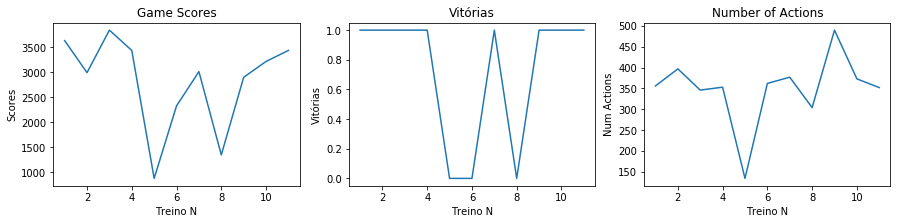

Wins:  8  Loss:  3


In [10]:
fig = plt.figure(figsize=(15, 3))
plt.subplot(131)
plt.xlabel('Treino N')
plt.ylabel('Scores')
plt.title('Game Scores')
plt.plot(range(1,len(gamesScores)+1),gamesScores[:])

plt.subplot(132)
plt.xlabel('Treino N')
plt.ylabel('Vitórias')
plt.title('Vitórias')
plt.plot(range(1,len(gamesScores)+1),results[:])

plt.subplot(133)
plt.xlabel('Treino N')
plt.ylabel('Num Actions')
plt.title('Number of Actions')
plt.plot(range(1,len(gamesScores)+1),numActions[:])
plt.show()

print("Wins: ",results.count(True)," Loss: ",results.count(False))

In [11]:
sum(gamesScores)/len(gamesScores)

2820.5454545454545

In [12]:
layoutType='smallClassic'
pacman.setIsTrain(False)
gamesScores, results, numActions = approxQLearning(pacman, layoutType,30,pacman.n_train)

layout:  smallClassic
------------------------------------------ train --------------------
STATE VARS:  0.418 -0.008264462809917356 1.0 0.015625 0
STATE VARS:  0.418 -0.01 1.0 0.02040816326530612 0
Action Score:  [3.155912192087985, 3.155502458316933]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0.015625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
STATE VARS:  0.398 -0.01 1.0 0.015625 0
Action Score:  [3.152481525647567, 3.0908988633127086]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.015625 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.01 0.25 0.015625 0
Action Score:  [3.151070673165508, 0.7628295837501811]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.027777777777777776 0
W:  [[3.1389090

STATE VARS:  0.023 -0.0625 0.0625 0.25 0
STATE VARS:  0.023 -0.0625 0.0625 0.0625 0
STATE VARS:  0.098 -0.25 0.25 0.0625 0
Action Score:  [0.20264434401652182, 0.13108808546365774, 0.471629537375334]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.098 -0.25 0.25 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.042444444444444444 -0.0625 0.1111111111111111 0.1111111111111111 0
STATE VARS:  0.398 -0.25 1.0 0.04 0
Action Score:  [0.30053308728234185, 2.7911120659115176]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.25 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.0625 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.0625 0.25 0.0625 0
STATE VARS:  0.098 -0.25 0.25 0.027777777777777776 0
Action Score:  [3.090701706170769, 0.7131054053542896, 0.45837837838406287]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.027777777777777776 0
W:  [[3.1389090

STATE VARS:  0.418 -0.0625 1.0 0.25 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0.0625 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0625 0
Action Score:  [3.175509123714904, 0.7578231586837259, 3.148670618491477]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.25 1.0 1.0 0
STATE VARS:  0.398 -0.0625 1.0 0.1111111111111111 0
Action Score:  [3.220258289947405, 3.0597263075045964]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.25 1.0 1.0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.25 1.0 0.25 0
STATE VARS:  0.098 -0.0625 0.25 0.25 0
STATE VARS:  -0.002 0 0.25 1.0 0.0625
Action Score:  [2.9340332557359488, 0.7846616639071538, 0.8892816085576073]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  

STATE VARS:  0.398 -0.015625 1.0 0.0625 0
STATE VARS:  0.042444444444444444 -0.015625 0.1111111111111111 0.027777777777777776 0
STATE VARS:  0.042444444444444444 -0.027777777777777776 0.1111111111111111 0.027777777777777776 0
Action Score:  [3.101543651911556, 0.32909927269803, 0.3134480590327273]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.398 -0.015625 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.015625 1.0 0.04 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0.04 0
STATE VARS:  0.398 -0.015625 1.0 0.1111111111111111 0
Action Score:  [3.1557350811304357, 0.7492364076573821, 3.1200952744993353]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.027777777777777776 0.25 0.0625 0
STATE VARS:  1.418 -0.015625 1.0 0.0625 0
Action Score:  [0.7578231586837259, 6.303230844417956]
['South'

STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.1111111111111111 0
STATE VARS:  -0.402 -1.0 1.0 0.04 0
Action Score:  [0.23792823262113114, -0.6859186158132464]
['East', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.25 0
STATE VARS:  0.023 -0.1111111111111111 0.0625 0.0625 0
STATE VARS:  -0.402 -1.0 0.25 0.0625 0
Action Score:  [0.2909328685862156, 0.06848323080244705, -2.0637284406710767]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.1111111111111111 0.25 1.0 0
STATE VARS:  -0.402 -1.0 0.1111111111111111 0.1111111111111111 0
Action Score:  [1.0082818434573992, -2.30191692

STATE VARS:  0.398 -0.0625 1.0 0.0625 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0625 0
Action Score:  [3.041174684916817, 3.148670618491477]
['South', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.0625 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.0625 0.25 0.04 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.1111111111111111 0
Action Score:  [3.12250448774982, 0.7045186543279458, 3.167222241079256]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.027777777777777776 1.0 0.25 0
STATE VARS:  0.398 -0.027777777777777776 1.0 0.0625 0
STATE VARS:  0.418 -0.015625 1.0 0.0625 0
Action Score:  [3.2202268770443405, 3.085892438246253, 3.164321832156779]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.

STATE VARS:  0.098 -0.02040816326530612 0.25 0.25 0
STATE VARS:  0.098 -0.04 0.25 0.0625 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
Action Score:  [0.83887053222896, 0.7420825095117642, 3.1581617334838468]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.02040816326530612 0.25 0.1111111111111111 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.04 0
Action Score:  [0.7858658962638756, 3.159958424500438]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.012345679012345678 0.25 0.0625 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.027777777777777776 0
Action Score:  [0.7776977157190308, 3.16055009773493]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0.027777777777777776 0
W:  [[3.138

STATE VARS:  0.418 -0.015625 1.0 0.04 0
STATE VARS:  0.398 -0.027777777777777776 1.0 0.1111111111111111 0
Action Score:  [3.1557350811304357, 3.104444060834033]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.01 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.015625 0.25 0.0625 0
Action Score:  [3.1583149492048768, 0.7734743723490285]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.01 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.01 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.01 0.25 0.04 0
Action Score:  [3.155502458316933, 0.7721318973620535]
['South', 'West', 'Stop']
STATE VARS:  0.418 -0.01 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.006944444444444444 0.25 0.027777777777777776 0
STATE VARS

STATE VARS:  0.098 -0.0625 0.25 0.015625 0
STATE VARS:  0.418 -0.25 1.0 0.027777777777777776 0
Action Score:  [0.6952163407160736, 2.8492258381918134]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.25 0.25 0.02040816326530612 0
STATE VARS:  -1.382 -1.0 1.0 0.04 0
Action Score:  [0.4555658874961196, -3.762049447829199]
['East', 'West', 'Stop']
STATE VARS:  0.098 -0.25 0.25 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.042444444444444444 -0.0625 0.1111111111111111 0.015625 0
STATE VARS:  0.398 -0.25 1.0 0.027777777777777776 0
Action Score:  [0.26409240005634627, 2.7864476579465904]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.25 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.1111111111111111 0.25 0.0

STATE VARS:  0.418 -0.25 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.0625 0.25 1.0 0
STATE VARS:  0.418 -0.25 1.0 0.1111111111111111 0
Action Score:  [2.8810286197708646, 1.07088669811861, 2.8810286197708646]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.398 -0.25 1.0 0.25 0
STATE VARS:  0.418 -0.25 1.0 0.0625 0
STATE VARS:  -1.382 -1.0 1.0 0.0625 0
Action Score:  [2.8712550754907253, 2.8624769971830846, -3.7534626968028553]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.398 -0.25 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -1.402 -1.0 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.25 0.25 1.0 0
STATE VARS:  0.418 -0.25 1.0 0.1111111111111111 0
Action Score:  [-3.7976892544602996, 0.8294108301396543, 2.8810286197708646]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0

STATE VARS:  -0.002 0 0.04 0.00390625 0.00510204081632653
Action Score:  [0.07338215792660438]
['West', 'Stop']
STATE VARS:  -0.002 0 0.04 0.00390625 0.00510204081632653
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.0625 0.0044444444444444444 0.00510204081632653
STATE VARS:  -0.002 0 0.027777777777777776 0.0044444444444444444 0.00390625
STATE VARS:  -0.002 0 0.027777777777777776 0.0034602076124567475 0.00390625
Action Score:  [0.1151794481674943, 0.050003467634911945, 0.049627850007034804]
['North', 'South', 'East', 'Stop']
STATE VARS:  -0.002 0 0.0625 0.0044444444444444444 0.00510204081632653
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.04 0.00390625 0.00390625
STATE VARS:  -0.002 0 0.04 0.00390625 0.00390625
STATE VARS:  -0.002 0 0.1111111111111111 0.00510204081632653 0.00510204081632653
Action Score:  [0.0723912040553264, 0.0723912040553264, 0.2052894462187061]
[

STATE VARS:  0.098 -0.008264462809917356 0.25 0.25 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0625 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.0625 0
Action Score:  [0.8545100554713144, 3.1685451755267815, 3.1738012567262013]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.398 -0.012345679012345678 1.0 0.1111111111111111 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.04 0
Action Score:  [3.1243186178693376, 3.1652145056998573]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.012345679012345678 0.25 0.0625 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.027777777777777776 0
Action Score:  [0.7776977157190308, 3.16055009773493]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0.02777777777

STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
STATE VARS:  0.398 -0.01 1.0 0.015625 0
Action Score:  [3.152481525647567, 3.0908988633127086]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.02040816326530612 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.015625 0
Action Score:  [3.1449105744925756, 0.7598086510808149]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.04 1.0 0.04 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.02040816326530612 0
Action Score:  [3.124343218293171, 0.7512506237968816]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VAR

STATE VARS:  0.398 -0.015625 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0.1111111111111111 0
STATE VARS:  0.418 -0.015625 1.0 0.04 0
Action Score:  [3.1200952744993353, 0.7763747812715054, 3.1557350811304357]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.015625 1.0 0.0625 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0.0625 0
Action Score:  [3.164321832156779, 0.7578231586837259]
['South', 'East', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.027777777777777776 0.25 0.04 0
STATE VARS:  0.418 -0.015625 1.0 0.04 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0.1111111111111111 0
Action Score:  [0.7492364076573821, 3.1557350811304357, 0.7763747812715054]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 

STATE VARS:  0.418 -0.02040816326530612 1.0 0.25 0
STATE VARS:  0.098 -0.04 0.25 0.25 0
STATE VARS:  -0.002 0 0.25 1.0 0.02040816326530612
Action Score:  [3.2297179920367105, 0.8136387680646284, 0.8544000322886219]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.04 0.25 1.0 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
Action Score:  [3.1767133560716263, 1.0998638022760847, 3.1767133560716263]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.398 -0.04 1.0 0.25 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
Action Score:  [3.1417080476271555, 3.15816173348

STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.04 0
Action Score:  [3.152481525647567, 0.7587275226497523]
['South', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.02040816326530612 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.015625 1.0 0.015625 0
Action Score:  [0.7540631146848249, 3.1464327675185633]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.015625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.015625 0.25 0.02040816326530612 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.02040816326530612 0
Action Score:  [0.7574107224698141, 3.132606968612262]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.8287

STATE VARS:  0.098 -0.04 0.25 0.04 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.02040816326530612 0
Action Score:  [0.7334957584854205, 3.1420980836046324]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.04 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.015625 0
Action Score:  [0.7288313505204931, 3.1307815538532604]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0.015625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.027777777777777776 0.25 0.012345679012345678 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0.02040816326530612 0
STATE VARS:  0.418 -0.0625 1.0 0.015625 0
Action Score:  [0.7386825956963341, 0.7417595088045115, 3.0860638005238243]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.015625 0
W:  [[3.1

STATE VARS:  0.098 -0.006944444444444444 0.25 0.25 0
STATE VARS:  0.418 -0.01 1.0 0.0625 0
STATE VARS:  0.418 -0.006944444444444444 1.0 0.0625 0
Action Score:  [0.8562100692342516, 3.171566108196148, 3.1755012704891383]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.398 -0.01 1.0 0.1111111111111111 0
STATE VARS:  0.418 -0.006944444444444444 1.0 0.04 0
Action Score:  [3.127339550538704, 3.166914519462795]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.01 0.25 0.0625 0
STATE VARS:  0.418 -0.006944444444444444 1.0 0.027777777777777776 0
Action Score:  [0.7807186483883971, 3.162250111497867]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0

STATE VARS:  0.418 -0.027777777777777776 1.0 0.1111111111111111 0
STATE VARS:  0.398 -0.0625 1.0 0.04 0
Action Score:  [3.167222241079256, 3.032587933890473]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.027777777777777776 1.0 0.25 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0625 0
STATE VARS:  0.098 -0.0625 0.25 0.0625 0
Action Score:  [3.2202268770443405, 3.148670618491477, 0.7131054053542896]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.0625 1.0 1.0 0
STATE VARS:  0.398 -0.0625 1.0 0.1111111111111111 0
Action Score:  [3.4617341579263607, 3.0597263075045964]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 1.0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  A

STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0.04 0
STATE VARS:  0.398 -0.0625 1.0 0.04 0
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0.1111111111111111 0
Action Score:  [0.03191884568926298, 3.032587933890473, 0.059057219303386255]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.398 -0.0625 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.0625 0.25 0.0625 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
Action Score:  [0.7131054053542896, 0.7445719996924547, 3.119678810328244]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.04 0.25 0.04 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.02040816326530612 0
Action Score:  [0.7334957584854205, 3.0252843606216153]
['East', 'West', '

STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0.006944444444444444 0
STATE VARS:  0.398 -0.1111111111111111 1.0 0.01 0
Action Score:  [0.28975671446600315, 2.9585340778608042]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.1111111111111111 1.0 0.01 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.04 0.25 0.008264462809917356 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.012345679012345678 0
Action Score:  [0.7213844181948201, 3.0222074475134377]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.1111111111111111 1.0 0.012345679012345678 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.04 0.25 0.01 0
STATE VARS:  0.098 -0.04 0.25 0.01 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.015625 0
Action Score:  [0.7220467571169623, 0.7220467571169623, 3.0234589458626138]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.1111111111111111 1.0 0.015625 0
W:  [[3.138909

STATE VARS:  0.042444444444444444 -0.008264462809917356 0.1111111111111111 0.25 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.0625 0
STATE VARS:  0.023 -0.008264462809917356 0.0625 0.0625 0
Action Score:  [0.42338611481158706, 0.7776977157190308, 0.20093647702781847]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.098 -0.012345679012345678 0.25 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.398 -0.012345679012345678 1.0 0.04 0
STATE VARS:  0.042444444444444444 -0.008264462809917356 0.1111111111111111 0.1111111111111111 0
Action Score:  [3.097180244255214, 0.3703814788465026]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.012345679012345678 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.098 -0.02040816326530612 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.0625 0
Acti

STATE VARS:  0.418 -0.0625 1.0 0.04 0
STATE VARS:  0.398 -0.25 1.0 0.1111111111111111 0
Action Score:  [3.0953661141356967, 2.8182504395256407]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.0625 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.25 0.25 0.0625 0
Action Score:  [3.090701706170769, 0.471629537375334]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.0625 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.25 0.25 0.04 0
Action Score:  [3.087889215282826, 0.46304278634899027]
['South', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.25 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.0625 1.0 0.015625 0


STATE VARS:  0.023 -0.01 0.0625 0.015625 0
STATE VARS:  0.098 -0.015625 0.25 0.027777777777777776 0
Action Score:  [0.1808122638595493, 0.7602232133577573]
['East', 'West', 'Stop']
STATE VARS:  0.098 -0.015625 0.25 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.042444444444444444 -0.01 0.1111111111111111 0.02040816326530612 0
STATE VARS:  0.398 -0.015625 1.0 0.04 0
Action Score:  [0.33353105784945547, 3.092956900885212]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.015625 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.015625 0.25 0.027777777777777776 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
Action Score:  [0.7602232133577573, 0.7644465567277596, 3.1581617334838468]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
W:  [[3.138909

STATE VARS:  0.398 -0.25 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.25 0.25 1.0 0
STATE VARS:  -1.382 -1.0 1.0 0.1111111111111111 0
Action Score:  [2.8182504395256407, 0.8294108301396543, -3.7349110742150757]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.398 -0.25 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.398 -0.25 1.0 0.25 0
STATE VARS:  0.418 -0.0625 1.0 0.0625 0
STATE VARS:  0.418 -0.25 1.0 0.0625 0
Action Score:  [2.8712550754907253, 3.1039528651620403, 2.8624769971830846]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.0625 1.0 0.04 0
STATE VARS:  0.398 -0.25 1.0 0.1111111111111111 0
Action Score:  [3.0953661141356967, 2.8182504395256407]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -

STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0.04 0
STATE VARS:  -1.402 -1.0 1.0 0.02040816326530612 0
Action Score:  [0.03191884568926298, -3.8323045269272935]
['East', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.023 -0.25 0.0625 0.0625 0
STATE VARS:  0.023 -0.25 0.0625 0.027777777777777776 0
STATE VARS:  -1.402 -1.0 0.25 0.027777777777777776 0
Action Score:  [-0.11038778251529785, -0.12363894150656898, -5.215888611923525]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.023 -0.25 0.0625 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.014 -0.25 0.04 0.04 0
STATE VARS:  -1.402 -1.0 0.1111111111111111 0.04 0
STATE VARS:  0.014 -0.25 0.04 0.1111111111111111 0
Action Score:  [-0.18881661192851737, -5.467964310603815, -0.1616782383143941]
['North', 'South', 'East', 'Stop']
STATE VARS:

STATE VARS:  0.018 0 1.0 0.25 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0.0625 0.1111111111111111
STATE VARS:  0.818 -0.012345679012345678 1.0 0.0625 0
Action Score:  [2.0925154404427606, 0.5717844257604989, 4.424108780431252]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.818 -0.012345679012345678 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.398 -0.012345679012345678 1.0 0.1111111111111111 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.04 0
Action Score:  [3.1243186178693376, 3.1652145056998573]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.01 0.25 0.0625 0
STATE VARS:  0.418 -0.006944444444444444 1.0 0.027777777777777776 0
Action Score:  [0.7807186483883971, 3.162250111497867]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0.027777777777777776 0
W:  [[3.138

STATE VARS:  0.009111111111111111 -0.027777777777777776 0.027777777777777776 0.015625 0
STATE VARS:  0.023 -0.0625 0.0625 0.027777777777777776 0
Action Score:  [0.050135788989946126, 0.11783692647238662]
['East', 'West', 'Stop']
STATE VARS:  0.023 -0.0625 0.0625 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.014 -0.04 0.04 0.02040816326530612 0
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.04 0
Action Score:  [0.07415946135504221, 0.21078985900700786]
['East', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.402 -1.0 0.0625 0.027777777777777776 0
STATE VARS:  0.023 -0.1111111111111111 0.0625 0.027777777777777776 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.0625 0
Action Score:  [-2.4235787436333918, 0.05523207181117591, 0.6505005506930789]


STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0.02040816326530612 0
STATE VARS:  0.398 -0.1111111111111111 1.0 0.04 0
Action Score:  [0.29489491897282255, 2.9699830792292623]
['North', 'West', 'Stop']
STATE VARS:  0.398 -0.1111111111111111 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.04 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.0625 0
Action Score:  [0.7288313505204931, 3.0413480105008297]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.1111111111111111 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.014 -0.04 0.04 0.04 0
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.1111111111111111 0
Action Score:  [0.08163636020791291, 0.23792823262113114]
['East', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.1111111111111111 0
W:  [[3.13890901 1.2878713

STATE VARS:  0.098 -0.027777777777777776 0.25 0.0625 0
STATE VARS:  0.418 -0.015625 1.0 0.027777777777777776 0
Action Score:  [0.7578231586837259, 3.151070673165508]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.01 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.015625 0.25 0.04 0
Action Score:  [3.155502458316933, 0.7648876213226847]
['South', 'East', 'Stop']
STATE VARS:  0.418 -0.01 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.01 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.006944444444444444 1.0 0.015625 0
Action Score:  [0.7674674893971261, 3.1576122058509224]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0.015625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.00694444444

STATE VARS:  0.0003668639053254439 -0.25 0.005917159763313609 0.0625 0
STATE VARS:  -0.00022222222222222231 -0.0625 0.0044444444444444444 0.027777777777777776 0
Action Score:  [-0.28602614532252996, -0.06237288072337938]
['East', 'West', 'Stop']
STATE VARS:  -0.00022222222222222231 -0.0625 0.0044444444444444444 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.0004375 -0.0625 0.00390625 0.02040816326530612 0
STATE VARS:  4.081632653061229e-05 -0.25 0.00510204081632653 0.04 0
Action Score:  [-0.06685597688137908, -0.2971431008551002]
['South', 'East', 'Stop']
STATE VARS:  -0.0004375 -0.0625 0.00390625 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.00022222222222222231 -0.25 0.0044444444444444444 0.027777777777777776 0
STATE VARS:  -0.0006159169550173009 -0.0625 0.0034602076124567475 0.015625 0
Action Score:  [-0.30384874870233497, -0.0700659484

STATE VARS:  -0.002 0 0.04 0.02040816326530612 0.01
STATE VARS:  0.006163265306122449 -0.01 0.02040816326530612 0.012345679012345678 0.006944444444444444
Action Score:  [0.08373878590191468, 0.05465868899962948]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.04 0.02040816326530612 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.0625 0.027777777777777776 0.012345679012345678
STATE VARS:  -0.002 0 0.027777777777777776 0.015625 0.008264462809917356
Action Score:  [0.13008704222988038, 0.05788199915434584]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.0625 0.027777777777777776 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.042444444444444444 -0.015625 0.1111111111111111 0.04 0.012345679012345678
STATE VARS:  0.014 -0.01 0.04 0.02040816326530612 0.008264462809917356
Action Score:  [0.34399456573399545, 0.11964437453542781]
['East', 'West', 'Stop']
STATE 

STATE VARS:  0.418 -0.04 1.0 0.04 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.1111111111111111 0
Action Score:  [3.124343218293171, 0.6690521732808584]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.0625 0
Action Score:  [3.119678810328244, 0.6505005506930789]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.04 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.04 0
Action Score:  [3.1168663194403003, 0.6419137996667351]
['North', 'West', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.0625 1.0 0.015625 0
STATE VARS:  0.098 -0.

STATE VARS:  0.418 -0.02040816326530612 1.0 0.04 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.02040816326530612 0
Action Score:  [3.1495749824575032, 0.7616340658398164]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.027777777777777776 0
Action Score:  [3.119678810328244, 3.1581617334838468, 0.7540631146848249]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
STATE VARS:  0.398 -0.04 1.0 0.04 0
Action Score:  [3.1767133560716263, 3.0615650380479478]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
W: 

STATE VARS:  0.398 -0.25 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.0625 0.25 1.0 0
STATE VARS:  0.418 -0.25 1.0 0.1111111111111111 0
Action Score:  [2.8182504395256407, 1.07088669811861, 2.8810286197708646]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.25 1.0 0.0625 0
STATE VARS:  0.098 -0.25 0.25 0.25 0
STATE VARS:  -1.382 -1.0 1.0 0.0625 0
Action Score:  [2.8624769971830846, 0.543185795928198, -3.7534626968028553]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -1.402 -1.0 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.25 0.25 0.1111111111111111 0
STATE VARS:  0.418 -0.25 1.0 0.04 0
Action Score:  [-3.7976892544602996, 0.49018115996311357, 2.853890246156741]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 

STATE VARS:  0.398 -0.25 1.0 0.25 0
STATE VARS:  0.418 -0.25 1.0 0.0625 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.0625 0
Action Score:  [2.8712550754907253, 2.8624769971830846, 3.0413480105008297]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.1111111111111111 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.398 -0.25 1.0 0.1111111111111111 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.04 0
Action Score:  [2.8182504395256407, 3.032761259474486]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.1111111111111111 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.25 0.25 0.0625 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.027777777777777776 0
Action Score:  [0.471629537375334, 3.0280968515095585]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.1111111111111111 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   - 

STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
STATE VARS:  0.398 -0.01 1.0 0.015625 0
Action Score:  [3.152481525647567, 3.0908988633127086]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.02040816326530612 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.015625 0
Action Score:  [3.1449105744925756, 0.7598086510808149]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.02040816326530612 1.0 0.04 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.02040816326530612 0
Action Score:  [3.1495749824575032, 0.7616340658398164]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.8287016

STATE VARS:  0.418 -0.015625 1.0 0.04 0
STATE VARS:  0.398 -0.027777777777777776 1.0 0.04 0
STATE VARS:  0.418 -0.015625 1.0 0.1111111111111111 0
Action Score:  [3.1557350811304357, 3.0773056872199094, 3.1828734547445587]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.015625 1.0 0.0625 0
STATE VARS:  0.098 -0.015625 0.25 0.25 0
STATE VARS:  0.398 -0.027777777777777776 1.0 0.0625 0
Action Score:  [3.164321832156779, 0.8450306309018926, 3.085892438246253]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.027777777777777776 0.25 0.1111111111111111 0
STATE VARS:  0.098 -0.015625 0.25 0.1111111111111111 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.04 0
Action Score:  [0.7763747812715054, 0.792025994936808, 3.140083

STATE VARS:  0.418 -0.0044444444444444444 1.0 0.015625 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.027777777777777776 0
Action Score:  [3.1608318840906415, 0.77272566214365]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.015625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.005917159763313609 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.02040816326530612 0
Action Score:  [3.1607606310634573, 0.7699131712557068]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.005917159763313609 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.008264462809917356 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.015625 0
Action Score:  [3.16055009773493, 0.7680877564967051]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0.027777777777777776 0
W:  [[3.138

STATE VARS:  0.418 -0.012345679012345678 1.0 0.25 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0625 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.0625 0
Action Score:  [3.2401014340796452, 3.1685451755267815, 0.767314273676096]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.02040816326530612 1.0 1.0 0
STATE VARS:  0.398 -0.02040816326530612 1.0 0.1111111111111111 0
Action Score:  [3.5159430262481672, 3.113935175826403]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 1.0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.04 1.0 0.25 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.25 0
STATE VARS:  -0.002 0 0.25 1.0 0.02040816326530612
Action Score:  [3.204486227872379, 0.83887053222896, 0.8544000322886219]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 

STATE VARS:  0.098 -0.008264462809917356 0.25 0.0625 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.027777777777777776 0
Action Score:  [0.7829537969184504, 0.7697026379271792, 3.1552940165355103]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.01 0.25 0.04 0
STATE VARS:  0.418 -0.015625 1.0 0.02040816326530612 0
Action Score:  [0.7721318973620535, 3.148258182277565]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.015625 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.015625 0
Action Score:  [0.7602232133577573, 3.1307815538532604]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0

STATE VARS:  0.023 -0.04 0.0625 0.04 0
STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0.04 0
Action Score:  [0.1514784385947887, 0.32760358199002493]
['North', 'South', 'Stop']
STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.023 -0.027777777777777776 0.0625 0.027777777777777776 0
STATE VARS:  0.023 -0.015625 0.0625 0.027777777777777776 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.0625 0
Action Score:  [0.16255467980182284, 0.1782058934671255, 0.767314273676096]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.098 -0.02040816326530612 0.25 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.042444444444444444 -0.015625 0.1111111111111111 0.04 0
STATE VARS:  0.398 -0.02040816326530612 1.0 0.1111111111111111 0
Action Score:  [0.3337636806629575, 3.113935175826403]
['East', 'We

STATE VARS:  0.418 -0.012345679012345678 1.0 0.1111111111111111 0
STATE VARS:  0.398 -0.02040816326530612 1.0 0.04 0
Action Score:  [3.187096798114561, 3.0867968022122794]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.25 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0625 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.0625 0
Action Score:  [3.2401014340796452, 3.1685451755267815, 0.767314273676096]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.012345679012345678 1.0 1.0 0
STATE VARS:  0.398 -0.012345679012345678 1.0 0.1111111111111111 0
Action Score:  [3.526326468291102, 3.1243186178693376]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 1.0 0
W

STATE VARS:  0.418 -0.04 1.0 0.0625 0
STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.027777777777777776 0
Action Score:  [3.132929969319515, 3.119678810328244, 0.6372493917018077]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.02040816326530612 1.0 0.04 0
STATE VARS:  0.398 -0.04 1.0 0.04 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
Action Score:  [3.1495749824575032, 3.0615650380479478, 3.1767133560716263]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0625 0
STATE VARS:  0.398 -0.02040816326530612 1.0 0.0625 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.25 0
Action Score:  [3.1685451755267815, 3.095383

STATE VARS:  -0.402 -1.0 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.0625 0
Action Score:  [-2.076979599662348, 3.0280968515095585, 0.6505005506930789]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.1111111111111111 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.1111111111111111 1.0 0.02040816326530612 0
STATE VARS:  -0.402 -1.0 0.25 0.04 0
Action Score:  [3.0252843606216153, -2.0723151916974207]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.1111111111111111 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.006163265306122449 -0.1111111111111111 0.02040816326530612 0.015625 0
STATE VARS:  -0.402 -1.0 0.012345679012345678 0.027777777777777776 0
Action Score:  [-0.08006278319897206, -2.5162904488108313]
['East', 'West', 'Stop']
S

Pacman emerges victorious! Score: 975
Average Score: 975.0
Scores:        975.0
Win Rate:      1/1 (1.00)
Record:        Win
[[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]
975.0
------------------------------------------ train --------------------
STATE VARS:  0.418 -0.008264462809917356 1.0 0.015625 0
STATE VARS:  0.418 -0.01 1.0 0.02040816326530612 0
Action Score:  [3.155912192087985, 3.155502458316933]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0.015625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
STATE VARS:  0.398 -0.01 1.0 0.015625 0
Action Score:  [3.152481525647567, 3.0908988633127086]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.015625 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.01

STATE VARS:  0.418 -0.25 1.0 0.04 0
STATE VARS:  0.098 -0.0625 0.25 0.04 0
Action Score:  [2.853890246156741, 0.7045186543279458]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -1.382 -1.0 1.0 0.0625 0
STATE VARS:  0.098 -0.25 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.25 1.0 0.027777777777777776 0
Action Score:  [-3.7534626968028553, 0.45837837838406287, 2.8492258381918134]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.398 -0.25 1.0 0.04 0
STATE VARS:  0.418 -0.0625 1.0 0.02040816326530612 0
Action Score:  [2.7911120659115176, 3.087889215282826]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.0625 0.2

STATE VARS:  -0.402 -1.0 1.0 0.0625 0
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.027777777777777776 0
Action Score:  [-0.6773318647869027, 0.2061254510420804]
['East', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.023 -0.1111111111111111 0.0625 0.02040816326530612 0
STATE VARS:  -0.402 -1.0 0.25 0.04 0
Action Score:  [0.05241958092323265, -2.0723151916974207]
['South', 'East', 'Stop']
STATE VARS:  0.023 -0.1111111111111111 0.0625 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.402 -1.0 0.1111111111111111 0.027777777777777776 0
STATE VARS:  0.014 -0.1111111111111111 0.04 0.015625 0
Action Score:  [-2.3337197063075656, -0.019247912222644797]
['North', 'South', 'Stop']
STATE VARS:  0.014 -0.1111111111111111 0.04 0.015625 0
W:

STATE VARS:  -0.002 0 0.027777777777777776 0.0044444444444444444 0.1111111111111111
STATE VARS:  -0.002 0 0.0625 0.005917159763313609 1.0
STATE VARS:  -0.002 0 0.027777777777777776 0.0044444444444444444 0.1111111111111111
Action Score:  [0.13884431729474572, 0.9402151063941546, 0.13884431729474572]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.0625 0.005917159763313609 1.0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.04 0.00510204081632653 0.25
STATE VARS:  0.4424444444444445 -0.02040816326530612 0.1111111111111111 0.006944444444444444 0.008264462809917356
STATE VARS:  -0.002 0 0.04 0.00510204081632653 0.25
Action Score:  [0.2767858644540879, 1.5774008578385583, 0.2767858644540879]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.4424444444444445 -0.02040816326530612 0.1111111111111111 0.006944444444444444 0.008264462809917356
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STAT

STATE VARS:  0.418 -0.027777777777777776 1.0 0.04 0
STATE VARS:  0.098 -0.015625 0.25 0.02040816326530612 0
Action Score:  [3.140083867465133, 0.7574107224698141]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.027777777777777776 0
Action Score:  [3.119678810328244, 3.1581617334838468, 0.7540631146848249]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.1111111111111111 0
STATE VARS:  0.398 -0.02040816326530612 1.0 0.04 0
Action Score:  [3.187096798114561, 3.0867968022122794]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.1111111111111111 

STATE VARS:  0.098 -0.04 0.25 0.1111111111111111 0
STATE VARS:  0.098 -0.04 0.25 0.1111111111111111 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.04 0
Action Score:  [0.7606341320995438, 0.7606341320995438, 3.1495749824575032]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.04 0.25 0.0625 0
STATE VARS:  0.023 -0.04 0.0625 0.0625 0
Action Score:  [0.7420825095117642, 0.16006518962113242]
['South', 'East', 'Stop']
STATE VARS:  0.098 -0.04 0.25 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0.04 0
STATE VARS:  0.398 -0.04 1.0 0.04 0
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.1111111111111111 0
Action Score:  [0.3023718178256932, 3.0615650380479478, 0.23792823262113114]
['North', 'South', 'East', 'Stop']
STATE VARS:

STATE VARS:  0.098 -0.0625 0.25 0.0625 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.027777777777777776 0
Action Score:  [0.7131054053542896, 3.1354194595002056]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.04 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.0625 0.25 0.04 0
Action Score:  [3.1168663194403003, 0.7045186543279458]
['North', 'East', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.1111111111111111 1.0 0.015625 0
STATE VARS:  0.098 -0.04 0.25 0.027777777777777776 0
Action Score:  [3.0234589458626138, 0.7288313505204931]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.1111111111111111 1.0 0.015625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.382 -1.0 1.

STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
STATE VARS:  0.398 -0.01 1.0 0.015625 0
Action Score:  [3.152481525647567, 3.0908988633127086]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.02040816326530612 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.015625 0
Action Score:  [3.1449105744925756, 0.7598086510808149]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.02040816326530612 1.0 0.04 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.02040816326530612 0
Action Score:  [3.1495749824575032, 0.7616340658398164]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.8287016

STATE VARS:  0.398 -0.25 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.25 0.25 0.1111111111111111 0
STATE VARS:  0.418 -0.0625 1.0 0.04 0
Action Score:  [2.8182504395256407, 0.49018115996311357, 3.0953661141356967]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.0625 1.0 0.0625 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.0625 0
Action Score:  [3.1039528651620403, 0.6505005506930789]
['South', 'East', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.1111111111111111 0.25 0.04 0
STATE VARS:  0.418 -0.0625 1.0 0.04 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.1111111111111111 0
Action Score:  [0.6419137996667351, 3.0953661141356967, 0.6690521732808584]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.04 0
W:  [[3.13890901 1.2878713  1

STATE VARS:  0.418 -0.04 1.0 0.0625 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.027777777777777776 0
Action Score:  [3.132929969319515, 0.7540631146848249]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.04 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.04 0
Action Score:  [3.1514815919072943, 0.7587275226497523]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.098 -0.04 0.25 0.25 0
STATE VARS:  0.418 -0.04 1.0 0.0625 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.0625 0
Action Score:  [0.8136387680646284, 3.132929969319515, 0.767314273676096]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.098 -0.

STATE VARS:  0.0013057851239669422 -0.02040816326530612 0.008264462809917356 0.0044444444444444444 0.015625
STATE VARS:  0.0029382716049382715 -0.04 0.012345679012345678 0.005917159763313609 0.027777777777777776
STATE VARS:  0.0013057851239669422 -0.02040816326530612 0.008264462809917356 0.0044444444444444444 0.015625
Action Score:  [0.007737362546354761, 0.005807135282697128, 0.007737362546354761]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.0013057851239669422 -0.02040816326530612 0.008264462809917356 0.0044444444444444444 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.01 0.00510204081632653 0.027777777777777776
STATE VARS:  -0.002 0 0.01 0.00510204081632653 0.027777777777777776
STATE VARS:  -0.002 0 0.006944444444444444 0.00390625 0.015625
Action Score:  [0.03717407014003718, 0.03717407014003718, 0.02099840661228897]
['South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.01 0.00510204081632653 0.027777777777

STATE VARS:  0.042444444444444444 -0.012345679012345678 0.1111111111111111 0.02040816326530612 0
STATE VARS:  0.014 -0.02040816326530612 0.04 0.012345679012345678 0
Action Score:  [0.3305101251800891, 0.09631431241119666]
['East', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.012345679012345678 0.1111111111111111 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.098 -0.02040816326530612 0.25 0.027777777777777776 0
STATE VARS:  0.023 -0.012345679012345678 0.0625 0.015625 0
Action Score:  [0.7540631146848249, 0.17779133119018292]
['East', 'West', 'Stop']
STATE VARS:  0.098 -0.02040816326530612 0.25 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.398 -0.02040816326530612 1.0 0.04 0
STATE VARS:  0.042444444444444444 -0.012345679012345678 0.1111111111111111 0.02040816326530612 0
Action Score:  [3.0867968022122794, 0.3305101251800891]
['East', 'W

STATE VARS:  0.418 -0.0044444444444444444 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.04 0
Action Score:  [3.162657298849643, 0.7773900701085774]
['South', 'West', 'Stop']
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.005917159763313609 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.015625 0
Action Score:  [0.77272566214365, 3.1608318840906415]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.015625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.005917159763313609 0.25 0.02040816326530612 0
STATE VARS:  0.418 -0.005917159763313609 1.0 0.02040816326530612 0
Action Score:  [0.7699131712557068, 3.1607606310634573]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.005917159763313609 1.0 0.02040816326530612 0
W:  [[3.1389090

STATE VARS:  0.098 -0.0625 0.25 0.015625 0
STATE VARS:  0.418 -0.25 1.0 0.027777777777777776 0
Action Score:  [0.6952163407160736, 2.8492258381918134]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.25 0.25 0.02040816326530612 0
STATE VARS:  -1.382 -1.0 1.0 0.04 0
Action Score:  [0.4555658874961196, -3.762049447829199]
['East', 'West', 'Stop']
STATE VARS:  0.098 -0.25 0.25 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0.015625 0
STATE VARS:  -1.402 -1.0 1.0 0.027777777777777776 0
Action Score:  [0.022616532077390644, -3.8294920360393503]
['East', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0.015625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.023 -0.25 0.06

STATE VARS:  0.418 -0.00390625 1.0 0.0625 0
STATE VARS:  0.418 -0.00510204081632653 1.0 0.0625 0
STATE VARS:  0.098 -0.00390625 0.25 0.25 0
Action Score:  [3.179414073905464, 3.177874049237231, 0.8601228726505773]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.00390625 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.398 -0.00390625 1.0 0.1111111111111111 0
STATE VARS:  0.418 -0.00390625 1.0 0.04 0
STATE VARS:  0.398 -0.0030864197530864196 1.0 0.1111111111111111 0
Action Score:  [3.13518751624802, 3.17082732287912, 3.1362433520905206]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.00390625 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.00390625 1.0 0.0625 0
STATE VARS:  0.098 -0.0030864197530864196 0.25 0.0625 0
Action Score:  [3.179414073905464, 0.7896224499402138]
['South', 'West', 'Stop']
STATE VARS:  0.418 -0.00390625 1.0 0.0625 0
W:  [

STATE VARS:  0.418 -0.012345679012345678 1.0 0.1111111111111111 0
STATE VARS:  0.398 -0.02040816326530612 1.0 0.04 0
Action Score:  [3.187096798114561, 3.0867968022122794]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.008264462809917356 1.0 0.25 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.0625 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.0625 0
Action Score:  [3.245357515279065, 3.1738012567262013, 0.7776977157190308]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.01 1.0 1.0 0
STATE VARS:  0.398 -0.01 1.0 0.1111111111111111 0
Action Score:  [3.5293474009604684, 3.127339550538704]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.01 1.0 1.0 0
W:  [[3.13890901 1.2878713  1.84852877 0.3816333

STATE VARS:  0.098 -0.1111111111111111 0.25 0.0625 0
STATE VARS:  0.398 -0.1111111111111111 1.0 0.0625 0
Action Score:  [0.6505005506930789, 2.9785698302556063]
['South', 'West', 'Stop']
STATE VARS:  0.398 -0.1111111111111111 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.402 -1.0 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.04 0
STATE VARS:  -0.382 -1.0 1.0 0.1111111111111111 0
Action Score:  [-0.6587802421991231, 0.6419137996667351, -0.5960020619538997]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.098 -0.1111111111111111 0.25 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.402 -1.0 0.25 0.0625 0
STATE VARS:  -0.402 -1.0 1.0 0.0625 0
Action Score:  [-2.0637284406710767, -0.6773318647869027]
['South', 'West', 'Stop']
STATE VARS:  -0.402 -1.0 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
ST

STATE VARS:  -0.002 0 0.0625 0.0044444444444444444 0.0625
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.25
STATE VARS:  -0.002 0 0.0625 0.0034602076124567475 0.0625
Action Score:  [0.162745233988838, 0.664725944976271, 0.16236961636096087]
['North', 'South', 'West', 'Stop']
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.25
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.1111111111111111 0.00390625 0.0625
STATE VARS:  -0.002 0 1.0 0.00510204081632653 0.25
Action Score:  [0.2523988783502994, 2.0513734815858307]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 0.00510204081632653 0.25
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 1.0
Action Score:  [0.5496284879270936, 1.9993652813798606, 1.286252213041

STATE VARS:  0.018 0 1.0 0.02040816326530612 0.015625
STATE VARS:  -0.002 0 0.25 0.04 0.015625
Action Score:  [1.9257660302893727, 0.48406817301284577]
['North', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.015625 0.015625
STATE VARS:  -0.002 0 0.25 0.027777777777777776 0.015625
Action Score:  [1.923940615530371, 0.4794037650479184]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.015625 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.02040816326530612 0.012345679012345678
Action Score:  [1.9297298457744847, 0.4738736953129807]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.02040816326530612
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  

STATE VARS:  0.098 -0.25 0.25 0.0625 0
STATE VARS:  0.418 -0.0625 1.0 0.027777777777777776 0
STATE VARS:  0.418 -0.0625 1.0 0.027777777777777776 0
Action Score:  [0.471629537375334, 3.090701706170769, 3.090701706170769]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.398 -0.0625 1.0 0.04 0
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.04 0
Action Score:  [3.032587933890473, 0.21078985900700786]
['North', 'South', 'Stop']
STATE VARS:  0.398 -0.0625 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.0625 0.25 0.0625 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
Action Score:  [0.7131054053542896, 0.6372493917018077, 3.119678810328244]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.4

STATE VARS:  0.418 -0.25 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.0625 0.25 0.04 0
Action Score:  [2.8810286197708646, 0.7045186543279458]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -1.402 -1.0 0.25 0.25 0
STATE VARS:  0.418 -0.25 1.0 0.0625 0
STATE VARS:  0.098 -0.25 0.25 0.0625 0
Action Score:  [-5.131081194379389, 2.8624769971830846, 0.471629537375334]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.098 -0.25 0.25 0.1111111111111111 0
STATE VARS:  0.418 -0.0625 1.0 0.04 0
STATE VARS:  0.098 -0.25 0.25 0.1111111111111111 0
Action Score:  [0.49018115996311357, 3.0953661141356967, 0.49018115996311357]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   

STATE VARS:  0.002 -0.1111111111111111 0.01 0.04 0
STATE VARS:  0.0007777777777777776 -0.0625 0.006944444444444444 0.1111111111111111 0
Action Score:  [-0.10306836979327358, -0.022809868212453593]
['East', 'West', 'Stop']
STATE VARS:  0.0007777777777777776 -0.0625 0.006944444444444444 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.0003668639053254439 -0.25 0.005917159763313609 0.25 0
STATE VARS:  0.0013057851239669422 -0.1111111111111111 0.008264462809917356 0.0625 0
STATE VARS:  0.0003668639053254439 -0.0625 0.005917159763313609 0.0625 0
Action Score:  [-0.21446988676966589, -0.09986888652128943, -0.04455027734357434]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.0003668639053254439 -0.0625 0.005917159763313609 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.0007777777777777776 -0.1111111111111111 0.006944444444444444 0.1111111111111111 0
STATE VARS:  4.0

STATE VARS:  -0.002 0 0.01 0.01 0.027777777777777776
STATE VARS:  -0.002 0 0.006944444444444444 0.006944444444444444 0.015625
Action Score:  [0.03904329485325486, 0.022157883024025195]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.01 0.01 0.027777777777777776
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.012345679012345678 0.012345679012345678 0.04
STATE VARS:  -0.002 0 0.008264462809917356 0.008264462809917356 0.02040816326530612
Action Score:  [0.054403115615445335, 0.029065553500887974]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.012345679012345678 0.012345679012345678 0.04
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.01 0.01 0.027777777777777776
STATE VARS:  -0.002 0 0.015625 0.015625 0.0625
STATE VARS:  -0.002 0 0.01 0.01 0.027777777777777776
Action Score:  [0.03904329485325486, 0.08036232119126643, 0.03904329485325486]
['North', 'East', 'West', 'Stop']


STATE VARS:  0.418 -0.012345679012345678 1.0 0.1111111111111111 0
STATE VARS:  0.398 -0.02040816326530612 1.0 0.04 0
Action Score:  [3.187096798114561, 3.0867968022122794]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.25 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0625 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.0625 0
Action Score:  [3.2401014340796452, 3.1685451755267815, 0.767314273676096]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.012345679012345678 1.0 1.0 0
STATE VARS:  0.398 -0.012345679012345678 1.0 0.1111111111111111 0
Action Score:  [3.526326468291102, 3.1243186178693376]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 1.0 0
W

STATE VARS:  0.098 -0.00510204081632653 0.25 0.1111111111111111 0
STATE VARS:  0.098 -0.00390625 0.25 0.1111111111111111 0
STATE VARS:  0.418 -0.00510204081632653 1.0 0.04 0
Action Score:  [0.8055782120172597, 0.8071182366854928, 3.169287298210887]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.00510204081632653 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.006944444444444444 0.25 0.0625 0
STATE VARS:  0.023 -0.00510204081632653 0.0625 0.0625 0
Action Score:  [0.7846538106813875, 0.20500926953884824]
['South', 'East', 'Stop']
STATE VARS:  0.098 -0.006944444444444444 0.25 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.042444444444444444 -0.00510204081632653 0.1111111111111111 0.04 0
STATE VARS:  0.398 -0.006944444444444444 1.0 0.04 0
STATE VARS:  0.042444444444444444 -0.00510204081632653 0.1111111111111111 0.1111111111111111 0
Action Score:  [0.347315

STATE VARS:  0.098 -0.012345679012345678 0.25 0.015625 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.027777777777777776 0
Action Score:  [0.7598086510808149, 3.1449105744925756]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.012345679012345678 0.25 0.02040816326530612 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.04 0
Action Score:  [0.7616340658398164, 3.1495749824575032]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.02040816326530612 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0625 0
Action Score:  [3.1449105744925756, 0.7644465567277596, 3.1685451755267815]
['North', 'East', 'West', 'Stop']
STATE VARS:  

STATE VARS:  0.418 -0.25 1.0 0.0625 0
STATE VARS:  0.418 -0.25 1.0 0.0625 0
STATE VARS:  -1.402 -1.0 0.25 0.25 0
Action Score:  [2.8624769971830846, 2.8624769971830846, -5.131081194379389]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -1.402 -1.0 1.0 0.1111111111111111 0
STATE VARS:  0.418 -0.25 1.0 0.04 0
STATE VARS:  0.098 -0.25 0.25 0.1111111111111111 0
Action Score:  [-3.7976892544602996, 2.853890246156741, 0.49018115996311357]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.25 1.0 0.0625 0
STATE VARS:  -1.402 -1.0 0.25 0.0625 0
Action Score:  [2.8624769971830846, -5.202637452932254]
['South', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS

STATE VARS:  0.418 -0.027777777777777776 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.0625 0.25 0.04 0
Action Score:  [3.132606968612262, 0.7045186543279458]
['South', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.0625 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.015625 0
Action Score:  [0.6998542463630184, 3.1307815538532604]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0.015625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.0625 0.25 0.02040816326530612 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.02040816326530612 0
Action Score:  [0.6970417554750752, 3.132606968612262]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169

STATE VARS:  0.418 -0.1111111111111111 1.0 0.0625 0
STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.04 0.25 0.027777777777777776 0
Action Score:  [3.0413480105008297, 3.119678810328244, 0.7288313505204931]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.398 -0.04 1.0 0.04 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.04 0
Action Score:  [3.0615650380479478, 3.1495749824575032]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.02040816326530612 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.027777777777777776 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
Action Score:  [0.7540631146848249, 3.1552940165355103, 3.1581617334838468]
['North', 'East', 'West', 'St

STATE VARS:  0.418 -0.012345679012345678 1.0 1.0 0
STATE VARS:  0.398 -0.012345679012345678 1.0 0.1111111111111111 0
Action Score:  [3.526326468291102, 3.1243186178693376]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 1.0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.02040816326530612 1.0 0.25 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.25 0
STATE VARS:  -0.002 0 0.25 1.0 0.012345679012345678
Action Score:  [3.2297179920367105, 0.849253974271895, 0.8477186379565155]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.02040816326530612 0.25 1.0 0
STATE VARS:  0.418 -0.04 1.0 0.1111111111111111 0
Action Score:  [3.1767133560716263, 1.1250955664404163, 3.1514815919072943]
['North', 'South', 'West'

STATE VARS:  -0.402 -1.0 0.04 0.1111111111111111 0
STATE VARS:  0.014 -0.1111111111111111 0.04 1.0 0
STATE VARS:  -0.402 -1.0 0.1111111111111111 0.1111111111111111 0
Action Score:  [-2.433367859330866, 0.35642244517989163, -2.301916924728515]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.014 -0.1111111111111111 0.04 1.0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.402 -1.0 0.0625 0.25 0
STATE VARS:  0.009111111111111111 -0.1111111111111111 0.027777777777777776 0.25 0
STATE VARS:  -0.002 0 0.027777777777777776 1.0 0.1111111111111111
Action Score:  [-2.3387713260892564, 0.032258504190379275, 0.5187815478924714]
['North', 'South', 'East', 'Stop']
STATE VARS:  -0.002 0 0.027777777777777776 1.0 0.1111111111111111
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.04 0.00390625 0.25
Action Score:  [0.27632951076433754]
['West', 'Stop']
STATE VARS:  -0.002 0 0.04 0.00390625 0.25


STATE VARS:  0.418 -0.0625 1.0 0.0625 0.027777777777777776
STATE VARS:  0.418 -0.25 1.0 0.027777777777777776 0.015625
STATE VARS:  0.098 -0.0625 0.25 0.027777777777777776 0.015625
Action Score:  [3.126972356571876, 2.862174302109846, 0.7128027102810509]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.0625 0.027777777777777776
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.04 0.0625
STATE VARS:  0.398 -0.0625 1.0 0.04 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.1111111111111111 0.0625
Action Score:  [1.972088320896341, 3.055607425300309, 1.9992266945104642]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.398 -0.0625 1.0 0.04 0.027777777777777776
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0.0625 0.04
STATE VARS:  0.418 -0.0625 1.0 0.027777777777777776 0.02040816326530612
STATE VARS:  0.098 -0.027777777777777776 0.25 0.02777777777777777

STATE VARS:  0.014 -0.25 0.04 0.0625 0
STATE VARS:  0.006163265306122449 -0.0625 0.02040816326530612 0.027777777777777776 0
Action Score:  [-0.1802298609021737, -0.012820022890816449]
['East', 'West', 'Stop']
STATE VARS:  0.006163265306122449 -0.0625 0.02040816326530612 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.006163265306122449 -0.0625 0.02040816326530612 0.02040816326530612 0
STATE VARS:  0.009111111111111111 -0.25 0.027777777777777776 0.04 0
Action Score:  [-0.015632513778759703, -0.22675551870657337]
['North', 'East', 'Stop']
STATE VARS:  0.006163265306122449 -0.0625 0.02040816326530612 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.009111111111111111 -0.027777777777777776 0.027777777777777776 0.015625 0
STATE VARS:  0.006163265306122449 -0.0625 0.02040816326530612 0.027777777777777776 0
Action Score:  [0.050135788989946126, -0.0128

STATE VARS:  0.418 -0.02040816326530612 1.0 0 0.00390625
STATE VARS:  0.398 -0.04 1.0 0 0.00510204081632653
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0.00390625
Action Score:  [3.137546763279067, 3.0505277727407893, 0.7466993034713161]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0.00390625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.04 0.25 0 0.00510204081632653
STATE VARS:  1.418 -0.04 1.0 0 0.00510204081632653
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0.00390625
Action Score:  [0.7224584931782623, 6.25221496524719, 0.7466993034713161]
['South', 'East', 'West', 'Stop']
STATE VARS:  1.418 -0.04 1.0 0 0.00510204081632653
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
Pacman emerges victorious! Score: 1551
Average Score: 1551.0
Scores:        1551.0
Win Rate:      1/1 (1.00)
Record:        Win
[[3.13890901 1.2878713  1.84852877 0.38163338 0.8287016

STATE VARS:  0.042444444444444444 -0.0625 0.1111111111111111 0.1111111111111111 0
STATE VARS:  0.398 -0.25 1.0 0.04 0
Action Score:  [0.30053308728234185, 2.7911120659115176]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.25 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -1.382 -1.0 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.25 0.25 0.0625 0
STATE VARS:  0.098 -0.25 0.25 0.027777777777777776 0
Action Score:  [-3.7667138557941264, 0.471629537375334, 0.45837837838406287]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.098 -0.25 0.25 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0.1111111111111111 0
STATE VARS:  -1.402 -1.0 1.0 0.04 0
Action Score:  [0.059057219303386255, -3.8248276280744227]
['East', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0.1111111111111111 0
W:  [[3.13890901 1.2878713

STATE VARS:  -0.402 -1.0 0.25 0.01 0.015625
STATE VARS:  0.098 -0.1111111111111111 0.25 0.01 0.027777777777777776
STATE VARS:  0.418 -0.1111111111111111 1.0 0.015625 0.015625
Action Score:  [-2.0708157291478466, 0.6534842897081123, 3.036407409780646]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.1111111111111111 1.0 0.015625 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.402 -1.0 0.25 0.012345679012345678 0.012345679012345678
STATE VARS:  -0.402 -1.0 0.25 0.012345679012345678 0.02040816326530612
STATE VARS:  0.418 -0.1111111111111111 1.0 0.02040816326530612 0.012345679012345678
Action Score:  [-2.0726381185874305, -2.0659567242553245, 3.035515245692653]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.1111111111111111 1.0 0.02040816326530612 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.402 -1.0 0.25 0.015625 0.012345679012345678
STATE VA

STATE VARS:  0.098 -0.008264462809917356 0.25 0.25 0.006944444444444444
STATE VARS:  0.098 -0.008264462809917356 0.25 0.0625 0.006944444444444444
STATE VARS:  0.418 -0.005917159763313609 1.0 0.0625 0.00510204081632653
Action Score:  [0.8602649283237733, 0.7887086697709091, 3.181052350793458]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.005917159763313609 1.0 0.0625 0.00510204081632653
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.008264462809917356 0.25 0.1111111111111111 0.00510204081632653
STATE VARS:  0.418 -0.005917159763313609 1.0 0.04 0.00390625
Action Score:  [0.805733489357016, 3.1714746458958363]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.005917159763313609 1.0 0.04 0.00390625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.008264462809917356 0.25 0.0625 0.0044444444444444444
STATE VARS:  0.418 -0.005917159763313609 1.0 0.027777777777777776 0.0034602

STATE VARS:  0.418 -0.015625 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0.04 0
Action Score:  [3.148258182277565, 0.7492364076573821]
['South', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.027777777777777776 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.015625 1.0 0.015625 0
Action Score:  [0.7445719996924547, 3.1464327675185633]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.015625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.027777777777777776 0.25 0.02040816326530612 0
STATE VARS:  0.418 -0.015625 1.0 0.02040816326530612 0
Action Score:  [0.7417595088045115, 3.148258182277565]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE V

STATE VARS:  0.418 -0.012345679012345678 1.0 0.0625 0
STATE VARS:  0.398 -0.02040816326530612 1.0 0.0625 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.25 0
Action Score:  [3.1685451755267815, 3.0953835532386234, 3.2401014340796452]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.008264462809917356 1.0 0.1111111111111111 0
STATE VARS:  0.418 -0.012345679012345678 1.0 1.0 0
STATE VARS:  0.398 -0.012345679012345678 1.0 0.1111111111111111 0
Action Score:  [3.1923528793139804, 3.526326468291102, 3.1243186178693376]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 1.0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.398 -0.008264462809917356 1.0 0.25 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.25 0
STATE VARS:  -0.002 0 0.25 1.0 0.008264462809917356
Action Score: 

STATE VARS:  0.098 -0.01 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.01 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.006944444444444444 0.25 0.0625 0
Action Score:  [0.7674674893971261, 3.1583149492048768, 0.7846538106813875]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.01 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0.04 0
Action Score:  [3.152481525647567, 0.7743670458921066]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.006163265306122449 -0.02040816326530612 0.02040816326530612 0.015625 0
STATE VARS:  0.0029382716049382715 -0.012345679012345678 0.012345679012345678 0.027777777777777776 0
Action Score:  [0.03675093978404502, 0.026745591598892976]
[

STATE VARS:  0.418 -0.012345679012345678 1.0 1.0 0
STATE VARS:  0.398 -0.012345679012345678 1.0 0.1111111111111111 0
Action Score:  [3.526326468291102, 3.1243186178693376]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 1.0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.02040816326530612 1.0 0.25 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.25 0
STATE VARS:  -0.002 0 0.25 1.0 0.012345679012345678
Action Score:  [3.2297179920367105, 0.849253974271895, 0.8477186379565155]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.02040816326530612 0.25 1.0 0
STATE VARS:  0.418 -0.04 1.0 0.1111111111111111 0
Action Score:  [3.1767133560716263, 1.1250955664404163, 3.1514815919072943]
['North', 'South', 'West'

STATE VARS:  0.098 -0.04 0.25 0.04 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.02040816326530612 0
Action Score:  [0.7334957584854205, 3.0252843606216153]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.1111111111111111 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.1111111111111111 0.25 0.027777777777777776 0
STATE VARS:  -0.382 -1.0 1.0 0.015625 0
Action Score:  [0.6372493917018077, -0.6324427491798954]
['East', 'West', 'Stop']
STATE VARS:  0.098 -0.1111111111111111 0.25 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.04 0
STATE VARS:  -0.402 -1.0 1.0 0.02040816326530612 0
Action Score:  [0.21078985900700786, -0.6933955146661173]
['East', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.04 0
W:  [[3.13890901 1.2878713  1.84852877

STATE VARS:  0.418 -0.00510204081632653 1.0 0.0625 0
STATE VARS:  0.098 -0.00390625 0.25 0.027777777777777776 0
Action Score:  [3.177874049237231, 0.7753154551064421]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.00510204081632653 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.006944444444444444 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0.04 0
Action Score:  [3.194052893076918, 0.7784398384031364]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.098 -0.006944444444444444 0.25 0.25 0
STATE VARS:  0.418 -0.006944444444444444 1.0 0.0625 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0.0625 0
Action Score:  [0.8562100692342516, 3.1755012704891383, 0.7870265894294801]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0.0625 0
W:

STATE VARS:  0.418 -0.012345679012345678 1.0 0.04 0
STATE VARS:  0.398 -0.02040816326530612 1.0 0.1111111111111111 0
Action Score:  [3.159958424500438, 3.113935175826403]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.0625 0
Action Score:  [3.1552940165355103, 0.767314273676096]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.04 0
Action Score:  [3.152481525647567, 0.7587275226497523]
['South', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0

STATE VARS:  -0.402 -1.0 0.1111111111111111 1.0 0
STATE VARS:  0.398 -0.1111111111111111 1.0 0.1111111111111111 0
Action Score:  [-1.962687254551974, 2.997121452843386]
['North', 'South', 'Stop']
STATE VARS:  0.398 -0.1111111111111111 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.402 -1.0 0.25 0.25 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.0625 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.0625 0
Action Score:  [-1.9921721821182128, 3.0413480105008297, 0.6505005506930789]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.1111111111111111 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.014 -0.1111111111111111 0.04 0.04 0
STATE VARS:  -0.402 -1.0 0.1111111111111111 0.1111111111111111 0
Action Score:  [-0.00994559861077246, -2.301916924728515]
['East', 'West', 'Stop']
STATE VARS:  0.014 -0.1111111111111111 0.04 0.04 0
W:  [[3.13890901 1.2

STATE VARS:  0.418 -0.1111111111111111 1.0 0.25 0
STATE VARS:  0.098 -0.04 0.25 0.0625 0
STATE VARS:  0.418 -0.04 1.0 0.0625 0
Action Score:  [3.1129042690536934, 0.7420825095117642, 3.132929969319515]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.398 -0.1111111111111111 1.0 0.1111111111111111 0
STATE VARS:  0.418 -0.04 1.0 0.04 0
Action Score:  [2.997121452843386, 3.124343218293171]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.04 0.25 0.0625 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.027777777777777776 0
Action Score:  [0.7420825095117642, 3.1449105744925756]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:

STATE VARS:  0.098 -0.0044444444444444444 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.00510204081632653 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.00390625 0.25 0.0625 0
Action Score:  [0.7746223299298358, 3.1646228902459597, 0.7885666140977132]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.00510204081632653 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  1.418 -0.005917159763313609 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.0044444444444444444 0.25 0.04 0
Action Score:  [6.299669643324635, 0.7792867378947632]
['East', 'West', 'Stop']
STATE VARS:  1.418 -0.005917159763313609 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
Pacman emerges victorious! Score: 967
Average Score: 967.0
Scores:        967.0
Win Rate:      1/1 (1.00)
Record:        Win
[[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]
967.0
-------------------

STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0.1111111111111111 0
STATE VARS:  0.398 -0.0625 1.0 0.04 0
Action Score:  [0.059057219303386255, 3.032587933890473]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.0625 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.0625 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.25 0.25 0.0625 0
STATE VARS:  0.098 -0.0625 0.25 0.027777777777777776 0
Action Score:  [3.090701706170769, 0.471629537375334, 0.6998542463630184]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.0625 1.0 0.04 0
STATE VARS:  0.098 -0.25 0.25 0.04 0
Action Score:  [3.0953661141356967, 0.46304278634899027]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE V

STATE VARS:  0.098 -0.04 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0.0625 0
Action Score:  [0.7288313505204931, 3.119678810328244, 3.0413480105008297]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.04 1.0 0.02040816326530612 0
STATE VARS:  0.398 -0.1111111111111111 1.0 0.04 0
Action Score:  [3.1168663194403003, 2.9699830792292623]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.023 -0.04 0.0625 0.015625 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.027777777777777776 0
Action Score:  [0.1421761249829164, 0.6372493917018077]
['East', 'West', 'Stop']
STATE VARS:  0.098 -0.1111111111111111 0.25 0.027777777777777776 0
W:  [[3.13890901 1.2878713 

STATE VARS:  0.418 -0.008264462809917356 1.0 0.027777777777777776 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.015625 0
Action Score:  [3.16055009773493, 0.7598086510808149]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.008264462809917356 0.25 0.02040816326530612 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.04 0
Action Score:  [0.766890147039236, 3.1652145056998573]
['South', 'East', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.008264462809917356 1.0 0.0625 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.027777777777777776 0
Action Score:  [3.1738012567262013, 0.77272566214365]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.

STATE VARS:  0.398 -0.04 1.0 0.04 0
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.04 0
Action Score:  [3.0615650380479478, 0.21078985900700786]
['North', 'South', 'Stop']
STATE VARS:  0.398 -0.04 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.04 0.25 0.0625 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.0625 1.0 0.027777777777777776 0
Action Score:  [0.7420825095117642, 0.6372493917018077, 3.090701706170769]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.1111111111111111 0.25 0.04 0
STATE VARS:  0.418 -0.25 1.0 0.02040816326530612 0
Action Score:  [0.6419137996667351, 2.84641334730387]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38

STATE VARS:  0.398 -0.006944444444444444 1.0 0.25 0
STATE VARS:  0.418 -0.00510204081632653 1.0 0.25 0
STATE VARS:  -0.002 0 0.25 1.0 0.00510204081632653
Action Score:  [3.184279348796779, 3.249430307790095, 0.8417158227362636]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.418 -0.00510204081632653 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.006944444444444444 0.25 1.0 0
STATE VARS:  0.418 -0.006944444444444444 1.0 0.1111111111111111 0
Action Score:  [1.1424351034457079, 3.194052893076918]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.006944444444444444 0.25 0.25 0
STATE VARS:  0.418 -0.01 1.0 0.0625 0
STATE VARS:  0.418 -0.006944444444444444 1.0 0.0625 0
Action Score:  [0.8562100692342516, 3.171566108196148, 3.1755012704891383]
['North', 'East', 'West', 'Stop']


STATE VARS:  0.014 -0.1111111111111111 0.04 0.25 0
STATE VARS:  -0.402 -1.0 0.1111111111111111 0.0625 0
STATE VARS:  0.014 -0.1111111111111111 0.04 0.0625 0
Action Score:  [0.07019741096843529, -2.3204685473162945, -0.0013588475844287795]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.014 -0.1111111111111111 0.04 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.009111111111111111 -0.04 0.027777777777777776 1.0 0
STATE VARS:  0.023 -0.1111111111111111 0.0625 0.1111111111111111 0
Action Score:  [0.410065497220521, 0.08703485339022661]
['North', 'South', 'Stop']
STATE VARS:  0.009111111111111111 -0.04 0.027777777777777776 1.0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.006163265306122449 -0.1111111111111111 0.02040816326530612 0.25 0
STATE VARS:  0.014 -0.04 0.04 0.25 0
STATE VARS:  -0.002 0 0.02040816326530612 1.0 0.04
Action Score:  [0.009382539992108058, 0.16177936978712065

STATE VARS:  0.018 0 1.0 0.04 0.04
STATE VARS:  -0.002 0 0.25 0.1111111111111111 0.1111111111111111
Action Score:  [1.953442532854374, 0.5903360483482785]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.04 0.04
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.04
STATE VARS:  -0.002 0 0.25 0.0625 0.1111111111111111
Action Score:  [1.9487781248894467, 0.5717844257604989]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.04
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.04 0.0625
Action Score:  [1.9358370577811757, 0.5229135647669432]
['North', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.027777777777777776
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.015625 0.0277777777777

STATE VARS:  0.098 -0.01 0.25 0.02040816326530612 0
STATE VARS:  0.418 -0.015625 1.0 0.04 0
Action Score:  [0.7646549985091827, 3.1557350811304357]
['North', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.01 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.015625 1.0 0.0625 0
Action Score:  [0.7674674893971261, 3.164321832156779]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.014 -0.01 0.04 0.04 0
STATE VARS:  0.042444444444444444 -0.015625 0.1111111111111111 0.1111111111111111 0
Action Score:  [0.12027249908454582, 0.3609020542770808]
['East', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.015625 0.1111111111111111 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.042444444444444444 -0

STATE VARS:  0.014 -0.25 0.04 0.012345679012345678 0
STATE VARS:  0.014 -0.25 0.04 0.02040816326530612 0
STATE VARS:  -1.402 -1.0 0.1111111111111111 0.015625 0
Action Score:  [-0.19937042388956533, -0.19629351078138807, -5.477266624215686]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.014 -0.25 0.04 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.009111111111111111 -0.0625 0.027777777777777776 0.027777777777777776 0
STATE VARS:  0.023 -0.25 0.0625 0.015625 0
Action Score:  [0.010055941307454797, -0.1282768471535139]
['East', 'West', 'Stop']
STATE VARS:  0.009111111111111111 -0.0625 0.027777777777777776 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.006163265306122449 -0.027777777777777776 0.02040816326530612 0.04 0
STATE VARS:  0.014 -0.0625 0.04 0.02040816326530612 0
Action Score:  [0.036562138403547204, 0.045182357197567545]
['East', 'West

STATE VARS:  0.398 -0.012345679012345678 1.0 0.25 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0625 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.0625 0
Action Score:  [3.1773232538344223, 3.1685451755267815, 3.1738012567262013]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.398 -0.012345679012345678 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.398 -0.012345679012345678 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.012345679012345678 0.25 1.0 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
Action Score:  [3.1243186178693376, 1.1354790084833513, 3.1767133560716263]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0625 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0625 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0

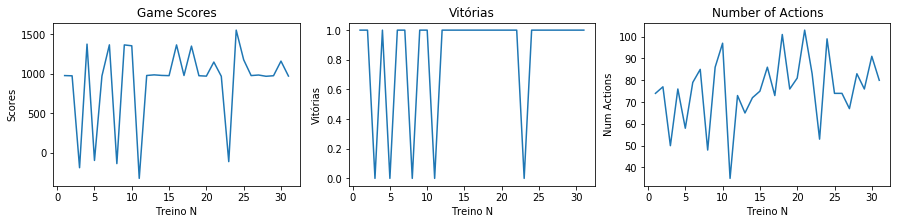

Wins:  26  Loss:  5


In [13]:
fig = plt.figure(figsize=(15, 3))
plt.subplot(131)
plt.xlabel('Treino N')
plt.ylabel('Scores')
plt.title('Game Scores')
plt.plot(range(1,len(gamesScores)+1),gamesScores[:])

plt.subplot(132)
plt.xlabel('Treino N')
plt.ylabel('Vitórias')
plt.title('Vitórias')
plt.plot(range(1,len(gamesScores)+1),results[:])

plt.subplot(133)
plt.xlabel('Treino N')
plt.ylabel('Num Actions')
plt.title('Number of Actions')
plt.plot(range(1,len(gamesScores)+1),numActions[:])
plt.show()

print("Wins: ",results.count(True)," Loss: ",results.count(False))

In [14]:
layoutType='mediumClassic'
pacman.setIsTrain(False)
gamesScores, results, numActions = approxQLearning(pacman, layoutType,30,pacman.n_train)

layout:  mediumClassic
------------------------------------------ train --------------------
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.006944444444444444 0
STATE VARS:  0.418 -0.00510204081632653 1.0 0.00510204081632653 0
Action Score:  [3.157519094342824, 3.155969072129211]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.006944444444444444 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.005917159763313609 1.0 0.008264462809917356 0
STATE VARS:  0.398 -0.00510204081632653 1.0 0.005917159763313609 0
Action Score:  [3.1561261896257276, 3.0935019684819713]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.005917159763313609 1.0 0.008264462809917356 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.006944444444444444 1.0 0.01 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0.006944444444444444 0
Action Score:  [3.1554655180943363, 0.7658247350434463]


STATE VARS:  -0.002 0 1.0 0.00390625 0.006944444444444444
STATE VARS:  -0.002 0 1.0 0.0030864197530864196 0.01
Action Score:  [1.84949657806002, 1.8517158475278082]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 0.0030864197530864196 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.002770083102493075 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.002770083102493075 0.008264462809917356
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.012345679012345678
Action Score:  [0.46402367896362734, 0.4637603044149946, 0.4637603044149946, 1.9165805458603102]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.008264462809917356
STATE VARS:  0.018 0 1.0 0.00390625 

STATE VARS:  0.418 -0.005917159763313609 1.0 0.25 0
STATE VARS:  0.398 -0.008264462809917356 1.0 0.0625 0
Action Score:  [3.248380539495536, 3.1110230764809774]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.005917159763313609 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.005917159763313609 1.0 1.0 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.1111111111111111 0
Action Score:  [3.534605573706992, 0.8045284437227007]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.005917159763313609 1.0 1.0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.002 0 1.0 1.0 0.005917159763313609
STATE VARS:  0.042444444444444444 -0.0044444444444444444 0.1111111111111111 0.25 0
Action Score:  [2.228787889069972, 0.4283058068142437]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.005917159763313609
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION: 

STATE VARS:  0.018 0 1.0 0 1.0
STATE VARS:  -0.002 0 1.0 0 0.1111111111111111
Action Score:  [2.7337308208203437, 1.934328915460385]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 1.0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0 0.25
STATE VARS:  0.818 -0.012345679012345678 1.0 0 0
Action Score:  [0.6630297966253883, 4.4002566942469645]
['South', 'East', 'Stop']
STATE VARS:  0.818 -0.012345679012345678 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.008264462809917356 1.0 0 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0 0
Action Score:  [3.149949170541913, 0.7538456295347428]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.008264462809917356 1.0 0 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0 0
Action Score:  [3.149

STATE VARS:  0.014 -0.008264462809917356 0.04 0 0
STATE VARS:  0.006163265306122449 -0.005917159763313609 0.02040816326530612 0 0
STATE VARS:  0.006163265306122449 -0.005917159763313609 0.02040816326530612 0 0
STATE VARS:  0.014 -0.008264462809917356 0.04 0 0
Action Score:  [0.10724231245665461, 0.04945046569679822, 0.04945046569679822, 0.10724231245665461]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.014 -0.008264462809917356 0.04 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.023 -0.008264462809917356 0.0625 0 0
STATE VARS:  0.009111111111111111 -0.005917159763313609 0.027777777777777776 0 0
Action Score:  [0.17708439084353042, 0.07232642989506946]
['North', 'South', 'Stop']
STATE VARS:  0.023 -0.008264462809917356 0.0625 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.014 -0.005917159763313609 0.04 0 0
STATE VARS:  0.042444444444444444 -0.008264462809917356 0.111

STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
Action Score:  [0.7434621874918079, 3.1446930893424936]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.012345679012345678 0.25 0 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
Action Score:  [0.7538456295347428, 3.1446930893424936]
['North', 'East', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.008264462809917356 1.0 0 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0 0
Action Score:  [3.149949170541913, 3.1446930893424936, 0.7591017107341622]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  A

STATE VARS:  0.418 -0.005917159763313609 1.0 0.008264462809917356 0
STATE VARS:  0.398 -0.00510204081632653 1.0 0.005917159763313609 0
Action Score:  [3.1561261896257276, 3.0935019684819713]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.005917159763313609 1.0 0.008264462809917356 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.006944444444444444 1.0 0.01 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0.006944444444444444 0
Action Score:  [3.1554655180943363, 0.7658247350434463]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0.01 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.008264462809917356 1.0 0.012345679012345678 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.008264462809917356 0
Action Score:  [3.1546606937388093, 0.765278729817977]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0.012345679012345678 0
W:  [[3.138909

STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.0625
STATE VARS:  0.018 0 1.0 0.00390625 0.027777777777777776
Action Score:  [0.5088261104082229, 1.9295393768626201]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00390625 0.027777777777777776
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.0625
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.04
Action Score:  [0.5089687603320044, 1.9398733460473123]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.04
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.00390625 0.04
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.0625
Action Score:  [0.4904931969535501, 1.958770094814665]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.0625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.004444

STATE VARS:  0.418 -0.0044444444444444444 1.0 0.25 0.0030864197530864196
STATE VARS:  0.398 -0.005917159763313609 1.0 0.0625 0.00390625
Action Score:  [3.252834928549481, 3.117283216676957]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.25 0.0030864197530864196
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.005917159763313609 1.0 1.0 0.002770083102493075
STATE VARS:  0.098 -0.005917159763313609 0.25 0.1111111111111111 0.0034602076124567475
Action Score:  [3.5369011462575575, 0.8073959236215038]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.005917159763313609 1.0 1.0 0.002770083102493075
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.002 0 1.0 1.0 0.008264462809917356
STATE VARS:  0.042444444444444444 -0.005917159763313609 0.1111111111111111 0.25 0.0034602076124567475
Action Score:  [2.2307331030734043, 0.429276618926861]
['North', 'South', 'Stop']

STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0 0.015625
Action Score:  [1.9280486214761021, 0.46880283785490146]
['South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.1111111111111111 0 0.027777777777777776
STATE VARS:  -0.002 0 1.0 0 0.0625
Action Score:  [0.22213375870148705, 1.894044805493173]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 0 0.0625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  -0.002 0 0.25 0 0.04
Action Score:  [0.4890024415670321, 1.9971070957056085, 0.4890024415670321, 0.4890024415670321]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   - 

STATE VARS:  0.0013057851239669422 -0.027777777777777776 0.008264462809917356 0 0
STATE VARS:  0.0003668639053254439 -0.027777777777777776 0.005917159763313609 0 0
Action Score:  [-0.01639836471493053, -0.023684610198426145]
['North', 'South', 'Stop']
STATE VARS:  0.0013057851239669422 -0.027777777777777776 0.008264462809917356 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.0007777777777777776 -0.027777777777777776 0.006944444444444444 0 0
STATE VARS:  0.002 -0.0625 0.01 0 0
Action Score:  [-0.02049582365508497, -0.055728850290007195]
['South', 'East', 'Stop']
STATE VARS:  0.0007777777777777776 -0.027777777777777776 0.006944444444444444 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.0013057851239669422 -0.0625 0.008264462809917356 0 0
STATE VARS:  0.0003668639053254439 -0.027777777777777776 0.005917159763313609 0 0
Action Score:  [-0.06111611804436676, -0.023684610198426145]
['

STATE VARS:  -0.0006159169550173009 -0.027777777777777776 0.0034602076124567475 0 0
STATE VARS:  -0.0006159169550173009 -0.015625 0.0034602076124567475 0 0
Action Score:  [-0.03131121663011273, -0.01566000296481005]
['North', 'South', 'Stop']
STATE VARS:  -0.0006159169550173009 -0.015625 0.0034602076124567475 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.0007654320987654322 -0.027777777777777776 0.0030864197530864196 0 0
STATE VARS:  -0.0004375 -0.015625 0.00390625 0 0
Action Score:  [-0.03247148867341073, -0.014275446191713823]
['North', 'East', 'Stop']
STATE VARS:  -0.0004375 -0.015625 0.00390625 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.00022222222222222231 -0.027777777777777776 0.0044444444444444444 0 0
STATE VARS:  -0.0006159169550173009 -0.027777777777777776 0.0034602076124567475 0 0
Action Score:  [-0.02825605458696006, -0.03131121663011273]
['East', 'West', 'Stop

STATE VARS:  -0.0006159169550173009 -0.01 0.0034602076124567475 0 0
STATE VARS:  -0.0006159169550173009 -0.015625 0.0034602076124567475 0 0
Action Score:  [-0.008415726925441382, -0.01566000296481005]
['North', 'South', 'Stop']
STATE VARS:  -0.0006159169550173009 -0.01 0.0034602076124567475 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.0004375 -0.01 0.00390625 0 0
STATE VARS:  -0.0007654320987654322 -0.01 0.0030864197530864196 0 0
Action Score:  [-0.007031170152345156, -0.009575998968739381]
['North', 'South', 'Stop']
STATE VARS:  -0.0004375 -0.01 0.00390625 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.00022222222222222231 -0.01 0.0044444444444444444 0 0
STATE VARS:  -0.0006159169550173009 -0.006944444444444444 0.0034602076124567475 0 0
Action Score:  [-0.005360564882288714, -0.004480564632450995]
['North', 'South', 'Stop']
STATE VARS:  -0.0006159169550173009 -0.0069444444

STATE VARS:  -0.0006159169550173009 -0.015625 0.0034602076124567475 0 0
STATE VARS:  -0.0006159169550173009 -0.015625 0.0034602076124567475 0 0
Action Score:  [-0.01566000296481005, -0.01566000296481005]
['North', 'South', 'Stop']
STATE VARS:  -0.0006159169550173009 -0.015625 0.0034602076124567475 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.0004375 -0.027777777777777776 0.00390625 0 0
STATE VARS:  -0.0007654320987654322 -0.015625 0.0030864197530864196 0 0
Action Score:  [-0.029926659857016504, -0.01682027500810805]
['North', 'South', 'Stop']
STATE VARS:  -0.0007654320987654322 -0.015625 0.0030864197530864196 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.0006159169550173009 -0.027777777777777776 0.0034602076124567475 0 0
STATE VARS:  -0.0006159169550173009 -0.027777777777777776 0.0034602076124567475 0 0
Action Score:  [-0.03131121663011273, -0.03131121663011273]
['North', 

STATE VARS:  0.398 -0.015625 1.0 0 0
STATE VARS:  0.042444444444444444 -0.01 0.1111111111111111 0 0
Action Score:  [3.0776915657272674, 0.3257426215443818]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.015625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.098 -0.015625 0.25 0 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
STATE VARS:  0.418 -0.015625 1.0 0 0
STATE VARS:  0.098 -0.015625 0.25 0 0
Action Score:  [0.7496222861647404, 3.1248185323071884, 3.1404697459724913, 0.7496222861647404]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.015625 1.0 0 0
STATE VARS:  0.398 -0.027777777777777776 1.0 0 0
Action Score:  [3.1404697459724913, 3.062040352061965]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  

STATE VARS:  0.418 -0.006944444444444444 1.0 0.01 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0.006944444444444444 0
Action Score:  [3.1554655180943363, 0.7658247350434463]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0.01 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.008264462809917356 1.0 0.012345679012345678 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.008264462809917356 0
Action Score:  [3.1546606937388093, 0.765278729817977]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0.012345679012345678 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.015625 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0.01 0
Action Score:  [3.1506561108885656, 0.7629180445236483]
['North', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.015625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0

STATE VARS:  0.418 -0.027777777777777776 1.0 0.0044444444444444444 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0044444444444444444 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0.0044444444444444444 0
STATE VARS:  0.398 -0.0625 1.0 0.005917159763313609 0
Action Score:  [3.126514680658071, 3.126514680658071, 0.7356672208503205, 3.019580784406781]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0.0044444444444444444 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.027777777777777776 1.0 0.00390625 0
STATE VARS:  0.398 -0.0625 1.0 0.00510204081632653 0
Action Score:  [3.126309287693706, 3.019269707808797]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0.00390625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.0625 0.25 0.0044444444444444444 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.00444444444444

STATE VARS:  0.018 0 1.0 0 0.006944444444444444
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
Action Score:  [1.9107840029187255, 1.909257199917053, 1.9107840029187255, 0.4600824437876551]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
STATE VARS:  -0.002 0 1.0 0 0.00510204081632653
Action Score:  [1.9107840029187255, 1.8464790196718293]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0 0.006944444444444444
STATE VARS:  -0.002 0 0.1111111111111111 0 0.01
Action Score:  [0.4616092467893279, 0.20740128419919235]
['South', 'East', 'Stop']
STATE VARS:  -0.002 0 0.25 0 0.00694444444444444

STATE VARS:  -0.002 0 0.25 0 0.027777777777777776
STATE VARS:  0.018 0 1.0 0 0.0625
Action Score:  [0.4788738653467045, 1.9568229857383965]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0 0.04
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  0.018 0 1.0 0 0.04
Action Score:  [1.9381771976964297, 1.9971070957056085, 0.4890024415670321, 1.9381771976964297]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0 0.1111111111111111
STATE VARS:  0.018 0 1.0 0 1.0
Action Score:  [1.934328915460385, 2.7337308208203437]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 1.0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.25

STATE VARS:  0.014 -0.04 0.04 0 0
STATE VARS:  0.014 -0.0625 0.04 0 0
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0 0
STATE VARS:  0.014 -0.04 0.04 0 0
Action Score:  [0.06637102504996857, 0.0373939208924939, 0.19552452384906352, 0.06637102504996857]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.098 -0.1111111111111111 0.25 0 0
STATE VARS:  0.023 -0.04 0.0625 0 0
Action Score:  [0.6266484645087909, 0.1362131034368444]
['East', 'West', 'Stop']
STATE VARS:  0.098 -0.1111111111111111 0.25 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.398 -0.1111111111111111 1.0 0 0
STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0 0
Action Score:  [2.954717744071318, 0.2871064826677489]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.11111111111

STATE VARS:  0.398 -0.00390625 1.0 0 0
STATE VARS:  0.042444444444444444 -0.00510204081632653 0.1111111111111111 0 0
Action Score:  [3.0927838074759526, 0.3320505625854647]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.00390625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.00390625 1.0 0 0
STATE VARS:  0.098 -0.00390625 0.25 0 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0 0
Action Score:  [3.1555619877211756, 0.7647145279134251, 0.763174503245192]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.418 -0.00390625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.00390625 1.0 0 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0 0
Action Score:  [3.1555619877211756, 0.763174503245192]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.00390625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.0030864

STATE VARS:  0.018 0 1.0 0.002066115702479339 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.00390625
Action Score:  [1.910045698633889, 0.4597540478659407]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.00510204081632653
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.00510204081632653
Action Score:  [1.9116493847304004, 0.46080386794445777]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.006944444444444444
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.0025 0.008264462809917356
Action Score:  [1.9107211890834228, 0.461546432954025, 1.912831987817391]
['North', 

STATE VARS:  0.018 0 1.0 0.01 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0.015625 0.04
Action Score:  [2.000923429495095, 0.49496546311310413]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.01 0.1111111111111111
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.25 0.008264462809917356 1.0
STATE VARS:  0.018 0 1.0 0.008264462809917356 1.0
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.1111111111111111
Action Score:  [1.28771005955829, 2.7368848156876875, 0.5526438627731073]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.008264462809917356 1.0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.098 -0.1111111111111111 0.25 0.006944444444444444 0
STATE VARS:  0.418 -0.04 1.0 0.006944444444444444 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.01 0
Action Score:  [0.629298696307045, 3.111728114933481, 0.630464798298277]
['South', 'East', 'West', 'Stop']
STATE VARS: 

STATE VARS:  0.398 -0.02040816326530612 1.0 0.027777777777777776 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0625 0
Action Score:  [3.082132394247352, 3.1685451755267815]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.012345679012345678 1.0 0.1111111111111111 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.04 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.04 0
Action Score:  [3.187096798114561, 3.159958424500438, 0.7587275226497523]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.012345679012345678 1.0 0.25 0
STATE VARS:  0.398 -0.02040816326530612 1.0 0.0625 0
Action Score:  [3.2401014340796452, 3.0953835532386234]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.

STATE VARS:  0.023 -0.027777777777777776 0.0625 0 0.008264462809917356
STATE VARS:  0.009111111111111111 -0.015625 0.027777777777777776 0 0.008264462809917356
Action Score:  [0.15880252691255864, 0.0666727554129295]
['North', 'East', 'Stop']
STATE VARS:  0.023 -0.027777777777777776 0.0625 0 0.008264462809917356
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.042444444444444444 -0.027777777777777776 0.1111111111111111 0 0.012345679012345678
STATE VARS:  0.014 -0.015625 0.04 0 0.008264462809917356
Action Score:  [0.31307801691074844, 0.1046116621909855]
['North', 'South', 'Stop']
STATE VARS:  0.042444444444444444 -0.027777777777777776 0.1111111111111111 0 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0.01
STATE VARS:  0.023 -0.015625 0.0625 0 0.01
STATE VARS:  -0.002 0 0.0625 0 0.015625
STATE VARS:  0.098 -0.015625 0.25 0 0.01
Action 

STATE VARS:  0.006163265306122449 -0.015625 0.02040816326530612 0 0
STATE VARS:  0.0029382716049382715 -0.01 0.012345679012345678 0 0
Action Score:  [0.036948016910905546, 0.019165597075242437]
['East', 'West', 'Stop']
STATE VARS:  0.006163265306122449 -0.015625 0.02040816326530612 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.00425 -0.015625 0.015625 0 0
STATE VARS:  0.009111111111111111 -0.027777777777777776 0.027777777777777776 0 0
STATE VARS:  0.00425 -0.015625 0.015625 0 0
Action Score:  [0.022100636301450663, 0.04417276744387412, 0.022100636301450663]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.009111111111111111 -0.027777777777777776 0.027777777777777776 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.006163265306122449 -0.027777777777777776 0.02040816326530612 0 0
STATE VARS:  0.014 -0.0625 0.04 0 0
STATE VARS:  0.006163265306122449 -0.027777777777777776 0.0204081632

STATE VARS:  0.418 -0.005917159763313609 1.0 0.008264462809917356 0
STATE VARS:  0.398 -0.00510204081632653 1.0 0.005917159763313609 0
Action Score:  [3.1561261896257276, 3.0935019684819713]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.005917159763313609 1.0 0.008264462809917356 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.006944444444444444 1.0 0.01 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0.006944444444444444 0
Action Score:  [3.1554655180943363, 0.7658247350434463]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0.01 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.008264462809917356 1.0 0.012345679012345678 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.008264462809917356 0
Action Score:  [3.1546606937388093, 0.765278729817977]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0.012345679012345678 0
W:  [[3.138909

STATE VARS:  -0.002 0 1.0 0.00510204081632653 0.015625
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.027777777777777776
Action Score:  [1.857146522815344, 1.9306988532743563]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.027777777777777776
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.04
Action Score:  [0.47502483901426557, 1.9413311925637735]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.04
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.01 0.04
Action Score:  [0.4754168851382677, 0.4754168851382677, 1.9419935314859158]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.01 0.04

STATE VARS:  0.098 -0.0625 0.25 0 0.02040816326530612
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0.012345679012345678
Action Score:  [0.706165598573146, 3.1350494173782266]
['South', 'East', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.015625 1.0 0 0.01
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0.015625
Action Score:  [3.1487567628800317, 0.7469195364174702]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.015625 1.0 0 0.006944444444444444
STATE VARS:  0.098 -0.015625 0.25 0 0.01
Action Score:  [3.1462246188249496, 0.7579093030722812]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0 0.006944444444444444
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.027777777

STATE VARS:  0.098 -0.0625 0.25 0 0.005917159763313609
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0.008264462809917356
Action Score:  [0.6941568794703215, 3.1316673066109413]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0.008264462809917356
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.0625 0.25 0 0.006944444444444444
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0.01
Action Score:  [0.6950081920224604, 3.1331055492147293]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.0625 0.25 0 0.006944444444444444
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0.01
Action Score:  [0.6950081920224604, 3.1331055492147293]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
ST

STATE VARS:  0.398 -0.006944444444444444 1.0 0 0
STATE VARS:  0.042444444444444444 -0.00510204081632653 0.1111111111111111 0 0
Action Score:  [3.0888710040596266, 0.3320505625854647]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.006944444444444444 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.01 1.0 0 0
STATE VARS:  0.418 -0.006944444444444444 1.0 0 0
STATE VARS:  0.098 -0.01 0.25 0 0
STATE VARS:  0.098 -0.006944444444444444 0.25 0 0
Action Score:  [3.1477140220118596, 3.1516491843048504, 0.7568665622041091, 0.7608017244970995]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.398 -0.01 1.0 0 0
STATE VARS:  0.418 -0.006944444444444444 1.0 0 0
Action Score:  [3.0849358417666366, 3.1516491843048504]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0 0
W:  [[3.13

STATE VARS:  0.0003668639053254439 -0.0625 0.005917159763313609 0 0
STATE VARS:  -0.00022222222222222231 -0.027777777777777776 0.0044444444444444444 0 0
STATE VARS:  0.0003668639053254439 -0.027777777777777776 0.005917159763313609 0 0
STATE VARS:  -0.00022222222222222231 -0.0625 0.0044444444444444444 0 0
Action Score:  [-0.06840236352786237, -0.02825605458696006, -0.023684610198426145, -0.07297380791639628]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.0003668639053254439 -0.027777777777777776 0.005917159763313609 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.0007777777777777776 -0.027777777777777776 0.006944444444444444 0 0
STATE VARS:  4.081632653061229e-05 -0.0625 0.00510204081632653 0 0
Action Score:  [-0.02049582365508497, -0.070932568034089]
['East', 'West', 'Stop']
STATE VARS:  0.0007777777777777776 -0.027777777777777776 0.006944444444444444 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  

Average Score: 1924.0
Scores:        1924.0
Win Rate:      1/1 (1.00)
Record:        Win
[[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]
1924.0
------------------------------------------ train --------------------
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.006944444444444444 0
STATE VARS:  0.418 -0.00510204081632653 1.0 0.00510204081632653 0
Action Score:  [3.157519094342824, 3.155969072129211]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.006944444444444444 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.005917159763313609 1.0 0.008264462809917356 0
STATE VARS:  0.398 -0.00510204081632653 1.0 0.005917159763313609 0
Action Score:  [3.1561261896257276, 3.0935019684819713]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.005917159763313609 1.0 0.008264462809917356 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.006944444444444444 1.0

STATE VARS:  -0.002 0 1.0 0.00390625 0.008264462809917356
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.012345679012345678
Action Score:  [1.850590479511314, 1.917207124213573]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.01
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.01
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.01
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.015625
Action Score:  [1.91501229532469, 1.91501229532469, 0.4658375391952925, 1.9202357796585512]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.00510204081632653 0.01
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.015625
Action Score:  [1.8524850758048523, 1.9206278257825533]
['

STATE VARS:  -0.002 0 0.0625 0 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
STATE VARS:  -0.002 0 0.1111111111111111 0 0.015625
Action Score:  [0.11948611503686347, 0.47276665334001344, 0.21206273120968402]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.002 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.1111111111111111 0 0.015625
Action Score:  [1.8652704412308787, 0.21206273120968402]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 0 0.027777777777777776
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0 0.0625
STATE VARS:  -0.002 0 0.25 0 0.027777777777777776
Action Score:  [1.9280486214761021, 1.9280486214761021, 0.5076482296089988, 0.4788738653467045]
['North', '

STATE VARS:  -0.002 0 0.25 0 0.006944444444444444
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
Action Score:  [0.4616092467893279, 1.9107840029187255]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.005917159763313609
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
Action Score:  [0.460757934237189, 1.9118779043700194]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
Action Score:  [0.46270314824062175, 1.9152600151373047]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.01
STATE VARS:  0.018 0 1.0 0 0.015625
Act

STATE VARS:  0.418 -0.04 1.0 0 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
Action Score:  [3.109077883135227, 3.134309647299559, 0.7434621874918079]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.398 -0.04 1.0 0 0
STATE VARS:  0.398 -0.02040816326530612 1.0 0 0
Action Score:  [3.0462997028900034, 3.071531467054335]
['North', 'South', 'Stop']
STATE VARS:  0.398 -0.02040816326530612 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
Action Score:  [0.7182304233274762, 3.134309647299559, 0.7434621874918079, 0.7434621874918079]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418

STATE VARS:  0.014 -0.027777777777777776 0.04 0 0
STATE VARS:  0.042444444444444444 -0.0625 0.1111111111111111 0 0
Action Score:  [0.08211167422193012, 0.25812937851027423]
['North', 'South', 'Stop']
STATE VARS:  0.042444444444444444 -0.0625 0.1111111111111111 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.023 -0.027777777777777776 0.0625 0 0
STATE VARS:  0.023 -0.027777777777777776 0.0625 0 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
STATE VARS:  0.023 -0.0625 0.0625 0 0
Action Score:  [0.15195375260880595, 0.15195375260880595, 0.7339710724994377, 0.10723599927936972]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.398 -0.027777777777777776 1.0 0 0
STATE VARS:  0.042444444444444444 -0.0625 0.1111111111111111 0 0
Action Score:  [3.062040352061965, 0.25812937851027423]
['East', 'West',

STATE VARS:  0.018 0 1.0 0.001736111111111111 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.008264462809917356
Action Score:  [1.9159225730868683, 0.4633657061901853]
['North', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.0016 0.012345679012345678
Action Score:  [1.922662833626214, 0.46669587241422483]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.02040816326530612
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.015625
Action Score:  [1.9288371201929382, 0.469465395804465]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.027777777777777776
W:  [[

STATE VARS:  0.418 -0.1111111111111111 1.0 0.00390625 0.02040816326530612
STATE VARS:  -0.002 0 1.0 0.00510204081632653 0.04
Action Score:  [3.0358989591062038, 1.8773461265274747]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.1111111111111111 1.0 0.00390625 0.02040816326530612
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.1111111111111111 0.25 0.0044444444444444444 0.04
STATE VARS:  -0.382 -1.0 1.0 0.0044444444444444444 0.02040816326530612
Action Score:  [0.6614926804898367, -0.6197973429719401]
['South', 'West', 'Stop']
STATE VARS:  0.098 -0.1111111111111111 0.25 0.0044444444444444444 0.04
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.402 -1.0 1.0 0.00390625 0.027777777777777776
STATE VARS:  0.398 -0.1111111111111111 1.0 0.00510204081632653 0.0625
Action Score:  [-0.6766737041748372, 3.0084587088197163]
['North', 'South', 'Stop']
STATE VARS:  0.398 -0.1111111111111111 1.

STATE VARS:  0.098 -0.008264462809917356 0.25 0.00510204081632653 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.006944444444444444 0
Action Score:  [0.7610488198104306, 3.1473433211407476]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.006944444444444444 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.012345679012345678 0.25 0.005917159763313609 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.008264462809917356 0
Action Score:  [0.756103815208995, 3.137463642166902]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.008264462809917356 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.02040816326530612 1.0 0.01 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.006944444444444444 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.006944444444444444 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.01 0
Action Score:  [3.13812598108

STATE VARS:  -0.002 0 0.25 0 1.0
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
STATE VARS:  -0.402 -1.0 0.25 0 0.1111111111111111
Action Score:  [1.284556064690946, 1.9971070957056085, -1.9955025612160229]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0.0625
STATE VARS:  -0.402 -1.0 0.25 0 0.25
Action Score:  [3.0692897799886714, -1.8804051041668457]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0.0625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0 0.027777777777777776
STATE VARS:  0.014 -0.1111111111111111 0.04 0 0.0625
Action Score:  [0.31012597407758435, 0.026582921903412993]
['East', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0 0.027777777777777776
W:  [[3.13890901 1.2878713

STATE VARS:  0.098 -0.1111111111111111 0.25 0 0.01
STATE VARS:  -0.402 -1.0 0.0625 0 0.015625
Action Score:  [0.6349354814163316, -2.4212312069083763]
['East', 'West', 'Stop']
STATE VARS:  0.098 -0.1111111111111111 0.25 0 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.398 -0.1111111111111111 1.0 0 0.008264462809917356
STATE VARS:  -0.402 -1.0 0.1111111111111111 0 0.012345679012345678
Action Score:  [2.961566518375071, -2.334089748429544]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.1111111111111111 1.0 0 0.008264462809917356
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.098 -0.04 0.25 0 0.012345679012345678
STATE VARS:  0.098 -0.04 0.25 0 0.008264462809917356
STATE VARS:  0.418 -0.04 1.0 0 0.008264462809917356
STATE VARS:  0.098 -0.1111111111111111 0.25 0 0.012345679012345678
Action Score:  [0.7284613083985142, 0.725079197631229, 3.1159266574389797, 0.6368793495798288]
['North', 

STATE VARS:  0.009111111111111111 -0.008264462809917356 0.027777777777777776 0 0
STATE VARS:  0.009111111111111111 -0.008264462809917356 0.027777777777777776 0 0
STATE VARS:  0.023 -0.012345679012345678 0.0625 0 0
Action Score:  [0.0693034056785986, 0.0693034056785986, 0.17182830964411094]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.023 -0.012345679012345678 0.0625 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.014 -0.008264462809917356 0.04 0 0
STATE VARS:  0.014 -0.008264462809917356 0.04 0 0
STATE VARS:  0.042444444444444444 -0.012345679012345678 0.1111111111111111 0 0
Action Score:  [0.10724231245665461, 0.10724231245665461, 0.32272168887501546]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.012345679012345678 0.1111111111111111 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.023 -0.008264462809917356 0.0625 0 0
STATE VARS:  0.098 -0.01234567901234

STATE VARS:  0.0007777777777777776 -0.04 0.006944444444444444 0 0
STATE VARS:  0.002 -0.1111111111111111 0.01 0 0
Action Score:  [-0.03623647282704652, -0.11833370495121791]
['East', 'West', 'Stop']
STATE VARS:  0.0007777777777777776 -0.04 0.006944444444444444 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.0013057851239669422 -0.04 0.008264462809917356 0 0
STATE VARS:  0.0013057851239669422 -0.1111111111111111 0.008264462809917356 0 0
Action Score:  [-0.03213901388689208, -0.12372097270557746]
['North', 'West', 'Stop']
STATE VARS:  0.0013057851239669422 -0.04 0.008264462809917356 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.002 -0.04 0.01 0 0
STATE VARS:  0.0007777777777777776 -0.1111111111111111 0.006944444444444444 0 0
Action Score:  [-0.02675174613253252, -0.1278184316457319]
['North', 'South', 'Stop']
STATE VARS:  0.002 -0.04 0.01 0 0
W:  [[3.13890901 1.2878713  1.84852877

STATE VARS:  0.418 -0.04 1.0 0 0
STATE VARS:  0.398 -0.1111111111111111 1.0 0 0
Action Score:  [3.109077883135227, 2.954717744071318]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.023 -0.04 0.0625 0 0
Action Score:  [0.7182304233274762, 0.1362131034368444]
['South', 'East', 'Stop']
STATE VARS:  0.098 -0.04 0.25 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0 0
STATE VARS:  0.398 -0.04 1.0 0 0
Action Score:  [0.31233824683208056, 3.0462997028900034]
['North', 'South', 'Stop']
STATE VARS:  0.398 -0.04 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  1.418 -0.04 1.0 0 0
STATE VARS:  0.098 -0.02040

STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.0025 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0.0025 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.02040816326530612
Action Score:  [1.9231192902686354, 1.9162140985846763, 0.46703934245527856, 1.9231192902686354]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.02040816326530612
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.027777777777777776
STATE VARS:  -0.002 0 1.0 0.002770083102493075 0.015625
Action Score:  [1.9293691521991077, 1.8562565699134486]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.027777777777777776
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.015625
STATE VARS:  0.018 0 1.0 0.00390625 0.02777777777777

STATE VARS:  0.042444444444444444 -0.0044444444444444444 0.1111111111111111 0.25 0.0030864197530864196
STATE VARS:  -0.002 0 1.0 1.0 0.0034602076124567475
Action Score:  [0.4308635280820032, 2.226751808668455]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.0034602076124567475
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0 0.0030864197530864196
STATE VARS:  -0.002 0 0.25 0 0.00390625
Action Score:  [1.9075868513340262, 0.45909148991637716]
['South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0030864197530864196
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0030864197530864196
STATE VARS:  0.018 0 1.0 0 0.0034602076124567475
Action Score:  [0.4584120952046285, 1.9078966099650698]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0034602076124567475
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS: 

STATE VARS:  -1.402 -1.0 0.25 0 0.00510204081632653
STATE VARS:  0.098 -0.25 0.25 0 0.006944444444444444
STATE VARS:  0.418 -0.25 1.0 0 0.00510204081632653
Action Score:  [-5.222261469265756, 0.4535323240435048, 2.8428529808495826]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0 0.00510204081632653
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.25 0.25 0 0.00510204081632653
STATE VARS:  -1.402 -1.0 0.25 0 0.006944444444444444
STATE VARS:  0.418 -0.25 1.0 0 0.00510204081632653
Action Score:  [0.45200552104183206, -5.220734666264082, 2.8428529808495826]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0 0.00510204081632653
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -1.402 -1.0 0.25 0 0.005917159763313609
STATE VARS:  0.418 -0.25 1.0 0 0.0044444444444444444
Action Score:  [-5.221585978816222, 2.8423080296243706]
['East', 'West', 'Stop']
STATE VARS:  0

STATE VARS:  0.418 -0.0025 1.0 0 0
STATE VARS:  0.098 -0.0030864197530864196 0.25 0 0
Action Score:  [3.157373056731018, 0.7657703637559257]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.0025 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.0025 1.0 0 0
STATE VARS:  0.098 -0.0025 0.25 0 0
Action Score:  [3.157373056731018, 0.7665255969232674]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.0025 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.042444444444444444 -0.0025 0.1111111111111111 0 0
STATE VARS:  0.014 -0.002066115702479339 0.04 0 0
Action Score:  [0.33540165626354, 0.11522498577827298]
['North', 'South', 'Stop']
STATE VARS:  0.042444444444444444 -0.0025 0.1111111111111111 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.023 -0.002066115702479339 0.0625 0 0
STATE VARS:  0.023 -0.002066115702479339 0.062

STATE VARS:  0.014 -0.02040816326530612 0.04 0 0
STATE VARS:  0.006163265306122449 -0.012345679012345678 0.02040816326530612 0 0
Action Score:  [0.09160278921430026, 0.04117136028090786]
['East', 'West', 'Stop']
STATE VARS:  0.014 -0.02040816326530612 0.04 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.023 -0.02040816326530612 0.0625 0 0
STATE VARS:  0.009111111111111111 -0.012345679012345678 0.027777777777777776 0 0
Action Score:  [0.16144486760117607, 0.0640473244791791]
['East', 'West', 'Stop']
STATE VARS:  0.023 -0.02040816326530612 0.0625 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0 0
STATE VARS:  0.014 -0.012345679012345678 0.04 0 0
Action Score:  [0.31233824683208056, 0.1019862312572351]
['East', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0 0
W:  [[3.13890901 1.287

STATE VARS:  0.418 -0.01 1.0 0.012345679012345678 0
STATE VARS:  0.098 -0.006944444444444444 0.25 0.008264462809917356 0
Action Score:  [3.1524255452087564, 0.7639557193644433]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.01 1.0 0.012345679012345678 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.015625 1.0 0.015625 0
STATE VARS:  0.098 -0.01 0.25 0.01 0
Action Score:  [3.1464327675185633, 0.7606828959935952]
['North', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.015625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.027777777777777776 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.015625 0.25 0.012345679012345678 0
Action Score:  [3.132606968612262, 0.7543338093616367]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418

STATE VARS:  0.398 -0.027777777777777776 1.0 0.00510204081632653 0.006944444444444444
STATE VARS:  0.418 -0.015625 1.0 0.00390625 0.01
Action Score:  [3.069742333990692, 3.15024751826655]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.00390625 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.015625 0.25 0.0044444444444444444 0.008264462809917356
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.012345679012345678
STATE VARS:  0.418 -0.01 1.0 0.0034602076124567475 0.008264462809917356
Action Score:  [0.7581672088193758, 1.9165805458603102, 3.1558833270386177]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 -0.01 1.0 0.0034602076124567475 0.008264462809917356
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.01 1.0 0.0030864197530864196 0.005917159763313609
STATE VARS:  0.398 -0.015625 1.0 0.00390625 0.008264462809917356
Action Score:  [3.153795463111404,

STATE VARS:  0.398 -0.006944444444444444 1.0 0.027777777777777776 0
STATE VARS:  0.418 -0.00510204081632653 1.0 0.0625 0
Action Score:  [3.0994719312526438, 3.177874049237231]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.00510204081632653 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.00390625 1.0 0.1111111111111111 0
STATE VARS:  0.418 -0.00390625 1.0 0.04 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0.04 0
Action Score:  [3.1979656964932435, 3.17082732287912, 0.7784398384031364]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 -0.00390625 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.0030864197530864196 1.0 0.25 0
STATE VARS:  0.398 -0.00390625 1.0 0.0625 0
Action Score:  [3.2520261683008282, 3.1166358936602405]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.0030864197530864196 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.848

STATE VARS:  -0.002 0 0.25 0 0.027777777777777776
STATE VARS:  0.018 0 1.0 0 0.015625
Action Score:  [0.4788738653467045, 1.9179775939842991]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
Action Score:  [0.47276665334001344, 1.9152600151373047]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
STATE VARS:  0.018 0 1.0 0 0.015625
Action Score:  [0.47276665334001344, 1.9179775939842991]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.015625
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
Action Score:  [0.46880283785490146

STATE VARS:  0.023 -0.012345679012345678 0.0625 0 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0 0
Action Score:  [0.17182830964411094, 0.7591017107341622]
['North', 'South', 'Stop']
STATE VARS:  0.098 -0.008264462809917356 0.25 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.042444444444444444 -0.008264462809917356 0.1111111111111111 0 0
STATE VARS:  0.398 -0.008264462809917356 1.0 0 0
Action Score:  [0.32797777007443496, 3.0871709902966895]
['North', 'East', 'Stop']
STATE VARS:  0.398 -0.008264462809917356 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.098 -0.008264462809917356 0.25 0 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0 0
Action Score:  [0.7591017107341622, 3.1446930893424936, 0.7591017107341622]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
W:  [[3.13890901 1.2878713  1.8

STATE VARS:  0.398 -0.02040816326530612 1.0 0 0
STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0 0
Action Score:  [3.071531467054335, 0.2871064826677489]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.02040816326530612 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
Action Score:  [3.1446930893424936, 0.7538456295347428, 0.7434621874918079]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.008264462809917356 1.0 0 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0 0
Action Score:  [3.149949170541913, 0.7538456295347428]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.8287016

STATE VARS:  0.018 0 1.0 0.002066115702479339 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.00390625
Action Score:  [1.910045698633889, 0.4597540478659407]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.00510204081632653
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.00510204081632653
Action Score:  [1.9116493847304004, 0.46080386794445777]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.006944444444444444
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.0025 0.008264462809917356
Action Score:  [1.9107211890834228, 0.461546432954025, 1.912831987817391]
['North', 

STATE VARS:  -0.002 0 0.25 0.015625 0.015625
STATE VARS:  0.018 0 1.0 0.01 0.01
STATE VARS:  0.018 0 1.0 0.015625 0.015625
Action Score:  [0.4747658594009735, 1.9171324807632937, 1.923940615530371]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.015625 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.012345679012345678 0.015625
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.015625
Action Score:  [1.859910936935972, 1.9257660302893727]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.02040816326530612 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.015625 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.02040816326530612
Action Score:  [0.47204828055397907, 1.9325423366624281]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.027777777777777776 0.02040816326530612
W:  [[3.13890901 1.2878713  1.84852877 0.3816

STATE VARS:  -0.002 0 0.25 0 0.015625
STATE VARS:  0.018 0 1.0 0 0.01
Action Score:  [0.46880283785490146, 1.9133161469738074]
['North', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.01
STATE VARS:  -0.002 0 0.25 0 0.015625
Action Score:  [1.9133161469738074, 0.46880283785490146]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.027777777777777776 0 0.008264462809917356
STATE VARS:  -0.002 0 0.0625 0 0.012345679012345678
Action Score:  [0.05191897760827383, 0.11948611503686347]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.0625 0 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.04 0 0.012345679012345678
STATE VARS:  -0.002 0 0.1111111111111111 0 0.02040816326530612
Action Score:  [0.0

STATE VARS:  0.006163265306122449 -0.0625 0.02040816326530612 0 0
STATE VARS:  0.006163265306122449 -0.25 0.02040816326530612 0 0
STATE VARS:  0.014 -0.0625 0.04 0 0
Action Score:  [-0.023420950083833346, -0.2648968180627889, 0.0373939208924939]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.014 -0.0625 0.04 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.023 -0.0625 0.0625 0 0
STATE VARS:  0.009111111111111111 -0.0625 0.027777777777777776 0 0
Action Score:  [0.10723599927936972, -0.0005449858855621076]
['South', 'East', 'Stop']
STATE VARS:  0.023 -0.0625 0.0625 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.014 -0.0625 0.04 0 0
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0 0
Action Score:  [0.0373939208924939, 0.016653510531318638]
['North', 'South', 'Stop']
STATE VARS:  0.014 -0.0625 0.04 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  A

STATE VARS:  0.0003668639053254439 -0.027777777777777776 0.005917159763313609 0 0
STATE VARS:  -0.00022222222222222231 -0.0625 0.0044444444444444444 0 0
Action Score:  [-0.023684610198426145, -0.07297380791639628]
['North', 'South', 'Stop']
STATE VARS:  0.0003668639053254439 -0.027777777777777776 0.005917159763313609 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  4.081632653061229e-05 -0.0625 0.00510204081632653 0 0
STATE VARS:  0.0007777777777777776 -0.027777777777777776 0.006944444444444444 0 0
Action Score:  [-0.070932568034089, -0.02049582365508497]
['South', 'East', 'Stop']
STATE VARS:  0.0007777777777777776 -0.027777777777777776 0.006944444444444444 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.0003668639053254439 -0.027777777777777776 0.005917159763313609 0 0
STATE VARS:  0.0013057851239669422 -0.027777777777777776 0.008264462809917356 0 0
STATE VARS:  0.000366863905325443

STATE VARS:  0.098 -0.0625 0.25 0 0
STATE VARS:  0.418 -0.0625 1.0 0 0
STATE VARS:  0.098 -0.25 0.25 0 0
STATE VARS:  0.418 -0.0625 1.0 0 0
Action Score:  [0.6892533191700015, 3.0801007789777524, 0.44777745119104595, 3.0801007789777524]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.398 -0.25 1.0 0 0
STATE VARS:  0.418 -0.0625 1.0 0 0
Action Score:  [2.7758467307535732, 3.0801007789777524]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.25 0.25 0 0
STATE VARS:  0.023 -0.0625 0.0625 0 0
Action Score:  [0.44777745119104595, 0.10723599927936972]
['North', 'West', 'Stop']
STATE VARS:  0.098 -0.25 0.25 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -1.402 -1.0 1.0 0 0
STATE VARS:  0.042444444444

STATE VARS:  0.018 0 1.0 0.001890359168241966 0.00390625
STATE VARS:  -0.002 0 0.25 0.0016 0.0030864197530864196
Action Score:  [1.9089876702025776, 0.4590227086109463]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.00390625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.0034602076124567475
Action Score:  [1.9095007474086765, 0.4593844117852356]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.0044444444444444444
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.00390625
Action Score:  [1.9101225817287277, 0.4598129140731798]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.00510204081632653
W:  [[3.13890901

STATE VARS:  0.398 -0.1111111111111111 1.0 0.02040816326530612 0
STATE VARS:  0.418 -0.0625 1.0 0.04 0
Action Score:  [2.9625061803763915, 3.0953661141356967]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.04 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.0625 1.0 0.0625 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.027777777777777776 0
STATE VARS:  0.418 -0.25 1.0 0.027777777777777776 0
Action Score:  [3.1039528651620403, 0.6372493917018077, 2.8492258381918134]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.04 1.0 0.1111111111111111 0
STATE VARS:  0.398 -0.1111111111111111 1.0 0.04 0
Action Score:  [3.1514815919072943, 2.9699830792292623]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACT

STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.418 -0.04 1.0 0 0
STATE VARS:  0.098 -0.04 0.25 0 0
Action Score:  [3.017495924316542, 0.7182304233274762, 3.109077883135227, 0.7182304233274762]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
STATE VARS:  0.398 -0.04 1.0 0 0
Action Score:  [3.017495924316542, 3.0462997028900034]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.04 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.04 1.0 0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
STATE VARS:  0.398 -0.04 1.0 0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
Action Score:  [3.109077883135227, 0.7434621874918079, 3.0462997028900034, 0.7434621874918079]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.0

STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
Action Score:  [0.7182304233274762, 3.134309647299559]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.023 -0.04 0.0625 0 0
STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0 0
Action Score:  [0.1362131034368444, 0.31233824683208056]
['North', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.023 -0.02040816326530612 0.0625 0 0
STATE VARS:  0.023 -0.04 0.0625 0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
Action Score:  [0.16144486760117607, 0.1362131034368444, 0.7434621874918079]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.

STATE VARS:  0.0007777777777777776 -0.04 0.006944444444444444 0 0
STATE VARS:  4.081632653061229e-05 -0.02040816326530612 0.00510204081632653 0 0
Action Score:  [-0.03623647282704652, -0.016723699712282644]
['North', 'South', 'Stop']
STATE VARS:  4.081632653061229e-05 -0.02040816326530612 0.00510204081632653 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.0003668639053254439 -0.04 0.005917159763313609 0 0
STATE VARS:  -0.00022222222222222231 -0.02040816326530612 0.0044444444444444444 0 0
STATE VARS:  0.0003668639053254439 -0.02040816326530612 0.005917159763313609 0 0
STATE VARS:  -0.00022222222222222231 -0.04 0.0044444444444444444 0 0
Action Score:  [-0.0394252593703877, -0.01876493959458992, -0.014193495206056008, -0.04399670375892161]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.0003668639053254439 -0.02040816326530612 0.005917159763313609 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:

Pacman emerges victorious! Score: 2136
Average Score: 2136.0
Scores:        2136.0
Win Rate:      1/1 (1.00)
Record:        Win
[[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]
2136.0
------------------------------------------ train --------------------
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.006944444444444444 0
STATE VARS:  0.418 -0.00510204081632653 1.0 0.00510204081632653 0
Action Score:  [3.157519094342824, 3.155969072129211]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.006944444444444444 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.005917159763313609 1.0 0.008264462809917356 0
STATE VARS:  0.398 -0.00510204081632653 1.0 0.005917159763313609 0
Action Score:  [3.1561261896257276, 3.0935019684819713]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.005917159763313609 1.0 0.008264462809917356 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE

STATE VARS:  -0.002 0 1.0 0.00390625 0.008264462809917356
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.012345679012345678
Action Score:  [1.850590479511314, 1.917207124213573]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.015625
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.01
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.01
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.015625
Action Score:  [1.9196737423351817, 1.91501229532469, 0.4658375391952925, 1.9202357796585512]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.00510204081632653 0.015625
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.027777777777777776
Action Score:  [1.857146522815344, 1

STATE VARS:  0.018 0 1.0 0 0.04
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0 0.04
Action Score:  [1.9381771976964297, 1.9971070957056085, 0.4890024415670321]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
STATE VARS:  -0.002 0 1.0 0 0.04
Action Score:  [1.9971070957056085, 1.8753990174512063]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.0625
STATE VARS:  0.018 0 1.0 0 0.25
STATE VARS:  0.018 0 1.0 0 0.0625
STATE VARS:  -0.002 0 0.25 0 0.0625
Action Score:  [1.9568229857383965, 2.112204552754786, 1.9568229857383965, 0.5076482296089988]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.25
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.8287

STATE VARS:  0.042444444444444444 -0.027777777777777776 0.1111111111111111 0 0.008264462809917356
STATE VARS:  0.398 -0.0625 1.0 0 0.012345679012345678
Action Score:  [0.30969590614346315, 3.027553483803567]
['North', 'South', 'Stop']
STATE VARS:  0.398 -0.0625 1.0 0 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.0625 0.25 0 0.01
STATE VARS:  0.418 -0.0625 1.0 0 0.01
STATE VARS:  0.098 -0.0625 0.25 0 0.01
STATE VARS:  0.098 -0.25 0.25 0 0.015625
Action Score:  [0.6975403360775423, 3.0883877958852928, 0.6975403360775423, 0.4607259151090784]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.0625 0.25 0 0.015625
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0.01
Action Score:  [0.702201783088034, 3.1331055492147293]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.027777777777

STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
STATE VARS:  0.398 -0.015625 1.0 0 0
Action Score:  [3.1248185323071884, 3.0776915657272674]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.015625 0.25 0 0
STATE VARS:  0.023 -0.027777777777777776 0.0625 0 0
Action Score:  [0.7496222861647404, 0.15195375260880595]
['South', 'East', 'Stop']
STATE VARS:  0.098 -0.015625 0.25 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.042444444444444444 -0.015625 0.1111111111111111 0 0
STATE VARS:  0.398 -0.01 1.0 0 0
Action Score:  [0.3184983455050131, 3.0849358417666366]
['North', 'South', 'Stop']
STATE VARS:  0.398 -0.01 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.015625 0.25 0 0
STATE VARS:  0.098 -0.01 0.25 0 0
STATE VARS:  0.418 -0.015625 1.0 0

STATE VARS:  0.0003668639053254439 -0.008264462809917356 0.005917159763313609 0 0
STATE VARS:  -0.00022222222222222231 -0.005917159763313609 0.0044444444444444444 0 0
Action Score:  [0.0014460280362983413, -0.00010239213576471]
['North', 'West', 'Stop']
STATE VARS:  0.0003668639053254439 -0.008264462809917356 0.005917159763313609 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.0007777777777777776 -0.008264462809917356 0.006944444444444444 0 0
STATE VARS:  4.081632653061229e-05 -0.005917159763313609 0.00510204081632653 0 0
Action Score:  [0.004634814579639518, 0.0019388477465425696]
['North', 'South', 'Stop']
STATE VARS:  0.0007777777777777776 -0.008264462809917356 0.006944444444444444 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.0003668639053254439 -0.008264462809917356 0.005917159763313609 0 0
STATE VARS:  0.0013057851239669422 -0.012345679012345678 0.008264462809917356 0 0
S

STATE VARS:  0.0003668639053254439 -0.005917159763313609 0.005917159763313609 0 0
STATE VARS:  0.0013057851239669422 -0.008264462809917356 0.008264462809917356 0 0
STATE VARS:  0.0003668639053254439 -0.005917159763313609 0.005917159763313609 0 0
Action Score:  [0.0044690522527692025, 0.008732273519793953, 0.0044690522527692025]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.0013057851239669422 -0.008264462809917356 0.008264462809917356 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.002 -0.012345679012345678 0.01 0 0
STATE VARS:  0.0007777777777777776 -0.008264462809917356 0.006944444444444444 0 0
Action Score:  [0.008863460074734021, 0.004634814579639518]
['East', 'West', 'Stop']
STATE VARS:  0.002 -0.012345679012345678 0.01 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.0013057851239669422 -0.02040816326530612 0.008264462809917356 0 0
STATE VARS:  0.0013057851239669422 -0.0123

STATE VARS:  0.418 -0.25 1.0 0 0
STATE VARS:  0.098 -0.0625 0.25 0 0
Action Score:  [2.8386249109987967, 0.6892533191700015]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.25 0.25 0 0
STATE VARS:  -1.382 -1.0 1.0 0 0
Action Score:  [0.44777745119104595, -3.777314782987143]
['South', 'East', 'Stop']
STATE VARS:  0.098 -0.25 0.25 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -1.402 -1.0 1.0 0 0
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0 0
Action Score:  [-3.840092963232367, 0.016653510531318638]
['North', 'South', 'Stop']
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -1.402 -1.0 0.25 0 0
STATE VARS:  0.023 -0.25 0.0625 0 0
STATE VARS:  0.023 -0.25 0.0625 0 0
Action Score:  [-5.2264895391165

STATE VARS:  0.418 -0.00510204081632653 1.0 1.0 0
STATE VARS:  0.098 -0.006944444444444444 0.25 0.1111111111111111 0
Action Score:  [3.5356553420015513, 0.8032054332691672]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.00510204081632653 1.0 1.0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.002 0 1.0 1.0 0.0044444444444444444
STATE VARS:  0.042444444444444444 -0.005917159763313609 0.1111111111111111 0.25 0
Action Score:  [2.2275674473952254, 0.4264091390280579]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.0044444444444444444
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.00510204081632653
Action Score:  [1.9099197578666165, 0.46074500173721866]
['North', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.00510204081632653
W:  [[3.13890901 1.2878713  1.84852877

STATE VARS:  -0.002 0 0.25 0.015625 0.04
STATE VARS:  0.018 0 1.0 0.01 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.015625 0.04
Action Score:  [0.49496546311310413, 2.000923429495095, 1.9441402192425017]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.01 0.1111111111111111
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0.012345679012345678 0.0625
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.25
Action Score:  [1.8987563286900693, 2.1153585476221295]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.25
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.01 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.006944444444444444 1.0
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.01 0.1111111111111111
Action Score:  [0.551748673365697, 2.736381052618598, 1.9997573275038627, 2.000923429495095

STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0.25 0
STATE VARS:  -0.002 0 1.0 1.0 0.0625
Action Score:  [0.11206185526847073, 2.2756781844417815]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.0625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0 0.0625
STATE VARS:  -0.002 0 0.25 0 0.1111111111111111
Action Score:  [1.9568229857383965, 0.5479323395762109]
['South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.1111111111111111
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
Action Score:  [0.5479323395762109, 1.9971070957056085]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.1111111111111111
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
Action Score:  

STATE VARS:  0.418 -0.01 1.0 0 0.0034602076124567475
STATE VARS:  0.398 -0.015625 1.0 0 0.0044444444444444444
Action Score:  [3.150581501910663, 3.0813746843528413]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.01 1.0 0 0.0034602076124567475
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.398 -0.006944444444444444 1.0 0 0.0030864197530864196
STATE VARS:  0.098 -0.01 0.25 0 0.00390625
Action Score:  [3.091428725327386, 0.7601036781836172]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.006944444444444444 1.0 0 0.0030864197530864196
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.098 -0.006944444444444444 0.25 0 0.0030864197530864196
STATE VARS:  0.418 -0.00510204081632653 1.0 0 0.00390625
STATE VARS:  0.098 -0.00510204081632653 0.25 0 0.0030864197530864196
STATE VARS:  0.098 -0.006944444444444444 0.25 0 0.00390625
Action Score:  [0.7633594457648589, 3.1572590790324506, 0.7657322245129515, 0

STATE VARS:  0.098 -0.015625 0.25 0 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
Action Score:  [0.7496222861647404, 3.1248185323071884]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.015625 0.25 0 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
Action Score:  [0.7496222861647404, 3.1248185323071884]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.015625 0.25 0 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
Action Score:  [0.7496222861647404, 3.1248185323071884]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.015625 0.25 0 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
Action Score:  [

STATE VARS:  -0.00022222222222222231 -0.0625 0.0044444444444444444 0 0
STATE VARS:  -0.0006159169550173009 -0.027777777777777776 0.0034602076124567475 0 0
Action Score:  [-0.07297380791639628, -0.03131121663011273]
['North', 'South', 'Stop']
STATE VARS:  -0.0006159169550173009 -0.027777777777777776 0.0034602076124567475 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.0004375 -0.0625 0.00390625 0 0
STATE VARS:  -0.0007654320987654322 -0.027777777777777776 0.0030864197530864196 0 0
Action Score:  [-0.07464441318645272, -0.03247148867341073]
['North', 'South', 'Stop']
STATE VARS:  -0.0007654320987654322 -0.027777777777777776 0.0030864197530864196 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.0006159169550173009 -0.0625 0.0034602076124567475 0 0
STATE VARS:  -0.0006159169550173009 -0.027777777777777776 0.0034602076124567475 0 0
Action Score:  [-0.07602896995954894, -0.03131121663

STATE VARS:  -0.00022222222222222231 -0.015625 0.0044444444444444444 0 0
STATE VARS:  -0.0006159169550173009 -0.015625 0.0034602076124567475 0 0
Action Score:  [-0.01260484092165738, -0.01566000296481005]
['East', 'West', 'Stop']
STATE VARS:  -0.00022222222222222231 -0.015625 0.0044444444444444444 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  4.081632653061229e-05 -0.027777777777777776 0.00510204081632653 0 0
STATE VARS:  -0.0004375 -0.015625 0.00390625 0 0
Action Score:  [-0.026214814704652784, -0.014275446191713823]
['East', 'West', 'Stop']
STATE VARS:  -0.0004375 -0.015625 0.00390625 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.00022222222222222231 -0.027777777777777776 0.0044444444444444444 0 0
STATE VARS:  -0.0006159169550173009 -0.015625 0.0034602076124567475 0 0
Action Score:  [-0.02825605458696006, -0.01566000296481005]
['East', 'West', 'Stop']
STATE VARS:  -0.000615916

STATE VARS:  0.014 -0.0625 0.04 0 0
STATE VARS:  0.006163265306122449 -0.027777777777777776 0.02040816326530612 0 0
Action Score:  [0.0373939208924939, 0.02129680324560287]
['East', 'West', 'Stop']
STATE VARS:  0.014 -0.0625 0.04 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.023 -0.25 0.0625 0 0
STATE VARS:  0.009111111111111111 -0.0625 0.027777777777777776 0 0
Action Score:  [-0.13423986869958587, -0.0005449858855621076]
['East', 'West', 'Stop']
STATE VARS:  0.009111111111111111 -0.0625 0.027777777777777776 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.014 -0.25 0.04 0 0
STATE VARS:  0.006163265306122449 -0.0625 0.02040816326530612 0 0
Action Score:  [-0.2040819470864617, -0.023420950083833346]
['East', 'West', 'Stop']
STATE VARS:  0.006163265306122449 -0.0625 0.02040816326530612 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS: 

STATE VARS:  0.418 -0.008264462809917356 1.0 1.0 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0.1111111111111111 0
Action Score:  [3.5315825494905217, 0.8015054195062299]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 1.0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.002 0 1.0 1.0 0.012345679012345678
STATE VARS:  0.042444444444444444 -0.008264462809917356 0.1111111111111111 0.25 0
Action Score:  [2.2341152138406897, 0.42338611481158706]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.015625
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.01
Action Score:  [1.9186401519338627, 0.46480394879397335]
['North', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION

STATE VARS:  0.098 -0.012345679012345678 0.25 0.0030864197530864196 0.00390625
STATE VARS:  0.398 -0.008264462809917356 1.0 0.0025 0.00390625
STATE VARS:  0.098 -0.008264462809917356 0.25 0.0025 0.0030864197530864196
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0030864197530864196 0.00390625
Action Score:  [0.758260626313475, 3.0913621897235695, 0.7626135154492932, 3.1491080861212257]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0030864197530864196 0.00390625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.012345679012345678 0.25 0.002770083102493075 0.0034602076124567475
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0034602076124567475 0.0044444444444444444
Action Score:  [0.7577702656079186, 3.1393132966481376]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0034602076124567475 0.0044444444444444444
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]

STATE VARS:  0.418 -0.008264462809917356 1.0 0.0625 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.027777777777777776 0
Action Score:  [3.1738012567262013, 0.77272566214365]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0.0625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.008264462809917356 1.0 0.1111111111111111 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0.04 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.04 0
Action Score:  [3.1923528793139804, 0.7743670458921066, 3.159958424500438]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.005917159763313609 1.0 0.25 0
STATE VARS:  0.398 -0.008264462809917356 1.0 0.0625 0
Action Score:  [3.248380539495536, 3.1110230764809774]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.005917159763313609 

STATE VARS:  0.418 -0.25 1.0 0 0
STATE VARS:  0.098 -0.0625 0.25 0 0
Action Score:  [2.8386249109987967, 0.6892533191700015]
['South', 'East', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0 0
STATE VARS:  -1.402 -1.0 1.0 0 0
Action Score:  [0.016653510531318638, -3.840092963232367]
['North', 'South', 'Stop']
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -1.402 -1.0 0.25 0 0
STATE VARS:  0.023 -0.25 0.0625 0 0
Action Score:  [-5.226489539116542, -0.13423986869958587]
['South', 'East', 'Stop']
STATE VARS:  0.023 -0.25 0.0625 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.014 -0.25 0.04 0 0
STATE VARS:  -1.402 -1.0 0.1111111111111111 0 0
Action Score:  [-0.2040819470864617, -5.483229645761

STATE VARS:  0.0029382716049382715 -0.027777777777777776 0.012345679012345678 0 0
STATE VARS:  0.006163265306122449 -0.015625 0.02040816326530612 0 0
Action Score:  [-0.0037298926294289103, 0.036948016910905546]
['East', 'West', 'Stop']
STATE VARS:  0.006163265306122449 -0.015625 0.02040816326530612 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.00425 -0.015625 0.015625 0 0
STATE VARS:  0.009111111111111111 -0.015625 0.027777777777777776 0 0
STATE VARS:  0.00425 -0.027777777777777776 0.015625 0 0
STATE VARS:  0.006163265306122449 -0.015625 0.02040816326530612 0 0
Action Score:  [0.022100636301450663, 0.05982398110917679, 0.006449422636147988, 0.036948016910905546]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.009111111111111111 -0.015625 0.027777777777777776 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.006163265306122449 -0.027777777777777776 0.02040816326530612 0 

STATE VARS:  0.042444444444444444 -0.027777777777777776 0.1111111111111111 0 0
STATE VARS:  0.398 -0.0625 1.0 0 0
Action Score:  [0.30284713183971046, 3.0173225987325285]
['North', 'South', 'Stop']
STATE VARS:  0.398 -0.0625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
STATE VARS:  0.098 -0.0625 0.25 0 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
STATE VARS:  1.418 -0.027777777777777776 1.0 0 0
Action Score:  [0.7339710724994377, 0.6892533191700015, 0.7339710724994377, 6.263727544568366]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  1.418 -0.027777777777777776 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
Pacman emerges victorious! Score: 2133
Average Score: 2133.0
Scores:        2133.0
Win Rate:      1/1 (1.00)
Record:        Win
[[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]
2133.0
------------------------------------

STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.012345679012345678
STATE VARS:  -0.002 0 1.0 0.002770083102493075 0.008264462809917356
Action Score:  [1.9165805458603102, 1.8501568802991688]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.008264462809917356
STATE VARS:  0.018 0 1.0 0.00390625 0.012345679012345678
Action Score:  [0.46388102903984585, 1.9167507705238227]
['South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00390625 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.02040816326530612
Action Score:  [1.9165805458603102, 0.4674057897309126, 1.9236375578202938]


STATE VARS:  0.418 -0.005917159763313609 1.0 0.1111111111111111 0.00390625
STATE VARS:  0.418 -0.005917159763313609 1.0 0.04 0.00390625
STATE VARS:  0.098 -0.008264462809917356 0.25 0.04 0.00510204081632653
Action Score:  [3.19861301950996, 3.1714746458958363, 0.7785951157428928]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 -0.005917159763313609 1.0 0.1111111111111111 0.00390625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.25 0.00390625
STATE VARS:  0.398 -0.005917159763313609 1.0 0.0625 0.00510204081632653
Action Score:  [3.25351432326123, 3.1182741705482346]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.0044444444444444444 1.0 0.25 0.00390625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 1.0 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0.1111111111111111 0.0044444444444444444
Action Score:  [2.290345627640449, 0.5019412013

STATE VARS:  -0.002 0 1.0 0 0.012345679012345678
STATE VARS:  -0.002 0 0.1111111111111111 0 0.008264462809917356
Action Score:  [1.852481834892081, 0.20596304159540427]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 0 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0 0.015625
STATE VARS:  -0.002 0 0.25 0 0.01
STATE VARS:  0.018 0 1.0 0 0.01
STATE VARS:  -0.002 0 0.25 0 0.01
Action Score:  [0.46880283785490146, 0.4641413908444098, 1.9133161469738074, 0.4641413908444098]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.01
STATE VARS:  -0.002 0 0.25 0 0.01
Action Score:  [1.9133161469738074, 0.4641413908444098]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 

STATE VARS:  0.0029382716049382715 -0.04 0.012345679012345678 0 0
STATE VARS:  0.006163265306122449 -0.027777777777777776 0.02040816326530612 0 0
Action Score:  [-0.019470541801390462, 0.02129680324560287]
['North', 'South', 'Stop']
STATE VARS:  0.006163265306122449 -0.027777777777777776 0.02040816326530612 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.00425 -0.04 0.015625 0 0
STATE VARS:  0.009111111111111111 -0.02040816326530612 0.027777777777777776 0 0
STATE VARS:  0.00425 -0.027777777777777776 0.015625 0 0
STATE VARS:  0.006163265306122449 -0.02040816326530612 0.02040816326530612 0 0
Action Score:  [-0.009291226535813563, 0.05366388243624426, 0.006449422636147988, 0.03078791823797301]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.009111111111111111 -0.02040816326530612 0.027777777777777776 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.006163265306122449 -0.04 

STATE VARS:  0.002 -0.0044444444444444444 0.01 0 0
STATE VARS:  0.0007777777777777776 -0.0034602076124567475 0.006944444444444444 0 0
Action Score:  [0.019039233276810175, 0.010822076946568632]
['East', 'West', 'Stop']
STATE VARS:  0.002 -0.0044444444444444444 0.01 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.0013057851239669422 -0.0034602076124567475 0.008264462809917356 0 0
STATE VARS:  0.0013057851239669422 -0.0034602076124567475 0.008264462809917356 0 0
STATE VARS:  0.0029382716049382715 -0.0044444444444444444 0.012345679012345678 0 0
STATE VARS:  0.0013057851239669422 -0.0034602076124567475 0.008264462809917356 0 0
Action Score:  [0.014919535886723068, 0.014919535886723068, 0.026320437607952232, 0.014919535886723068]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.0029382716049382715 -0.0044444444444444444 0.012345679012345678 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STAT

STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
STATE VARS:  0.098 -0.04 0.25 0 0
Action Score:  [3.134309647299559, 0.7182304233274762]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
Action Score:  [0.7182304233274762, 3.134309647299559]
['South', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
STATE VARS:  0.418 -0.04 1.0 0 0
Action Score:  [0.7434621874918079, 3.109077883135227]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
Action Score:  [0.7182304233274762, 3.017495924316542]

STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.0025 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.0025 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.008264462809917356
Action Score:  [1.911110571165811, 1.912831987817391, 0.46171201768456055, 1.9130557851692436]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.008264462809917356
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.002770083102493075 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.01
Action Score:  [1.849062978847875, 1.9146366776968131]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.00390625 0.01
Action Score:  [0.46278

STATE VARS:  0.042444444444444444 -0.012345679012345678 0.1111111111111111 0.0030864197530864196 0.01
STATE VARS:  0.014 -0.008264462809917356 0.04 0.0025 0.006944444444444444
Action Score:  [0.3321865865817803, 0.11395126875648501]
['North', 'South', 'Stop']
STATE VARS:  0.042444444444444444 -0.012345679012345678 0.1111111111111111 0.0030864197530864196 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.02040816326530612 0.25 0.0034602076124567475 0.01
STATE VARS:  0.023 -0.012345679012345678 0.0625 0.002770083102493075 0.01
STATE VARS:  0.098 -0.012345679012345678 0.25 0.002770083102493075 0.01
STATE VARS:  -0.002 0 0.0625 0.0034602076124567475 0.015625
Action Score:  [0.7530697351223543, 0.1811724827260246, 0.7631898026166564, 0.12352422460686352]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.098 -0.012345679012345678 0.25 0.002770083102493075 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   

STATE VARS:  0.042444444444444444 -0.012345679012345678 0.1111111111111111 0.0030864197530864196 0
STATE VARS:  0.014 -0.02040816326530612 0.04 0.0025 0
STATE VARS:  0.014 -0.012345679012345678 0.04 0.0025 0
STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0.0030864197530864196 0
Action Score:  [0.32389956967423955, 0.09255687266167179, 0.10294031470460663, 0.31351612763130465]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.012345679012345678 0.1111111111111111 0.0030864197530864196 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.008264462809917356 0.25 0.0034602076124567475 0
STATE VARS:  0.023 -0.012345679012345678 0.0625 0.002770083102493075 0
Action Score:  [0.7604222414571679, 0.1728854658184838]
['North', 'South', 'Stop']
STATE VARS:  0.098 -0.008264462809917356 0.25 0.0034602076124567475 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:

STATE VARS:  0.398 -0.005917159763313609 1.0 0.00510204081632653 0
STATE VARS:  0.042444444444444444 -0.008264462809917356 0.1111111111111111 0.006944444444444444 0
Action Score:  [3.0921411235894287, 0.33062800187268915]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.005917159763313609 1.0 0.00510204081632653 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.098 -0.005917159763313609 0.25 0.0044444444444444444 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0.0044444444444444444 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.0044444444444444444 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0.005917159763313609 0
Action Score:  [0.7638208833015159, 3.1516453188927955, 0.7638208833015159, 0.7613598964084144]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0.0044444444444444444 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.00425 -0.00826446280

STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 1.0 0 0.015625
Action Score:  [1.9280486214761021, 1.8551994137390757]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.04
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
STATE VARS:  0.018 0 1.0 0 0.04
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
Action Score:  [1.9381771976964297, 1.9219414094694112, 1.9381771976964297, 0.47276665334001344]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.04
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.04
STATE VARS:  -0.002 0 1.0 0 0.02040816326530612
Action Score:  [1.9381771976964297, 1.8591632292241875]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.04
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:

STATE VARS:  -0.402 -1.0 0.25 0 0.25
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0.0625
STATE VARS:  0.098 -0.1111111111111111 0.25 0 0.0625
Action Score:  [-1.8804051041668457, 3.0692897799886714, 0.6784423201809207]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0.0625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.1111111111111111 0 0.1111111111111111
STATE VARS:  -0.002 0 1.0 0 0.04
Action Score:  [0.29119223293099344, 1.8753990174512063]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 0 0.04
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
STATE VARS:  1.018 0 1.0 0 0.02040816326530612
Action Score:  [0.4890024415670321, 0.47276665334001344, 0.47276665334001344, 5.060850421730588]
['North', 'South', 'East', 'West', 'Stop

STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.00510204081632653
STATE VARS:  0.018 0 1.0 0.0025 0.006944444444444444
Action Score:  [0.46087094250449107, 1.911738086366097]
['South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0025 0.006944444444444444
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.01
Action Score:  [0.46247462860100275, 1.9143733031481802]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.01 0.25 0.0025 0.008264462809917356
STATE VARS:  0.418 -0.015625 1.0 0.0030864197530864196 0.012345679012345678
Action Score:  [0.7646694199552333, 3.151878511842753]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.0030864197530864196 0.012345679012345678
W:  [[3.13890901 1.2878713  1.848528

STATE VARS:  0.098 -0.0625 0.25 0.0625 0.02040816326530612
STATE VARS:  0.418 -0.027777777777777776 1.0 0.25 0.012345679012345678
Action Score:  [0.730017684757434, 3.2304577621153783]
['South', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0.25 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.0625 0.25 0.1111111111111111 0.02040816326530612
STATE VARS:  0.418 -0.027777777777777776 1.0 1.0 0.012345679012345678
Action Score:  [0.7485693073452135, 3.516682796326835]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 1.0 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.042444444444444444 -0.0625 0.1111111111111111 0.25 0.02040816326530612
STATE VARS:  -0.002 0 1.0 1.0 0.027777777777777776
Action Score:  [0.37045000265057076, 2.246903820179487]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.0277777777777

STATE VARS:  0.398 -0.006944444444444444 1.0 0 0.005917159763313609
STATE VARS:  0.042444444444444444 -0.00510204081632653 0.1111111111111111 0 0.0044444444444444444
Action Score:  [3.093774564359947, 0.3357336812110384]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.006944444444444444 1.0 0 0.005917159763313609
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.098 -0.01 0.25 0 0.006944444444444444
STATE VARS:  0.098 -0.006944444444444444 0.25 0 0.00510204081632653
STATE VARS:  0.418 -0.01 1.0 0 0.006944444444444444
STATE VARS:  0.098 -0.006944444444444444 0.25 0 0.00510204081632653
Action Score:  [0.7626214350565679, 0.7650297943478856, 3.153468894864319, 0.7650297943478856]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.01 1.0 0 0.006944444444444444
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.015625 1.0 0 0.01
STATE VARS:  0.098 -0.01 0.25 0 0.00694444444444444

STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
STATE VARS:  0.418 -0.04 1.0 0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
Action Score:  [0.7434621874918079, 3.134309647299559, 3.109077883135227, 0.7434621874918079]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.398 -0.02040816326530612 1.0 0 0
STATE VARS:  0.418 -0.04 1.0 0 0
Action Score:  [3.071531467054335, 3.109077883135227]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.023 -0.1111111111111111 0.0625 0 0
Action Score:  [0.7182304233274762, 0.04463114461815901]
['North', 'West', 'Stop']
STATE VARS:  0.098 -0.04 0.25 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION

STATE VARS:  0.023 -0.0625 0.0625 0 0
STATE VARS:  0.098 -0.25 0.25 0 0
Action Score:  [0.10723599927936972, 0.44777745119104595]
['East', 'West', 'Stop']
STATE VARS:  0.098 -0.25 0.25 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.042444444444444444 -0.0625 0.1111111111111111 0 0
STATE VARS:  0.398 -0.25 1.0 0 0
Action Score:  [0.25812937851027423, 2.7758467307535732]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.25 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.25 0.25 0 0
STATE VARS:  0.418 -0.0625 1.0 0 0
STATE VARS:  0.098 -0.0625 0.25 0 0
STATE VARS:  0.098 -0.0625 0.25 0 0
Action Score:  [0.44777745119104595, 3.0801007789777524, 0.6892533191700015, 0.6892533191700015]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.014 -0.0625 0.04 0 0

STATE VARS:  0.418 -0.00390625 1.0 1.0 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0.1111111111111111 0
Action Score:  [3.5371953666697844, 0.8055782120172597]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.00390625 1.0 1.0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.002 0 1.0 1.0 0.00390625
STATE VARS:  0.042444444444444444 -0.00510204081632653 0.1111111111111111 0.25 0
Action Score:  [2.22712144474916, 0.4274589073226168]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.00390625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0044444444444444444
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.0044444444444444444
Action Score:  [1.909374806641404, 0.46020005051200624]
['North', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0044444444444444444
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  

STATE VARS:  0.098 -0.015625 0.25 0.00390625 0.008264462809917356
STATE VARS:  0.418 -0.01 1.0 0.00510204081632653 0.005917159763313609
Action Score:  [0.7579618158550112, 3.1545646913884484]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.01 1.0 0.00510204081632653 0.005917159763313609
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.015625 0.25 0.0044444444444444444 0.008264462809917356
STATE VARS:  0.418 -0.01 1.0 0.005917159763313609 0.005917159763313609
Action Score:  [0.7581672088193758, 3.154875767986432]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.01 1.0 0.005917159763313609 0.005917159763313609
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.015625 0.25 0.00510204081632653 0.006944444444444444
STATE VARS:  0.418 -0.01 1.0 0.006944444444444444 0.006944444444444444
Action Score:  [0.7573242680934678, 3.1561191266625728]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.0

STATE VARS:  0.418 -0.015625 1.0 0.25 0
STATE VARS:  0.398 -0.027777777777777776 1.0 0.0625 0
Action Score:  [3.235878090709643, 3.085892438246253]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.015625 1.0 1.0 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0.1111111111111111 0
Action Score:  [3.5221031249210997, 0.7763747812715054]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 1.0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.002 0 1.0 1.0 0.015625
STATE VARS:  0.042444444444444444 -0.027777777777777776 0.1111111111111111 0.25 0
Action Score:  [2.236832792687684, 0.39825547657686255]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
STATE VARS:  0.0

STATE VARS:  0.418 -0.02040816326530612 1.0 0 0.008264462809917356
STATE VARS:  0.098 -0.012345679012345678 0.25 0 0.005917159763313609
Action Score:  [3.1411584216033113, 0.7587491898350627]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0.008264462809917356
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.04 1.0 0 0.01
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0.006944444444444444
Action Score:  [3.1173649000427677, 0.7492170603442667]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.04 1.0 0 0.015625
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0.01
Action Score:  [3.122026347053259, 0.7517492043993487]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.04 1.0 0 0.0156

STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
STATE VARS:  0.023 -0.015625 0.0625 0 0
Action Score:  [0.7339710724994377, 0.16760496627410862]
['North', 'East', 'Stop']
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.398 -0.027777777777777776 1.0 0 0
STATE VARS:  0.042444444444444444 -0.015625 0.1111111111111111 0 0
Action Score:  [3.062040352061965, 0.3184983455050131]
['North', 'South', 'Stop']
STATE VARS:  0.398 -0.027777777777777776 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
STATE VARS:  0.098 -0.015625 0.25 0 0
STATE VARS:  0.098 -0.015625 0.25 0 0
STATE VARS:  0.418 -0.015625 1.0 0 0
Action Score:  [0.7339710724994377, 0.7496222861647404, 0.7496222861647404, 3.1404697459724913]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0 0
W:  [[3.13890901 1.287871

STATE VARS:  0.418 -0.04 1.0 0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
Action Score:  [3.109077883135227, 0.7434621874918079]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
STATE VARS:  0.098 -0.04 0.25 0 0
Action Score:  [3.017495924316542, 0.7182304233274762]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.1111111111111111 0.25 0 0
STATE VARS:  -0.382 -1.0 1.0 0 0
Action Score:  [0.6266484645087909, -0.6384057707259674]
['South', 'West', 'Stop']
STATE VARS:  0.098 -0.1111111111111111 0.25 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.402 -1.0 1.0 0 0
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0 0
Action Score:  [-0.701

STATE VARS:  0.398 -0.04 1.0 0.04 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
Action Score:  [3.0615650380479478, 3.1767133560716263]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.04 0.25 0.0625 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.25 0
Action Score:  [0.7420825095117642, 3.2297179920367105]
['North', 'East', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 1.0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.1111111111111111 0
Action Score:  [3.526326468291102, 0.7858658962638756]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 1.0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.002 0 1.0 1.0 0.0

STATE VARS:  0.418 -0.015625 1.0 0.01 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.01 0.02040816326530612
Action Score:  [3.1545169648330154, 1.917910246935559, 0.4687354908061613, 1.9257577432588973]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.01 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.027777777777777776 1.0 0.012345679012345678 0.015625
STATE VARS:  -0.002 0 1.0 0.008264462809917356 0.015625
Action Score:  [3.1424785194221174, 1.8583534086064195]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0.012345679012345678 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.0625 1.0 0.015625 0.01
STATE VARS:  0.098 -0.027777777777777776 0.25 0.01 0.01562

STATE VARS:  0.398 -0.02040816326530612 1.0 0 0.01
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0.006944444444444444
Action Score:  [3.0798184839618763, 3.150447962194952]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0.006944444444444444
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0.008264462809917356
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0.008264462809917356
Action Score:  [0.7503109617955606, 3.1411584216033113]
['North', 'East', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0.008264462809917356
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0.005917159763313609
STATE VARS:  0.418 -0.04 1.0 0 0.008264462809917356
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0.005917159763313609
Action Score:  [3.1392132075998784, 3.1159266574389797, 0.7483657477921279]
['South', 'East', '

STATE VARS:  0.018 0 1.0 0 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0 0.0625
Action Score:  [1.9280486214761021, 0.5076482296089988]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0 0.04
Action Score:  [1.9219414094694112, 1.9219414094694112, 1.9219414094694112, 0.4890024415670321]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
STATE VARS:  -0.002 0 1.0 0 0.04
Action Score:  [1.9219414094694112, 1.8753990174512063]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0

STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
Action Score:  [0.7339710724994377, 3.1248185323071884]
['South', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.015625 1.0 0 0
STATE VARS:  0.098 -0.015625 0.25 0 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
Action Score:  [3.1404697459724913, 0.7496222861647404, 3.1248185323071884]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
STATE VARS:  0.398 -0.02040816326530612 1.0 0 0
Action Score:  [3.1446930893424936, 3.071531467054335]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.0

STATE VARS:  0.009111111111111111 -0.02040816326530612 0.027777777777777776 0 0
STATE VARS:  0.009111111111111111 -0.04 0.027777777777777776 0 0
STATE VARS:  0.023 -0.02040816326530612 0.0625 0 0
Action Score:  [0.05366388243624426, 0.028432118271912565, 0.16144486760117607]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.023 -0.02040816326530612 0.0625 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.014 -0.02040816326530612 0.04 0 0
STATE VARS:  0.014 -0.04 0.04 0 0
STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0 0
Action Score:  [0.09160278921430026, 0.06637102504996857, 0.31233824683208056]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.023 -0.02040816326530612 0.0625 0 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0 0
Action Score:  [0.1614

STATE VARS:  0.00425 -0.1111111111111111 0.015625 0 0
STATE VARS:  0.002 -0.25 0.01 0 0
Action Score:  [-0.10087318535449895, -0.2972047182689628]
['North', 'South', 'Stop']
STATE VARS:  0.00425 -0.1111111111111111 0.015625 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.0029382716049382715 -0.0625 0.012345679012345678 0 0
STATE VARS:  0.0029382716049382715 -0.25 0.012345679012345678 0 0
STATE VARS:  0.0029382716049382715 -0.0625 0.012345679012345678 0 0
STATE VARS:  0.006163265306122449 -0.1111111111111111 0.02040816326530612 0 0
Action Score:  [-0.04844764595886513, -0.28992351393782073, -0.04844764595886513, -0.08602580474504407]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.0029382716049382715 -0.0625 0.012345679012345678 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.002 -0.0625 0.01 0 0
STATE VARS:  0.00425 -0.25 0.015625 0 0
Action Score:  [-0.0557288502900071

STATE VARS:  0.418 -0.012345679012345678 1.0 0.012345679012345678 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0.008264462809917356 0
Action Score:  [3.1494046125393895, 0.7622557056015061]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.012345679012345678 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.015625 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0.01 0
Action Score:  [3.1506561108885656, 0.7629180445236483]
['North', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.015625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0.012345679012345678 0
Action Score:  [3.152481525647567, 0.7638132339310586]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
W:  [[3.13890901 

STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.00510204081632653
STATE VARS:  0.018 0 1.0 0.00390625 0.006944444444444444
Action Score:  [0.4612603245868792, 1.9122747583052435]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00390625 0.006944444444444444
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.005917159763313609
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.008264462809917356
Action Score:  [0.4620784649601946, 1.913574052720902]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.008264462809917356
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.00390625 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.01
Action Score:  [0.4631000021758459, 1.9152632560500757]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163

STATE VARS:  -0.002 0 0.25 0 0.02040816326530612
STATE VARS:  0.018 0 1.0 0 0.04
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
Action Score:  [0.47276665334001344, 1.9381771976964297, 1.9219414094694112]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.04
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0.0625
STATE VARS:  0.398 -0.04 1.0 0 0.027777777777777776
Action Score:  [3.0692897799886714, 3.0693191942998386]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.04 1.0 0 0.027777777777777776
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.04 0.25 0 0.015625
STATE VARS:  0.398 -0.1111111111111111 1.0 0 0.027777777777777776
STATE VARS:  0.418 -0.04 1.0 0 0.015625
Action Score:  [0.7311788872455087, 2.9777372354811535, 3.122026347053259]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0 0.015625
W:  [[3.13890901 1.2878713  1.84

STATE VARS:  0.418 -0.04 1.0 0 0.00510204081632653
STATE VARS:  0.098 -0.04 0.25 0 0.00510204081632653
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0.00390625
Action Score:  [3.113305952986013, 0.7224584931782623, 3.02073304029605]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0 0.00510204081632653
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.04 1.0 0 0.005917159763313609
STATE VARS:  0.398 -0.1111111111111111 1.0 0 0.0044444444444444444
Action Score:  [3.113981443435547, 2.958400862696892]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0 0.005917159763313609
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.04 1.0 0 0.0044444444444444444
STATE VARS:  0.098 -0.1111111111111111 0.25 0 0.0044444444444444444
STATE VARS:  0.418 -0.04 1.0 0 0.005917159763313609
STATE VARS:  0.098 -0.04 0.25 0 0.0044444444444444444
Action Score:  [3.1127610017608003, 0

STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0 0
STATE VARS:  -0.402 -1.0 0.04 0 0
Action Score:  [0.19552452384906352, -2.4757715681029335]
['East', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.098 -0.1111111111111111 0.25 0 0
STATE VARS:  -0.402 -1.0 0.0625 0 0
Action Score:  [0.6266484645087909, -2.4341796708264085]
['South', 'West', 'Stop']
STATE VARS:  0.098 -0.1111111111111111 0.25 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.402 -1.0 0.1111111111111111 0 0
STATE VARS:  0.398 -0.1111111111111111 1.0 0 0
Action Score:  [-2.3443206335005824, 2.954717744071318]
['North', 'South', 'Stop']
STATE VARS:  0.398 -0.1111111111111111 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.402 -1.0 0.25 0 0
STATE V

STATE VARS:  -0.0004375 -0.0044444444444444444 0.00390625 0 0
STATE VARS:  -0.0004375 -0.0044444444444444444 0.00390625 0 0
STATE VARS:  4.081632653061229e-05 -0.005917159763313609 0.00510204081632653 0 0
Action Score:  [0.0001236703803646393, 0.0001236703803646393, 0.0019388477465425696]
['North', 'South', 'West', 'Stop']
STATE VARS:  4.081632653061229e-05 -0.005917159763313609 0.00510204081632653 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.00022222222222222231 -0.005917159763313609 0.0044444444444444444 0 0
STATE VARS:  0.0003668639053254439 -0.008264462809917356 0.005917159763313609 0 0
Action Score:  [-0.00010239213576471, 0.0014460280362983413]
['East', 'West', 'Stop']
STATE VARS:  0.0003668639053254439 -0.008264462809917356 0.005917159763313609 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.0007777777777777776 -0.012345679012345678 0.006944444444444444 0 0
STATE VARS:  

STATE VARS:  -0.0004375 -0.015625 0.00390625 0 0
STATE VARS:  4.081632653061229e-05 -0.027777777777777776 0.00510204081632653 0 0
Action Score:  [-0.014275446191713823, -0.026214814704652784]
['East', 'West', 'Stop']
STATE VARS:  -0.0004375 -0.015625 0.00390625 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.0006159169550173009 -0.027777777777777776 0.0034602076124567475 0 0
STATE VARS:  -0.00022222222222222231 -0.027777777777777776 0.0044444444444444444 0 0
Action Score:  [-0.03131121663011273, -0.02825605458696006]
['East', 'West', 'Stop']
STATE VARS:  -0.00022222222222222231 -0.027777777777777776 0.0044444444444444444 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.0004375 -0.015625 0.00390625 0 0
STATE VARS:  4.081632653061229e-05 -0.027777777777777776 0.00510204081632653 0 0
Action Score:  [-0.014275446191713823, -0.026214814704652784]
['East', 'West', 'Stop']
STATE VARS:  -

STATE VARS:  0.00425 -0.005917159763313609 0.015625 0 0
STATE VARS:  0.009111111111111111 -0.008264462809917356 0.027777777777777776 0 0
Action Score:  [0.03460308508734333, 0.0693034056785986]
['East', 'West', 'Stop']
STATE VARS:  0.009111111111111111 -0.008264462809917356 0.027777777777777776 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.006163265306122449 -0.005917159763313609 0.02040816326530612 0 0
STATE VARS:  0.014 -0.008264462809917356 0.04 0 0
Action Score:  [0.04945046569679822, 0.10724231245665461]
['East', 'West', 'Stop']
STATE VARS:  0.014 -0.008264462809917356 0.04 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.009111111111111111 -0.008264462809917356 0.027777777777777776 0 0
STATE VARS:  0.009111111111111111 -0.008264462809917356 0.027777777777777776 0 0
STATE VARS:  0.023 -0.012345679012345678 0.0625 0 0
Action Score:  [0.0693034056785986, 0.0693034056785986, 0.1

STATE VARS:  0.398 -0.04 1.0 0.04 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
Action Score:  [3.0615650380479478, 3.1767133560716263]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.04 0.25 0.0625 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.25 0
Action Score:  [0.7420825095117642, 3.2297179920367105]
['North', 'East', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.02040816326530612 1.0 1.0 0
STATE VARS:  0.098 -0.04 0.25 0.1111111111111111 0
Action Score:  [3.5159430262481672, 0.7606341320995438]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 1.0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.002 0 1.0 1.0 0.02040816326530612

STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.00510204081632653 1.0
Action Score:  [0.5505825713744652, 2.735677929896612]
['North', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.00510204081632653 1.0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 0 1.0 0.0044444444444444444 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.25
Action Score:  [3.16719244362194, 0.6652879822996404]
['East', 'West', 'Stop']
STATE VARS:  0.418 0 1.0 0.0044444444444444444 0.005917159763313609
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.027777777777777776 0.00390625 0.00510204081632653
STATE VARS:  -0.002 0 0.0625 0.00510204081632653 0.006944444444444444
Action Score:  [0.05078902854182524, 0.11695721189455277]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.0625 0.00510204081632653 0.006944444444444444
W:  [[3.13890901 1.287871

STATE VARS:  -0.002 0 0.25 0 0.006944444444444444
STATE VARS:  0.018 0 1.0 0 0.01
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
Action Score:  [0.4616092467893279, 1.9133161469738074, 1.9107840029187255]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.015625
STATE VARS:  -0.002 0 1.0 0 0.01
Action Score:  [1.9179775939842991, 1.850537966728584]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0 0.012345679012345678
Action Score:  [1.9152600151373047, 1.9152600151373047, 1.9219414094694112, 0.46608525900790704]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.02040816326530612

STATE VARS:  -0.002 0 0.25 0 0.012345679012345678
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
Action Score:  [0.46608525900790704, 1.9219414094694112, 1.9152600151373047]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 1.0 0 0.015625
STATE VARS:  -0.002 0 0.1111111111111111 0 0.027777777777777776
Action Score:  [1.8551994137390757, 0.22213375870148705]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 0 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0 0.015625
STATE VARS:  -0.002 0 0.25 0 0.027777777777777776
STATE VARS:  0.018 0 1.0 0 0.015625
Action Score:  [0.46880283785490146, 0.4788738653467045, 1.9179775939842991]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.015625
W:  [[3.13890901 1.2878713  1.848528

STATE VARS:  -0.0004375 -0.008264462809917356 0.00390625 0 0
STATE VARS:  -0.0007654320987654322 -0.008264462809917356 0.0030864197530864196 0 0
Action Score:  [-0.004796021622292013, -0.007340850438686238]
['North', 'South', 'Stop']
STATE VARS:  -0.0004375 -0.008264462809917356 0.00390625 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.00022222222222222231 -0.008264462809917356 0.0044444444444444444 0 0
STATE VARS:  -0.0006159169550173009 -0.005917159763313609 0.0034602076124567475 0 0
Action Score:  [-0.0031254163522355712, -0.0031575541789173782]
['North', 'South', 'Stop']
STATE VARS:  -0.00022222222222222231 -0.008264462809917356 0.0044444444444444444 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.0004375 -0.005917159763313609 0.00390625 0 0
STATE VARS:  -0.0004375 -0.005917159763313609 0.00390625 0 0
STATE VARS:  4.081632653061229e-05 -0.008264462809917356 0.0051020408163

STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
Action Score:  [3.134309647299559, 0.7434621874918079]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.04 1.0 0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
Action Score:  [3.109077883135227, 0.7434621874918079]
['South', 'West', 'Stop']
STATE VARS:  0.418 -0.04 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
Action Score:  [0.7182304233274762, 3.017495924316542]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.1111111111111111 0.25 0 0
STATE VARS:  -0.382 -1.0 1.0 0 0
Action Score:  [0.6266484645087909, -0.6

STATE VARS:  0.418 -0.01 1.0 0.012345679012345678 0
STATE VARS:  0.098 -0.006944444444444444 0.25 0.008264462809917356 0
Action Score:  [3.1524255452087564, 0.7639557193644433]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.01 1.0 0.012345679012345678 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.015625 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0.01 0
Action Score:  [3.1506561108885656, 0.7629180445236483]
['North', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.015625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.02040816326530612 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.012345679012345678 0
Action Score:  [3.1420980836046324, 0.7585571527316392]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 

STATE VARS:  0.018 0 1.0 0.00390625 0.02040816326530612
STATE VARS:  -0.002 0 1.0 0.00510204081632653 0.04
Action Score:  [1.9234321648559292, 1.8773461265274747]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.00390625 0.02040816326530612
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.04
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.02040816326530612
Action Score:  [0.4906985899179148, 1.9236375578202938]
['South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.02040816326530612
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.00390625 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.015625
Action Score:  [0.4803646207332225, 1.9199247030605675]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACT

STATE VARS:  -0.002 0 0.25 0.0625 0.02040816326530612
STATE VARS:  0.418 -0.015625 1.0 0.25 0.012345679012345678
Action Score:  [0.49661873952430147, 3.246108975780681]
['South', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.25 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.1111111111111111 0.015625
STATE VARS:  0.418 -0.015625 1.0 1.0 0.01
Action Score:  [0.5112065466269691, 3.5303901418286405]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 1.0 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.1111111111111111 0.25 0.01
STATE VARS:  -0.002 0 1.0 1.0 0.015625
Action Score:  [0.30280962893634444, 2.236832792687684]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0 0.02040816326530612
STATE VARS:  -0.002 0 0

STATE VARS:  0.018 0 1.0 0 0.012345679012345678
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
Action Score:  [1.9152600151373047, 1.9118779043700194, 1.9118779043700194, 0.46270314824062175]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0 0.012345679012345678
STATE VARS:  0.398 -0.012345679012345678 1.0 0 0.008264462809917356
Action Score:  [0.32256913190311853, 3.0887636834010226]
['North', 'South', 'Stop']
STATE VARS:  0.398 -0.012345679012345678 1.0 0 0.008264462809917356
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0.012345679012345678
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0.008264462809917356

STATE VARS:  0.023 -0.015625 0.0625 0 0
STATE VARS:  0.014 -0.015625 0.04 0 0
Action Score:  [0.16760496627410862, 0.09776288788723281]
['North', 'West', 'Stop']
STATE VARS:  0.023 -0.015625 0.0625 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.042444444444444444 -0.027777777777777776 0.1111111111111111 0 0
STATE VARS:  0.014 -0.015625 0.04 0 0
Action Score:  [0.30284713183971046, 0.09776288788723281]
['North', 'South', 'Stop']
STATE VARS:  0.042444444444444444 -0.027777777777777776 0.1111111111111111 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.042444444444444444 -0.0625 0.1111111111111111 0 0
STATE VARS:  0.023 -0.027777777777777776 0.0625 0 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
STATE VARS:  0.042444444444444444 -0.0625 0.1111111111111111 0 0
Action Score:  [0.25812937851027423, 0.15195375260880595, 0.7339710724994377, 0.25812937851027423]
['North', 'South', '

STATE VARS:  0.0013057851239669422 -0.027777777777777776 0.008264462809917356 0 0
STATE VARS:  0.0003668639053254439 -0.015625 0.005917159763313609 0 0
Action Score:  [-0.01639836471493053, -0.008033396533123469]
['South', 'West', 'Stop']
STATE VARS:  0.0003668639053254439 -0.015625 0.005917159763313609 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.0007777777777777776 -0.015625 0.006944444444444444 0 0
STATE VARS:  4.081632653061229e-05 -0.01 0.00510204081632653 0 0
Action Score:  [-0.004844609989782291, -0.0033193249999814347]
['East', 'West', 'Stop']
STATE VARS:  4.081632653061229e-05 -0.01 0.00510204081632653 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.0003668639053254439 -0.01 0.005917159763313609 0 0
STATE VARS:  -0.00022222222222222231 -0.006944444444444444 0.0044444444444444444 0 0
Action Score:  [-0.0007891204937548017, -0.0014254025892983264]
['East', 'West', 'Stop']

STATE VARS:  0.0003668639053254439 -0.012345679012345678 0.005917159763313609 0 0
STATE VARS:  -0.00022222222222222231 -0.008264462809917356 0.0044444444444444444 0 0
Action Score:  [-0.003810053163121158, -0.0031254163522355712]
['East', 'West', 'Stop']
STATE VARS:  -0.00022222222222222231 -0.008264462809917356 0.0044444444444444444 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.0004375 -0.005917159763313609 0.00390625 0 0
STATE VARS:  4.081632653061229e-05 -0.008264462809917356 0.00510204081632653 0 0
Action Score:  [-0.001772997405821152, -0.0010841764699282917]
['South', 'East', 'Stop']
STATE VARS:  4.081632653061229e-05 -0.008264462809917356 0.00510204081632653 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.0003668639053254439 -0.012345679012345678 0.005917159763313609 0 0
STATE VARS:  -0.00022222222222222231 -0.008264462809917356 0.0044444444444444444 0 0
Action Score:  [-

STATE VARS:  0.014 -0.02040816326530612 0.04 0 0
STATE VARS:  0.006163265306122449 -0.012345679012345678 0.02040816326530612 0 0
Action Score:  [0.09160278921430026, 0.04117136028090786]
['East', 'West', 'Stop']
STATE VARS:  0.014 -0.02040816326530612 0.04 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.009111111111111111 -0.012345679012345678 0.027777777777777776 0 0
STATE VARS:  0.023 -0.02040816326530612 0.0625 0 0
STATE VARS:  0.009111111111111111 -0.012345679012345678 0.027777777777777776 0 0
Action Score:  [0.0640473244791791, 0.16144486760117607, 0.0640473244791791]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.023 -0.02040816326530612 0.0625 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.014 -0.012345679012345678 0.04 0 0
STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0 0
STATE VARS:  0.014 -0.012345679012345678 0.04 0 0
Action Score:  [0.1019

STATE VARS:  0.018 0 1.0 0.002066115702479339 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.0025 0.0625
Action Score:  [1.9288371201929382, 0.47966236406354046, 1.957777069185768]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0025 0.0625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.0022675736961451248 0.0625
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.25
Action Score:  [1.8949101873048477, 2.1132617089291585]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.25
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.0025 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0.0025 0.1111111111111111
STATE VARS:  0.818 -0.01 1.0 0.0030864197530864196 0.005917159763313609
Action Score:  [1.9982849765048

STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.04
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0.01 0.04
Action Score:  [0.49165267336528634, 1.9997573275038627, 0.4928187753565182]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.1111111111111111
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.25
STATE VARS:  -0.002 0 0.25 0.008264462809917356 0.0625
Action Score:  [2.114462738429038, 0.5108022244763427]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.25
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.25
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.0625
Action Score:  [2.1141516618310545, 0.5102984614072531]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.25
W:  [[3.13890901 1.2878713  1.84

STATE VARS:  -0.002 0 0.25 0 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
Action Score:  [0.4595374925624427, 1.9099326903665867]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.005917159763313609
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
Action Score:  [0.460757934237189, 1.9118779043700194]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.006944444444444444
STATE VARS:  0.018 0 1.0 0 0.01
Action Score:  [0.4616092467893279, 1.9133161469738074]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.01
STATE VARS:  0.018 0 1.0 0 0.01
STATE VARS:  0.018 0 1.0 0 0.0

STATE VARS:  -0.002 0 0.25 0 0.002770083102493075
STATE VARS:  0.018 0 1.0 0 0.0022675736961451248
Action Score:  [0.45814994648743435, 1.9069082722221717]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0022675736961451248
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0 0.0022675736961451248
STATE VARS:  -0.002 0 0.25 0 0.002770083102493075
Action Score:  [1.9069082722221717, 0.45814994648743435]
['North', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0022675736961451248
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.002066115702479339
STATE VARS:  -0.002 0 0.25 0 0.0025
Action Score:  [1.9067413236422048, 0.4579261281637542]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.002066115702479339
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.0025
STATE VARS:  -0.002 0 0.25 0 0.0025
Action

STATE VARS:  0.418 -0.25 1.0 0 0
STATE VARS:  0.098 -0.0625 0.25 0 0
Action Score:  [2.8386249109987967, 0.6892533191700015]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.25 1.0 0 0
STATE VARS:  0.418 -0.0625 1.0 0 0
STATE VARS:  0.098 -0.0625 0.25 0 0
Action Score:  [2.8386249109987967, 3.0801007789777524, 0.6892533191700015]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
STATE VARS:  0.398 -0.0625 1.0 0 0
Action Score:  [3.1248185323071884, 3.0173225987325285]
['South', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
STATE VARS:  0.398 -0.027777777777777776 1.0 0 0
Action 

STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0.012345679012345678 0
Action Score:  [3.152481525647567, 0.7638132339310586]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.02040816326530612 1.0 0.015625 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.015625 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.027777777777777776 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.015625 0
Action Score:  [3.140272668845631, 0.7598086510808149, 3.1552940165355103, 3.1506561108885656]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.027777777777777776 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.008264462809917356 1.0 0.04 0
STATE VARS:  0.398 -0.012345679012345678 1.0 0.020408163

STATE VARS:  0.098 -0.015625 0.25 0.00390625 0.005917159763313609
STATE VARS:  0.418 -0.01 1.0 0.00510204081632653 0.008264462809917356
Action Score:  [0.7560166018515784, 3.156509905391881]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.01 1.0 0.00510204081632653 0.008264462809917356
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.015625 0.25 0.0044444444444444444 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.01
Action Score:  [0.757073307368082, 1.9155743326480597]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.015625 0.25 0.00510204081632653 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.01
Action Score:  [0.7573242680934678, 1.9159663787720618]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.01
W:  [[3.13890901 1.2878713  1.848

STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
STATE VARS:  0.018 0 1.0 0 0.04
Action Score:  [0.4890024415670321, 1.9971070957056085, 1.9381771976964297]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.1111111111111111
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.002 0 1.0 0 1.0
STATE VARS:  -0.002 0 1.0 0 0.1111111111111111
Action Score:  [2.6709526405751203, 1.934328915460385]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 0 1.0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.498 -0.015625 0.25 0 0.01
STATE VARS:  -0.002 0 0.25 0 0.25
STATE VARS:  0.018 0 1.0 0 0.25
STATE VARS:  -0.002 0 0.25 0 0.25
Action Score:  [2.0134729079767517, 0.6630297966253883, 2.112204552754786, 0.6630297966253883]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.25
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -

STATE VARS:  -0.002 0 0.25 0 0.015625
STATE VARS:  0.018 0 1.0 0 0.01
Action Score:  [0.46880283785490146, 1.9133161469738074]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.015625
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
Action Score:  [0.46880283785490146, 1.9152600151373047]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0 0.012345679012345678
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
Action Score:  [1.9152600151373047, 1.9118779043700194, 0.46608525900790704, 1.9118779043700194]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82

STATE VARS:  0.042444444444444444 -0.027777777777777776 0.1111111111111111 0 0
STATE VARS:  0.398 -0.0625 1.0 0 0
Action Score:  [0.30284713183971046, 3.0173225987325285]
['North', 'South', 'Stop']
STATE VARS:  0.398 -0.0625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
STATE VARS:  0.098 -0.0625 0.25 0 0
Action Score:  [0.7339710724994377, 3.1248185323071884, 0.7339710724994377, 0.6892533191700015]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
STATE VARS:  0.418 -0.015625 1.0 0 0
Action Score:  [0.7339710724994377, 3.1404697459724913]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0 0
W:  [[3.13890901 1.28

STATE VARS:  0.418 -0.25 1.0 0 0
STATE VARS:  -1.402 -1.0 0.25 0 0
Action Score:  [2.8386249109987967, -5.226489539116542]
['South', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -1.402 -1.0 0.25 0 0
STATE VARS:  0.418 -0.25 1.0 0 0
Action Score:  [-5.226489539116542, 2.8386249109987967]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -1.402 -1.0 0.25 0 0
STATE VARS:  1.418 -0.25 1.0 0 0
Action Score:  [-5.226489539116542, 5.977533923259974]
['North', 'South', 'Stop']
STATE VARS:  1.418 -0.25 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
Pacman emerges victorious! Score: 1738
Average Score: 1738.0
Scores:        1738.0
Win Rate:      1/1 (1.00)
Record:        Win
[[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]
1738.0
----------

STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.00390625 0.02040816326530612
Action Score:  [0.46726313980713113, 1.9234321648559292]
['South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00390625 0.02040816326530612
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.04
Action Score:  [1.9232619401924167, 0.47408718406301903, 1.9398733460473123]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.04
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.00390625 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.04
Action Score:  [1.8606539846107055, 1.940124306772698]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.005102

STATE VARS:  0.398 -0.027777777777777776 1.0 0 0.012345679012345678
STATE VARS:  0.418 -0.015625 1.0 0 0.008264462809917356
Action Score:  [3.0722712371330028, 3.1473185202762437]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0 0.008264462809917356
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0.008264462809917356
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0.008264462809917356
Action Score:  [0.7408198468031905, 3.1316673066109413]
['North', 'East', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0.008264462809917356
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.015625 1.0 0 0.006944444444444444
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0.01
STATE VARS:  0.098 -0.015625 0.25 0 0.006944444444444444
Action Score:  [3.1462246188249496, 3.1331055492147293, 0.7553771590171994]
['South', 'East', 'West', 'Stop']
STATE VARS

STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
STATE VARS:  0.418 -0.015625 1.0 0 0
Action Score:  [0.7339710724994377, 3.1404697459724913]
['South', 'East', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.015625 1.0 0 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
Action Score:  [3.1404697459724913, 0.7339710724994377]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
Action Score:  [3.1248185323071884, 0.7339710724994377]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
Action Score:  

STATE VARS:  0.098 -0.01 0.25 0 0
STATE VARS:  0.023 -0.006944444444444444 0.0625 0 0
Action Score:  [0.7568665622041091, 0.17878440460646766]
['North', 'East', 'Stop']
STATE VARS:  0.098 -0.01 0.25 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.398 -0.01 1.0 0 0
STATE VARS:  0.042444444444444444 -0.006944444444444444 0.1111111111111111 0 0
Action Score:  [3.0849358417666366, 0.3296777838373722]
['North', 'South', 'Stop']
STATE VARS:  0.398 -0.01 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.01 1.0 0 0
STATE VARS:  0.098 -0.006944444444444444 0.25 0 0
STATE VARS:  0.098 -0.006944444444444444 0.25 0 0
STATE VARS:  0.418 -0.006944444444444444 1.0 0 0
Action Score:  [3.1477140220118596, 0.7608017244970995, 0.7608017244970995, 3.1516491843048504]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0 0
W:  [[3.13890901 1.2878713  1.848

STATE VARS:  -1.382 -1.0 1.0 0 0
STATE VARS:  0.098 -0.25 0.25 0 0
STATE VARS:  0.098 -0.25 0.25 0 0
Action Score:  [-3.777314782987143, 0.44777745119104595, 0.44777745119104595]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.098 -0.25 0.25 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -1.402 -1.0 1.0 0 0
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0 0
Action Score:  [-3.840092963232367, 0.016653510531318638]
['North', 'South', 'Stop']
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.25 0.25 0 0
STATE VARS:  0.023 -0.0625 0.0625 0 0
Action Score:  [0.44777745119104595, 0.10723599927936972]
['North', 'South', 'Stop']
STATE VARS:  0.098 -0.25 0.25 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.398 -0.25 1.0 0 0
STATE VARS:  0.042444444444444444 -

STATE VARS:  0.018 0 1.0 0.001736111111111111 0.015625
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.015625
Action Score:  [1.9186401519338627, 0.469465395804465]
['North', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.0016 0.012345679012345678
Action Score:  [1.922662833626214, 0.46669587241422483]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.02040816326530612
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.02040816326530612
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.012345679012345678
Action Score:  [1.9227299081862472, 0.4667478169574706]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.02040816326530612
W:  [[3.13890901 1.2878713  1.84

STATE VARS:  -0.002 0 0.25 0.015625 0.25
STATE VARS:  0.418 0 1.0 0.01 0.012345679012345678
Action Score:  [0.6689928181714603, 3.1746399538312615]
['South', 'East', 'Stop']
STATE VARS:  0.418 0 1.0 0.01 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.02040816326530612
Action Score:  [1.9184140100046485, 0.4774781765369098]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.01
STATE VARS:  -0.002 0 0.25 0.01 0.015625
Action Score:  [1.9159663787720618, 0.47261917164438755]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 

STATE VARS:  0.023 -0.001736111111111111 0.0625 0.002066115702479339 0
STATE VARS:  0.023 -0.001736111111111111 0.0625 0.002066115702479339 0
STATE VARS:  0.098 -0.002066115702479339 0.25 0.0025 0
Action Score:  [0.18628056632271905, 0.18628056632271905, 0.7680384675031522]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.098 -0.002066115702479339 0.25 0.0025 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.042444444444444444 -0.002066115702479339 0.1111111111111111 0.0022675736961451248 0
STATE VARS:  0.398 -0.0025 1.0 0.002770083102493075 0
Action Score:  [0.33682582520772814, 3.0956520326601673]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.0025 1.0 0.002770083102493075 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.0030864197530864196 1.0 0.0030864197530864196 0
STATE VARS:  0.418 -0.0030864197530864196 1.0 0.0025 0
STATE VARS:  0.098 -0.0025 0.25 0.0025 0
STATE VARS:  0.0

STATE VARS:  0.098 -0.0625 0.25 0.01 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.015625 0
Action Score:  [0.6930696529594876, 3.1307815538532604]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0.015625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.042444444444444444 -0.027777777777777776 0.1111111111111111 0.012345679012345678 0
STATE VARS:  0.398 -0.015625 1.0 0.02040816326530612 0
Action Score:  [0.30755865503660684, 3.085480002032341]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.015625 1.0 0.02040816326530612 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.01 0.25 0.015625 0
STATE VARS:  0.098 -0.01 0.25 0.015625 0
STATE VARS:  0.098 -0.015625 0.25 0.015625 0
STATE VARS:  0.418 -0.01 1.0 0.027777777777777776 0
Action Score:  [0.7628295837501811, 0.7628295837501811, 0.7555853077108124, 3.1583149492048768]
['North', 'South', 'East', 'West', 'Stop

STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0 0.00510204081632653
Action Score:  [0.4600824437876551, 1.909257199917053, 0.4616092467893279, 0.4600824437876551]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.006944444444444444
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
Action Score:  [0.4616092467893279, 1.909257199917053]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.005917159763313609
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
Action Score:  [0.460757934237189, 1.9099326903665867]
['North', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
W

STATE VARS:  0.418 -0.005917159763313609 1.0 0.008264462809917356 0
STATE VARS:  0.398 -0.00510204081632653 1.0 0.005917159763313609 0
Action Score:  [3.1561261896257276, 3.0935019684819713]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.005917159763313609 1.0 0.008264462809917356 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.006944444444444444 1.0 0.01 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0.006944444444444444 0
Action Score:  [3.1554655180943363, 0.7658247350434463]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0.01 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.01 1.0 0.012345679012345678 0
STATE VARS:  0.098 -0.006944444444444444 0.25 0.008264462809917356 0
Action Score:  [3.1524255452087564, 0.7639557193644433]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.01 1.0 0.012345679012345678 0
W:  [[3.13890901 1.2878713  1.84852877 0.3816

STATE VARS:  -0.002 0 1.0 0.00510204081632653 0.0625
STATE VARS:  0.418 -0.0625 1.0 0.006944444444444444 0.027777777777777776
Action Score:  [1.8959919145694413, 3.105770502185842]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.006944444444444444 0.027777777777777776
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.0625 0.25 0.005917159763313609 0.04
STATE VARS:  0.418 -0.25 1.0 0.008264462809917356 0.02040816326530612
Action Score:  [0.7246595724744167, 2.8586911852692847]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0.008264462809917356 0.02040816326530612
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.25 0.25 0.006944444444444444 0.012345679012345678
STATE VARS:  0.098 -0.0625 0.25 0.006944444444444444 0.02040816326530612
STATE VARS:  0.418 -0.25 1.0 0.01 0.012345679012345678
Action Score:  [0.46065856806033817, 0.7088158303714003, 2.8526721298593207]
[

STATE VARS:  0.023 -0.04 0.0625 0.0025 0
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.0025 0
Action Score:  [0.13716718688421592, 0.19647860729643504]
['North', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.0025 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.023 -0.04 0.0625 0.0022675736961451248 0
STATE VARS:  0.023 -0.04 0.0625 0.0022675736961451248 0
STATE VARS:  0.098 -0.1111111111111111 0.25 0.002770083102493075 0
Action Score:  [0.13707848524851923, 0.13707848524851923, 0.6277056206831637]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.098 -0.1111111111111111 0.25 0.002770083102493075 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0.0025 0
STATE VARS:  0.398 -0.1111111111111111 1.0 0.0030864197530864196 0
Action Score:  [0.28806056611512043, 2.955895624870542

STATE VARS:  0.023 -0.1111111111111111 0.0625 0.01 0
STATE VARS:  -0.402 -1.0 0.1111111111111111 0.015625 0
Action Score:  [0.048447478407645087, -2.3383576119545104]
['East', 'West', 'Stop']
STATE VARS:  0.023 -0.1111111111111111 0.0625 0.01 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.008264462809917356 0
STATE VARS:  -0.402 -1.0 0.0625 0.012345679012345678 0
Action Score:  [0.1986785187164074, -2.429468147629512]
['East', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.1111111111111111 0.1111111111111111 0.008264462809917356 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.098 -0.1111111111111111 0.25 0.01 0
STATE VARS:  -0.402 -1.0 0.0625 0.01 0
Action Score:  [0.630464798298277, -2.430363337036922]
['North', 'West', 'Stop']
STATE VARS:  0.098 -0.1111111111111111 0.25 0.01 0
W:  [[3.13890901 1.2878713  1.84852877 0.

STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  0.018 0 1.0 0 0.04
STATE VARS:  -0.002 0 0.25 0 0.04
STATE VARS:  -0.002 0 0.25 0 0.1111111111111111
Action Score:  [0.4890024415670321, 1.9381771976964297, 0.4890024415670321, 0.5479323395762109]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.04
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0625
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
Action Score:  [0.5076482296089988, 1.9280486214761021]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0625
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
Action Score:  [0.5076482296089988, 1.9280486214761021]
['North', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.027777777777777776
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STAT

STATE VARS:  0.042444444444444444 -0.02040816326530612 0.1111111111111111 0 0
STATE VARS:  0.398 -0.012345679012345678 1.0 0 0
Action Score:  [0.31233824683208056, 3.0819149090972697]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.012345679012345678 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.008264462809917356 0.25 0 0
STATE VARS:  0.418 -0.008264462809917356 1.0 0 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0 0
Action Score:  [0.7591017107341622, 3.149949170541913, 0.7538456295347428]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.0006159169550173009 -0.008264462809917356 0.0034602076124567475 0 0
STATE VARS:  -0.00089196675900277 -0.005917159763313609 0.002770083102493075 0 0
Action Score:  [-0.0061805783953882395, -0.005299764406543472]
['North', 'South', 'Stop']
STATE VARS:  -

STATE VARS:  0.398 -0.02040816326530612 1.0 0 0
STATE VARS:  0.042444444444444444 -0.04 0.1111111111111111 0 0
Action Score:  [3.071531467054335, 0.2871064826677489]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.02040816326530612 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
STATE VARS:  0.098 -0.04 0.25 0 0
Action Score:  [3.134309647299559, 0.7434621874918079, 0.7182304233274762]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0 0
Action Score:  [3.1446930893424936, 0.7434621874918079]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  N

STATE VARS:  0.018 0 1.0 0.002066115702479339 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.0044444444444444444
Action Score:  [1.9107211890834228, 0.46020005051200624]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.005917159763313609
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.005917159763313609
Action Score:  [1.9127432861816942, 0.4614793583939917]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.008264462809917356
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.002066115702479339 0.006944444444444444
STATE VARS:  0.018 0 1.0 0.0025 0.01
Action Score:  [1.9115725016355616, 0.46239774550616386, 1.9142702304211792]
['North'

STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
Action Score:  [0.46270314824062175, 1.9152600151373047]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.01
STATE VARS:  0.018 0 1.0 0 0.015625
Action Score:  [0.4641413908444098, 1.9179775939842991]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.01
STATE VARS:  0.018 0 1.0 0 0.015625
Action Score:  [0.4641413908444098, 1.9179775939842991]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.012345679012345678
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
STATE VARS:  0.018 0 1.0 0 0.0204081632653061

STATE VARS:  -0.002 0 0.0625 0 0.04
STATE VARS:  -0.002 0 0.027777777777777776 0 0.1111111111111111
Action Score:  [0.14240329759598858, 0.137148168943863]
['North', 'West', 'Stop']
STATE VARS:  -0.002 0 0.0625 0 0.04
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.1111111111111111 0 0.04
STATE VARS:  -0.002 0 0.04 0 0.1111111111111111
Action Score:  [0.23226233492181464, 0.15974129832864215]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 0.1111111111111111 0 0.04
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.1111111111111111 0 0.027777777777777776
STATE VARS:  -0.002 0 0.0625 0 0.0625
STATE VARS:  -0.002 0 0.25 0 0.027777777777777776
STATE VARS:  -0.002 0 0.0625 0 0.027777777777777776
Action Score:  [0.22213375870148705, 0.1610490856379553, 0.4788738653467045, 0.13227472137566096]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.25 0 0.02777777777

STATE VARS:  0.042444444444444444 -0.0625 0.1111111111111111 0 0
STATE VARS:  0.398 -0.25 1.0 0 0
STATE VARS:  0.042444444444444444 -0.0625 0.1111111111111111 0 0
STATE VARS:  0.098 -0.0625 0.25 0 0
Action Score:  [0.25812937851027423, 2.7758467307535732, 0.25812937851027423, 0.6892533191700015]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.398 -0.25 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.0625 0.25 0 0
STATE VARS:  0.418 -0.25 1.0 0 0
Action Score:  [0.6892533191700015, 2.8386249109987967]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.0625 0.25 0 0
STATE VARS:  0.418 -0.0625 1.0 0 0
STATE VARS:  0.418 -0.25 1.0 0 0
Action Score:  [0.6892533191700015, 3.0801007789777524, 2.8386249109987967]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0 0
W:  [[3.13890901 1.2878713

STATE VARS:  0.418 -0.0625 1.0 0 0
STATE VARS:  0.398 -0.0625 1.0 0 0
Action Score:  [3.0801007789777524, 3.0173225987325285]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.0625 0.25 0 0
STATE VARS:  0.023 -0.0625 0.0625 0 0
Action Score:  [0.6892533191700015, 0.10723599927936972]
['South', 'East', 'Stop']
STATE VARS:  0.098 -0.0625 0.25 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.042444444444444444 -0.027777777777777776 0.1111111111111111 0 0
STATE VARS:  0.398 -0.0625 1.0 0 0
Action Score:  [0.30284713183971046, 3.0173225987325285]
['North', 'South', 'Stop']
STATE VARS:  0.398 -0.0625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
STATE VARS:  0.098 -0.0625 0.25 0 0
STATE VARS:  0.418 -0.0625 1.0 0 0
STATE VARS:  0.0

STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.0025 0.04
STATE VARS:  -0.002 0 0.25 0.0025 0.04
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.04
Action Score:  [1.9982849765048327, 1.9391312811438013, 0.4899565250144036, 1.939355078495654]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.1111111111111111
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.25
STATE VARS:  -0.002 0 1.0 0.002770083102493075 0.0625
Action Score:  [2.1135250834777914, 1.8951019616675457]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.25
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.0625
STATE VARS:  0.018 0 1.0 0.00390625 0.25
Action Score:  [0.5088261104082229, 2.113695308141304]
['South', 'West', 'Stop']
STATE VARS:  0.01

STATE VARS:  0.018 0 1.0 0.01 0.25
STATE VARS:  -0.002 0 0.25 0.015625 0.0625
Action Score:  [2.116020886544272, 0.5136112511550709]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.01 0.25
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.002 -1.0 0.25 0.008264462809917356 0
STATE VARS:  -0.382 -1.0 1.0 0.008264462809917356 0.25
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.25
Action Score:  [-0.8288629270835504, -0.4280763531701044, 0.6677413198222847]
['South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.25
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.01 1.0
STATE VARS:  -0.002 0 0.25 0.015625 0.1111111111111111
Action Score:  [2.674768974364606, 0.553895361122283]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 0.01 1.0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.25 0.00

STATE VARS:  0.018 0 1.0 0 0.005917159763313609
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0 0.005917159763313609
Action Score:  [1.9099326903665867, 1.9118779043700194, 0.460757934237189]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
STATE VARS:  -0.002 0 1.0 0 0.005917159763313609
Action Score:  [1.9118779043700194, 1.8471545101213631]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
STATE VARS:  0.018 0 1.0 0 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
Action Score:  [1.9118779043700194, 1.9118779043700194, 1.9152600151373047, 0.46270314824062175]
['North', 'South

STATE VARS:  0.009111111111111111 -0.04 0.027777777777777776 0 0.012345679012345678
STATE VARS:  0.00425 -0.1111111111111111 0.015625 0 0.008264462809917356
Action Score:  [0.03866300334295055, -0.09402441105074624]
['East', 'West', 'Stop']
STATE VARS:  0.009111111111111111 -0.04 0.027777777777777776 0 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.014 -0.02040816326530612 0.04 0 0.012345679012345678
STATE VARS:  0.006163265306122449 -0.04 0.02040816326530612 0 0.008264462809917356
Action Score:  [0.10183367428533824, 0.012404928377394021]
['East', 'West', 'Stop']
STATE VARS:  0.014 -0.02040816326530612 0.04 0 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.0625 0 0.015625
STATE VARS:  0.009111111111111111 -0.02040816326530612 0.027777777777777776 0 0.01
Action Score:  [0.12220369388385795, 0.061950899343785025]
['North', 'West', 'Stop']


STATE VARS:  0.023 -0.027777777777777776 0.0625 0 0
STATE VARS:  0.098 -0.0625 0.25 0 0
Action Score:  [0.15195375260880595, 0.6892533191700015]
['East', 'West', 'Stop']
STATE VARS:  0.098 -0.0625 0.25 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.042444444444444444 -0.027777777777777776 0.1111111111111111 0 0
STATE VARS:  0.398 -0.0625 1.0 0 0
Action Score:  [0.30284713183971046, 3.0173225987325285]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.0625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.098 -0.0625 0.25 0 0
Action Score:  [0.7182304233274762, 3.017495924316542, 0.7182304233274762, 0.6892533191700015]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.1111111111111111 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]] 

STATE VARS:  0.098 -0.25 0.25 0 0
STATE VARS:  -1.402 -1.0 0.25 0 0
STATE VARS:  0.418 -0.25 1.0 0 0
Action Score:  [0.44777745119104595, -5.226489539116542, 2.8386249109987967]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -1.402 -1.0 0.25 0 0
STATE VARS:  0.418 -0.25 1.0 0 0
Action Score:  [-5.226489539116542, 2.8386249109987967]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0 0
STATE VARS:  0.398 -0.0625 1.0 0 0
Action Score:  [0.016653510531318638, 3.0173225987325285]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.0625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.0625 1.0 0 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0
STATE VARS:  0.098 -0.0625

STATE VARS:  0.398 -0.01 1.0 0.04 0
STATE VARS:  0.418 -0.006944444444444444 1.0 0.1111111111111111 0
Action Score:  [3.100201176924581, 3.194052893076918]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0.1111111111111111 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.008264462809917356 0.25 0.0625 0
STATE VARS:  0.418 -0.005917159763313609 1.0 0.25 0
Action Score:  [0.7829537969184504, 3.248380539495536]
['North', 'East', 'Stop']
STATE VARS:  0.418 -0.005917159763313609 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.005917159763313609 1.0 1.0 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0.1111111111111111 0
Action Score:  [3.534605573706992, 0.8015054195062299]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.005917159763313609 1.0 1.0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0

STATE VARS:  -0.002 0 0.25 0.015625 0.0625
STATE VARS:  0.018 0 1.0 0.01 0.0625
STATE VARS:  0.018 0 1.0 0.015625 0.25
Action Score:  [0.5136112511550709, 1.9606393195278826, 2.118167574300858]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.015625 0.25
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0.012345679012345678 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.02040816326530612 1.0
Action Score:  [1.9390404386572815, 2.741519257125417]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.02040816326530612 1.0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.015625 0.25
STATE VARS:  0.418 0 1.0 0.027777777777777776 0.008264462809917356
Action Score:  [0.6689928181714603, 3.178042436467507]
['East', 'West', 'Stop']
STATE VARS:  0.418 0 1.0 0.027777777777777776 0.008264462809917356
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  A

STATE VARS:  0.042444444444444444 -0.027777777777777776 0.1111111111111111 0 0
STATE VARS:  0.398 -0.0625 1.0 0 0
Action Score:  [0.30284713183971046, 3.0173225987325285]
['North', 'South', 'Stop']
STATE VARS:  0.398 -0.0625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.0625 0.25 0 0
STATE VARS:  0.418 -0.0625 1.0 0 0
STATE VARS:  0.098 -0.0625 0.25 0 0
STATE VARS:  0.098 -0.25 0.25 0 0
Action Score:  [0.6892533191700015, 3.0801007789777524, 0.6892533191700015, 0.44777745119104595]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.0625 0.25 0 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
Action Score:  [0.6892533191700015, 3.1248185323071884]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  

STATE VARS:  -1.382 -1.0 1.0 0 0
STATE VARS:  0.098 -0.25 0.25 0 0
STATE VARS:  0.418 -0.25 1.0 0 0
Action Score:  [-3.777314782987143, 0.44777745119104595, 2.8386249109987967]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.25 1.0 0 0
STATE VARS:  -1.402 -1.0 1.0 0 0
Action Score:  [2.8386249109987967, -3.840092963232367]
['North', 'East', 'Stop']
STATE VARS:  0.418 -0.25 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.398 -0.25 1.0 0 0
STATE VARS:  0.098 -0.25 0.25 0 0
Action Score:  [2.7758467307535732, 0.44777745119104595]
['North', 'South', 'Stop']
STATE VARS:  0.398 -0.25 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.25 1.0 0 0
STATE VARS:  0.098 -0.0625 0.25 0 0
STATE VARS:  0.098 -0.0625 0.25 0 0
STATE VARS:  0.098 -0.0625 0.25 0 0
Ac

STATE VARS:  0.006163265306122449 -0.027777777777777776 0.02040816326530612 0 0
STATE VARS:  0.0029382716049382715 -0.0625 0.012345679012345678 0 0
Action Score:  [0.02129680324560287, -0.04844764595886513]
['East', 'West', 'Stop']
STATE VARS:  0.006163265306122449 -0.027777777777777776 0.02040816326530612 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.00425 -0.027777777777777776 0.015625 0 0
STATE VARS:  0.009111111111111111 -0.027777777777777776 0.027777777777777776 0 0
STATE VARS:  0.00425 -0.0625 0.015625 0 0
Action Score:  [0.006449422636147988, 0.04417276744387412, -0.038268330693288236]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.009111111111111111 -0.027777777777777776 0.027777777777777776 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.006163265306122449 -0.015625 0.02040816326530612 0 0
STATE VARS:  0.014 -0.015625 0.04 0 0
STATE VARS:  0.006163265306122449 -0.02777

STATE VARS:  0.418 -0.005917159763313609 1.0 0.008264462809917356 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.006944444444444444 1.0 0.01 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0.006944444444444444 0
Action Score:  [3.1554655180943363, 0.7658247350434463]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0.01 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.008264462809917356 1.0 0.012345679012345678 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0.008264462809917356 0
Action Score:  [3.1546606937388093, 0.765278729817977]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.008264462809917356 1.0 0.012345679012345678 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.015625 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0.01 0
Action Score:  [3.1506561108885656, 0.7

STATE VARS:  -0.002 0 1.0 0.00510204081632653 0.008264462809917356
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.012345679012345678
Action Score:  [1.8510468332010643, 1.917910246935559]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.005917159763313609 0.01
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.015625
Action Score:  [0.46639957651866193, 1.921131588851643]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.01
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.01
STATE VARS:  0.018 0 1.0 0.01 0.015625
Action Score:  [0.46679162264266405, 0.46679162264266405, 1.9217939277737852]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.01 0.015625
W:  [[3.1389090

STATE VARS:  0.098 -0.015625 0.25 0.00390625 0
STATE VARS:  0.418 -0.01 1.0 0.00510204081632653 0
Action Score:  [0.7511130415512584, 3.149661131088128]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.01 1.0 0.00510204081632653 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.015625 0.25 0.0044444444444444444 0
STATE VARS:  0.418 -0.015625 1.0 0.005917159763313609 0
Action Score:  [0.7513184345156232, 3.142727931646743]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.005917159763313609 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.015625 0.25 0.00510204081632653 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0.006944444444444444 0
Action Score:  [0.7515693952410087, 3.1274687641054424]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0.006944444444444444 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
ST

STATE VARS:  0.418 -0.015625 1.0 0 0.006944444444444444
STATE VARS:  0.098 -0.015625 0.25 0 0.01
Action Score:  [3.1462246188249496, 0.7579093030722812]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0 0.006944444444444444
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0.005917159763313609
STATE VARS:  0.098 -0.015625 0.25 0 0.008264462809917356
Action Score:  [3.1297220926075084, 0.7564710604684932]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0.005917159763313609
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.0625 1.0 0 0.0044444444444444444
STATE VARS:  0.098 -0.027777777777777776 0.25 0 0.005917159763313609
Action Score:  [3.0837838976033263, 0.7388746327997577]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0 0.0044444444444444444
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  

STATE VARS:  -0.002 0 0.25 0 0.008264462809917356
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
Action Score:  [0.46270314824062175, 1.9099326903665867]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.006944444444444444
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
Action Score:  [0.4616092467893279, 1.9107840029187255]
['North', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.006944444444444444
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.006944444444444444 1.0 0 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0 0
Action Score:  [3.1516491843048504, 0.763174503245192]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.01 1.0 0 0
STATE VARS:  0.098 -0.0069444444444

STATE VARS:  -0.00022222222222222231 -0.027777777777777776 0.0044444444444444444 0 0
STATE VARS:  -0.0006159169550173009 -0.0625 0.0034602076124567475 0 0
Action Score:  [-0.02825605458696006, -0.07602896995954894]
['North', 'South', 'Stop']
STATE VARS:  -0.00022222222222222231 -0.027777777777777776 0.0044444444444444444 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.0004375 -0.027777777777777776 0.00390625 0 0
STATE VARS:  -0.0004375 -0.0625 0.00390625 0 0
STATE VARS:  4.081632653061229e-05 -0.027777777777777776 0.00510204081632653 0 0
Action Score:  [-0.029926659857016504, -0.07464441318645272, -0.026214814704652784]
['North', 'South', 'East', 'Stop']
STATE VARS:  4.081632653061229e-05 -0.027777777777777776 0.00510204081632653 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.0003668639053254439 -0.027777777777777776 0.005917159763313609 0 0
STATE VARS:  -0.00022222222222222231 

STATE VARS:  0.398 -0.015625 1.0 0 0
STATE VARS:  0.042444444444444444 -0.01 0.1111111111111111 0 0
Action Score:  [3.0776915657272674, 0.3257426215443818]
['North', 'South', 'Stop']
STATE VARS:  0.398 -0.015625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.015625 0.25 0 0
STATE VARS:  0.098 -0.01 0.25 0 0
STATE VARS:  0.418 -0.01 1.0 0 0
Action Score:  [0.7496222861647404, 0.7568665622041091, 3.1477140220118596]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 -0.01 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.006944444444444444 1.0 0 0
STATE VARS:  0.098 -0.01 0.25 0 0
Action Score:  [3.1516491843048504, 0.7568665622041091]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.398 -0.00510204081632653 1.0 0 0
STATE VARS:  0.04244444

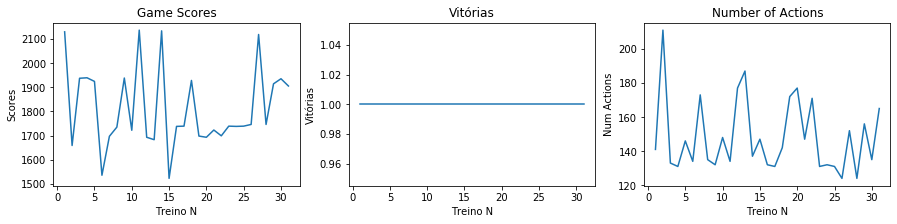

Wins:  31  Loss:  0


In [15]:
fig = plt.figure(figsize=(15, 3))
plt.subplot(131)
plt.xlabel('Treino N')
plt.ylabel('Scores')
plt.title('Game Scores')
plt.plot(range(1,len(gamesScores)+1),gamesScores[:])

plt.subplot(132)
plt.xlabel('Treino N')
plt.ylabel('Vitórias')
plt.title('Vitórias')
plt.plot(range(1,len(gamesScores)+1),results[:])

plt.subplot(133)
plt.xlabel('Treino N')
plt.ylabel('Num Actions')
plt.title('Number of Actions')
plt.plot(range(1,len(gamesScores)+1),numActions[:])
plt.show()

print("Wins: ",results.count(True)," Loss: ",results.count(False))

In [ ]:
layoutType='originalClassic'
pacman.setIsTrain(False)
gamesScores, results, numActions = approxQLearning(pacman, layoutType,30,pacman.n_train)

layout:  originalClassic
------------------------------------------ train --------------------
STATE VARS:  0.418 -0.0011890606420927466 1.0 0.0025 0
STATE VARS:  0.418 -0.0011111111111111111 1.0 0.0022675736961451248 0
Action Score:  [3.160015461348088, 3.16002714867587]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.0011111111111111111 1.0 0.0022675736961451248 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.398 -0.0011111111111111111 1.0 0.0022675736961451248 0
STATE VARS:  0.418 -0.0011890606420927466 1.0 0.0025 0
Action Score:  [3.0972489684306472, 3.160015461348088]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.0011890606420927466 1.0 0.0025 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.0013717421124828531 1.0 0.0022675736961451248 0
STATE VARS:  0.098 -0.0011890606420927466 0.25 0.0022675736961451248 0
STATE VARS:  0.418 -0.0011890606420927466 1.0 0.002770083102493075 

STATE VARS:  0.018 0 1.0 0.0016 0.002770083102493075
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.0022675736961451248
Action Score:  [1.9079353160231498, 0.4582570186702069]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0016 0.002770083102493075
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0030864197530864196
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.0025
Action Score:  [1.9082494092835898, 0.45849067458231724]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.0030864197530864196
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.0016 0.0025
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.0030864197530864196
Action Score:  [0.458536741570072, 1.908308275490829]
['South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.0030864197530864196
W:  [[3.13890901 1.2878713  1.84852877 0.

STATE VARS:  0.098 -0.01 0.25 0.008264462809917356 0.00510204081632653
STATE VARS:  0.418 -0.015625 1.0 0.005917159763313609 0.00390625
Action Score:  [0.764248626922239, 3.1459650476262513]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.005917159763313609 0.00390625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.01 0.25 0.006944444444444444 0.0044444444444444444
STATE VARS:  0.418 -0.015625 1.0 0.00510204081632653 0.0034602076124567475
Action Score:  [0.763199912627937, 3.1452843349475623]
['North', 'East', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.00510204081632653 0.0034602076124567475
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.015625 1.0 0.0044444444444444444 0.0034602076124567475
STATE VARS:  0.098 -0.01 0.25 0.005917159763313609 0.0044444444444444444
Action Score:  [3.1450333742221765, 0.7628078665039348]
['East', 'West', 'Stop']
STATE VARS:  0.41

STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0.00510204081632653 0
STATE VARS:  -1.402 -1.0 1.0 0.006944444444444444 0
Action Score:  [0.01860061960758705, -3.837442731434113]
['South', 'East', 'Stop']
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0.00510204081632653 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -1.402 -1.0 0.25 0.005917159763313609 0
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0.0044444444444444444 0
Action Score:  [-5.224231353442289, 0.01834965888220133]
['North', 'South', 'Stop']
STATE VARS:  0.042444444444444444 -0.25 0.1111111111111111 0.0044444444444444444 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -1.402 -1.0 0.1111111111111111 0.00510204081632653 0
STATE VARS:  0.098 -0.25 0.25 0.00510204081632653 0
Action Score:  [-5.48128253668549, 0.44972456026731433]
['North', 'South', 'Stop']
STATE VARS:  0.098 -0.25 0.25 0.0

STATE VARS:  0.098 -0.0030864197530864196 0.25 0.015625 0
STATE VARS:  0.418 -0.00390625 1.0 0.01 0
Action Score:  [0.7717333853019978, 3.159378321510662]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.00390625 1.0 0.01 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.00510204081632653 1.0 0.012345679012345678 0
STATE VARS:  0.418 -0.00390625 1.0 0.008264462809917356 0
STATE VARS:  0.098 -0.00390625 0.25 0.012345679012345678 0
Action Score:  [3.1587334862498393, 3.15871598258852, 0.7694260511103215]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 -0.00510204081632653 1.0 0.012345679012345678 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.006944444444444444 1.0 0.015625 0
STATE VARS:  0.398 -0.00510204081632653 1.0 0.01 0
Action Score:  [3.1576122058509224, 3.0950601165972054]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0.015625 0
W:  [[3

STATE VARS:  -0.002 0 0.25 0.0016 0.0022675736961451248
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.002770083102493075
Action Score:  [0.45834412949909176, 1.9080461267736348]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.002770083102493075
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.0025
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.0030864197530864196
Action Score:  [0.45858868611331777, 1.9083753500508622]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.0030864197530864196
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.008264462809917356 0.001890359168241966 0.0025
STATE VARS:  -0.002 0 0.012345679012345678 0.0022675736961451248 0.0030864197530864196
Action Score:  [0.01179245761408753, 0.01996662786782021]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.012345679012345678 0.00226

STATE VARS:  0.398 -0.0022675736961451248 1.0 0.02040816326530612 0.002066115702479339
STATE VARS:  0.418 -0.001890359168241966 1.0 0.04 0.001736111111111111
Action Score:  [3.10439484153195, 3.1748622490300997]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.001890359168241966 1.0 0.04 0.001736111111111111
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.001890359168241966 0.25 0.027777777777777776 0.001736111111111111
STATE VARS:  0.418 -0.0016 1.0 0.0625 0.0014792899408284023
Action Score:  [0.7793503812574213, 3.183610117156685]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.0016 1.0 0.0625 0.0014792899408284023
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.04 0.0016
STATE VARS:  0.018 0 1.0 0.1111111111111111 0.0013717421124828531
Action Score:  [0.47244563180001986, 1.9485696038462275]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.1111111111111111 0.0013717

STATE VARS:  -0.002 0 0.04 0.0006574621959237344 0.002770083102493075
STATE VARS:  -0.002 0 0.1111111111111111 0.0007304601899196494 0.0034602076124567475
Action Score:  [0.07020981475922693, 0.20226051518092109]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 0.1111111111111111 0.0007304601899196494 0.0034602076124567475
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.0625 0.0006925207756232687 0.0030864197530864196
STATE VARS:  -0.002 0 0.25 0.0007716049382716049 0.00390625
Action Score:  [0.1120772402771782, 0.4593859601161832]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 0.25 0.0007716049382716049 0.00390625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.1111111111111111 0.0007304601899196494 0.00390625
STATE VARS:  -0.002 0 1.0 0.0008163265306122449 0.00510204081632653
Action Score:  [0.20263015126162615, 1.8467905571240322]
['North', 'South', 'Stop']
STATE V

STATE VARS:  -0.002 0 0.04 0.0013717421124828531 0.0625
STATE VARS:  -0.002 0 0.1111111111111111 0.0011890606420927466 0.25
Action Score:  [0.11998069093886302, 0.40674347521078746]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 0.1111111111111111 0.0011890606420927466 0.25
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.0625 0.0012755102040816326 0.0625
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.25
Action Score:  [0.1615358629070224, 0.6635165738944554]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.25
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.1111111111111111 0.0011890606420927466 0.1111111111111111
STATE VARS:  -0.002 0 1.0 0.0013717421124828531 1.0
Action Score:  [0.29164601816161007, 2.671476143152553]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 0.0013717421124828531 1.0
W:  [[3.13890901 1.2878713  1.84852877 

STATE VARS:  0.398 -0.008264462809917356 1.0 0.0022675736961451248 0
STATE VARS:  0.042444444444444444 -0.005917159763313609 0.1111111111111111 0.001890359168241966 0
Action Score:  [3.0880363721083643, 0.33172221844770844]
['East', 'West', 'Stop']
STATE VARS:  0.398 -0.008264462809917356 1.0 0.0022675736961451248 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0025 0
STATE VARS:  0.098 -0.008264462809917356 0.25 0.002066115702479339 0
Action Score:  [3.145647172789865, 0.7598902094509983]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0025 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.012345679012345678 1.0 0.0022675736961451248 0
STATE VARS:  0.418 -0.02040816326530612 1.0 0.002770083102493075 0
STATE VARS:  0.098 -0.012345679012345678 0.25 0.0022675736961451248 0
Action Score:  [3.1455584711541684, 3.1353668034739313,

STATE VARS:  0.098 -0.0016 0.25 0.1111111111111111 0
STATE VARS:  0.418 -0.0013717421124828531 1.0 1.0 0
Action Score:  [0.810088389861634, 3.540459486627319]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.0013717421124828531 1.0 1.0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.042444444444444444 -0.0013717421124828531 0.1111111111111111 0.25 0
STATE VARS:  -0.002 0 1.0 1.0 0.0011890606420927466
Action Score:  [0.43226305194838444, 2.224869705334163]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.0011890606420927466
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0012755102040816326
STATE VARS:  0.018 0 1.0 0 0.0011111111111111111
Action Score:  [0.45691139139956555, 1.9059499097226602]
['North', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0011111111111111111
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS: 

STATE VARS:  -0.002 0 0.04 0 0.0025
STATE VARS:  0.006163265306122449 -0.0025 0.02040816326530612 0 0.002066115702479339
Action Score:  [0.06973508691618546, 0.05556352124537062]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 0.04 0 0.0025
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.023 -0.0030864197530864196 0.0625 0 0.002770083102493075
STATE VARS:  0.009111111111111111 -0.0025 0.027777777777777776 0 0.0022675736961451248
Action Score:  [0.18604861641585924, 0.07860643402360862]
['North', 'South', 'Stop']
STATE VARS:  0.023 -0.0030864197530864196 0.0625 0 0.002770083102493075
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.014 -0.0030864197530864196 0.04 0 0.0022675736961451248
STATE VARS:  0.014 -0.0030864197530864196 0.04 0 0.0022675736961451248
STATE VARS:  0.014 -0.0030864197530864196 0.04 0 0.0022675736961451248
STATE VARS:  0.042444444444444444 -0.00390625 0.111111111111111

STATE VARS:  0.002 -0.01 0.01 0 0
STATE VARS:  0.002 -0.01 0.01 0 0
STATE VARS:  0.002 -0.01 0.01 0 0
STATE VARS:  0.00425 -0.015625 0.015625 0 0
Action Score:  [0.011884392744100377, 0.011884392744100377, 0.011884392744100377, 0.022100636301450663]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.00425 -0.015625 0.015625 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.0029382716049382715 -0.01 0.012345679012345678 0 0
STATE VARS:  0.006163265306122449 -0.015625 0.02040816326530612 0 0
Action Score:  [0.019165597075242437, 0.036948016910905546]
['East', 'West', 'Stop']
STATE VARS:  0.006163265306122449 -0.015625 0.02040816326530612 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.00425 -0.01 0.015625 0 0
STATE VARS:  0.009111111111111111 -0.015625 0.027777777777777776 0 0
Action Score:  [0.029344912340819332, 0.05982398110917679]
['East', 'West', 'Stop']
STATE VARS:  0.0091

STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
Action Score:  [0.7182304233274762, 3.1248185323071884]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
Action Score:  [0.7182304233274762, 3.1248185323071884]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
STATE VARS:  0.098 -0.04 0.25 0 0
Action Score:  [3.1248185323071884, 0.7182304233274762]
['South', 'East', 'Stop']
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.04 0.25 0 0
STATE VARS:  0.418 -0.027777777777777776 1.0 0 0
Action Score:  [0.718230423327

STATE VARS:  0.006163265306122449 -0.008264462809917356 0.02040816326530612 0 0
STATE VARS:  0.014 -0.005917159763313609 0.04 0 0
Action Score:  [0.04642744148032736, 0.11026533667312546]
['North', 'South', 'Stop']
STATE VARS:  0.014 -0.005917159763313609 0.04 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.009111111111111111 -0.005917159763313609 0.027777777777777776 0 0
STATE VARS:  0.023 -0.0044444444444444444 0.0625 0 0
Action Score:  [0.07232642989506946, 0.18200408284618708]
['North', 'South', 'Stop']
STATE VARS:  0.023 -0.0044444444444444444 0.0625 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.014 -0.0044444444444444444 0.04 0 0
STATE VARS:  0.042444444444444444 -0.0044444444444444444 0.1111111111111111 0 0
Action Score:  [0.11216200445931127, 0.3328974620770916]
['North', 'East', 'Stop']
STATE VARS:  0.042444444444444444 -0.0044444444444444444 0.1111111111111111 0 0
W: 

STATE VARS:  -0.402 -1.0 0.0044444444444444444 0 0
STATE VARS:  -0.00022222222222222231 -0.1111111111111111 0.0044444444444444444 0 0
Action Score:  [-2.5414970354041095, -0.135578662577607]
['East', 'West', 'Stop']
STATE VARS:  -0.00022222222222222231 -0.1111111111111111 0.0044444444444444444 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.402 -1.0 0.00390625 0 0
STATE VARS:  4.081632653061229e-05 -0.1111111111111111 0.00510204081632653 0 0
Action Score:  [-2.5424919033173596, -0.13353742269529972]
['East', 'West', 'Stop']
STATE VARS:  4.081632653061229e-05 -0.1111111111111111 0.00510204081632653 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.00022222222222222231 -0.1111111111111111 0.0044444444444444444 0 0
STATE VARS:  0.0003668639053254439 -0.1111111111111111 0.005917159763313609 0 0
STATE VARS:  -0.402 -1.0 0.0044444444444444444 0 0
STATE VARS:  -0.00022222222222222231 -0.1

STATE VARS:  0.0003668639053254439 -0.25 0.005917159763313609 0 0
STATE VARS:  -1.402 -1.0 0.005917159763313609 0 0
STATE VARS:  0.0013057851239669422 -0.25 0.008264462809917356 0 0
Action Score:  [-0.309878231506818, -5.677683691031509, -0.3025919860233223]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.0013057851239669422 -0.25 0.008264462809917356 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -1.402 -1.0 0.006944444444444444 0 0
STATE VARS:  0.002 -0.25 0.01 0 0
Action Score:  [-5.675784725745672, -0.2972047182689628]
['East', 'West', 'Stop']
STATE VARS:  0.002 -0.25 0.01 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.0013057851239669422 -0.25 0.008264462809917356 0 0
STATE VARS:  0.0029382716049382715 -0.0625 0.012345679012345678 0 0
Action Score:  [-0.3025919860233223, -0.04844764595886513]
['East', 'West', 'Stop']
STATE VARS:  0.0029382716049382715 -0.0625 0.01234567901234

STATE VARS:  0.398 -0.0011111111111111111 1.0 0.0022675736961451248 0
STATE VARS:  0.418 -0.0012755102040816326 1.0 0.0025 0
Action Score:  [3.0972489684306472, 3.1599041254386604]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.0012755102040816326 1.0 0.0025 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.418 -0.0012755102040816326 1.0 0.0022675736961451248 0
STATE VARS:  0.098 -0.0011111111111111111 0.25 0.0022675736961451248 0
STATE VARS:  0.418 -0.0011111111111111111 1.0 0.002770083102493075 0
Action Score:  [3.1598154238029634, 0.7691796888681196, 3.1602189230385687]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.0011111111111111111 1.0 0.002770083102493075 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.398 -0.0012755102040816326 1.0 0.0025 0
STATE VARS:  0.418 -0.0011111111111111111 1.0 0.0030864197530864196 0
Action Score:  [3.097125945193437, 3.16033964766342]
['East',

STATE VARS:  -0.002 0 0.25 0.0016 0.002770083102493075
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.0034602076124567475
Action Score:  [0.45876055989375214, 1.9086180341218726]
['South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.0034602076124567475
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.00390625
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.0030864197530864196
Action Score:  [1.909054744762611, 0.45907465315419205]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.00390625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.00390625
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.0030864197530864196
Action Score:  [1.9091316278574497, 0.45913351936143115]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0022675736961451248 0.00390625
W:  [[3.13890901 1.2878713  1

STATE VARS:  0.018 0 1.0 1.0 0.0025
STATE VARS:  0.018 0 1.0 0.1111111111111111 0.0025
STATE VARS:  -0.002 0 0.25 0.1111111111111111 0.0030864197530864196
Action Score:  [2.2887342632417607, 1.9495045930652195, 0.5008158039766961]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 1.0 0.0025
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.002 0 1.0 1.0 0.0022675736961451248
STATE VARS:  -0.002 0 1.0 0.25 0.002770083102493075
Action Score:  [2.225763470925557, 1.9399548671087605]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.0022675736961451248
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.001890359168241966
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.0022675736961451248
Action Score:  [1.907019710992842, 0.45822029336184106]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.001890359168241966
W:  

STATE VARS:  0.018 0 1.0 0.00510204081632653 0.04
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.1111111111111111
STATE VARS:  -0.002 0 0.25 0.00510204081632653 0.04
Action Score:  [1.940124306772698, 1.9997573275038627, 0.4909495506433005]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.1111111111111111
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.25
STATE VARS:  -0.002 0 1.0 0.005917159763313609 0.0625
Action Score:  [2.1153585476221295, 1.896302991167425]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.25
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.818 -0.006944444444444444 1.0 0.01 0.0025
STATE VARS:  -0.002 0 0.25 0.006944444444444444 0.25
Action Score:  [4.413100877225693, 0.6656800284236425]
['East', 'West', 'Stop']
STATE VARS:  0.818 -0.006944444444444444 1.0 0.01 0.0025
W:  [[3.1389

STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.008264462809917356
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.008264462809917356
STATE VARS:  -0.002 0 0.25 0.0022675736961451248 0.008264462809917356
Action Score:  [0.4635685300522966, 1.9163171713116776, 0.4635685300522966, 0.4635685300522966]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0025 0.01
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.015625
Action Score:  [0.46509547429178133, 1.9191554747835233]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.002770083102493075 0.01
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.015625
Action 

STATE VARS:  -0.002 0 0.25 0 0.00390625
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
Action Score:  [0.45909148991637716, 1.909257199917053]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
Action Score:  [0.4595374925624427, 1.9087122486918404, 1.9099326903665867]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.005917159763313609
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0 0.005917159763313609
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
Action Score:  [1.8471545101213631, 1.9118779043700194]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.008264462809917356
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STAT

STATE VARS:  -0.002 0 0.0625 0 0.04
STATE VARS:  -0.002 0 0.25 0 0.1111111111111111
Action Score:  [0.14240329759598858, 0.5479323395762109]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.25 0 0.1111111111111111
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.1111111111111111 0 0.0625
STATE VARS:  -0.002 0 1.0 0 0.25
Action Score:  [0.2509081229637814, 2.0494263725095623]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 0 0.25
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0 0.25
STATE VARS:  -0.002 0 0.25 0 0.25
STATE VARS:  0.398 0 0.25 0 0.002066115702479339
Action Score:  [2.112204552754786, 0.6630297966253883, 1.713130172417278]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.25
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.498 -0.0025 0.25 0 0.0022675736961451248
STATE VARS:  0.018 0 1.0 0 0.11

STATE VARS:  -0.0006159169550173009 -0.0030864197530864196 0.0034602076124567475 0 0
STATE VARS:  -0.00022222222222222231 -0.00390625 0.0044444444444444444 0 0
Action Score:  [0.0004880746263752527, 0.002487400827027343]
['East', 'West', 'Stop']
STATE VARS:  -0.00022222222222222231 -0.00390625 0.0044444444444444444 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.0004375 -0.0030864197530864196 0.00390625 0 0
STATE VARS:  -0.0004375 -0.0030864197530864196 0.00390625 0 0
STATE VARS:  4.081632653061229e-05 -0.00390625 0.00510204081632653 0 0
Action Score:  [0.001872631399471478, 0.001872631399471478, 0.004528640709334623]
['North', 'East', 'West', 'Stop']
STATE VARS:  4.081632653061229e-05 -0.00390625 0.00510204081632653 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.00022222222222222231 -0.00390625 0.0044444444444444444 0 0
STATE VARS:  0.0003668639053254439 -0.00510204081632653 0.

STATE VARS:  0.0003668639053254439 -0.027777777777777776 0.005917159763313609 0 0
STATE VARS:  0.0013057851239669422 -0.015625 0.008264462809917356 0 0
Action Score:  [-0.023684610198426145, -0.0007471510496278571]
['East', 'West', 'Stop']
STATE VARS:  0.0013057851239669422 -0.015625 0.008264462809917356 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.0007777777777777776 -0.027777777777777776 0.006944444444444444 0 0
STATE VARS:  0.002 -0.015625 0.01 0 0
Action Score:  [-0.02049582365508497, 0.00464011670473171]
['East', 'West', 'Stop']
STATE VARS:  0.002 -0.015625 0.01 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.0029382716049382715 -0.015625 0.012345679012345678 0 0
STATE VARS:  0.0013057851239669422 -0.015625 0.008264462809917356 0 0
STATE VARS:  0.0013057851239669422 -0.027777777777777776 0.008264462809917356 0 0
STATE VARS:  0.0013057851239669422 -0.015625 0.008264462809917

STATE VARS:  0.023 -0.0022675736961451248 0.0625 0 0
STATE VARS:  0.014 -0.0022675736961451248 0.04 0 0
STATE VARS:  0.014 -0.0022675736961451248 0.04 0 0
STATE VARS:  0.042444444444444444 -0.002770083102493075 0.1111111111111111 0 0
Action Score:  [0.1848076121977795, 0.11496553381090367, 0.11496553381090367, 0.3350538239883349]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.002770083102493075 0.1111111111111111 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.023 -0.002770083102493075 0.0625 0 0
STATE VARS:  0.098 -0.0034602076124567475 0.25 0 0
Action Score:  [0.18416044475743037, 0.7652889731010913]
['East', 'West', 'Stop']
STATE VARS:  0.098 -0.0034602076124567475 0.25 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.042444444444444444 -0.0034602076124567475 0.1111111111111111 0 0
STATE VARS:  0.398 -0.0044444444444444444 1.0 0 0
Action Score:  [

STATE VARS:  0.418 -0.005917159763313609 1.0 0 0
STATE VARS:  0.098 -0.0044444444444444444 0.25 0 0
Action Score:  [3.1529721947583838, 0.7640214027368188]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.005917159763313609 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.005917159763313609 1.0 0 0
STATE VARS:  0.098 -0.0044444444444444444 0.25 0 0
Action Score:  [3.1529721947583838, 0.7640214027368188]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.005917159763313609 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.005917159763313609 1.0 0 0
STATE VARS:  0.098 -0.0044444444444444444 0.25 0 0
Action Score:  [3.1529721947583838, 0.7640214027368188]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.005917159763313609 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  4.081632653061229e-05 -0.008264462809917356 0.00510

STATE VARS:  0.00425 -0.00510204081632653 0.015625 0 0
STATE VARS:  0.009111111111111111 -0.006944444444444444 0.027777777777777776 0 0
Action Score:  [0.03565285338190226, 0.07100341944153585]
['North', 'South', 'Stop']
STATE VARS:  0.009111111111111111 -0.006944444444444444 0.027777777777777776 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.006163265306122449 -0.00510204081632653 0.02040816326530612 0 0
STATE VARS:  0.014 -0.006944444444444444 0.04 0 0
Action Score:  [0.05050023399135714, 0.10894232621959185]
['North', 'South', 'Stop']
STATE VARS:  0.014 -0.006944444444444444 0.04 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.009111111111111111 -0.00510204081632653 0.027777777777777776 0 0
STATE VARS:  0.023 -0.006944444444444444 0.0625 0 0
Action Score:  [0.07337619818962839, 0.17878440460646766]
['North', 'South', 'Stop']
STATE VARS:  0.023 -0.006944444444444444 0.0625 0 0

STATE VARS:  0.418 -0.0625 1.0 0 0
STATE VARS:  0.098 -0.25 0.25 0 0
Action Score:  [3.0801007789777524, 0.44777745119104595]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.0625 1.0 0 0
STATE VARS:  0.098 -0.25 0.25 0 0
Action Score:  [3.0801007789777524, 0.44777745119104595]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.0007777777777777776 -0.25 0.006944444444444444 0 0
STATE VARS:  4.081632653061229e-05 -0.25 0.00510204081632653 0 0
Action Score:  [-0.30668944496347683, -0.3124084360130446]
['South', 'West', 'Stop']
STATE VARS:  0.0007777777777777776 -0.25 0.006944444444444444 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.0003668639053254439 -0.25 0.005917159763313609 0 0
STATE VARS:  0.001305785123966942

STATE VARS:  -0.0004375 -0.25 0.00390625 0 0
Action Score:  [-0.3161202811654083]
['West', 'Stop']
STATE VARS:  -0.0004375 -0.25 0.00390625 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.0006159169550173009 -0.0625 0.0034602076124567475 0 0
STATE VARS:  -0.00022222222222222231 -0.25 0.0044444444444444444 0 0
Action Score:  [-0.07602896995954894, -0.3144496758953519]
['East', 'West', 'Stop']
STATE VARS:  -0.0006159169550173009 -0.0625 0.0034602076124567475 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.0004375 -0.0625 0.00390625 0 0
Action Score:  [-0.07464441318645272]
['West', 'Stop']
STATE VARS:  -0.0004375 -0.0625 0.00390625 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.0006159169550173009 -0.0625 0.0034602076124567475 0 0
STATE VARS:  -0.00022222222222222231 -0.25 0.0044444444444444444 0 0
Action Score:  [-0.0760289699

STATE VARS:  0.009111111111111111 -0.00510204081632653 0.027777777777777776 0 0
STATE VARS:  0.023 -0.006944444444444444 0.0625 0 0
Action Score:  [0.07337619818962839, 0.17878440460646766]
['North', 'South', 'Stop']
STATE VARS:  0.023 -0.006944444444444444 0.0625 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.014 -0.00510204081632653 0.04 0 0
STATE VARS:  0.042444444444444444 -0.00510204081632653 0.1111111111111111 0 0
STATE VARS:  0.014 -0.006944444444444444 0.04 0 0
Action Score:  [0.11131510496768439, 0.3320505625854647, 0.10894232621959185]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.042444444444444444 -0.00510204081632653 0.1111111111111111 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.023 -0.00510204081632653 0.0625 0 0
STATE VARS:  0.098 -0.00390625 0.25 0 0
Action Score:  [0.18115718335456021, 0.7647145279134251]
['North', 'South', 'Stop']
STATE VARS:  0.098 -0.

STATE VARS:  0.006163265306122449 -0.0030864197530864196 0.02040816326530612 0 0
STATE VARS:  0.014 -0.00390625 0.04 0 0
Action Score:  [0.05309609450209085, 0.11285512963591753]
['East', 'West', 'Stop']
STATE VARS:  0.014 -0.00390625 0.04 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.009111111111111111 -0.0030864197530864196 0.027777777777777776 0 0
STATE VARS:  0.023 -0.00390625 0.0625 0 0
Action Score:  [0.0759720587003621, 0.18269720802279332]
['East', 'West', 'Stop']
STATE VARS:  0.023 -0.00390625 0.0625 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.042444444444444444 -0.00510204081632653 0.1111111111111111 0 0
STATE VARS:  0.014 -0.00390625 0.04 0 0
Action Score:  [0.3320505625854647, 0.11285512963591753]
['North', 'East', 'Stop']
STATE VARS:  0.042444444444444444 -0.00510204081632653 0.1111111111111111 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   

STATE VARS:  0.098 -0.001040582726326743 0.25 0.00390625 0
STATE VARS:  0.418 -0.001040582726326743 1.0 0.00510204081632653 0
Action Score:  [0.7698958939252719, 3.1611997074227727]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.001040582726326743 1.0 0.00510204081632653 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.0009182736455463728 0.25 0.0044444444444444444 0
STATE VARS:  0.418 -0.001040582726326743 1.0 0.005917159763313609 0
Action Score:  [0.770258805244, 3.1615107840207566]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.001040582726326743 1.0 0.005917159763313609 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.0009182736455463728 0.25 0.00510204081632653 0
STATE VARS:  0.418 -0.001040582726326743 1.0 0.006944444444444444 0
Action Score:  [0.7705097659693858, 3.1619028301447587]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.001040582726326743 1.0 0.0069444444444

STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.0044444444444444444
STATE VARS:  -0.002 0 1.0 0.002770083102493075 0.0034602076124567475
Action Score:  [1.910032779414846, 1.846175585894219]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.0044444444444444444
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.00390625 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.00390625
Action Score:  [1.9107479553035709, 0.46026937071560126]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.00390625 0.00510204081632653
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.0034602076124567475 0.0044444444444444444
Action Score:  [1.9116288387174694, 0.4608580232854483]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0044444444444444444 0.005917159763313609


STATE VARS:  0.418 -0.002770083102493075 1.0 0.02040816326530612 0.0011890606420927466
STATE VARS:  0.098 -0.0022675736961451248 0.25 0.04 0.001040582726326743
Action Score:  [3.1657990373253977, 0.782952599911032]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.002770083102493075 1.0 0.02040816326530612 0.0011890606420927466
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.002770083102493075 1.0 0.015625 0.0013717421124828531
STATE VARS:  0.098 -0.0022675736961451248 0.25 0.027777777777777776 0.0011890606420927466
Action Score:  [3.164125011009778, 0.7784112358459396]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.002770083102493075 1.0 0.015625 0.0013717421124828531
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.002770083102493075 1.0 0.012345679012345678 0.0014792899408284023
STATE VARS:  0.098 -0.0022675736961451248 0.25 0.02040816326530612 0.0012755102040816326
Action Sco

STATE VARS:  -0.002 0 0.1111111111111111 0.001736111111111111 0.0044444444444444444
STATE VARS:  -0.002 0 0.04 0.0014792899408284023 0.0034602076124567475
Action Score:  [0.20345994386678878, 0.07109535900666633]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.1111111111111111 0.001736111111111111 0.0044444444444444444
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.00510204081632653
STATE VARS:  -0.002 0 0.0625 0.0016 0.00390625
Action Score:  [0.46080386794445777, 0.11310295935165138]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.25 0.001890359168241966 0.00510204081632653
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.002 0 1.0 0.002066115702479339 0.006944444444444444
STATE VARS:  -0.002 0 0.1111111111111111 0.001736111111111111 0.00510204081632653
Action Score:  [1.8487943213903382, 0.20400489509200123]
['East', 'West', 'Stop']
STATE VARS:  -0.

STATE VARS:  0.018 0 1.0 0.00510204081632653 0.00510204081632653
STATE VARS:  -0.002 0 1.0 0.00390625 0.00390625
Action Score:  [1.9112043089933213, 1.8469788211870692]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.00510204081632653
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0.0044444444444444444 0.00390625
Action Score:  [1.911515385591305, 0.4607876382672599]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.005917159763313609 0.00510204081632653
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.00510204081632653 0.0044444444444444444
STATE VARS:  0.018 0 1.0 0.006944444444444444 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.00510204081632653 0.0044444444444444444
Action Score:  [1.9106593577681088, 1.912582922164841, 0.4614846016387111]
['North', 'East', 'West', '

STATE VARS:  0.398 -0.25 1.0 0.01 0
STATE VARS:  0.418 -0.0625 1.0 0.006944444444444444 0
Action Score:  [2.779663064543059, 3.0827510107760063]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.006944444444444444 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.25 0.25 0.008264462809917356 0
STATE VARS:  0.418 -0.0625 1.0 0.005917159763313609 0
Action Score:  [0.4509314460583898, 3.082358964652004]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.005917159763313609 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.25 0.25 0.006944444444444444 0
STATE VARS:  0.418 -0.0625 1.0 0.005917159763313609 0
Action Score:  [0.4504276829893002, 3.082358964652004]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.0625 1.0 0.005917159763313609 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.0625 0.25 0.00591

STATE VARS:  0.018 0 1.0 0.001736111111111111 0.012345679012345678
STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.02040816326530612
Action Score:  [1.9159225730868683, 0.47333119975857646]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.001736111111111111 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0.0016 0.02040816326530612
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.015625
Action Score:  [0.47337726674633124, 1.9186990181411019]
['South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.001890359168241966 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.001736111111111111 0.015625
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.02040816326530612
Action Score:  [0.469465395804465, 1.9227299081862472]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.002066115702479339 0.02040816326530612
W:  [[3.13890901 1.2878713  1.84

STATE VARS:  -0.002 0 0.25 0.0014792899408284023 0.015625
STATE VARS:  0.018 0 1.0 0.0012755102040816326 0.012345679012345678
Action Score:  [0.46936738427346447, 1.9157467924063718]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0012755102040816326 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0013717421124828531 0.012345679012345678
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.015625
Action Score:  [0.46660876158534, 1.9184313792149157]
['North', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0011890606420927466 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0.0012755102040816326 0.015625
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.027777777777777776
Action Score:  [0.46928961512396855, 1.9284726585638228]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0011111111111111111 0.027777777777777776
W:  [[3.13890901 1.

STATE VARS:  -0.00022222222222222231 -0.002066115702479339 0.0044444444444444444 0.0012755102040816326 0
STATE VARS:  0.0003668639053254439 -0.0025 0.005917159763313609 0.0014792899408284023 0
Action Score:  [0.005344034238449899, 0.009434460643966453]
['East', 'West', 'Stop']
STATE VARS:  0.0003668639053254439 -0.0025 0.005917159763313609 0.0014792899408284023 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  4.081632653061229e-05 -0.0025 0.00510204081632653 0.0013717421124828531 0
STATE VARS:  0.0007777777777777776 -0.0030864197530864196 0.006944444444444444 0.0016 0
Action Score:  [0.0068632122966097225, 0.011914081007720784]
['East', 'West', 'Stop']
STATE VARS:  0.0007777777777777776 -0.0030864197530864196 0.006944444444444444 0.0016 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.0013057851239669422 -0.00390625 0.008264462809917356 0.001736111111111111 0
STATE VARS:  0.000366863905325

STATE VARS:  0.418 -0.006944444444444444 1.0 0.0009765625 0
STATE VARS:  0.098 -0.01 0.25 0.0011111111111111111 0
STATE VARS:  0.418 -0.006944444444444444 1.0 0.0009765625 0
Action Score:  [3.1520218731514795, 0.7572905992918297, 3.1520218731514795]
['North', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0.0009765625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.006944444444444444 1.0 0.0009182736455463728 0
STATE VARS:  0.398 -0.01 1.0 0.001040582726326743 0
Action Score:  [3.1519996281789995, 3.08533296286856]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.006944444444444444 1.0 0.0009182736455463728 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.006944444444444444 1.0 0.0008650519031141869 0
STATE VARS:  0.098 -0.01 0.25 0.0009765625 0
Action Score:  [3.1519793169856016, 0.7572392510507386]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.

STATE VARS:  0.098 -0.027777777777777776 0.25 0.0007716049382716049 0
STATE VARS:  0.098 -0.015625 0.25 0.0006925207756232687 0
STATE VARS:  0.418 -0.015625 1.0 0.0007716049382716049 0
Action Score:  [0.7342655426992438, 0.7498865752083337, 3.140764216172297]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.0007716049382716049 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.015625 1.0 0.0008163265306122449 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0.0007304601899196494 0
Action Score:  [3.140781283424694, 0.7342498404899043]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.0008163265306122449 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 -0.02040816326530612 1.0 0.0008650519031141869 0
STATE VARS:  0.098 -0.027777777777777776 0.25 0.0007716049382716049 0
Action Score:  [3.13463977998031, 0.7342655426992438]
['East', 'West', 'Stop']
STA

STATE VARS:  -0.00089196675900277 -0.0044444444444444444 0.002770083102493075 0.0012755102040816326 0
STATE VARS:  -0.00109297052154195 -0.00510204081632653 0.0022675736961451248 0.0011111111111111111 0
Action Score:  [-0.002916319351290576, -0.005385794639743697]
['East', 'West', 'Stop']
STATE VARS:  -0.00089196675900277 -0.0044444444444444444 0.002770083102493075 0.0012755102040816326 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  -0.0007654320987654322 -0.005917159763313609 0.0030864197530864196 0.0013717421124828531 0
STATE VARS:  -0.0007654320987654322 -0.005917159763313609 0.0030864197530864196 0.0013717421124828531 0
STATE VARS:  -0.001 -0.0044444444444444444 0.0025 0.0011890606420927466 0
Action Score:  [-0.003794323644782443, -0.003794323644782443, -0.0037876742881984412]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.001 -0.0044444444444444444 0.0025 0.0011890606420927466 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 

STATE VARS:  -0.0007654320987654322 -0.04 0.0030864197530864196 0.0008650519031141869 0
STATE VARS:  -0.0004375 -0.02040816326530612 0.00390625 0.0009765625 0
Action Score:  [-0.04788200516462089, -0.020062856018016863]
['East', 'West', 'Stop']
STATE VARS:  -0.0004375 -0.02040816326530612 0.00390625 0.0009765625 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.00022222222222222231 -0.02040816326530612 0.0044444444444444444 0.001040582726326743 0
STATE VARS:  -0.0006159169550173009 -0.04 0.0034602076124567475 0.0009182736455463728 0
STATE VARS:  -0.0006159169550173009 -0.02040816326530612 0.0034602076124567475 0.0009182736455463728 0
Action Score:  [-0.01836781849266629, -0.046701421927924966, -0.021469657763593268]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.00022222222222222231 -0.02040816326530612 0.0044444444444444444 0.001040582726326743 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STAT

STATE VARS:  0.418 -0.012345679012345678 1.0 0.006944444444444444 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.00510204081632653 0
Action Score:  [3.1473433211407476, 0.7454092965680763]
['North', 'West', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.006944444444444444 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.01 1.0 0.008264462809917356 0
STATE VARS:  0.098 -0.015625 0.25 0.005917159763313609 0
Action Score:  [3.150868016879204, 0.7518804718389925]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.01 1.0 0.008264462809917356 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.023 -0.01 0.0625 0.01 0
STATE VARS:  0.009111111111111111 -0.015625 0.027777777777777776 0.006944444444444444 0
Action Score:  [0.17866557610296335, 0.06247421290743102]
['North', 'South', 'Stop']
STATE VARS:  0.023 -0.01 0.0625 0.01 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.828

STATE VARS:  -0.002 0 0.25 0 0.01
STATE VARS:  0.018 0 1.0 0 0.015625
STATE VARS:  -0.002 0 0.25 0 0.01
STATE VARS:  -0.002 0 0.25 0 0.01
Action Score:  [0.4641413908444098, 1.9179775939842991, 0.4641413908444098, 0.4641413908444098]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0 0.01
STATE VARS:  0.018 0 1.0 0 0.015625
Action Score:  [0.4641413908444098, 1.9179775939842991]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.015625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.027777777777777776 0 0.012345679012345678
STATE VARS:  -0.002 0 0.015625 0 0.02040816326530612
Action Score:  [0.05530108837555911, 0.039517723376209034]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 0.027777777777777776 0 0.012345679012345678
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]

STATE VARS:  0.018 0 1.0 0 0.0034602076124567475
STATE VARS:  -0.002 0 0.25 0 0.0044444444444444444
Action Score:  [1.9078966099650698, 0.4595374925624427]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0034602076124567475
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  -0.002 0 0.25 0 0.0034602076124567475
STATE VARS:  0.018 0 1.0 0 0.002770083102493075
Action Score:  [0.45872185383567204, 1.907324702616832]
['South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.002770083102493075
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.0030864197530864196
STATE VARS:  0.018 0 1.0 0 0.0025
Action Score:  [0.4584120952046285, 1.9071008842931518]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0025
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.0025
STATE VARS:  0.018 0 1.0 0 0.002066115702479339
Action S

STATE VARS:  0.418 -0.0016 1.0 0.25 0
STATE VARS:  0.098 -0.0016 0.25 0.0625 0
Action Score:  [3.253940485634469, 0.7915367672738544]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.0016 1.0 0.25 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.0016 0.25 0.1111111111111111 0
STATE VARS:  0.418 -0.001890359168241966 1.0 1.0 0
Action Score:  [0.810088389861634, 3.5397915746076487]
['South', 'West', 'Stop']
STATE VARS:  0.418 -0.001890359168241966 1.0 1.0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.042444444444444444 -0.0016 0.1111111111111111 0.25 0
STATE VARS:  -0.002 0 1.0 1.0 0.001890359168241966
Action Score:  [0.4319690851669911, 2.2254508726085063]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 1.0 1.0 0.001890359168241966
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0014792899408284023 0.002066115702479339

STATE VARS:  0.018 0 1.0 0.012345679012345678 0.25
STATE VARS:  -0.002 0 1.0 0.02040816326530612 0.0625
Action Score:  [2.116916075951682, 1.9018332417982464]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.012345679012345678 0.25
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.418 0 1.0 0.01 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.015625 0.1111111111111111
Action Score:  [3.169312629060544, 0.553895361122283]
['East', 'West', 'Stop']
STATE VARS:  0.418 0 1.0 0.01 0.005917159763313609
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.008264462809917356
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.005917159763313609
STATE VARS:  -0.002 0 0.25 0.012345679012345678 0.005917159763313609
Action Score:  [1.9150318992373632, 1.9130866852339306, 0.4654694574340854]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.008264462809917356 0.0082

STATE VARS:  0.418 -0.02040816326530612 1.0 0.00510204081632653 0
STATE VARS:  0.098 -0.04 0.25 0.00510204081632653 0
Action Score:  [3.1362567563758272, 0.7201775324037446]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.02040816326530612 1.0 0.00510204081632653 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.012345679012345678 1.0 0.005917159763313609 0
STATE VARS:  0.098 -0.02040816326530612 0.25 0.0044444444444444444 0
Action Score:  [3.1469512750167454, 0.7451583358426906]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.005917159763313609 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.015625 0.25 0.00510204081632653 0
STATE VARS:  0.418 -0.012345679012345678 1.0 0.006944444444444444 0
Action Score:  [0.7515693952410087, 3.1473433211407476]
['South', 'East', 'Stop']
STATE VARS:  0.418 -0.012345679012345678 1.0 0.006944444444444444 0
W:  [

STATE VARS:  -0.002 0 0.25 0.002770083102493075 0.027777777777777776
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.0625
Action Score:  [0.47993102152107736, 1.958143516461402]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0034602076124567475 0.0625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.0625
STATE VARS:  0.018 0 1.0 0.00390625 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.0030864197530864196 0.027777777777777776
Action Score:  [1.9580008665376207, 1.9295393768626201, 0.4800517461459286]
['North', 'South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.0030864197530864196 0.0625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0.002770083102493075 0.1111111111111111
STATE VARS:  -0.002 0 1.0 0.0034602076124567475 0.04
Action Score:  [1.9981642518799814, 1.8767195481742118]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.002

STATE VARS:  -0.002 0 0.04 0.0034602076124567475 0.006944444444444444
STATE VARS:  -0.002 0 0.04 0.0034602076124567475 0.006944444444444444
STATE VARS:  -0.002 0 0.1111111111111111 0.0044444444444444444 0.01
Action Score:  [0.07473873626476471, 0.07473873626476471, 0.20909743255007504]
['North', 'East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.1111111111111111 0.0044444444444444444 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.0625 0.00390625 0.006944444444444444
STATE VARS:  -0.002 0 0.25 0.00510204081632653 0.01
Action Score:  [0.11650085820480237, 0.4660884999206782]
['East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.25 0.00510204081632653 0.01
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.1111111111111111 0.0044444444444444444 0.008264462809917356
STATE VARS:  -0.002 0 1.0 0.005917159763313609 0.012345679012345678
Action Score:  [0.20765918994628696, 1.854740020

STATE VARS:  -0.002 0 0.25 0.0006574621959237344 0.1111111111111111
STATE VARS:  0.018 0 1.0 0.0007304601899196494 0.04
Action Score:  [0.5481832490955723, 1.9384559656868963]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0.0007304601899196494 0.04
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.25 0.0006925207756232687 0.0625
STATE VARS:  0.018 0 1.0 0.0007716049382716049 0.027777777777777776
Action Score:  [0.507912518652592, 1.9283430916759081]
['North', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0.0007716049382716049 0.027777777777777776
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  East
STATE VARS:  0.018 0 1.0 0.0008163265306122449 0.027777777777777776
STATE VARS:  -0.002 0 0.25 0.0007304601899196494 0.0625
Action Score:  [1.928360158928305, 0.5079269975994654]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0.0008163265306122449 0.027777777777777776
W:  [[3.13890901 1.2878713  1.84852

STATE VARS:  -0.002 0 0.0044444444444444444 0.0007304601899196494 0.04
STATE VARS:  -0.002 0 0.005917159763313609 0.0008163265306122449 0.1111111111111111
Action Score:  [0.03536470100875416, 0.09704972511344594]
['North', 'South', 'Stop']
STATE VARS:  -0.002 0 0.005917159763313609 0.0008163265306122449 0.1111111111111111
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  -0.002 0 0.00510204081632653 0.0007716049382716049 0.1111111111111111
STATE VARS:  -0.002 0 0.006944444444444444 0.0008650519031141869 1.0
STATE VARS:  -0.002 0 0.00510204081632653 0.0008650519031141869 0.1111111111111111
STATE VARS:  -0.002 0 0.00510204081632653 0.0007716049382716049 0.1111111111111111
Action Score:  [0.09552588703832741, 0.8355910107425669, 0.09556154951927277, 0.09552588703832741]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  -0.002 0 0.006944444444444444 0.0008650519031141869 1.0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]  

STATE VARS:  0.418 -0.00510204081632653 1.0 0.0022675736961451248 0
STATE VARS:  0.098 -0.006944444444444444 0.25 0.002770083102493075 0
STATE VARS:  0.418 -0.00510204081632653 1.0 0.0022675736961451248 0
STATE VARS:  0.098 -0.00510204081632653 0.25 0.0022675736961451248 0
Action Score:  [3.1548873448646173, 0.7618588806714723, 3.1548873448646173, 0.7640398850568668]
['North', 'South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.00510204081632653 1.0 0.0022675736961451248 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.00510204081632653 1.0 0.002066115702479339 0
STATE VARS:  0.398 -0.006944444444444444 1.0 0.0025 0
Action Score:  [3.1548104617697788, 3.0898250875069984]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.00510204081632653 1.0 0.002066115702479339 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.418 -0.00510204081632653 1.0 0.001890359168241966 0
STATE VARS:  0.

STATE VARS:  0.098 -0.027777777777777776 0.25 0.0034602076124567475 0
STATE VARS:  0.418 -0.015625 1.0 0.0044444444444444444 0
Action Score:  [0.7352916032224434, 3.142165894323374]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.0044444444444444444 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.015625 0.25 0.00390625 0
STATE VARS:  0.418 -0.015625 1.0 0.00510204081632653 0
Action Score:  [0.7511130415512584, 3.1424168550487597]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.00510204081632653 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.01 0.25 0.0044444444444444444 0
STATE VARS:  0.418 -0.015625 1.0 0.005917159763313609 0
Action Score:  [0.7585627105549918, 3.142727931646743]
['North', 'South', 'Stop']
STATE VARS:  0.418 -0.015625 1.0 0.005917159763313609 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  Sou

STATE VARS:  0.018 0 1.0 0 0.0034602076124567475
STATE VARS:  -0.002 0 0.25 0 0.002770083102493075
Action Score:  [1.9078966099650698, 0.45814994648743435]
['North', 'South', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0034602076124567475
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.018 0 1.0 0 0.0030864197530864196
STATE VARS:  -0.002 0 0.25 0 0.0030864197530864196
STATE VARS:  0.018 0 1.0 0 0.00390625
Action Score:  [1.9075868513340262, 0.4584120952046285, 1.9082662460457749]
['North', 'South', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.00390625
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 1.0 0 0.00390625
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
Action Score:  [1.8454880658005512, 1.909257199917053]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0

STATE VARS:  -0.002 0 0.25 0 0.002770083102493075
STATE VARS:  0.018 0 1.0 0 0.0034602076124567475
Action Score:  [0.45814994648743435, 1.9078966099650698]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0034602076124567475
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  -0.002 0 0.25 0 0.0034602076124567475
STATE VARS:  0.018 0 1.0 0 0.0044444444444444444
Action Score:  [0.45872185383567204, 1.9087122486918404]
['East', 'West', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.0044444444444444444
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
STATE VARS:  -0.002 0 0.25 0 0.00390625
Action Score:  [1.909257199917053, 0.45909148991637716]
['South', 'East', 'Stop']
STATE VARS:  0.018 0 1.0 0 0.00510204081632653
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  South
STATE VARS:  0.098 -0.00510204081632653 0.25 0 0
STATE VARS:  0.418 -0.00694

STATE VARS:  0.0029382716049382715 -0.01 0.012345679012345678 0 0
STATE VARS:  0.006163265306122449 -0.006944444444444444 0.02040816326530612 0 0
Action Score:  [0.019165597075242437, 0.0481274552432646]
['East', 'West', 'Stop']
STATE VARS:  0.006163265306122449 -0.006944444444444444 0.02040816326530612 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.00425 -0.01 0.015625 0 0
STATE VARS:  0.009111111111111111 -0.006944444444444444 0.027777777777777776 0 0
Action Score:  [0.029344912340819332, 0.07100341944153585]
['East', 'West', 'Stop']
STATE VARS:  0.009111111111111111 -0.006944444444444444 0.027777777777777776 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.006163265306122449 -0.006944444444444444 0.02040816326530612 0 0
STATE VARS:  0.006163265306122449 -0.01 0.02040816326530612 0 0
STATE VARS:  0.014 -0.006944444444444444 0.04 0 0
Action Score:  [0.0481274552432646, 0.044192292

STATE VARS:  0.398 -0.0044444444444444444 1.0 0 0
STATE VARS:  0.042444444444444444 -0.0034602076124567475 0.1111111111111111 0 0
Action Score:  [3.092090682299346, 0.3341650324413641]
['North', 'South', 'Stop']
STATE VARS:  0.398 -0.0044444444444444444 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  North
STATE VARS:  0.098 -0.0044444444444444444 0.25 0 0
STATE VARS:  0.098 -0.005917159763313609 0.25 0 0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0 0
Action Score:  [0.7640214027368188, 0.762124734950633, 3.1548688625445696]
['South', 'East', 'West', 'Stop']
STATE VARS:  0.418 -0.0044444444444444444 1.0 0 0
W:  [[3.13890901 1.2878713  1.84852877 0.38163338 0.82870169]]   -  ACTION:  West
STATE VARS:  0.098 -0.005917159763313609 0.25 0 0
STATE VARS:  0.418 -0.0044444444444444444 1.0 0 0
Action Score:  [0.762124734950633, 3.1548688625445696]
['East', 'West', 'Stop']
STATE VARS:  0.418 -0.0044444444444444444 1.0 0 0
W:  [[3.13890901 1.2878713  1.848

In [ ]:
fig = plt.figure(figsize=(15, 3))
plt.subplot(131)
plt.xlabel('Treino N')
plt.ylabel('Scores')
plt.title('Game Scores')
plt.plot(range(1,len(gamesScores)+1),gamesScores[:])

plt.subplot(132)
plt.xlabel('Treino N')
plt.ylabel('Vitórias')
plt.title('Vitórias')
plt.plot(range(1,len(gamesScores)+1),results[:])

plt.subplot(133)
plt.xlabel('Treino N')
plt.ylabel('Num Actions')
plt.title('Number of Actions')
plt.plot(range(1,len(gamesScores)+1),numActions[:])
plt.show()

print("Wins: ",results.count(True)," Loss: ",results.count(False))

In [ ]:
# GAME LAYOUTS: smallClassic, mediumClassic, originalClassic
gameLayout = layout.getLayout( 'mediumClassic' )

ind = GPTree()
ind.random_tree(True, 2)
ind.print_tree()

pacman = MyGoWestAgent(ind)
# pacman.setTree(ind)

ghostType = loadAgent('RandomGhost', True)
ghosts = [ghostType( i+1 ) for i in range( 4 )]

import textDisplay
textDisplay.SLEEP_TIME = 0.1
gameDisplay = textDisplay.PacmanGraphics()

runGames( gameLayout, pacman, ghosts, gameDisplay, 4, False)